# Klasyfikacja Komponentów mózgowych ICA

## Uwagi o zbiorze danych i komponentach ICA

\

**ICA** - czyli Independent Component Analysis to technika stosowana w wielu dziedzinach zwiazanych z analiza sygnału, której celem jest wydzielenie tzw. Niezależnych Komponentów - czyli rozkład sygnału na pewne fale składowe, dające kontrybucję do całości sygnału. To rozdział wielowymiarowego sygnału  na niegaussowskie sygnały . Przykładem takiej dekompozycji jest rozwiązanie problemu Coctail party i z ogólnego harmideru i hałasu, czy da się wydzielić głosy posczególnych uczestników zabaawy. Staramy się następnie znaleźc akie komponenty, w których **mixing matrix** będzie skutecznie dawała nam niezależne kanały. Każda taka macierz ma za zadanie dać nam maksym alnie niezależne komponenty.

Innymi słowy nas całościowy sygnał, jest dany jako **mixing matrix** przemnożone przez szereg czasowy poszczególnych komponentów z dodatkiem szumu. - kazdy Mixing matrix -**będzie obrazował nasz komponent ICA** 
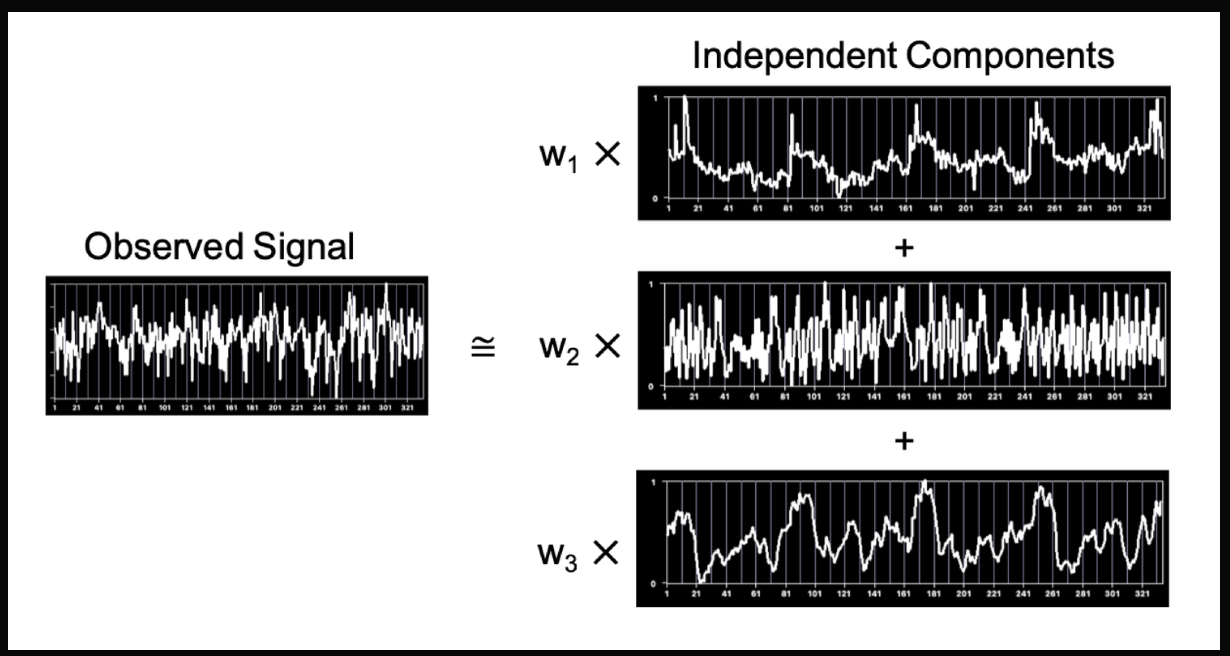

W przypadku danych Elektrofizjologicznych, a szczegolnie danych mózgowych, ICA służy do wydzielenia pewnych źródeł aktywności mózgowej, która składa się na obserwowany przez nas przy pomocy EEG, mocno zagmatwany i zaszumiony sygnał. Możemy dzięki temu z czasowego sygnału EEG, uzyskać komponenty, gdzie wieksza katywność będzie widoczna na pewnych konkretnie ułożonych w przestrzeni elektrodach - tym samym, mozna wnioskować o źródle tego konkretnego komponentu:



Mixing Matrix, w przypadku neurofizjologi będzie więc obrazowało,Jaka wartość będzie rejestrowana na każdej z elektrod, dajac nam określonę źródło aktywności.

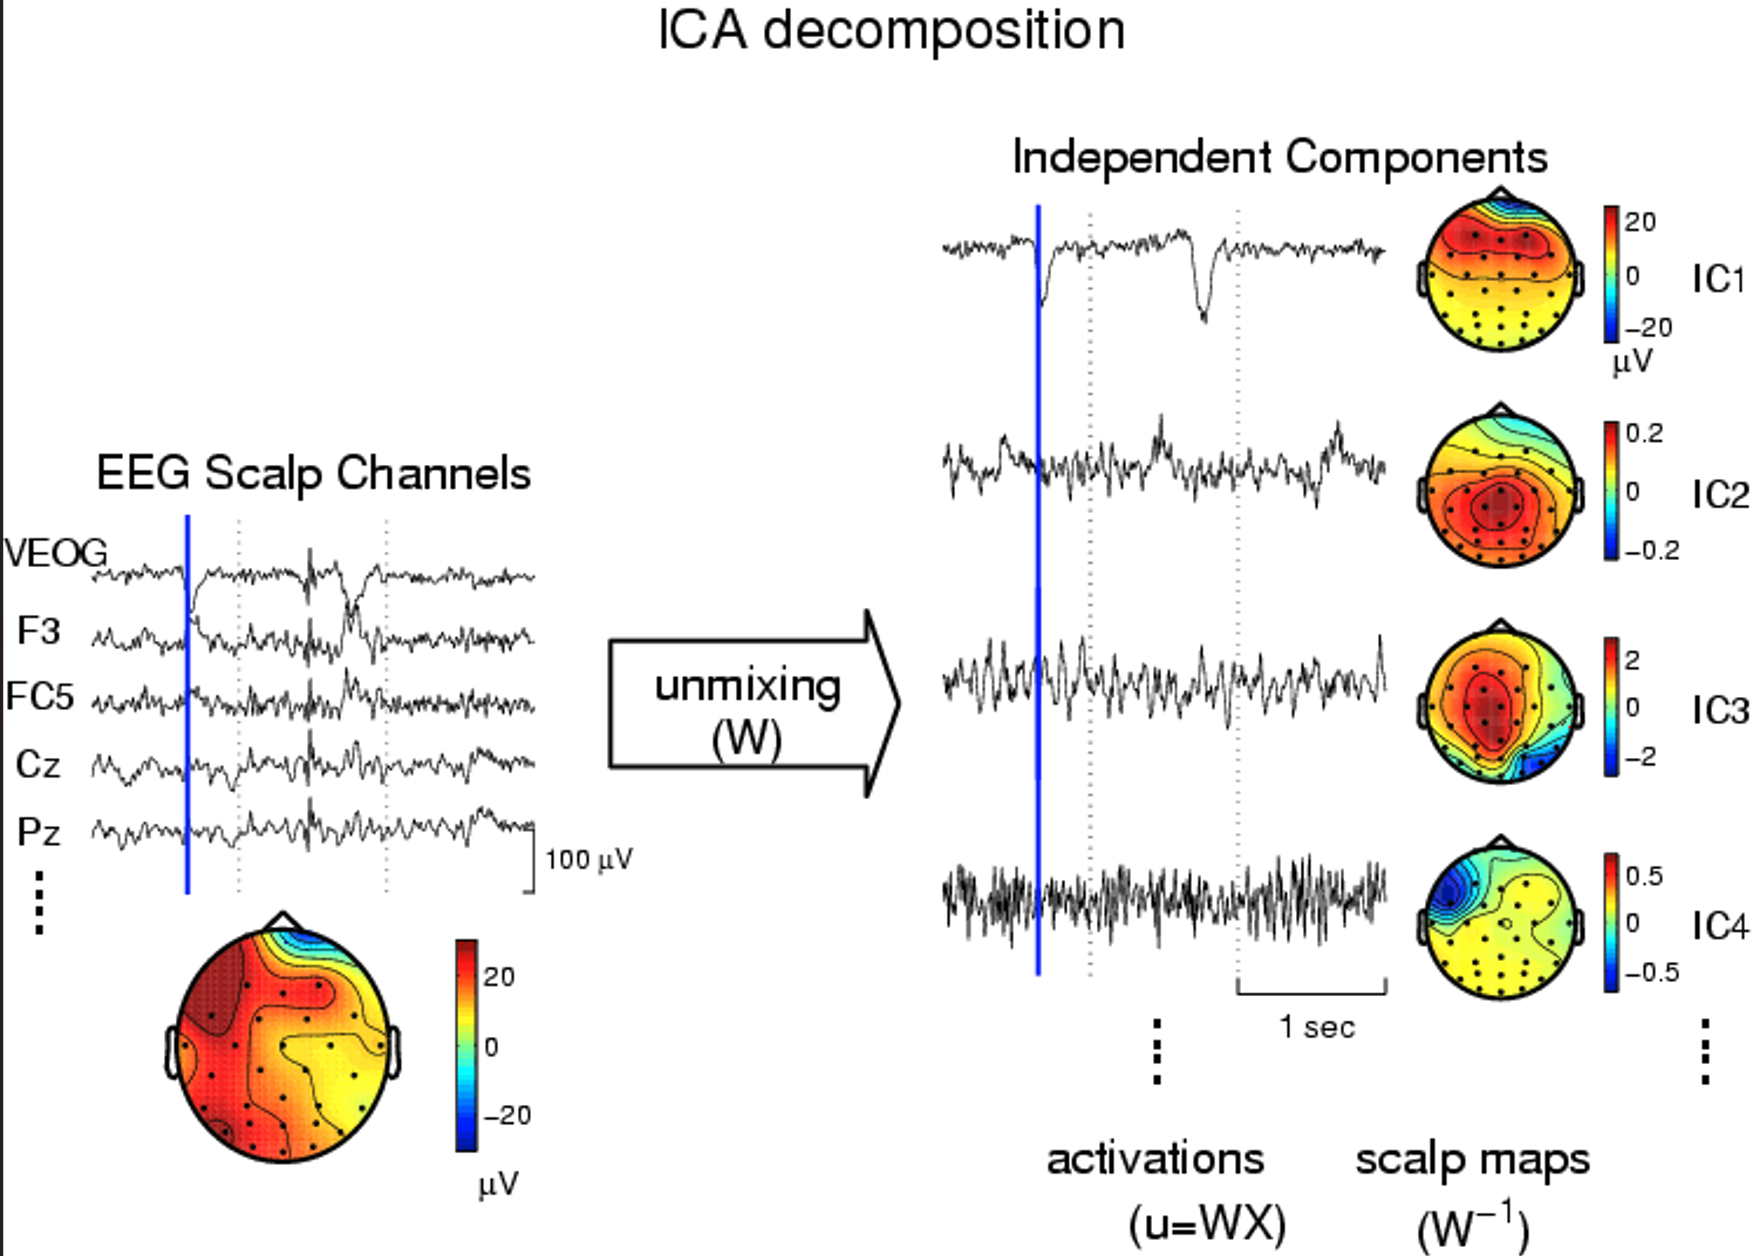


Natomiast ICA nie będzie klasyfikowało jedynie źródła mózgowe - ponieważ liczy się tutaj tylko sygnał Elektrofizjologiczny! Oznacza to, że ruchy oczu, mięśni, bicie serca, a nawet otaczające badanego urządzenia elektryczne również mogą pojawić się jako niezależne komponenty! --> trzeba w takim razie móc je skutecznie odfiltrowywać.

Istnieją pewne konkretne metody by wykonywać tą operację automatycznie, jednak szczególnie w badaniach, gdzie wymagana jest duża ilość komponentów - dalsze analizy ICA bedą dawały komponenty niezbyt wyraźne i mało konkretne: odróżnienie tego typu komponentów, dokonuje się więc najczęściej manualnie - co jest neizwykle żmudne i czasochłonne. Prócz tego, odróżnienie komponentów mózgowych od artefaktów jest Ekstremalnie trudne i wymaga wprawy - szacuje się, że nawet doświadczony ekspert może osiągnąć skuteczność maksymalnie 90%

Dlatego właśnie w tym projekcie chciałbym zeksplorować, czy możliwe jest zautomatyzowanie procesu przez zastosowanie modeli uczenia maszynowego zarówno dla danych korelacyjnych jak i danych topograficznych i czy da się to wykorzystać w praktyce?
'

zbiór danych który jest tutaj rozważany pochodzi ze zbiorów Instytutu Psychologii. Zawiera on podział na testwoe i treningowe zbiory zawierające obrazki, zalabelowane jako rozkład topograficzny aktywności elektrofizjologicznej dla sygnałów pochodzących z mózgu, oraz tych które z mózgu nie pochodzą.

Mamy tez zbiory testowe i treningowe z danych korelacyjnych, które kojarzą, dany komponent wydzielony przez Analizę ICA, z  z amplitudą, częstotliwością, fazą itp. sygnału z elektrod referencyjnych - to znaczy umieszczonych na Mastoidach (uszy) oraz w okół oczu (EOG) lub serca (EKG) - Korelacje te, będą informowały o występowaniu artefaktów.

## Inferencja Mózgowych komponentów z danych korelacyjnych 

### Ładowanie danych 

Pliki z danymi korelacyjnymi są przechowywane w formie struktur **.mat** - mogą one być problematyczne do odczytania. Do tego, dane dla każdej osoby sa osobno przechowywane: potrzebujemy więc Customowego ładowania 

ładownie plików mat dzieje się przez bibliotekę **mat4py**, to prosta biblioteka która ładuje pliki **mat** do słownika - opiera swoje działanie na h5py oraz numpy. 

Interesują nas zmienne zapisane w wektorach, to znaczy 
+ **Elc_power_core** - Korelacja mocy (amplitudy) naszego sygnału z mocą elektrod referencyjnych (zarówno ocznych jak i masstoidowych) 
+ **Elc_spectrum_corr**- Korelacja spektrum naszego sygnału ze spektrum elektrod referencyjnych (zarówno ocznych jak i masstoidowych) 
+ **Kurtosis**- Kurtoza zapisu Elektrofizjologicznego: Duża, powinna świadczyć o artefaktach
+ **Spect_flat**- Spektrum częstotliwościowe sygnału dla danego komponentu - Przez porównanie z brązowym szumem, może świadczyć o zaszumieniu i potencjalnej artefaktowści naszego sygnału
+ **Spect_one_over_f**- Miara analogiczna 
+ **elc_signal_corr**- Korelacja naszego sygnału elektrofizjologicznego z elektrodami referencyjnymi (zarówno ocznych jak i masstoidowych) 
+ **Y** - Target, określa czy komponent ICA pochodzi z mózgu czy też nie



In [30]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
!pip install mat4py

import mat4py



path = r'.\Data\Categorical_data\Cat_data.mat'
data = loadmat(path)
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Jun  5 21:04:31 2022',
 '__version__': '1.0',
 '__globals__': [],
 'Elc_power_core': array([[ 4.52676578],
        [ 4.37887548],
        [ 0.91510206],
        ...,
        [-0.42353748],
        [-0.25556756],
        [ 4.91048595]]),
 'Elc_spectrum_corr': array([[ 1.0928423 ],
        [ 1.07813647],
        [-0.41005008],
        ...,
        [ 0.65058311],
        [ 0.55955115],
        [ 0.96145656]]),
 'Kurtosis': array([[ 1.69228073],
        [ 0.27623607],
        [-0.19667112],
        ...,
        [ 0.14594967],
        [ 0.84518311],
        [-0.03987032]]),
 'Spect_flat': array([[ 4.50574635],
        [ 1.4191207 ],
        [-0.41444   ],
        ...,
        [ 0.73312987],
        [-0.40405524],
        [ 3.33068112]]),
 'Spect_one_over_f': array([[ 0.38304087],
        [ 0.6381942 ],
        [-2.47987478],
        ...,
        [ 0.39534112],
        [ 0.26541815],
        [ 0.50182401]]),
 'Y': array

In [31]:
list_of_variables = [data[i] for i in list(data.keys())[3:-2]]

for i in range(len(list_of_variables)-1):
    data_df = np.hstack((list_of_variables[i],list_of_variables[i+1].reshape(data['Elc_power_core'].shape)))
    list_of_variables[i+1] = data_df
    
data_df = list_of_variables[-1]
df_cat_data = pd.DataFrame(data_df,columns=list(data.keys())[3:-2])
df_cat_data

Elc_power_core  Elc_spectrum_corr  Kurtosis  Spect_flat  \
0           4.526766           1.092842  1.692281    4.505746   
1           4.378875           1.078136  0.276236    1.419121   
2           0.915102          -0.410050 -0.196671   -0.414440   
3           0.897985           0.918699 -0.170015   -0.151572   
4           2.318681           0.866184 -0.362367   -0.356178   
...              ...                ...       ...         ...   
1419       -0.315888          -2.344171 -0.254116   -1.043731   
1420       -0.396908           0.632625  1.069904    1.662334   
1421       -0.423537           0.650583  0.145950    0.733130   
1422       -0.255568           0.559551  0.845183   -0.404055   
1423        4.910486           0.961457 -0.039870    3.330681   

      Spect_one_over_f    Y  elc_signal_corr  
0             0.383041  0.0         4.812877  
1             0.638194  0.0         4.589973  
2            -2.479875  0.0         0.930902  
3             0.580709  1.0         1.889247  
4             0.216521  1.0         0.632152  
...                ...  ...              ...  
1419         -0.926009  1.0        -0.260976  
1420          0.380299  1.0        -0.505903  
1421          0.395341  1.0        -0.527208  
1422          0.265418  1.0        -0.308661  
1423          0.501824  0.0         4.838424  

[1424 rows x 7 columns]

In [32]:
data_df.shape

(1424, 7)

### Wizualizacja Danych



#### Korelacje zmiennych

Widać, że w większości przypadków zmienne mnie są ze sobą bardzo skorelowane. Jedynym wyjątkiemn jest para **elc_signal_corr** oraz **Elc_power_core**, które są niezwykle silnie skorelowane (0.93) są to współczynniki korelacji mocy, oraz samego sygnału dla poszczegółnego komponentu. Oba komponenty są fizycznie bardzo związane, także korelacja tutaj nie powinna dziwić.

Innymi słowy, gdyby model cierpiał na niedokładność wynikajacą z nadmiaru wymiarowości, można opuścić którąś z tych zmiennych



<AxesSubplot:>

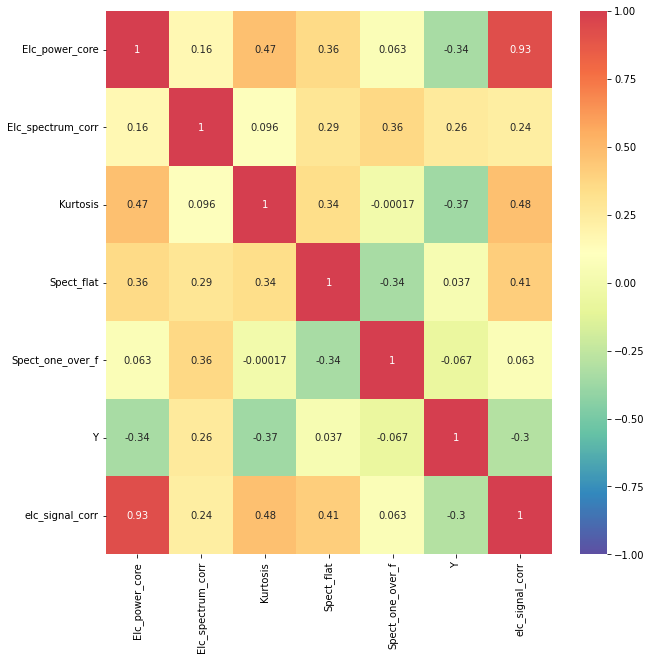

In [33]:
import seaborn as sns
from matplotlib import cm

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
rainbow = cm.get_cmap('Spectral', 512).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.0, 0.9, 512)))
newcmp




plt.figure(figsize=(10,10))
sns.heatmap(df_cat_data.corr(),annot=True,cmap=newcmp,vmin=-1,vmax=1)


#### Rozkłady poszczególnych zmiennych

Można zauważyć, że poszczególne zmienne mają kształt prawie gaussowski,  skoncetnrowany w okół zera zazwyczaj jednak ich ogony są przesunięte w jedną lub drugą stronę.

Możemy jednak już teraz zauważyć niezbalansowanie klas w przypadku zmiennej Y - czyli naszego targetu

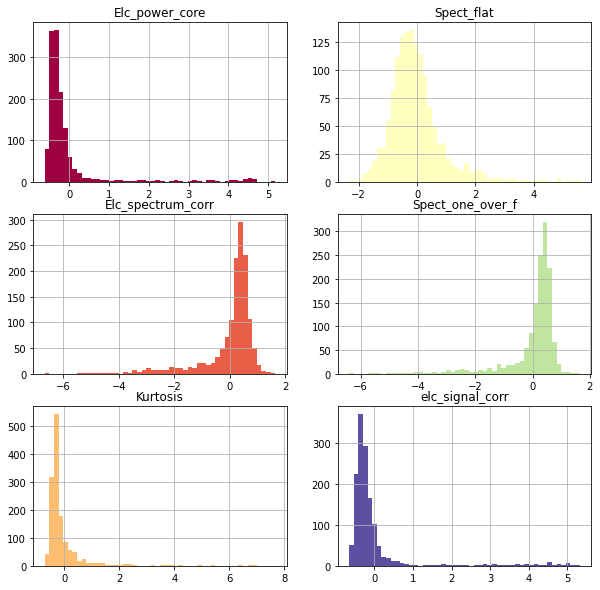

In [34]:
from matplotlib import cm

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridisBig = cm.get_cmap('Spectral', 7)
newcmp = ListedColormap(viridisBig(np.linspace(0.1, 0.9, 7)))
newcmp

x_count =0
y_count = 0
fig,axs = plt.subplots(3,2, figsize=(10,10))
for i,c in zip(df_cat_data.columns,newcmp.colors):
    if i != 'Y':
        bins = 50

        if x_count ==3:
            x_count = 0;
            y_count+=1
        axs[x_count,y_count].set_title('{}'.format(i))
        axs[x_count,y_count].grid()
 

        axs[x_count,y_count].hist(df_cat_data[i],color=c,bins=bins,histtype='stepfilled')
        x_count  +=1


In [35]:
columns = list(df_cat_data.columns)
y = df_cat_data[columns.pop(columns.index('Y'))]
X = df_cat_data[columns]
X

Elc_power_core  Elc_spectrum_corr  Kurtosis  Spect_flat  \
0           4.526766           1.092842  1.692281    4.505746   
1           4.378875           1.078136  0.276236    1.419121   
2           0.915102          -0.410050 -0.196671   -0.414440   
3           0.897985           0.918699 -0.170015   -0.151572   
4           2.318681           0.866184 -0.362367   -0.356178   
...              ...                ...       ...         ...   
1419       -0.315888          -2.344171 -0.254116   -1.043731   
1420       -0.396908           0.632625  1.069904    1.662334   
1421       -0.423537           0.650583  0.145950    0.733130   
1422       -0.255568           0.559551  0.845183   -0.404055   
1423        4.910486           0.961457 -0.039870    3.330681   

      Spect_one_over_f  elc_signal_corr  
0             0.383041         4.812877  
1             0.638194         4.589973  
2            -2.479875         0.930902  
3             0.580709         1.889247  
4             0.216521         0.632152  
...                ...              ...  
1419         -0.926009        -0.260976  
1420          0.380299        -0.505903  
1421          0.395341        -0.527208  
1422          0.265418        -0.308661  
1423          0.501824         4.838424  

[1424 rows x 6 columns]

#### Statystyki opisowe

Po statystykach opisowych można zobaczyć, że nie ma brakujących danych, oraz że wszystkie dane są już znormalizowane. Jest tak zapewne dlatego, że do wcześniejszych etapów analizy sygnału EEG podobne wartości musiały zostać już znormalizowane 

In [36]:
df_cat_data.describe()

Elc_power_core  Elc_spectrum_corr     Kurtosis   Spect_flat  \
count     1424.000000        1424.000000  1424.000000  1424.000000   
mean         0.003448           0.000675    -0.000028     0.002339   
std          0.999682           0.991504     0.991177     0.995099   
min         -0.615187          -6.668499    -0.710928    -2.326378   
25%         -0.408781          -0.065272    -0.376658    -0.581861   
50%         -0.301392           0.320280    -0.278876    -0.160632   
75%         -0.119815           0.518118    -0.065211     0.328101   
max          5.178304           1.648745     7.674776     5.568439   

       Spect_one_over_f            Y  elc_signal_corr  
count       1424.000000  1424.000000      1424.000000  
mean           0.000352     0.773174         0.003398  
std            0.991266     0.418926         0.999436  
min           -6.406491     0.000000        -0.656688  
25%           -0.013822     1.000000        -0.388645  
50%            0.312956     1.000000        -0.276072  
75%            0.499670     1.000000        -0.089999  
max            1.643076     1.000000         5.324390

### Oversampling 

Możemy jednak zauważyć, że mamy pewne niezbalansowanie klas i komppnentów Nie mózgowych jest niemalże 4-krotnie mniej niż mózgowych. By w takim razie taka dysproporcja nie zepsuła analizy, należy więc zrobić downsampling do takiej samej ilości.

In [37]:
w_class0 = np.where(y == 0)[0]
w_class1 = np.where(y == 1)[0]
np.random.seed(42)
w_class1_downsampled = np.random.choice(w_class1, size=len(w_class0), replace=False,)

y_downsampled = y.T[list(w_class1_downsampled)+list(w_class0)].T
X_downsampled = X.T[list(w_class1_downsampled)+list(w_class0)].T
X_downsampled

Elc_power_core  Elc_spectrum_corr  Kurtosis  Spect_flat  \
424        -0.383156           0.312425 -0.395376   -0.029378   
890        -0.418842           0.295604 -0.064847   -0.006035   
530        -0.398166           0.161468 -0.531966   -0.091394   
930        -0.265137          -0.694364 -0.263941    0.490605   
316        -0.447911           0.636122  0.219626    0.270384   
...              ...                ...       ...         ...   
1391       -0.350010          -2.075848 -0.331494   -0.856472   
1407       -0.285789          -1.890404  0.364231   -0.755692   
1409       -0.057344          -0.374161 -0.012187   -0.910260   
1412       -0.377814          -0.039221  0.424918   -0.797873   
1423        4.910486           0.961457 -0.039870    3.330681   

      Spect_one_over_f  elc_signal_corr  
424           0.194582        -0.332317  
890          -0.161848        -0.276742  
530          -0.137076        -0.025037  
930           0.111724        -0.526616  
316           0.408550        -0.433138  
...                ...              ...  
1391          0.523360        -0.476979  
1407          0.142771        -0.286163  
1409         -0.113822        -0.171705  
1412          0.372490        -0.084226  
1423          0.501824         4.838424  

[646 rows x 6 columns]

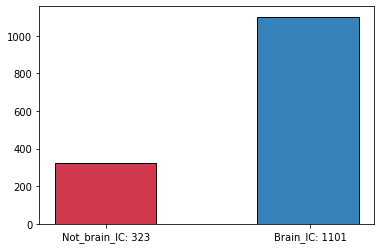

In [38]:

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

N, bins, patches = ax.hist(y, edgecolor='black', linewidth=1,bins=3)
rainbow = cm.get_cmap('Spectral', 12).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.1, 0.9, 12)))
newcmp
for i in range(0,1):
    patches[i].set_facecolor(newcmp.colors[-1])
for i in range(1,3):    
    patches[i].set_facecolor(newcmp.colors[0])

ax.set_xticks((0.17,0.84))
ax.set_xticklabels(['Not_brain_IC: {}'.format(len(w_class0)),'Brain_IC: {}'.format(len(w_class1))])

plt.show()


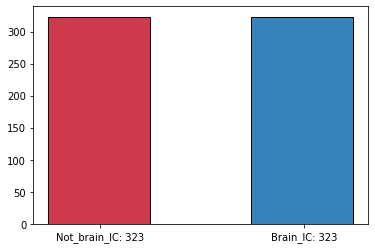

In [39]:

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

N, bins, patches = ax.hist(y_downsampled, edgecolor='black', linewidth=1,bins=3)
rainbow = cm.get_cmap('Spectral', 12).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.1, 0.9, 12)))
newcmp
for i in range(0,1):
    patches[i].set_facecolor(newcmp.colors[-1])
for i in range(1,3):    
    patches[i].set_facecolor(newcmp.colors[0])
    
ax.set_xticks((0.17,0.84))
ax.set_xticklabels(['Not_brain_IC: {}'.format(len( np.where(y_downsampled == 0)[0])),'Brain_IC: {}'.format(len(np.where(y_downsampled == 1)[0]))])

plt.show()


Teraz można spokojnie podzielić na zbiór treningowy i walidacyjny 

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_downsampled, y_downsampled, test_size=0.33, random_state=42)

### Uczenie i wybieranie modeli:

By nauczyć modele stwórzmy Pipeline normalizujący najpierw nasze dane (Na wselki wypadek), po czym elegancko Uczymy modele za pomocą Pipeline'ów następujące typy Klasyfikatorów:

+ **SVC - rbf**
+ **SVC - linear**
+ **Regresję logistyczną**
+ **Gradient Boosting**
+ **AdaBoost**
+ **Bagging Classifier**'
+ **RandoForest**
+ **Sieć neuronowa** 

Na każdym staramy się dopasować parametry na Gridzie do maksymalnie 4 parametrów. 

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


kfold = StratifiedKFold(5)


pipe_1 = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='rbf',probability=True))])
pipe_2 = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='linear',probability=True))])
pipe_3 = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression())])
pipe_4 = Pipeline([('preprocessing', StandardScaler()), ('classifier', GradientBoostingClassifier())])
pipe_5 = Pipeline([('preprocessing', StandardScaler()), ('classifier', AdaBoostClassifier(
                                                                                DecisionTreeClassifier(max_depth=1), 
                                                                                n_estimators=2, 
                                                                                learning_rate=0.5, 
                                                                                algorithm="SAMME.R", 
                                                                                random_state=42))])

pipe_6 = Pipeline([('preprocessing', StandardScaler()), ('classifier', BaggingClassifier(
                                                                                DecisionTreeClassifier(max_depth=1), 
                                                                             n_jobs=-1))])
pipe_7 = Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier(n_jobs=-1))])

param_grid = {
            'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}
param_grid_2 = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
param_grid_4 = {
            'classifier__n_estimators': [50,100,200,500],
            'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
            'classifier__max_depth': [3,9,18,36,None],
            'classifier__max_leaf_nodes': [4,8,16,32,64,None],

}

param_grid_6 = {
            'classifier__n_estimators': [50,100,200,500],
            'classifier__max_depth': [3,9,18,36],
            'classifier__max_leaf_nodes': [4,8,16,32,64],

}

param_grid_3 = {
            'classifier__n_estimators': [10,50,100,200,500],
            'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
            'classifier__base_estimator__max_depth': [3,9,18,36],
            'classifier__base_estimator__max_leaf_nodes': [4,8,16,32,64],

}

param_grid_5 = {
            'classifier__n_estimators': [50,100,200,500],
            'classifier__base_estimator__max_depth': [3,9,18,36],
            'classifier__base_estimator__max_leaf_nodes': [4,8,16,32,64],

}

grid_1 = GridSearchCV(pipe_1, param_grid, cv=kfold, return_train_score=True)
grid_2 = GridSearchCV(pipe_2, param_grid, cv=kfold, return_train_score=True)
grid_3 = GridSearchCV(pipe_3, param_grid_2, cv=kfold, return_train_score=True)
grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True,verbose=1)
grid_5 = GridSearchCV(pipe_5, param_grid_3, cv=kfold, return_train_score=True)
grid_6 = GridSearchCV(pipe_6, param_grid_5, cv=kfold, return_train_score=True)
grid_7 = GridSearchCV(pipe_7, param_grid_6, cv=kfold, return_train_score=True)


In [15]:
grid_1.fit(X_train, y_train)
grid_1.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', SVC(C=1, gamma=1, probability=True))])

In [16]:
grid_2.fit(X_train, y_train)
grid_2.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 SVC(C=10, gamma=0.001, kernel='linear', probability=True))])

In [17]:
grid_3.fit(X_train, y_train)
grid_3.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=10))])

In [18]:
grid_4.fit(X_train, y_train)
grid_4.best_estimator_

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', GradientBoostingClassifier(max_leaf_nodes=4))])

In [19]:
grid_5.fit(X_train, y_train)
grid_5.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                          max_leaf_nodes=4),
                                    learning_rate=0.01, n_estimators=500,
                                    random_state=42))])

In [20]:
grid_6.fit(X_train, y_train)
grid_6.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=9,
                                                                         max_leaf_nodes=32),
                                   n_estimators=100, n_jobs=-1))])

In [21]:
grid_7.fit(X_train, y_train)
grid_7.best_estimator_

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=36, max_leaf_nodes=16,
                                        n_jobs=-1))])

### najlepsze modele

Tutaj poniżej mamy Screen z najlepszymi zachowanymi modelami:

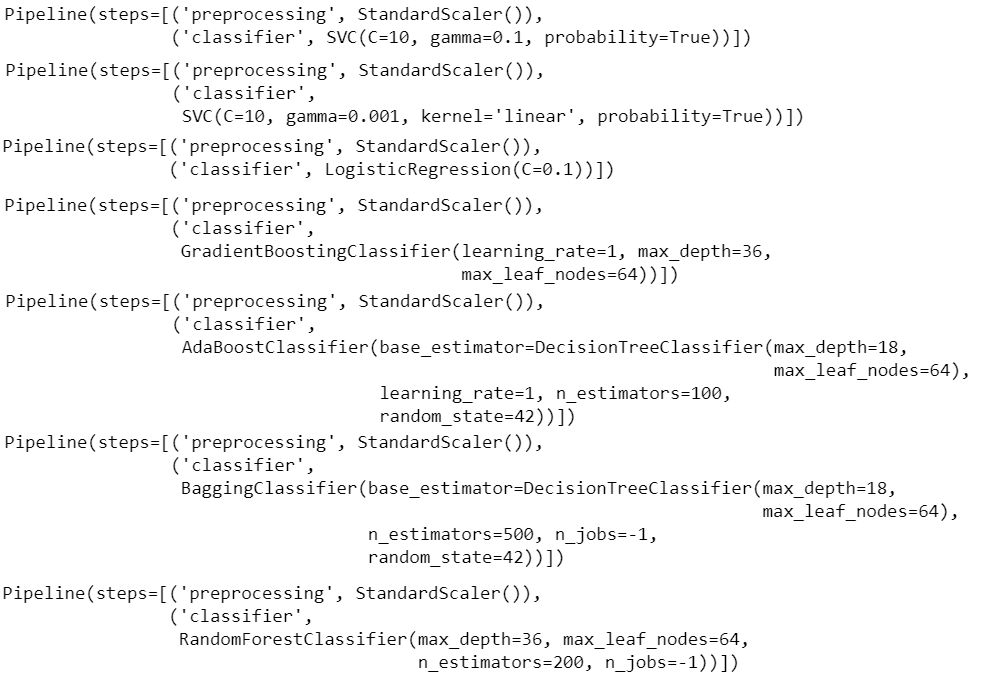

Poniżej, realizujemy te modele 

In [42]:
### Grid searched  Classifiers:


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier


model_1 =  Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='rbf',C=10,gamma=0.1,probability=True))])
model_2 =  Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='linear',C=10,gamma=0.001,probability=True))])
model_3 =  Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression(C=0.1))])
model_4 =  Pipeline([('preprocessing', StandardScaler()), ('classifier',  GradientBoostingClassifier(learning_rate=1, 
                                                                                                     max_depth=36,
                                                                                                     max_leaf_nodes=64))])
model_5 =  Pipeline([('preprocessing', StandardScaler()), ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=18,
                                                                                                                                  max_leaf_nodes=64),
                                                                                            learning_rate=1, 
                                                                                            n_estimators=100,
                                                                                            random_state=42))])
model_6 =  Pipeline([('preprocessing', StandardScaler()), ('classifier',  BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=18,
                                                                                                                                  max_leaf_nodes=64),
                                                                                            n_estimators=500, 
                                                                                            n_jobs=-1,
                                                                                            random_state=42))])
model_7 =  Pipeline([('preprocessing', StandardScaler()), ('classifier',  RandomForestClassifier(max_depth=36, max_leaf_nodes=64,
                                                                                                 n_estimators=200, n_jobs=-1))])
model_1.fit(X_train,y_train)
model_2.fit(X_train,y_train)
model_3.fit(X_train,y_train)
model_4.fit(X_train,y_train)
model_5.fit(X_train,y_train)
model_6.fit(X_train,y_train)
model_7.fit(X_train,y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=36, max_leaf_nodes=64,
                                        n_estimators=200, n_jobs=-1))])

In [43]:
from keras.regularizers import l1,l2
from keras.callbacks import History

from keras.layers import Dense,BatchNormalization,Flatten

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Activation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import History

#Scaling
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

history_Adam = History()

def build_model(Dense1=100,Dense2=50):
    model_cat = Sequential()
    model_cat.add(Dense(Dense1,activation="relu",input_shape=(X_train.shape[1],)))
    model_cat.add(BatchNormalization())
    model_cat.add(Activation("relu"))
    model_cat.add(Dense(Dense2,activation="relu"))
    model_cat.add(BatchNormalization())
    model_cat.add(Activation("relu"))

    model_cat.add(Dense(10,activation="relu"))
    model_cat.add(BatchNormalization())
    model_cat.add(Activation("relu"))
    model_cat.add(Dense(2,activation="relu"))
    model_cat.summary()

    model_cat.compile(loss="binary_crossentropy",optimizer="Rmsprop", metrics=["accuracy"])
    
    return model_cat

keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

param_distribs = {
    "Dense1": [25,50,100],
    "Dense2": [10,25,50]
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=10, verbose=2)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=150, mode='max', verbose=1,restore_best_weights=True)
rnd_search_cv.fit(X_train, y_train, validation_data= (sc.transform(X_val), y_val), batch_size=128,epochs=1000, callbacks=[history_Adam,early_stopping])


Fitting 10 folds for each of 9 candidates, totalling 90 fits
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_27 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 25)                0         
                                                                 
 dense_37 (Dense)            (None, 10)                260       
                                                                 
 batch_normalization_28 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                           

C:\Users\barak\AppData\Local\Temp\ipykernel_22372\2829582959.py:44: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
C:\Users\barak\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


4/4 [==============================] - 1s 59ms/step - loss: 5.9592 - accuracy: 0.6443 - val_loss: 4.6338 - val_accuracy: 0.6121
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 5.0329 - accuracy: 0.7294 - val_loss: 5.0528 - val_accuracy: 0.6916
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 5.0088 - accuracy: 0.7010 - val_loss: 4.8018 - val_accuracy: 0.7477
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.8473 - accuracy: 0.7036 - val_loss: 4.7967 - val_accuracy: 0.7523
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.7142 - accuracy: 0.7268 - val_loss: 5.0561 - val_accuracy: 0.7290
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.6574 - accuracy: 0.7294 - val_loss: 5.0142 - val_accuracy: 0.7243
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.5856 - accuracy: 0.7088 - val_loss: 5.1174 - val_accuracy: 0.7056
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8552 - accuracy: 0.6985 - val_loss: 1.8489 - val_accuracy: 0.7009
Epoch 60/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.9762 - accuracy: 0.7036 - val_loss: 1.8368 - val_accuracy: 0.6963
Epoch 61/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7323 - accuracy: 0.6804 - val_loss: 1.8172 - val_accuracy: 0.6963
Epoch 62/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3585 - accuracy: 0.6907 - val_loss: 1.7975 - val_accuracy: 0.6963
Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.5999 - accuracy: 0.6881 - val_loss: 1.7053 - val_accuracy: 0.6963
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4771 - accuracy: 0.6804 - val_loss: 1.6949 - val_accuracy: 0.6963
Epoch 65/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9747 - accuracy: 0.6753 - val_loss: 1.6746 - val_accuracy: 0.6963
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 1.2085 - accuracy: 0.6856 - val_loss: 1.3981 - val_accuracy: 0.6822
Epoch 117/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2717 - accuracy: 0.6778 - val_loss: 1.4030 - val_accuracy: 0.6822
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2101 - accuracy: 0.6959 - val_loss: 1.3928 - val_accuracy: 0.6869
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2106 - accuracy: 0.6804 - val_loss: 1.3897 - val_accuracy: 0.6822
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1856 - accuracy: 0.6830 - val_loss: 1.3701 - val_accuracy: 0.6822
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1130 - accuracy: 0.6933 - val_loss: 1.3698 - val_accuracy: 0.6822
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0774 - accuracy: 0.6778 - val_loss: 1.3892 - val_accuracy: 0.6869
Epoch 123/1000

4/4 [==============================] - 0s 13ms/step - loss: 2.8634 - accuracy: 0.4510 - val_loss: 4.5703 - val_accuracy: 0.6262
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7472 - accuracy: 0.4149 - val_loss: 3.8454 - val_accuracy: 0.6121
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7488 - accuracy: 0.4330 - val_loss: 3.3747 - val_accuracy: 0.6168
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3635 - accuracy: 0.4510 - val_loss: 2.9835 - val_accuracy: 0.6215
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.4635 - accuracy: 0.4485 - val_loss: 2.5800 - val_accuracy: 0.6262
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.3334 - accuracy: 0.4742 - val_loss: 2.2624 - val_accuracy: 0.6308
Epoch 9/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.2481 - accuracy: 0.4562 - val_loss: 2.0878 - val_accuracy: 0.6449
Epoch 10/1000
4/4 [=======

Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5855 - accuracy: 0.4665 - val_loss: 0.8759 - val_accuracy: 0.4159
Epoch 62/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5537 - accuracy: 0.4742 - val_loss: 0.8670 - val_accuracy: 0.4206
Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5465 - accuracy: 0.4742 - val_loss: 0.8541 - val_accuracy: 0.4299
Epoch 64/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6436 - accuracy: 0.4794 - val_loss: 0.8528 - val_accuracy: 0.4346
Epoch 65/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5704 - accuracy: 0.4665 - val_loss: 0.8497 - val_accuracy: 0.4346
Epoch 66/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5077 - accuracy: 0.4536 - val_loss: 0.8305 - val_accuracy: 0.4299
Epoch 67/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6682 - accuracy: 0.4845 - val_loss: 0.8272 - val_accuracy: 0.4299
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4564 - accuracy: 0.5206 - val_loss: 0.7614 - val_accuracy: 0.4626
Epoch 119/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4359 - accuracy: 0.5825 - val_loss: 0.7716 - val_accuracy: 0.4486
Epoch 120/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4453 - accuracy: 0.5155 - val_loss: 0.8449 - val_accuracy: 0.4299
Epoch 121/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4308 - accuracy: 0.5155 - val_loss: 0.8434 - val_accuracy: 0.4206
Epoch 122/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4380 - accuracy: 0.4974 - val_loss: 0.8400 - val_accuracy: 0.4299
Epoch 123/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5961 - accuracy: 0.4948 - val_loss: 0.8402 - val_accuracy: 0.4393
Epoch 124/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4828 - accuracy: 0.5284 - val_loss: 0.8407 - val_accuracy: 0.6542
Epoch 125/1000

Total params: 747
Trainable params: 657
Non-trainable params: 90
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 2s 57ms/step - loss: 4.6441 - accuracy: 0.4267 - val_loss: 1.5065 - val_accuracy: 0.5514
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.6332 - accuracy: 0.4576 - val_loss: 1.5454 - val_accuracy: 0.5047
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.4509 - accuracy: 0.4396 - val_loss: 1.5909 - val_accuracy: 0.4720
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.1751 - accuracy: 0.4447 - val_loss: 1.5970 - val_accuracy: 0.4393
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.0913 - accuracy: 0.4473 - val_loss: 1.6565 - val_accuracy: 0.3738
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8955 - accuracy: 0.4396 - val_loss: 1.6695 - val_accuracy: 0.3645
Epoch 7/1000
4/4 [=====

4/4 [==============================] - 0s 14ms/step - loss: 1.0606 - accuracy: 0.3856 - val_loss: 1.0146 - val_accuracy: 0.4486
Epoch 58/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9254 - accuracy: 0.3933 - val_loss: 1.0068 - val_accuracy: 0.4346
Epoch 59/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9181 - accuracy: 0.3599 - val_loss: 1.0051 - val_accuracy: 0.4346
Epoch 60/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8919 - accuracy: 0.3650 - val_loss: 0.9947 - val_accuracy: 0.4486
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8758 - accuracy: 0.3625 - val_loss: 0.9856 - val_accuracy: 0.4252
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8889 - accuracy: 0.3985 - val_loss: 0.9733 - val_accuracy: 0.4346
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8648 - accuracy: 0.3933 - val_loss: 0.9633 - val_accuracy: 0.4393
Epoch 64/1000
4/4 [=

Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6058 - accuracy: 0.5321 - val_loss: 0.6982 - val_accuracy: 0.4907
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6448 - accuracy: 0.5373 - val_loss: 0.7175 - val_accuracy: 0.5000
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6903 - accuracy: 0.5296 - val_loss: 0.6752 - val_accuracy: 0.5047
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6818 - accuracy: 0.5373 - val_loss: 0.6638 - val_accuracy: 0.5467
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6586 - accuracy: 0.5604 - val_loss: 0.6868 - val_accuracy: 0.5421
Epoch 120/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6554 - accuracy: 0.5476 - val_loss: 0.6572 - val_accuracy: 0.5561
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6550 - accuracy: 0.5835 - val_loss: 0.6461 - val_accuracy: 0.5327

4/4 [==============================] - 0s 13ms/step - loss: 0.4820 - accuracy: 0.5450 - val_loss: 0.7178 - val_accuracy: 0.5140
Epoch 173/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4707 - accuracy: 0.5296 - val_loss: 0.6895 - val_accuracy: 0.5280
Epoch 174/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5008 - accuracy: 0.5630 - val_loss: 0.7739 - val_accuracy: 0.5234
Epoch 175/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4778 - accuracy: 0.5476 - val_loss: 0.7404 - val_accuracy: 0.5234
Epoch 176/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4379 - accuracy: 0.5424 - val_loss: 0.7365 - val_accuracy: 0.5327
Epoch 177/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4988 - accuracy: 0.5450 - val_loss: 0.7144 - val_accuracy: 0.5514
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4553 - accuracy: 0.5373 - val_loss: 0.7030 - val_accuracy: 0.5234
Epoch 179/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.4295 - accuracy: 0.6941 - val_loss: 0.6952 - val_accuracy: 0.7009
Epoch 230/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4581 - accuracy: 0.6375 - val_loss: 0.6949 - val_accuracy: 0.6916
Epoch 231/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4767 - accuracy: 0.6607 - val_loss: 0.7463 - val_accuracy: 0.6729
Epoch 232/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4664 - accuracy: 0.6632 - val_loss: 0.7255 - val_accuracy: 0.6776
Epoch 233/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5219 - accuracy: 0.6452 - val_loss: 0.7428 - val_accuracy: 0.6729
Epoch 234/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4576 - accuracy: 0.6658 - val_loss: 0.7364 - val_accuracy: 0.6682
Epoch 235/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4425 - accuracy: 0.6710 - val_loss: 0.7315 - val_accuracy: 0.6636
Epoch 236/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4330 - accuracy: 0.5964 - val_loss: 0.6836 - val_accuracy: 0.4953
Epoch 287/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5137 - accuracy: 0.5810 - val_loss: 0.7035 - val_accuracy: 0.5093
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4508 - accuracy: 0.5887 - val_loss: 0.6795 - val_accuracy: 0.5374
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4206 - accuracy: 0.6093 - val_loss: 0.7042 - val_accuracy: 0.5234
Epoch 290/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4047 - accuracy: 0.5964 - val_loss: 0.7074 - val_accuracy: 0.5187
Epoch 291/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3994 - accuracy: 0.5604 - val_loss: 0.7161 - val_accuracy: 0.4907
Epoch 292/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4569 - accuracy: 0.5861 - val_loss: 0.6999 - val_accuracy: 0.5047
Epoch 293/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.3765 - accuracy: 0.5861 - val_loss: 0.8127 - val_accuracy: 0.5654
Epoch 344/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4020 - accuracy: 0.5604 - val_loss: 0.8123 - val_accuracy: 0.5607
Epoch 345/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3695 - accuracy: 0.5784 - val_loss: 0.8082 - val_accuracy: 0.5654
Epoch 346/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3852 - accuracy: 0.6195 - val_loss: 0.8283 - val_accuracy: 0.5888
Epoch 347/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3540 - accuracy: 0.6041 - val_loss: 0.8199 - val_accuracy: 0.5701
Epoch 348/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4222 - accuracy: 0.6015 - val_loss: 0.8161 - val_accuracy: 0.5888
Epoch 349/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.4832 - accuracy: 0.6015 - val_loss: 0.8107 - val_accuracy: 0.5888
Epoch 350/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3609 - accuracy: 0.6427 - val_loss: 0.8051 - val_accuracy: 0.6449
Epoch 401/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4390 - accuracy: 0.6298 - val_loss: 0.8033 - val_accuracy: 0.6449
Epoch 402/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3735 - accuracy: 0.6607 - val_loss: 0.8049 - val_accuracy: 0.6449
Epoch 403/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4182 - accuracy: 0.6298 - val_loss: 0.8073 - val_accuracy: 0.6308
Epoch 404/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4023 - accuracy: 0.6607 - val_loss: 0.8119 - val_accuracy: 0.6402
Epoch 405/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3842 - accuracy: 0.6247 - val_loss: 0.8290 - val_accuracy: 0.6075
Epoch 406/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3904 - accuracy: 0.5835 - val_loss: 0.8275 - val_accuracy: 0.6402
Epoch 407/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3574 - accuracy: 0.5964 - val_loss: 0.8007 - val_accuracy: 0.5841
Epoch 458/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3598 - accuracy: 0.5835 - val_loss: 0.8011 - val_accuracy: 0.5654
Epoch 459/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3639 - accuracy: 0.5476 - val_loss: 0.8186 - val_accuracy: 0.6215
Epoch 460/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3243 - accuracy: 0.6324 - val_loss: 0.8185 - val_accuracy: 0.6262
Epoch 461/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3412 - accuracy: 0.6015 - val_loss: 0.8208 - val_accuracy: 0.6589
Epoch 462/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3344 - accuracy: 0.6530 - val_loss: 0.8282 - val_accuracy: 0.6542
Epoch 463/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3301 - accuracy: 0.6401 - val_loss: 0.8302 - val_accuracy: 0.6262
Epoch 464/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3001 - accuracy: 0.5193 - val_loss: 0.9282 - val_accuracy: 0.5421
Epoch 515/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3605 - accuracy: 0.5321 - val_loss: 0.9321 - val_accuracy: 0.5374
Epoch 516/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3451 - accuracy: 0.5244 - val_loss: 1.0106 - val_accuracy: 0.5280
Epoch 516: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 0.5068 - accuracy: 0.7907
[CV] END ...............................Dense1=25, Dense2=10; total time=  25.6s
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_36 (Bat  (None, 25)               100       
 chNormalization)                        

Epoch 40/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6041 - accuracy: 0.4987 - val_loss: 1.3712 - val_accuracy: 0.5748
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6064 - accuracy: 0.4833 - val_loss: 1.3599 - val_accuracy: 0.5654
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6550 - accuracy: 0.4884 - val_loss: 1.3295 - val_accuracy: 0.5794
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5799 - accuracy: 0.5090 - val_loss: 1.3132 - val_accuracy: 0.5748
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5188 - accuracy: 0.4679 - val_loss: 1.2985 - val_accuracy: 0.5654
Epoch 45/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6166 - accuracy: 0.4833 - val_loss: 1.2949 - val_accuracy: 0.5654
Epoch 46/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5117 - accuracy: 0.4781 - val_loss: 1.2780 - val_accuracy: 0.5607
Epoch 

Epoch 98/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7939 - accuracy: 0.4422 - val_loss: 0.8269 - val_accuracy: 0.3645
Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7409 - accuracy: 0.4884 - val_loss: 0.7631 - val_accuracy: 0.3505
Epoch 100/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7746 - accuracy: 0.4396 - val_loss: 0.8154 - val_accuracy: 0.3598
Epoch 101/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.7634 - accuracy: 0.4807 - val_loss: 0.8202 - val_accuracy: 0.3551
Epoch 102/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.7702 - accuracy: 0.4344 - val_loss: 0.7311 - val_accuracy: 0.3692
Epoch 103/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.6860 - accuracy: 0.4396 - val_loss: 0.7391 - val_accuracy: 0.3645
Epoch 104/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.7649 - accuracy: 0.4370 - val_loss: 0.7816 - val_accuracy: 0.3645
E

4/4 [==============================] - 0s 11ms/step - loss: 0.4307 - accuracy: 0.5064 - val_loss: 0.7073 - val_accuracy: 0.4766
Epoch 156/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4190 - accuracy: 0.5219 - val_loss: 0.6715 - val_accuracy: 0.4766
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3918 - accuracy: 0.5476 - val_loss: 0.6754 - val_accuracy: 0.5187
Epoch 158/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4265 - accuracy: 0.5476 - val_loss: 0.7401 - val_accuracy: 0.5047
Epoch 159/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4027 - accuracy: 0.5398 - val_loss: 0.7976 - val_accuracy: 0.5093
Epoch 160/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4482 - accuracy: 0.5398 - val_loss: 0.7986 - val_accuracy: 0.5000
Epoch 161/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4494 - accuracy: 0.5476 - val_loss: 0.8210 - val_accuracy: 0.4486
Epoch 162/1000

2/2 [==============================] - 0s 3ms/step - loss: 0.9789 - accuracy: 0.4884
[CV] END ...............................Dense1=25, Dense2=10; total time=  11.5s
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_39 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_39 (Activation)  (None, 25)                0         
                                                                 
 dense_53 (Dense)            (None, 10)                260       
                                                                 
 batch_normalization_40 (Bat  (None, 10)               40        
 chNormalization)  

Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4295 - accuracy: 0.4524 - val_loss: 1.1971 - val_accuracy: 0.4579
Epoch 45/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5187 - accuracy: 0.4576 - val_loss: 1.1819 - val_accuracy: 0.4579
Epoch 46/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3844 - accuracy: 0.4396 - val_loss: 1.1621 - val_accuracy: 0.4533
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4035 - accuracy: 0.4627 - val_loss: 1.1552 - val_accuracy: 0.4486
Epoch 48/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4144 - accuracy: 0.4653 - val_loss: 1.1284 - val_accuracy: 0.4579
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2787 - accuracy: 0.4730 - val_loss: 1.1367 - val_accuracy: 0.4626
Epoch 50/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3589 - accuracy: 0.4499 - val_loss: 1.1603 - val_accuracy: 0.4579
Epoch 

Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8943 - accuracy: 0.4422 - val_loss: 0.7385 - val_accuracy: 0.3738
Epoch 103/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8317 - accuracy: 0.4344 - val_loss: 0.7381 - val_accuracy: 0.3785
Epoch 104/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8159 - accuracy: 0.4576 - val_loss: 0.7289 - val_accuracy: 0.3832
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8747 - accuracy: 0.4627 - val_loss: 0.7243 - val_accuracy: 0.3832
Epoch 106/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7880 - accuracy: 0.4370 - val_loss: 0.7311 - val_accuracy: 0.3832
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7944 - accuracy: 0.4473 - val_loss: 0.7242 - val_accuracy: 0.3832
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8027 - accuracy: 0.4422 - val_loss: 0.7281 - val_accuracy: 0.3692

                                                                 
 batch_normalization_42 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_42 (Activation)  (None, 25)                0         
                                                                 
 dense_57 (Dense)            (None, 10)                260       
                                                                 
 batch_normalization_43 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activation_43 (Activation)  (None, 10)                0         
                                                                 
 dense_58 (Dense)            (None, 10)                110       
                                                                 
 batch_nor

4/4 [==============================] - 0s 15ms/step - loss: 1.6827 - accuracy: 0.5656 - val_loss: 1.4461 - val_accuracy: 0.5000
Epoch 48/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.6692 - accuracy: 0.5527 - val_loss: 1.4205 - val_accuracy: 0.5000
Epoch 49/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6078 - accuracy: 0.5398 - val_loss: 1.3680 - val_accuracy: 0.5140
Epoch 50/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6537 - accuracy: 0.5424 - val_loss: 1.3529 - val_accuracy: 0.5140
Epoch 51/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5771 - accuracy: 0.5810 - val_loss: 1.3433 - val_accuracy: 0.5187
Epoch 52/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6633 - accuracy: 0.5913 - val_loss: 1.3281 - val_accuracy: 0.5187
Epoch 53/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5989 - accuracy: 0.5707 - val_loss: 1.3179 - val_accuracy: 0.5234
Epoch 54/1000
4/4 [=

Epoch 105/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1769 - accuracy: 0.6324 - val_loss: 1.1532 - val_accuracy: 0.6449
Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1216 - accuracy: 0.6375 - val_loss: 1.1763 - val_accuracy: 0.6542
Epoch 107/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1167 - accuracy: 0.6272 - val_loss: 1.1382 - val_accuracy: 0.6355
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1004 - accuracy: 0.6144 - val_loss: 1.1676 - val_accuracy: 0.6402
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0793 - accuracy: 0.6555 - val_loss: 1.1443 - val_accuracy: 0.6402
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1667 - accuracy: 0.6401 - val_loss: 1.1643 - val_accuracy: 0.6542
Epoch 111/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9984 - accuracy: 0.6684 - val_loss: 1.1601 - val_accuracy: 0.6589

4/4 [==============================] - 0s 12ms/step - loss: 0.8107 - accuracy: 0.6555 - val_loss: 0.9493 - val_accuracy: 0.6636
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6824 - accuracy: 0.6195 - val_loss: 0.9438 - val_accuracy: 0.6636
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6385 - accuracy: 0.6350 - val_loss: 0.9404 - val_accuracy: 0.6776
Epoch 165/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6881 - accuracy: 0.6221 - val_loss: 0.9439 - val_accuracy: 0.6636
Epoch 166/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6080 - accuracy: 0.6195 - val_loss: 0.9434 - val_accuracy: 0.6542
Epoch 167/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5824 - accuracy: 0.6247 - val_loss: 0.9131 - val_accuracy: 0.6636
Epoch 168/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6183 - accuracy: 0.6272 - val_loss: 0.9101 - val_accuracy: 0.6542
Epoch 169/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.4536 - accuracy: 0.6195 - val_loss: 0.6859 - val_accuracy: 0.6308
Epoch 220/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4394 - accuracy: 0.6144 - val_loss: 0.6880 - val_accuracy: 0.6308
Epoch 221/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5163 - accuracy: 0.6015 - val_loss: 0.6893 - val_accuracy: 0.6308
Epoch 222/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4641 - accuracy: 0.6067 - val_loss: 0.6876 - val_accuracy: 0.6355
Epoch 223/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4802 - accuracy: 0.6221 - val_loss: 0.6861 - val_accuracy: 0.6449
Epoch 224/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4291 - accuracy: 0.6401 - val_loss: 0.7139 - val_accuracy: 0.6682
Epoch 225/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5045 - accuracy: 0.6452 - val_loss: 0.7152 - val_accuracy: 0.6822
Epoch 226/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4433 - accuracy: 0.6452 - val_loss: 0.6783 - val_accuracy: 0.6589
Epoch 277/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3917 - accuracy: 0.6247 - val_loss: 0.6742 - val_accuracy: 0.6495
Epoch 278/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4901 - accuracy: 0.6195 - val_loss: 0.6097 - val_accuracy: 0.6776
Epoch 279/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4267 - accuracy: 0.6452 - val_loss: 0.6432 - val_accuracy: 0.6822
Epoch 280/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3842 - accuracy: 0.6375 - val_loss: 0.6682 - val_accuracy: 0.6822
Epoch 281/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4065 - accuracy: 0.6478 - val_loss: 0.6679 - val_accuracy: 0.6916
Epoch 282/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4496 - accuracy: 0.6401 - val_loss: 0.7049 - val_accuracy: 0.6869
Epoch 283/1000

Epoch 16/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0609 - accuracy: 0.6221 - val_loss: 2.1190 - val_accuracy: 0.6542
Epoch 17/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9303 - accuracy: 0.6581 - val_loss: 2.0887 - val_accuracy: 0.6495
Epoch 18/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0265 - accuracy: 0.7326 - val_loss: 2.0631 - val_accuracy: 0.6449
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9232 - accuracy: 0.7301 - val_loss: 2.0482 - val_accuracy: 0.6355
Epoch 20/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8746 - accuracy: 0.6118 - val_loss: 1.9963 - val_accuracy: 0.6449
Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9106 - accuracy: 0.6504 - val_loss: 1.9511 - val_accuracy: 0.6869
Epoch 22/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7908 - accuracy: 0.6452 - val_loss: 1.8834 - val_accuracy: 0.6963
Epoch 

Epoch 74/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0744 - accuracy: 0.6838 - val_loss: 1.1117 - val_accuracy: 0.7103
Epoch 75/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9301 - accuracy: 0.7018 - val_loss: 1.1011 - val_accuracy: 0.6963
Epoch 76/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0404 - accuracy: 0.7069 - val_loss: 1.0823 - val_accuracy: 0.6963
Epoch 77/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0493 - accuracy: 0.6967 - val_loss: 1.0812 - val_accuracy: 0.7009
Epoch 78/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0015 - accuracy: 0.7069 - val_loss: 1.0394 - val_accuracy: 0.6682
Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0883 - accuracy: 0.6735 - val_loss: 1.0672 - val_accuracy: 0.6682
Epoch 80/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9494 - accuracy: 0.6864 - val_loss: 1.0357 - val_accuracy: 0.6869
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.6971 - accuracy: 0.7429 - val_loss: 0.9979 - val_accuracy: 0.7617
Epoch 132/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6789 - accuracy: 0.7172 - val_loss: 0.9409 - val_accuracy: 0.7523
Epoch 133/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6241 - accuracy: 0.7018 - val_loss: 0.9347 - val_accuracy: 0.7009
Epoch 134/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6510 - accuracy: 0.6941 - val_loss: 0.9157 - val_accuracy: 0.7056
Epoch 135/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6394 - accuracy: 0.6710 - val_loss: 0.9398 - val_accuracy: 0.7150
Epoch 136/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6979 - accuracy: 0.6632 - val_loss: 0.9603 - val_accuracy: 0.7150
Epoch 137/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5687 - accuracy: 0.7069 - val_loss: 0.9679 - val_accuracy: 0.7196
Epoch 138/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.5468 - accuracy: 0.7301 - val_loss: 0.9480 - val_accuracy: 0.7196
Epoch 189/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5054 - accuracy: 0.7249 - val_loss: 0.8865 - val_accuracy: 0.7243
Epoch 190/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5344 - accuracy: 0.7018 - val_loss: 0.8962 - val_accuracy: 0.7243
Epoch 191/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5238 - accuracy: 0.7018 - val_loss: 0.9106 - val_accuracy: 0.7196
Epoch 192/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4972 - accuracy: 0.7069 - val_loss: 0.9124 - val_accuracy: 0.7290
Epoch 193/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5863 - accuracy: 0.7249 - val_loss: 0.9150 - val_accuracy: 0.7383
Epoch 194/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4674 - accuracy: 0.7686 - val_loss: 0.9127 - val_accuracy: 0.7336
Epoch 195/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.5161 - accuracy: 0.7789 - val_loss: 0.8974 - val_accuracy: 0.7383
Epoch 246/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5033 - accuracy: 0.7943 - val_loss: 0.8682 - val_accuracy: 0.7383
Epoch 247/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4440 - accuracy: 0.7866 - val_loss: 0.8942 - val_accuracy: 0.7383
Epoch 248/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4976 - accuracy: 0.7789 - val_loss: 0.8925 - val_accuracy: 0.7383
Epoch 249/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5184 - accuracy: 0.8098 - val_loss: 0.8917 - val_accuracy: 0.7523
Epoch 250/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4608 - accuracy: 0.7789 - val_loss: 0.8895 - val_accuracy: 0.7523
Epoch 251/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4665 - accuracy: 0.7789 - val_loss: 0.8618 - val_accuracy: 0.7430
Epoch 252/1000

Epoch 20/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.4115 - accuracy: 0.5116 - val_loss: 2.1076 - val_accuracy: 0.5140
Epoch 21/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3804 - accuracy: 0.5167 - val_loss: 2.0774 - val_accuracy: 0.5047
Epoch 22/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3355 - accuracy: 0.4987 - val_loss: 1.9943 - val_accuracy: 0.5047
Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3239 - accuracy: 0.5193 - val_loss: 1.9467 - val_accuracy: 0.5093
Epoch 24/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3566 - accuracy: 0.5193 - val_loss: 1.8281 - val_accuracy: 0.5093
Epoch 25/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3011 - accuracy: 0.5116 - val_loss: 1.8262 - val_accuracy: 0.5093
Epoch 26/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2453 - accuracy: 0.5167 - val_loss: 1.8004 - val_accuracy: 0.5093
Epoch 

Epoch 78/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1108 - accuracy: 0.6607 - val_loss: 0.8918 - val_accuracy: 0.6262
Epoch 79/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1327 - accuracy: 0.6684 - val_loss: 0.8599 - val_accuracy: 0.6121
Epoch 80/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0948 - accuracy: 0.6504 - val_loss: 0.8611 - val_accuracy: 0.6308
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1932 - accuracy: 0.6607 - val_loss: 0.8613 - val_accuracy: 0.6262
Epoch 82/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0472 - accuracy: 0.6710 - val_loss: 0.8111 - val_accuracy: 0.6355
Epoch 83/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0129 - accuracy: 0.6735 - val_loss: 0.8072 - val_accuracy: 0.6262
Epoch 84/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0443 - accuracy: 0.6632 - val_loss: 0.8002 - val_accuracy: 0.6308
Epoch 

4/4 [==============================] - 0s 14ms/step - loss: 0.5520 - accuracy: 0.7892 - val_loss: 0.6536 - val_accuracy: 0.7383
Epoch 136/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5645 - accuracy: 0.8046 - val_loss: 0.6761 - val_accuracy: 0.7523
Epoch 137/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5710 - accuracy: 0.7635 - val_loss: 0.6774 - val_accuracy: 0.7477
Epoch 138/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5275 - accuracy: 0.7892 - val_loss: 0.5746 - val_accuracy: 0.7523
Epoch 139/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5842 - accuracy: 0.7789 - val_loss: 0.5730 - val_accuracy: 0.7523
Epoch 140/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5490 - accuracy: 0.7635 - val_loss: 0.5755 - val_accuracy: 0.7477
Epoch 141/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5474 - accuracy: 0.7943 - val_loss: 0.5494 - val_accuracy: 0.7570
Epoch 142/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3897 - accuracy: 0.8329 - val_loss: 0.5456 - val_accuracy: 0.7477
Epoch 193/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4424 - accuracy: 0.8278 - val_loss: 0.5130 - val_accuracy: 0.7383
Epoch 194/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4142 - accuracy: 0.8355 - val_loss: 0.5386 - val_accuracy: 0.7570
Epoch 195/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3740 - accuracy: 0.8329 - val_loss: 0.5417 - val_accuracy: 0.7430
Epoch 196/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3942 - accuracy: 0.8278 - val_loss: 0.5459 - val_accuracy: 0.7336
Epoch 197/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4104 - accuracy: 0.8329 - val_loss: 0.6882 - val_accuracy: 0.7150
Epoch 198/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4155 - accuracy: 0.8175 - val_loss: 0.6845 - val_accuracy: 0.7243
Epoch 199/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3609 - accuracy: 0.8252 - val_loss: 0.5974 - val_accuracy: 0.7336
Epoch 250/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3969 - accuracy: 0.8278 - val_loss: 0.6025 - val_accuracy: 0.7383
Epoch 251/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4037 - accuracy: 0.8406 - val_loss: 0.6051 - val_accuracy: 0.7336
Epoch 252/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3671 - accuracy: 0.8098 - val_loss: 0.6333 - val_accuracy: 0.7290
Epoch 253/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3878 - accuracy: 0.8278 - val_loss: 0.6784 - val_accuracy: 0.7150
Epoch 254/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3747 - accuracy: 0.8046 - val_loss: 0.6750 - val_accuracy: 0.7196
Epoch 255/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3575 - accuracy: 0.8226 - val_loss: 0.6989 - val_accuracy: 0.7243
Epoch 256/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3772 - accuracy: 0.7789 - val_loss: 0.7191 - val_accuracy: 0.6869
Epoch 307/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3652 - accuracy: 0.7943 - val_loss: 0.7494 - val_accuracy: 0.6682
Epoch 308/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3712 - accuracy: 0.7866 - val_loss: 0.7861 - val_accuracy: 0.6636
Epoch 308: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 0.9104 - accuracy: 0.6977
[CV] END ...............................Dense1=25, Dense2=10; total time=  15.7s
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 25)                175       
                                                                 
 batch_normalization_51 (Bat  (None, 25)               100       
 chNormalization)                        

Epoch 40/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2213 - accuracy: 0.6838 - val_loss: 1.5829 - val_accuracy: 0.6355
Epoch 41/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9668 - accuracy: 0.6581 - val_loss: 1.5754 - val_accuracy: 0.6262
Epoch 42/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9847 - accuracy: 0.6864 - val_loss: 1.5735 - val_accuracy: 0.6215
Epoch 43/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9601 - accuracy: 0.6658 - val_loss: 1.5681 - val_accuracy: 0.6215
Epoch 44/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9264 - accuracy: 0.6735 - val_loss: 1.5617 - val_accuracy: 0.6355
Epoch 45/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8221 - accuracy: 0.6838 - val_loss: 1.5491 - val_accuracy: 0.6308
Epoch 46/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8676 - accuracy: 0.6761 - val_loss: 1.5703 - val_accuracy: 0.6355
Epoch 

Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9594 - accuracy: 0.6015 - val_loss: 0.8402 - val_accuracy: 0.5981
Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9360 - accuracy: 0.5810 - val_loss: 0.8383 - val_accuracy: 0.6028
Epoch 100/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9164 - accuracy: 0.6067 - val_loss: 0.8365 - val_accuracy: 0.6028
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9727 - accuracy: 0.5887 - val_loss: 0.8370 - val_accuracy: 0.6028
Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8922 - accuracy: 0.5938 - val_loss: 0.8593 - val_accuracy: 0.6028
Epoch 103/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9082 - accuracy: 0.6067 - val_loss: 0.8601 - val_accuracy: 0.6028
Epoch 104/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9376 - accuracy: 0.5990 - val_loss: 0.8637 - val_accuracy: 0.6028
E

4/4 [==============================] - 0s 12ms/step - loss: 0.5506 - accuracy: 0.6350 - val_loss: 1.2326 - val_accuracy: 0.5935
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5762 - accuracy: 0.6067 - val_loss: 1.2273 - val_accuracy: 0.5794
Epoch 157/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5590 - accuracy: 0.6247 - val_loss: 1.1190 - val_accuracy: 0.5748
Epoch 158/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5486 - accuracy: 0.6221 - val_loss: 1.1436 - val_accuracy: 0.5701
Epoch 159/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5680 - accuracy: 0.5784 - val_loss: 1.1416 - val_accuracy: 0.5561
Epoch 160/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5738 - accuracy: 0.6067 - val_loss: 1.0273 - val_accuracy: 0.5888
Epoch 160: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 2.6501 - accuracy: 0.7907
[CV] END ...............................Dense1

Epoch 37/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8594 - accuracy: 0.5733 - val_loss: 1.2284 - val_accuracy: 0.4486
Epoch 38/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9206 - accuracy: 0.5733 - val_loss: 1.2013 - val_accuracy: 0.4486
Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8927 - accuracy: 0.5784 - val_loss: 1.1900 - val_accuracy: 0.4486
Epoch 40/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8600 - accuracy: 0.5861 - val_loss: 1.1919 - val_accuracy: 0.4486
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8106 - accuracy: 0.5707 - val_loss: 1.1268 - val_accuracy: 0.4486
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8279 - accuracy: 0.5887 - val_loss: 1.1065 - val_accuracy: 0.4486
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8793 - accuracy: 0.5527 - val_loss: 1.0917 - val_accuracy: 0.4393
Epoch 

Epoch 95/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5337 - accuracy: 0.5707 - val_loss: 0.5828 - val_accuracy: 0.5467
Epoch 96/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4770 - accuracy: 0.6118 - val_loss: 0.5774 - val_accuracy: 0.5794
Epoch 97/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5854 - accuracy: 0.5810 - val_loss: 0.5840 - val_accuracy: 0.5514
Epoch 98/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4464 - accuracy: 0.5990 - val_loss: 0.5861 - val_accuracy: 0.5187
Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4721 - accuracy: 0.5707 - val_loss: 0.5837 - val_accuracy: 0.5421
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6047 - accuracy: 0.5707 - val_loss: 0.5928 - val_accuracy: 0.5421
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5721 - accuracy: 0.5964 - val_loss: 0.5931 - val_accuracy: 0.5327
Epoc

4/4 [==============================] - 0s 12ms/step - loss: 0.4249 - accuracy: 0.5835 - val_loss: 0.8670 - val_accuracy: 0.6075
Epoch 153/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4159 - accuracy: 0.5681 - val_loss: 0.9048 - val_accuracy: 0.5841
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3784 - accuracy: 0.5887 - val_loss: 0.8519 - val_accuracy: 0.5981
Epoch 155/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4144 - accuracy: 0.5656 - val_loss: 0.9173 - val_accuracy: 0.5935
Epoch 156/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4496 - accuracy: 0.5707 - val_loss: 0.8624 - val_accuracy: 0.5935
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5225 - accuracy: 0.5835 - val_loss: 0.7763 - val_accuracy: 0.5935
Epoch 158/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4275 - accuracy: 0.5990 - val_loss: 0.7958 - val_accuracy: 0.5981
Epoch 159/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.4246 - accuracy: 0.5398 - val_loss: 1.1003 - val_accuracy: 0.5794
Epoch 210/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3846 - accuracy: 0.5913 - val_loss: 1.1018 - val_accuracy: 0.5841
Epoch 211/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3999 - accuracy: 0.5707 - val_loss: 1.1034 - val_accuracy: 0.5935
Epoch 212/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3517 - accuracy: 0.5527 - val_loss: 0.9742 - val_accuracy: 0.5701
Epoch 213/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3631 - accuracy: 0.5553 - val_loss: 0.9988 - val_accuracy: 0.5561
Epoch 214/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3675 - accuracy: 0.5630 - val_loss: 0.9303 - val_accuracy: 0.5327
Epoch 215/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3846 - accuracy: 0.5733 - val_loss: 0.9413 - val_accuracy: 0.5187
Epoch 216/1000

                                                                 
 dense_77 (Dense)            (None, 25)                650       
                                                                 
 batch_normalization_58 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_58 (Activation)  (None, 25)                0         
                                                                 
 dense_78 (Dense)            (None, 10)                260       
                                                                 
 batch_normalization_59 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activation_59 (Activation)  (None, 10)                0         
                                                                 
 dense_79 

4/4 [==============================] - 0s 14ms/step - loss: 1.5167 - accuracy: 0.6418 - val_loss: 1.3570 - val_accuracy: 0.5841
Epoch 50/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.4273 - accuracy: 0.6495 - val_loss: 1.3471 - val_accuracy: 0.5888
Epoch 51/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3743 - accuracy: 0.6366 - val_loss: 1.4124 - val_accuracy: 0.5888
Epoch 52/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.5293 - accuracy: 0.6521 - val_loss: 1.4282 - val_accuracy: 0.5888
Epoch 53/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3923 - accuracy: 0.6418 - val_loss: 1.4197 - val_accuracy: 0.5981
Epoch 54/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3255 - accuracy: 0.6392 - val_loss: 1.4084 - val_accuracy: 0.5841
Epoch 55/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4572 - accuracy: 0.6186 - val_loss: 1.4252 - val_accuracy: 0.5981
Epoch 56/1000
4/4 [=

Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8103 - accuracy: 0.5464 - val_loss: 0.9734 - val_accuracy: 0.5093
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7719 - accuracy: 0.5593 - val_loss: 0.9661 - val_accuracy: 0.5140
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6873 - accuracy: 0.5619 - val_loss: 0.9007 - val_accuracy: 0.5093
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6840 - accuracy: 0.5825 - val_loss: 0.9277 - val_accuracy: 0.4860
Epoch 111/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7224 - accuracy: 0.5438 - val_loss: 0.9458 - val_accuracy: 0.4860
Epoch 112/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7213 - accuracy: 0.5799 - val_loss: 0.8730 - val_accuracy: 0.4907
Epoch 113/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6106 - accuracy: 0.5825 - val_loss: 0.9275 - val_accuracy: 0.4907

4/4 [==============================] - 0s 12ms/step - loss: 0.5214 - accuracy: 0.6881 - val_loss: 0.7502 - val_accuracy: 0.6215
Epoch 165/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4006 - accuracy: 0.6907 - val_loss: 0.7285 - val_accuracy: 0.6215
Epoch 166/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4287 - accuracy: 0.6778 - val_loss: 0.7482 - val_accuracy: 0.6262
Epoch 167/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4605 - accuracy: 0.6959 - val_loss: 0.6783 - val_accuracy: 0.6449
Epoch 168/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4355 - accuracy: 0.7216 - val_loss: 0.6789 - val_accuracy: 0.6215
Epoch 169/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3923 - accuracy: 0.6675 - val_loss: 0.6492 - val_accuracy: 0.6121
Epoch 170/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3742 - accuracy: 0.6881 - val_loss: 0.6752 - val_accuracy: 0.6262
Epoch 171/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3740 - accuracy: 0.6546 - val_loss: 0.7219 - val_accuracy: 0.5654
Epoch 222/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3743 - accuracy: 0.6624 - val_loss: 0.6908 - val_accuracy: 0.5561
Epoch 223/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3721 - accuracy: 0.6572 - val_loss: 0.6929 - val_accuracy: 0.5561
Epoch 224/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3703 - accuracy: 0.6804 - val_loss: 0.7204 - val_accuracy: 0.5327
Epoch 225/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3630 - accuracy: 0.6366 - val_loss: 0.7222 - val_accuracy: 0.5327
Epoch 226/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3850 - accuracy: 0.6418 - val_loss: 0.7240 - val_accuracy: 0.5187
Epoch 227/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3348 - accuracy: 0.6495 - val_loss: 0.7561 - val_accuracy: 0.5093
Epoch 228/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3312 - accuracy: 0.5979 - val_loss: 0.7024 - val_accuracy: 0.5187
Epoch 279/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3542 - accuracy: 0.6031 - val_loss: 0.6707 - val_accuracy: 0.5187
Epoch 280/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4938 - accuracy: 0.6082 - val_loss: 0.6707 - val_accuracy: 0.5234
Epoch 281/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3132 - accuracy: 0.6160 - val_loss: 0.6220 - val_accuracy: 0.5140
Epoch 282/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3186 - accuracy: 0.6186 - val_loss: 0.6232 - val_accuracy: 0.4907
Epoch 283/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3211 - accuracy: 0.6031 - val_loss: 0.5770 - val_accuracy: 0.4907
Epoch 284/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3522 - accuracy: 0.5928 - val_loss: 0.5929 - val_accuracy: 0.4813
Epoch 285/1000

Epoch 34/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0664 - accuracy: 0.6314 - val_loss: 1.5938 - val_accuracy: 0.5794
Epoch 35/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1079 - accuracy: 0.6289 - val_loss: 1.5817 - val_accuracy: 0.5841
Epoch 36/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1042 - accuracy: 0.6366 - val_loss: 1.5738 - val_accuracy: 0.5935
Epoch 37/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1165 - accuracy: 0.6211 - val_loss: 1.5536 - val_accuracy: 0.5935
Epoch 38/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8917 - accuracy: 0.6392 - val_loss: 1.5478 - val_accuracy: 0.6075
Epoch 39/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8922 - accuracy: 0.6314 - val_loss: 1.5375 - val_accuracy: 0.6028
Epoch 40/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9520 - accuracy: 0.6546 - val_loss: 1.5236 - val_accuracy: 0.6636
Epoch 

Epoch 92/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9310 - accuracy: 0.6521 - val_loss: 1.2187 - val_accuracy: 0.6355
Epoch 93/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9760 - accuracy: 0.6727 - val_loss: 1.2131 - val_accuracy: 0.6215
Epoch 94/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8992 - accuracy: 0.6521 - val_loss: 1.2092 - val_accuracy: 0.6168
Epoch 95/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9866 - accuracy: 0.6649 - val_loss: 1.2113 - val_accuracy: 0.6215
Epoch 96/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9279 - accuracy: 0.6469 - val_loss: 1.2004 - val_accuracy: 0.6262
Epoch 97/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9346 - accuracy: 0.6521 - val_loss: 1.2047 - val_accuracy: 0.6262
Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9116 - accuracy: 0.6469 - val_loss: 1.1649 - val_accuracy: 0.6215
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.7962 - accuracy: 0.6392 - val_loss: 1.3399 - val_accuracy: 0.6308
Epoch 150/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7086 - accuracy: 0.6237 - val_loss: 1.3374 - val_accuracy: 0.6355
Epoch 151/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6846 - accuracy: 0.6289 - val_loss: 1.3095 - val_accuracy: 0.6355
Epoch 152/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7182 - accuracy: 0.6314 - val_loss: 1.2974 - val_accuracy: 0.6449
Epoch 153/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6970 - accuracy: 0.6237 - val_loss: 1.2839 - val_accuracy: 0.6682
Epoch 154/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7468 - accuracy: 0.6340 - val_loss: 1.2292 - val_accuracy: 0.6495
Epoch 155/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6897 - accuracy: 0.6186 - val_loss: 1.1759 - val_accuracy: 0.6589
Epoch 156/1000

 dense_87 (Dense)            (None, 2)                 22        
                                                                 
Total params: 1,347
Trainable params: 1,227
Non-trainable params: 120
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 2s 57ms/step - loss: 4.1160 - accuracy: 0.5835 - val_loss: 5.5177 - val_accuracy: 0.6449
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.2172 - accuracy: 0.6067 - val_loss: 4.8118 - val_accuracy: 0.6449
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 3.0083 - accuracy: 0.6170 - val_loss: 3.7865 - val_accuracy: 0.6495
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7279 - accuracy: 0.5990 - val_loss: 2.9353 - val_accuracy: 0.6262
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.5932 - accuracy: 0.6067 - val_loss: 2.4312 - val_accuracy: 0.6589
Epoch 6/1000
4/4 [=========

4/4 [==============================] - 0s 13ms/step - loss: 0.7337 - accuracy: 0.6761 - val_loss: 0.9213 - val_accuracy: 0.7196
Epoch 57/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8413 - accuracy: 0.6555 - val_loss: 0.9223 - val_accuracy: 0.7150
Epoch 58/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8629 - accuracy: 0.6530 - val_loss: 0.9150 - val_accuracy: 0.7056
Epoch 59/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9541 - accuracy: 0.6324 - val_loss: 0.9367 - val_accuracy: 0.6869
Epoch 60/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8242 - accuracy: 0.6452 - val_loss: 0.9348 - val_accuracy: 0.6916
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7720 - accuracy: 0.6272 - val_loss: 0.9237 - val_accuracy: 0.6869
Epoch 62/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8695 - accuracy: 0.6530 - val_loss: 0.9347 - val_accuracy: 0.6869
Epoch 63/1000
4/4 [=

Epoch 114/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5417 - accuracy: 0.6632 - val_loss: 0.6864 - val_accuracy: 0.6636
Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6510 - accuracy: 0.6530 - val_loss: 0.6797 - val_accuracy: 0.6916
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5987 - accuracy: 0.6632 - val_loss: 0.6780 - val_accuracy: 0.6776
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6065 - accuracy: 0.6812 - val_loss: 0.6802 - val_accuracy: 0.6729
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5954 - accuracy: 0.6735 - val_loss: 0.6723 - val_accuracy: 0.6636
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6374 - accuracy: 0.6350 - val_loss: 0.6784 - val_accuracy: 0.6355
Epoch 120/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6996 - accuracy: 0.6324 - val_loss: 0.7099 - val_accuracy: 0.6355

4/4 [==============================] - 0s 12ms/step - loss: 0.5294 - accuracy: 0.6889 - val_loss: 0.8143 - val_accuracy: 0.5981
Epoch 172/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5021 - accuracy: 0.6581 - val_loss: 0.8422 - val_accuracy: 0.5935
Epoch 173/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5615 - accuracy: 0.6530 - val_loss: 0.8885 - val_accuracy: 0.5981
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5274 - accuracy: 0.6658 - val_loss: 0.8521 - val_accuracy: 0.5981
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5255 - accuracy: 0.6581 - val_loss: 0.8520 - val_accuracy: 0.5935
Epoch 176/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6126 - accuracy: 0.6632 - val_loss: 0.9084 - val_accuracy: 0.5748
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5492 - accuracy: 0.6581 - val_loss: 1.0122 - val_accuracy: 0.6028
Epoch 178/1000

Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3777 - accuracy: 0.5810 - val_loss: 1.8406 - val_accuracy: 0.5935
Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3064 - accuracy: 0.5810 - val_loss: 1.8178 - val_accuracy: 0.5935
Epoch 22/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1891 - accuracy: 0.5913 - val_loss: 1.7517 - val_accuracy: 0.6262
Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1450 - accuracy: 0.6093 - val_loss: 1.7450 - val_accuracy: 0.6215
Epoch 24/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0938 - accuracy: 0.6041 - val_loss: 1.7391 - val_accuracy: 0.6215
Epoch 25/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0799 - accuracy: 0.6247 - val_loss: 1.7035 - val_accuracy: 0.5981
Epoch 26/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8715 - accuracy: 0.6298 - val_loss: 1.7077 - val_accuracy: 0.5794
Epoch 

Epoch 78/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9331 - accuracy: 0.6221 - val_loss: 1.1867 - val_accuracy: 0.6168
Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9708 - accuracy: 0.6221 - val_loss: 1.2132 - val_accuracy: 0.6075
Epoch 80/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9904 - accuracy: 0.6478 - val_loss: 1.1797 - val_accuracy: 0.6028
Epoch 81/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0066 - accuracy: 0.5887 - val_loss: 1.1679 - val_accuracy: 0.5935
Epoch 82/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9060 - accuracy: 0.5861 - val_loss: 1.1563 - val_accuracy: 0.6308
Epoch 83/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9329 - accuracy: 0.6093 - val_loss: 1.1405 - val_accuracy: 0.6075
Epoch 84/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9327 - accuracy: 0.6041 - val_loss: 1.1443 - val_accuracy: 0.6402
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.4277 - accuracy: 0.5964 - val_loss: 0.6915 - val_accuracy: 0.6495
Epoch 136/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3963 - accuracy: 0.6247 - val_loss: 0.7146 - val_accuracy: 0.6495
Epoch 137/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4670 - accuracy: 0.5938 - val_loss: 0.6783 - val_accuracy: 0.6682
Epoch 138/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4093 - accuracy: 0.6041 - val_loss: 0.6568 - val_accuracy: 0.6542
Epoch 139/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4093 - accuracy: 0.6144 - val_loss: 0.6198 - val_accuracy: 0.6449
Epoch 140/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4090 - accuracy: 0.6118 - val_loss: 0.6415 - val_accuracy: 0.6355
Epoch 141/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3908 - accuracy: 0.6195 - val_loss: 0.6410 - val_accuracy: 0.6542
Epoch 142/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3680 - accuracy: 0.6221 - val_loss: 0.7629 - val_accuracy: 0.6963
Epoch 193/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3514 - accuracy: 0.6221 - val_loss: 0.7827 - val_accuracy: 0.7056
Epoch 194/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3351 - accuracy: 0.6427 - val_loss: 0.8427 - val_accuracy: 0.7056
Epoch 195/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3124 - accuracy: 0.6504 - val_loss: 0.8638 - val_accuracy: 0.7103
Epoch 196/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3264 - accuracy: 0.6992 - val_loss: 0.8431 - val_accuracy: 0.7150
Epoch 197/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3124 - accuracy: 0.6787 - val_loss: 0.8335 - val_accuracy: 0.7336
Epoch 198/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3776 - accuracy: 0.6812 - val_loss: 0.9147 - val_accuracy: 0.7570
Epoch 199/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2899 - accuracy: 0.7172 - val_loss: 1.0129 - val_accuracy: 0.7243
Epoch 250/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3263 - accuracy: 0.6838 - val_loss: 1.1706 - val_accuracy: 0.7336
Epoch 251/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3147 - accuracy: 0.7404 - val_loss: 1.0699 - val_accuracy: 0.7290
Epoch 252/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3288 - accuracy: 0.6864 - val_loss: 1.2264 - val_accuracy: 0.7243
Epoch 253/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2848 - accuracy: 0.6632 - val_loss: 1.1638 - val_accuracy: 0.6869
Epoch 254/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4528 - accuracy: 0.6093 - val_loss: 1.1976 - val_accuracy: 0.6869
Epoch 255/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3843 - accuracy: 0.6272 - val_loss: 1.2344 - val_accuracy: 0.6963
Epoch 256/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3910 - accuracy: 0.7686 - val_loss: 1.1083 - val_accuracy: 0.7009
Epoch 307/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2943 - accuracy: 0.7661 - val_loss: 1.0839 - val_accuracy: 0.6916
Epoch 308/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3361 - accuracy: 0.7841 - val_loss: 1.0751 - val_accuracy: 0.6963
Epoch 309/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2708 - accuracy: 0.7943 - val_loss: 1.1286 - val_accuracy: 0.7009
Epoch 310/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3032 - accuracy: 0.7763 - val_loss: 1.0781 - val_accuracy: 0.6916
Epoch 311/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3945 - accuracy: 0.7892 - val_loss: 1.0244 - val_accuracy: 0.6963
Epoch 312/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3114 - accuracy: 0.7918 - val_loss: 0.9847 - val_accuracy: 0.7103
Epoch 313/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2375 - accuracy: 0.7995 - val_loss: 1.0553 - val_accuracy: 0.7196
Epoch 364/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3332 - accuracy: 0.7815 - val_loss: 1.0568 - val_accuracy: 0.7056
Epoch 365/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2425 - accuracy: 0.7841 - val_loss: 1.0964 - val_accuracy: 0.7150
Epoch 366/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2766 - accuracy: 0.8046 - val_loss: 1.1251 - val_accuracy: 0.6963
Epoch 367/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2639 - accuracy: 0.8046 - val_loss: 1.1040 - val_accuracy: 0.7009
Epoch 368/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5256 - accuracy: 0.7841 - val_loss: 1.0675 - val_accuracy: 0.7196
Epoch 369/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3079 - accuracy: 0.7943 - val_loss: 1.0929 - val_accuracy: 0.7196
Epoch 370/1000

Epoch 20/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8995 - accuracy: 0.3188 - val_loss: 1.5947 - val_accuracy: 0.3224
Epoch 21/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7910 - accuracy: 0.3599 - val_loss: 1.5219 - val_accuracy: 0.2570
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.5695 - accuracy: 0.3419 - val_loss: 1.5093 - val_accuracy: 0.2336
Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7463 - accuracy: 0.3522 - val_loss: 1.5285 - val_accuracy: 0.2383
Epoch 24/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.5001 - accuracy: 0.3548 - val_loss: 1.5119 - val_accuracy: 0.2336
Epoch 25/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4539 - accuracy: 0.3599 - val_loss: 1.4983 - val_accuracy: 0.2290
Epoch 26/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3301 - accuracy: 0.3676 - val_loss: 1.4940 - val_accuracy: 0.2477
Epoch 

Epoch 78/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0296 - accuracy: 0.4473 - val_loss: 0.9145 - val_accuracy: 0.3972
Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9700 - accuracy: 0.4422 - val_loss: 0.9036 - val_accuracy: 0.3879
Epoch 80/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0153 - accuracy: 0.4679 - val_loss: 0.8784 - val_accuracy: 0.3879
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0248 - accuracy: 0.4627 - val_loss: 0.9013 - val_accuracy: 0.3832
Epoch 82/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0360 - accuracy: 0.4807 - val_loss: 0.9267 - val_accuracy: 0.3925
Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9751 - accuracy: 0.4524 - val_loss: 0.9183 - val_accuracy: 0.3972
Epoch 84/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0249 - accuracy: 0.4704 - val_loss: 0.8943 - val_accuracy: 0.3972
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.7104 - accuracy: 0.5553 - val_loss: 0.8911 - val_accuracy: 0.5093
Epoch 136/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.5656 - val_loss: 0.8866 - val_accuracy: 0.5140
Epoch 137/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7328 - accuracy: 0.5450 - val_loss: 0.8674 - val_accuracy: 0.5280
Epoch 138/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.8842 - accuracy: 0.5578 - val_loss: 0.9089 - val_accuracy: 0.5467
Epoch 139/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7178 - accuracy: 0.5835 - val_loss: 0.8859 - val_accuracy: 0.5421
Epoch 140/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7058 - accuracy: 0.5604 - val_loss: 0.8850 - val_accuracy: 0.5187
Epoch 141/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7807 - accuracy: 0.5630 - val_loss: 0.8052 - val_accuracy: 0.5093
Epoch 142/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.5875 - accuracy: 0.5578 - val_loss: 0.8215 - val_accuracy: 0.5000
Epoch 193/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6482 - accuracy: 0.5450 - val_loss: 0.8146 - val_accuracy: 0.5047
Epoch 194/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6655 - accuracy: 0.5681 - val_loss: 0.7827 - val_accuracy: 0.4953
Epoch 195/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6353 - accuracy: 0.5733 - val_loss: 0.8974 - val_accuracy: 0.5187
Epoch 196/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6895 - accuracy: 0.5476 - val_loss: 0.8116 - val_accuracy: 0.5327
Epoch 197/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6236 - accuracy: 0.5604 - val_loss: 0.8074 - val_accuracy: 0.5327
Epoch 198/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6910 - accuracy: 0.5553 - val_loss: 0.8232 - val_accuracy: 0.5374
Epoch 199/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.6443 - accuracy: 0.5116 - val_loss: 0.6732 - val_accuracy: 0.4907
Epoch 250/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6302 - accuracy: 0.5424 - val_loss: 0.6694 - val_accuracy: 0.4766
Epoch 251/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6506 - accuracy: 0.5630 - val_loss: 0.6688 - val_accuracy: 0.4766
Epoch 252/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5511 - accuracy: 0.5681 - val_loss: 0.6222 - val_accuracy: 0.4766
Epoch 253/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6495 - accuracy: 0.5578 - val_loss: 0.6573 - val_accuracy: 0.4393
Epoch 254/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6017 - accuracy: 0.5244 - val_loss: 0.6150 - val_accuracy: 0.4533
Epoch 255/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6235 - accuracy: 0.5064 - val_loss: 0.6398 - val_accuracy: 0.4626
Epoch 256/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4674 - accuracy: 0.5938 - val_loss: 0.7850 - val_accuracy: 0.5607
Epoch 307/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4788 - accuracy: 0.6144 - val_loss: 0.8035 - val_accuracy: 0.5654
Epoch 308/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4589 - accuracy: 0.6195 - val_loss: 0.7785 - val_accuracy: 0.5654
Epoch 309/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4715 - accuracy: 0.5938 - val_loss: 0.7757 - val_accuracy: 0.5701
Epoch 310/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4854 - accuracy: 0.6041 - val_loss: 0.7795 - val_accuracy: 0.5467
Epoch 311/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4915 - accuracy: 0.6195 - val_loss: 0.8000 - val_accuracy: 0.5374
Epoch 312/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4962 - accuracy: 0.6272 - val_loss: 0.7999 - val_accuracy: 0.5327
Epoch 313/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3865 - accuracy: 0.6812 - val_loss: 0.8251 - val_accuracy: 0.6121
Epoch 364/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3216 - accuracy: 0.6555 - val_loss: 0.8221 - val_accuracy: 0.6121
Epoch 365/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3517 - accuracy: 0.6838 - val_loss: 0.7958 - val_accuracy: 0.6308
Epoch 366/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.3424 - accuracy: 0.6915 - val_loss: 0.8366 - val_accuracy: 0.6168
Epoch 367/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4207 - accuracy: 0.6324 - val_loss: 0.8443 - val_accuracy: 0.6075
Epoch 368/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3293 - accuracy: 0.6401 - val_loss: 0.8850 - val_accuracy: 0.6121
Epoch 369/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3353 - accuracy: 0.6272 - val_loss: 0.8823 - val_accuracy: 0.6121
Epoch 370/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3539 - accuracy: 0.6710 - val_loss: 0.7977 - val_accuracy: 0.5794
Epoch 421/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3871 - accuracy: 0.6658 - val_loss: 0.8002 - val_accuracy: 0.5701
Epoch 422/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3212 - accuracy: 0.6478 - val_loss: 0.7950 - val_accuracy: 0.5794
Epoch 423/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3582 - accuracy: 0.6838 - val_loss: 0.8873 - val_accuracy: 0.5561
Epoch 424/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3263 - accuracy: 0.6658 - val_loss: 0.8314 - val_accuracy: 0.5654
Epoch 425/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3361 - accuracy: 0.6298 - val_loss: 0.8513 - val_accuracy: 0.5607
Epoch 426/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3657 - accuracy: 0.6427 - val_loss: 0.8500 - val_accuracy: 0.5561
Epoch 427/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3419 - accuracy: 0.6864 - val_loss: 0.9267 - val_accuracy: 0.6075
Epoch 478/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3236 - accuracy: 0.6632 - val_loss: 0.9783 - val_accuracy: 0.6121
Epoch 479/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3779 - accuracy: 0.6478 - val_loss: 1.0019 - val_accuracy: 0.6215
Epoch 480/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3577 - accuracy: 0.6632 - val_loss: 1.0271 - val_accuracy: 0.6262
Epoch 481/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4344 - accuracy: 0.6504 - val_loss: 1.0357 - val_accuracy: 0.6168
Epoch 482/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3198 - accuracy: 0.6915 - val_loss: 1.0716 - val_accuracy: 0.6215
Epoch 483/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2973 - accuracy: 0.6761 - val_loss: 1.0391 - val_accuracy: 0.5981
Epoch 484/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3572 - accuracy: 0.6992 - val_loss: 0.9065 - val_accuracy: 0.6449
Epoch 535/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3818 - accuracy: 0.7172 - val_loss: 0.9026 - val_accuracy: 0.6402
Epoch 536/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3833 - accuracy: 0.7069 - val_loss: 0.9050 - val_accuracy: 0.6449
Epoch 537/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3587 - accuracy: 0.7378 - val_loss: 0.8697 - val_accuracy: 0.6589
Epoch 538/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2752 - accuracy: 0.6967 - val_loss: 0.8681 - val_accuracy: 0.6495
Epoch 539/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3177 - accuracy: 0.7198 - val_loss: 0.8677 - val_accuracy: 0.6589
Epoch 540/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2913 - accuracy: 0.7224 - val_loss: 0.8665 - val_accuracy: 0.6682
Epoch 541/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2596 - accuracy: 0.7095 - val_loss: 0.8850 - val_accuracy: 0.5935
Epoch 592/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2913 - accuracy: 0.6632 - val_loss: 0.8958 - val_accuracy: 0.6168
Epoch 593/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3106 - accuracy: 0.6632 - val_loss: 0.8951 - val_accuracy: 0.6215
Epoch 594/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3269 - accuracy: 0.6735 - val_loss: 0.8943 - val_accuracy: 0.6215
Epoch 595/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2819 - accuracy: 0.7018 - val_loss: 0.8911 - val_accuracy: 0.6168
Epoch 596/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3382 - accuracy: 0.6941 - val_loss: 0.9030 - val_accuracy: 0.6262
Epoch 597/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3110 - accuracy: 0.7069 - val_loss: 0.8990 - val_accuracy: 0.6215
Epoch 598/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3108 - accuracy: 0.7172 - val_loss: 0.9665 - val_accuracy: 0.6729
Epoch 649/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2532 - accuracy: 0.6864 - val_loss: 0.9964 - val_accuracy: 0.6589
Epoch 650/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3324 - accuracy: 0.6710 - val_loss: 0.9236 - val_accuracy: 0.6355
Epoch 651/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2917 - accuracy: 0.6889 - val_loss: 0.9806 - val_accuracy: 0.6449
Epoch 652/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2950 - accuracy: 0.6787 - val_loss: 0.9183 - val_accuracy: 0.6449
Epoch 653/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2833 - accuracy: 0.6530 - val_loss: 0.9217 - val_accuracy: 0.6542
Epoch 654/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2995 - accuracy: 0.6915 - val_loss: 0.9394 - val_accuracy: 0.6589
Epoch 655/1000

 batch_normalization_72 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_72 (Activation)  (None, 25)                0         
                                                                 
 dense_97 (Dense)            (None, 25)                650       
                                                                 
 batch_normalization_73 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_73 (Activation)  (None, 25)                0         
                                                                 
 dense_98 (Dense)            (None, 10)                260       
                                                                 
 batch_normalization_74 (Bat  (None, 10)               40        
 chNormali

4/4 [==============================] - 0s 13ms/step - loss: 2.3833 - accuracy: 0.4807 - val_loss: 2.0850 - val_accuracy: 0.5514
Epoch 48/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.3700 - accuracy: 0.5270 - val_loss: 2.0792 - val_accuracy: 0.5280
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3093 - accuracy: 0.5064 - val_loss: 2.0551 - val_accuracy: 0.5234
Epoch 50/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1753 - accuracy: 0.5193 - val_loss: 2.0308 - val_accuracy: 0.5187
Epoch 51/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0531 - accuracy: 0.5013 - val_loss: 1.9806 - val_accuracy: 0.4860
Epoch 52/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1020 - accuracy: 0.5578 - val_loss: 1.9182 - val_accuracy: 0.4860
Epoch 53/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0775 - accuracy: 0.5450 - val_loss: 1.9180 - val_accuracy: 0.4860
Epoch 54/1000
4/4 [=

Epoch 105/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8635 - accuracy: 0.5707 - val_loss: 0.8716 - val_accuracy: 0.4673
Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8153 - accuracy: 0.5578 - val_loss: 0.7655 - val_accuracy: 0.4720
Epoch 107/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8971 - accuracy: 0.5630 - val_loss: 0.7643 - val_accuracy: 0.4720
Epoch 108/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8568 - accuracy: 0.5501 - val_loss: 0.7252 - val_accuracy: 0.4813
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8683 - accuracy: 0.5810 - val_loss: 0.7236 - val_accuracy: 0.4907
Epoch 110/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7952 - accuracy: 0.5578 - val_loss: 0.7094 - val_accuracy: 0.5140
Epoch 111/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7182 - accuracy: 0.5373 - val_loss: 0.7022 - val_accuracy: 0.5093

                                                                 
 batch_normalization_76 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_76 (Activation)  (None, 25)                0         
                                                                 
 dense_102 (Dense)           (None, 10)                260       
                                                                 
 batch_normalization_77 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activation_77 (Activation)  (None, 10)                0         
                                                                 
 dense_103 (Dense)           (None, 2)                 22        
                                                                 
Total para

4/4 [==============================] - 0s 13ms/step - loss: 2.0946 - accuracy: 0.5913 - val_loss: 1.0683 - val_accuracy: 0.6449
Epoch 51/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8505 - accuracy: 0.6247 - val_loss: 1.0666 - val_accuracy: 0.6542
Epoch 52/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9811 - accuracy: 0.6221 - val_loss: 1.0577 - val_accuracy: 0.6542
Epoch 53/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0114 - accuracy: 0.6324 - val_loss: 1.0457 - val_accuracy: 0.6589
Epoch 54/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9610 - accuracy: 0.6504 - val_loss: 1.0325 - val_accuracy: 0.6589
Epoch 55/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8632 - accuracy: 0.5938 - val_loss: 1.0284 - val_accuracy: 0.6542
Epoch 56/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6403 - accuracy: 0.6350 - val_loss: 1.0159 - val_accuracy: 0.6402
Epoch 57/1000
4/4 [=

Epoch 108/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7800 - accuracy: 0.5656 - val_loss: 0.8548 - val_accuracy: 0.5280
Epoch 109/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8644 - accuracy: 0.6015 - val_loss: 0.8978 - val_accuracy: 0.5234
Epoch 110/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8370 - accuracy: 0.5964 - val_loss: 0.8965 - val_accuracy: 0.5234
Epoch 111/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7764 - accuracy: 0.5604 - val_loss: 0.8682 - val_accuracy: 0.5327
Epoch 112/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7719 - accuracy: 0.6195 - val_loss: 0.8695 - val_accuracy: 0.5514
Epoch 113/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7782 - accuracy: 0.5861 - val_loss: 0.8946 - val_accuracy: 0.5607
Epoch 114/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6773 - accuracy: 0.6067 - val_loss: 0.9439 - val_accuracy: 0.5794

4/4 [==============================] - 0s 11ms/step - loss: 0.5428 - accuracy: 0.5964 - val_loss: 0.8358 - val_accuracy: 0.5607
Epoch 166/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5525 - accuracy: 0.5938 - val_loss: 0.8884 - val_accuracy: 0.5561
Epoch 167/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5802 - accuracy: 0.5887 - val_loss: 0.8083 - val_accuracy: 0.5561
Epoch 168/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4911 - accuracy: 0.6015 - val_loss: 0.9192 - val_accuracy: 0.5421
Epoch 169/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5361 - accuracy: 0.5861 - val_loss: 0.9656 - val_accuracy: 0.5421
Epoch 170/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4842 - accuracy: 0.6118 - val_loss: 0.9230 - val_accuracy: 0.5374
Epoch 171/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4625 - accuracy: 0.5990 - val_loss: 0.8717 - val_accuracy: 0.5327
Epoch 172/1000

4/4 [==============================] - 0s 13ms/step - loss: 3.5026 - accuracy: 0.5141 - val_loss: 3.5534 - val_accuracy: 0.5748
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.4358 - accuracy: 0.4910 - val_loss: 3.1127 - val_accuracy: 0.5514
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.3129 - accuracy: 0.5013 - val_loss: 2.8541 - val_accuracy: 0.5794
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.2407 - accuracy: 0.5244 - val_loss: 2.7597 - val_accuracy: 0.5794
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.1442 - accuracy: 0.5193 - val_loss: 2.6479 - val_accuracy: 0.5935
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.0318 - accuracy: 0.5013 - val_loss: 2.5167 - val_accuracy: 0.5794
Epoch 9/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.8926 - accuracy: 0.5116 - val_loss: 2.3538 - val_accuracy: 0.6028
Epoch 10/1000
4/4 [=======

Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8751 - accuracy: 0.6118 - val_loss: 1.1381 - val_accuracy: 0.5794
Epoch 62/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8703 - accuracy: 0.6093 - val_loss: 1.1447 - val_accuracy: 0.5748
Epoch 63/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8632 - accuracy: 0.6195 - val_loss: 1.1084 - val_accuracy: 0.5841
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8861 - accuracy: 0.5990 - val_loss: 1.1219 - val_accuracy: 0.5794
Epoch 65/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8292 - accuracy: 0.6118 - val_loss: 1.1147 - val_accuracy: 0.5794
Epoch 66/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7839 - accuracy: 0.6195 - val_loss: 1.0821 - val_accuracy: 0.5794
Epoch 67/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8317 - accuracy: 0.6041 - val_loss: 1.1013 - val_accuracy: 0.5748
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.6019 - accuracy: 0.5681 - val_loss: 0.9602 - val_accuracy: 0.5981
Epoch 119/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6378 - accuracy: 0.5398 - val_loss: 0.9499 - val_accuracy: 0.5935
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6328 - accuracy: 0.5630 - val_loss: 0.9681 - val_accuracy: 0.5888
Epoch 121/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6442 - accuracy: 0.5450 - val_loss: 0.9669 - val_accuracy: 0.5935
Epoch 122/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6394 - accuracy: 0.5630 - val_loss: 0.9603 - val_accuracy: 0.5748
Epoch 123/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6023 - accuracy: 0.5810 - val_loss: 0.9574 - val_accuracy: 0.5935
Epoch 124/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5936 - accuracy: 0.5707 - val_loss: 0.9510 - val_accuracy: 0.5654
Epoch 125/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4238 - accuracy: 0.5990 - val_loss: 0.9550 - val_accuracy: 0.5374
Epoch 176/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4527 - accuracy: 0.6093 - val_loss: 0.9602 - val_accuracy: 0.5421
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4716 - accuracy: 0.6093 - val_loss: 0.9635 - val_accuracy: 0.5467
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4938 - accuracy: 0.6041 - val_loss: 0.9964 - val_accuracy: 0.5234
Epoch 179/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4905 - accuracy: 0.6093 - val_loss: 1.0154 - val_accuracy: 0.5374
Epoch 180/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4799 - accuracy: 0.6041 - val_loss: 1.0125 - val_accuracy: 0.5374
Epoch 181/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4720 - accuracy: 0.5990 - val_loss: 1.0114 - val_accuracy: 0.5374
Epoch 182/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3948 - accuracy: 0.6015 - val_loss: 0.9798 - val_accuracy: 0.5467
Epoch 233/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3897 - accuracy: 0.6144 - val_loss: 0.9776 - val_accuracy: 0.5374
Epoch 233: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 0.7993 - accuracy: 0.4884
[CV] END ...............................Dense1=25, Dense2=25; total time=  12.1s
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 25)                175       
                                                                 
 batch_normalization_81 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_81 (Activation)  (None, 25)             

Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1748 - accuracy: 0.5733 - val_loss: 1.3695 - val_accuracy: 0.5234
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1409 - accuracy: 0.5527 - val_loss: 1.3291 - val_accuracy: 0.5140
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1633 - accuracy: 0.5707 - val_loss: 1.3102 - val_accuracy: 0.5280
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2187 - accuracy: 0.5964 - val_loss: 1.2667 - val_accuracy: 0.5327
Epoch 45/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1525 - accuracy: 0.6015 - val_loss: 1.2800 - val_accuracy: 0.5234
Epoch 46/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0908 - accuracy: 0.5758 - val_loss: 1.2505 - val_accuracy: 0.5234
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0600 - accuracy: 0.5810 - val_loss: 1.2665 - val_accuracy: 0.5234
Epoch 

Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5511 - accuracy: 0.4730 - val_loss: 0.7893 - val_accuracy: 0.4673
Epoch 100/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5094 - accuracy: 0.4859 - val_loss: 0.7852 - val_accuracy: 0.4720
Epoch 101/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5081 - accuracy: 0.5141 - val_loss: 0.7777 - val_accuracy: 0.4720
Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5220 - accuracy: 0.4936 - val_loss: 0.7670 - val_accuracy: 0.4346
Epoch 103/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5271 - accuracy: 0.4936 - val_loss: 0.7637 - val_accuracy: 0.4299
Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5275 - accuracy: 0.4961 - val_loss: 0.7645 - val_accuracy: 0.4439
Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4844 - accuracy: 0.5090 - val_loss: 0.7655 - val_accuracy: 0.4579


4/4 [==============================] - 0s 12ms/step - loss: 0.5289 - accuracy: 0.4936 - val_loss: 0.6466 - val_accuracy: 0.4299
Epoch 157/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4821 - accuracy: 0.5116 - val_loss: 0.6766 - val_accuracy: 0.4486
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4550 - accuracy: 0.4499 - val_loss: 0.7174 - val_accuracy: 0.4626
Epoch 159/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4439 - accuracy: 0.4833 - val_loss: 0.7141 - val_accuracy: 0.4673
Epoch 159: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.9968 - accuracy: 0.6279
[CV] END ...............................Dense1=25, Dense2=25; total time=   9.0s
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 25)                175       
                              

Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3699 - accuracy: 0.6735 - val_loss: 1.2227 - val_accuracy: 0.6262
Epoch 40/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4637 - accuracy: 0.6504 - val_loss: 1.2456 - val_accuracy: 0.6355
Epoch 41/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1888 - accuracy: 0.6761 - val_loss: 1.2276 - val_accuracy: 0.6355
Epoch 42/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.1536 - accuracy: 0.6889 - val_loss: 1.2016 - val_accuracy: 0.6355
Epoch 43/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1691 - accuracy: 0.6324 - val_loss: 1.1887 - val_accuracy: 0.6262
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2815 - accuracy: 0.6555 - val_loss: 1.1809 - val_accuracy: 0.6308
Epoch 45/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3049 - accuracy: 0.6401 - val_loss: 1.1758 - val_accuracy: 0.6262
Epoch 

Epoch 97/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9723 - accuracy: 0.6761 - val_loss: 0.8333 - val_accuracy: 0.6542
Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6897 - accuracy: 0.6555 - val_loss: 0.8310 - val_accuracy: 0.6542
Epoch 99/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7922 - accuracy: 0.6504 - val_loss: 0.8139 - val_accuracy: 0.6495
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7385 - accuracy: 0.6632 - val_loss: 0.8074 - val_accuracy: 0.6542
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8352 - accuracy: 0.6581 - val_loss: 0.8029 - val_accuracy: 0.6542
Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8633 - accuracy: 0.6658 - val_loss: 0.7995 - val_accuracy: 0.6682
Epoch 103/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7916 - accuracy: 0.6504 - val_loss: 0.8221 - val_accuracy: 0.6963
Ep

4/4 [==============================] - 0s 12ms/step - loss: 0.6880 - accuracy: 0.6735 - val_loss: 0.8814 - val_accuracy: 0.6215
Epoch 155/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4911 - accuracy: 0.6401 - val_loss: 0.9262 - val_accuracy: 0.6028
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4889 - accuracy: 0.6555 - val_loss: 0.9203 - val_accuracy: 0.6028
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4497 - accuracy: 0.6504 - val_loss: 0.8908 - val_accuracy: 0.5935
Epoch 158/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5658 - accuracy: 0.6401 - val_loss: 0.9030 - val_accuracy: 0.6355
Epoch 159/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5496 - accuracy: 0.6530 - val_loss: 0.8792 - val_accuracy: 0.6636
Epoch 160/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4983 - accuracy: 0.6761 - val_loss: 0.8727 - val_accuracy: 0.6636
Epoch 161/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4865 - accuracy: 0.5090 - val_loss: 0.8203 - val_accuracy: 0.4112
Epoch 212/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3639 - accuracy: 0.5167 - val_loss: 0.8170 - val_accuracy: 0.4065
Epoch 213/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5375 - accuracy: 0.5039 - val_loss: 0.8094 - val_accuracy: 0.4112
Epoch 214/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3931 - accuracy: 0.5090 - val_loss: 0.8086 - val_accuracy: 0.4112
Epoch 215/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4117 - accuracy: 0.5219 - val_loss: 0.8322 - val_accuracy: 0.4065
Epoch 216/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4164 - accuracy: 0.5141 - val_loss: 0.8094 - val_accuracy: 0.4019
Epoch 217/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4490 - accuracy: 0.5090 - val_loss: 0.7904 - val_accuracy: 0.4112
Epoch 218/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3928 - accuracy: 0.5707 - val_loss: 0.8819 - val_accuracy: 0.4720
Epoch 269/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4346 - accuracy: 0.5578 - val_loss: 0.8879 - val_accuracy: 0.4533
Epoch 270/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3576 - accuracy: 0.5630 - val_loss: 0.8887 - val_accuracy: 0.4533
Epoch 271/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4632 - accuracy: 0.5630 - val_loss: 0.8919 - val_accuracy: 0.4579
Epoch 272/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3283 - accuracy: 0.5553 - val_loss: 0.8989 - val_accuracy: 0.4673
Epoch 273/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3934 - accuracy: 0.5887 - val_loss: 0.9011 - val_accuracy: 0.4626
Epoch 274/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3907 - accuracy: 0.5681 - val_loss: 0.8937 - val_accuracy: 0.4486
Epoch 275/1000

Epoch 32/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8266 - accuracy: 0.5799 - val_loss: 1.5552 - val_accuracy: 0.5654
Epoch 33/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7829 - accuracy: 0.5696 - val_loss: 1.5381 - val_accuracy: 0.5654
Epoch 34/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8334 - accuracy: 0.5825 - val_loss: 1.5243 - val_accuracy: 0.5654
Epoch 35/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7990 - accuracy: 0.5593 - val_loss: 1.5206 - val_accuracy: 0.5654
Epoch 36/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7055 - accuracy: 0.5825 - val_loss: 1.4962 - val_accuracy: 0.5701
Epoch 37/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6557 - accuracy: 0.5490 - val_loss: 1.5013 - val_accuracy: 0.5701
Epoch 38/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5757 - accuracy: 0.5851 - val_loss: 1.5501 - val_accuracy: 0.5701
Epoch 

Epoch 90/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8282 - accuracy: 0.4588 - val_loss: 0.8568 - val_accuracy: 0.3037
Epoch 91/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7247 - accuracy: 0.4227 - val_loss: 0.7812 - val_accuracy: 0.3037
Epoch 92/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7924 - accuracy: 0.4433 - val_loss: 0.7725 - val_accuracy: 0.2991
Epoch 93/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7887 - accuracy: 0.4588 - val_loss: 0.7712 - val_accuracy: 0.3131
Epoch 94/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8372 - accuracy: 0.4227 - val_loss: 0.7610 - val_accuracy: 0.3084
Epoch 95/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8670 - accuracy: 0.4433 - val_loss: 0.7562 - val_accuracy: 0.3458
Epoch 96/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7163 - accuracy: 0.4407 - val_loss: 0.7628 - val_accuracy: 0.3692
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4601 - accuracy: 0.4124 - val_loss: 0.6832 - val_accuracy: 0.4673
Epoch 148/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4214 - accuracy: 0.4330 - val_loss: 0.6516 - val_accuracy: 0.4720
Epoch 149/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4520 - accuracy: 0.4227 - val_loss: 0.6478 - val_accuracy: 0.4533
Epoch 150/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5043 - accuracy: 0.4201 - val_loss: 0.6444 - val_accuracy: 0.4299
Epoch 151/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4213 - accuracy: 0.4098 - val_loss: 0.6395 - val_accuracy: 0.4252
Epoch 152/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5042 - accuracy: 0.3969 - val_loss: 0.6452 - val_accuracy: 0.4065
Epoch 153/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3933 - accuracy: 0.3840 - val_loss: 0.6290 - val_accuracy: 0.3645
Epoch 154/1000

Epoch 29/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2702 - accuracy: 0.4794 - val_loss: 1.4962 - val_accuracy: 0.5748
Epoch 30/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2169 - accuracy: 0.5077 - val_loss: 1.5127 - val_accuracy: 0.5794
Epoch 31/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.4071 - accuracy: 0.4536 - val_loss: 1.4937 - val_accuracy: 0.5841
Epoch 32/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1461 - accuracy: 0.4510 - val_loss: 1.4490 - val_accuracy: 0.5888
Epoch 33/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0780 - accuracy: 0.4510 - val_loss: 1.4339 - val_accuracy: 0.5701
Epoch 34/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1931 - accuracy: 0.4510 - val_loss: 1.4250 - val_accuracy: 0.5841
Epoch 35/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0708 - accuracy: 0.4613 - val_loss: 1.4116 - val_accuracy: 0.5748
Epoch 

Epoch 87/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5058 - accuracy: 0.4149 - val_loss: 0.8693 - val_accuracy: 0.3832
Epoch 88/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4573 - accuracy: 0.4098 - val_loss: 0.8662 - val_accuracy: 0.3692
Epoch 89/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4946 - accuracy: 0.4227 - val_loss: 0.9189 - val_accuracy: 0.3738
Epoch 90/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6287 - accuracy: 0.4278 - val_loss: 0.8891 - val_accuracy: 0.3598
Epoch 91/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4741 - accuracy: 0.4304 - val_loss: 0.8711 - val_accuracy: 0.3598
Epoch 92/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5172 - accuracy: 0.4433 - val_loss: 0.9043 - val_accuracy: 0.3692
Epoch 93/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5633 - accuracy: 0.4381 - val_loss: 0.9022 - val_accuracy: 0.3692
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4329 - accuracy: 0.5232 - val_loss: 0.9760 - val_accuracy: 0.3972
Epoch 145/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4059 - accuracy: 0.5180 - val_loss: 0.8666 - val_accuracy: 0.4019
Epoch 146/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3889 - accuracy: 0.5000 - val_loss: 0.7956 - val_accuracy: 0.3972
Epoch 147/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3123 - accuracy: 0.5180 - val_loss: 0.8192 - val_accuracy: 0.3972
Epoch 148/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4057 - accuracy: 0.4794 - val_loss: 0.8149 - val_accuracy: 0.4206
Epoch 149/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4779 - accuracy: 0.5206 - val_loss: 0.8184 - val_accuracy: 0.4393
Epoch 150/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4081 - accuracy: 0.4923 - val_loss: 0.8427 - val_accuracy: 0.4252
Epoch 151/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3364 - accuracy: 0.5155 - val_loss: 1.0397 - val_accuracy: 0.4252
Epoch 202/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3564 - accuracy: 0.4974 - val_loss: 1.1014 - val_accuracy: 0.4206
Epoch 203/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3459 - accuracy: 0.4613 - val_loss: 1.0735 - val_accuracy: 0.4299
Epoch 204/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4185 - accuracy: 0.4845 - val_loss: 1.1084 - val_accuracy: 0.4159
Epoch 204: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.1869 - accuracy: 0.6364
[CV] END ...............................Dense1=25, Dense2=50; total time=  11.4s
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_124 (Dense)           (None, 25)                175       
                              

Epoch 39/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7620 - accuracy: 0.4961 - val_loss: 1.8458 - val_accuracy: 0.4159
Epoch 40/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.5482 - accuracy: 0.5244 - val_loss: 1.8549 - val_accuracy: 0.4766
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.6352 - accuracy: 0.4961 - val_loss: 1.8955 - val_accuracy: 0.4720
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4652 - accuracy: 0.5347 - val_loss: 1.9147 - val_accuracy: 0.4766
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3726 - accuracy: 0.5553 - val_loss: 1.8757 - val_accuracy: 0.4813
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2398 - accuracy: 0.4910 - val_loss: 1.7989 - val_accuracy: 0.4626
Epoch 45/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3578 - accuracy: 0.4807 - val_loss: 1.8171 - val_accuracy: 0.4626
Epoch 

Epoch 97/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1573 - accuracy: 0.5373 - val_loss: 0.9960 - val_accuracy: 0.5140
Epoch 98/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.1778 - accuracy: 0.5578 - val_loss: 0.9793 - val_accuracy: 0.5327
Epoch 99/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0678 - accuracy: 0.5321 - val_loss: 0.9051 - val_accuracy: 0.5421
Epoch 100/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0862 - accuracy: 0.5656 - val_loss: 0.9301 - val_accuracy: 0.5514
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0424 - accuracy: 0.5784 - val_loss: 0.9248 - val_accuracy: 0.5467
Epoch 102/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1134 - accuracy: 0.5578 - val_loss: 0.9324 - val_accuracy: 0.5748
Epoch 103/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1048 - accuracy: 0.5681 - val_loss: 0.9166 - val_accuracy: 0.5654
Ep

4/4 [==============================] - 0s 11ms/step - loss: 0.4235 - accuracy: 0.6401 - val_loss: 0.7328 - val_accuracy: 0.6168
Epoch 155/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4381 - accuracy: 0.6247 - val_loss: 0.7652 - val_accuracy: 0.6028
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4476 - accuracy: 0.6478 - val_loss: 0.7607 - val_accuracy: 0.6075
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5596 - accuracy: 0.6298 - val_loss: 0.7580 - val_accuracy: 0.6168
Epoch 158/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4451 - accuracy: 0.6607 - val_loss: 0.7598 - val_accuracy: 0.6495
Epoch 159/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4843 - accuracy: 0.6658 - val_loss: 0.7334 - val_accuracy: 0.6495
Epoch 160/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4800 - accuracy: 0.6375 - val_loss: 0.7827 - val_accuracy: 0.6449
Epoch 161/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.4252 - accuracy: 0.6221 - val_loss: 0.8951 - val_accuracy: 0.5607
Epoch 212/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4474 - accuracy: 0.6427 - val_loss: 0.8903 - val_accuracy: 0.5607
Epoch 213/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4190 - accuracy: 0.6504 - val_loss: 0.8655 - val_accuracy: 0.5654
Epoch 214/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5438 - accuracy: 0.6684 - val_loss: 0.9221 - val_accuracy: 0.5748
Epoch 215/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4565 - accuracy: 0.6504 - val_loss: 0.8917 - val_accuracy: 0.5794
Epoch 216/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3783 - accuracy: 0.6812 - val_loss: 0.9178 - val_accuracy: 0.5748
Epoch 217/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4585 - accuracy: 0.6298 - val_loss: 0.9139 - val_accuracy: 0.5935
Epoch 218/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3610 - accuracy: 0.6452 - val_loss: 0.7439 - val_accuracy: 0.6075
Epoch 269/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3815 - accuracy: 0.6632 - val_loss: 0.7463 - val_accuracy: 0.6028
Epoch 270/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4259 - accuracy: 0.6555 - val_loss: 0.7197 - val_accuracy: 0.6028
Epoch 271/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3532 - accuracy: 0.6504 - val_loss: 0.7309 - val_accuracy: 0.5935
Epoch 272/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3237 - accuracy: 0.6581 - val_loss: 0.6896 - val_accuracy: 0.5888
Epoch 273/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3955 - accuracy: 0.6530 - val_loss: 0.6955 - val_accuracy: 0.6028
Epoch 274/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4171 - accuracy: 0.6452 - val_loss: 0.7302 - val_accuracy: 0.6028
Epoch 275/1000

                                                                 
 batch_normalization_98 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 activation_98 (Activation)  (None, 10)                0         
                                                                 
 dense_131 (Dense)           (None, 2)                 22        
                                                                 
Total params: 2,347
Trainable params: 2,177
Non-trainable params: 170
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 57ms/step - loss: 5.6252 - accuracy: 0.4910 - val_loss: 2.2084 - val_accuracy: 0.5327
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.5340 - accuracy: 0.5630 - val_loss: 2.5986 - val_accuracy: 0.4439
Epoch 3/1000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 12ms/step - loss: 0.9593 - accuracy: 0.4807 - val_loss: 1.4074 - val_accuracy: 0.6262
Epoch 54/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9377 - accuracy: 0.5090 - val_loss: 1.3895 - val_accuracy: 0.6355
Epoch 55/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9394 - accuracy: 0.4653 - val_loss: 1.2948 - val_accuracy: 0.6542
Epoch 56/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8123 - accuracy: 0.5219 - val_loss: 1.2792 - val_accuracy: 0.6402
Epoch 57/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8567 - accuracy: 0.4987 - val_loss: 1.2098 - val_accuracy: 0.6355
Epoch 58/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9187 - accuracy: 0.5013 - val_loss: 1.2379 - val_accuracy: 0.6355
Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8658 - accuracy: 0.5039 - val_loss: 1.2264 - val_accuracy: 0.6308
Epoch 60/1000
4/4 [=

Epoch 111/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5993 - accuracy: 0.4987 - val_loss: 0.8443 - val_accuracy: 0.5794
Epoch 112/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5169 - accuracy: 0.4679 - val_loss: 0.8434 - val_accuracy: 0.5841
Epoch 113/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4152 - accuracy: 0.5090 - val_loss: 0.8199 - val_accuracy: 0.5654
Epoch 114/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5577 - accuracy: 0.4859 - val_loss: 0.8221 - val_accuracy: 0.5421
Epoch 115/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4937 - accuracy: 0.4910 - val_loss: 0.8462 - val_accuracy: 0.5514
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4827 - accuracy: 0.5321 - val_loss: 0.8618 - val_accuracy: 0.5467
Epoch 117/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6016 - accuracy: 0.4730 - val_loss: 0.8492 - val_accuracy: 0.5561

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 25)                175       
                                                                 
 batch_normalization_99 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 activation_99 (Activation)  (None, 25)                0         
                                                                 
 dense_133 (Dense)           (None, 50)                1300      
                                                                 
 batch_normalization_100 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_100 (Activation)  (None, 50)             

4/4 [==============================] - 0s 13ms/step - loss: 0.9394 - accuracy: 0.7198 - val_loss: 1.2576 - val_accuracy: 0.6916
Epoch 46/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8566 - accuracy: 0.7352 - val_loss: 1.2791 - val_accuracy: 0.6916
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9176 - accuracy: 0.7326 - val_loss: 1.2653 - val_accuracy: 0.6963
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9472 - accuracy: 0.7429 - val_loss: 1.3087 - val_accuracy: 0.6963
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8068 - accuracy: 0.7455 - val_loss: 1.2832 - val_accuracy: 0.6963
Epoch 50/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8347 - accuracy: 0.7378 - val_loss: 1.2593 - val_accuracy: 0.7009
Epoch 51/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7493 - accuracy: 0.7404 - val_loss: 1.2222 - val_accuracy: 0.7103
Epoch 52/1000
4/4 [=

Epoch 103/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4457 - accuracy: 0.7326 - val_loss: 0.9270 - val_accuracy: 0.6916
Epoch 104/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4317 - accuracy: 0.7172 - val_loss: 0.9449 - val_accuracy: 0.6869
Epoch 105/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5179 - accuracy: 0.7121 - val_loss: 0.9466 - val_accuracy: 0.6869
Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5197 - accuracy: 0.7198 - val_loss: 0.9660 - val_accuracy: 0.6869
Epoch 107/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4315 - accuracy: 0.7147 - val_loss: 0.9631 - val_accuracy: 0.6916
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4772 - accuracy: 0.6967 - val_loss: 0.9527 - val_accuracy: 0.6869
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4956 - accuracy: 0.7198 - val_loss: 0.9618 - val_accuracy: 0.6869

4/4 [==============================] - 0s 12ms/step - loss: 0.4385 - accuracy: 0.7018 - val_loss: 1.3728 - val_accuracy: 0.7009
Epoch 161/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3200 - accuracy: 0.7095 - val_loss: 1.4294 - val_accuracy: 0.6916
Epoch 162/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4335 - accuracy: 0.6992 - val_loss: 1.4135 - val_accuracy: 0.7056
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3519 - accuracy: 0.6967 - val_loss: 1.3680 - val_accuracy: 0.7009
Epoch 164/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3094 - accuracy: 0.6915 - val_loss: 1.4485 - val_accuracy: 0.7009
Epoch 165/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3550 - accuracy: 0.7095 - val_loss: 1.5145 - val_accuracy: 0.7009
Epoch 166/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3504 - accuracy: 0.6555 - val_loss: 1.4158 - val_accuracy: 0.7056
Epoch 167/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3010 - accuracy: 0.6735 - val_loss: 1.5403 - val_accuracy: 0.6729
Epoch 218/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3192 - accuracy: 0.6607 - val_loss: 1.5337 - val_accuracy: 0.6776
Epoch 219/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3199 - accuracy: 0.6812 - val_loss: 1.5337 - val_accuracy: 0.6869
Epoch 220/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2897 - accuracy: 0.6607 - val_loss: 1.5590 - val_accuracy: 0.6776
Epoch 221/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3505 - accuracy: 0.6607 - val_loss: 1.5528 - val_accuracy: 0.6589
Epoch 222/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3345 - accuracy: 0.6812 - val_loss: 1.5809 - val_accuracy: 0.6542
Epoch 223/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3484 - accuracy: 0.6504 - val_loss: 1.5536 - val_accuracy: 0.6636
Epoch 224/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2556 - accuracy: 0.7301 - val_loss: 1.6228 - val_accuracy: 0.6776
Epoch 275/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2302 - accuracy: 0.7121 - val_loss: 1.6187 - val_accuracy: 0.6963
Epoch 276/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2780 - accuracy: 0.7198 - val_loss: 1.7615 - val_accuracy: 0.6682
Epoch 277/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2588 - accuracy: 0.7378 - val_loss: 1.7015 - val_accuracy: 0.6822
Epoch 278/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2552 - accuracy: 0.6658 - val_loss: 1.6970 - val_accuracy: 0.6682
Epoch 279/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2608 - accuracy: 0.6941 - val_loss: 1.7170 - val_accuracy: 0.6729
Epoch 280/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3327 - accuracy: 0.7069 - val_loss: 1.7085 - val_accuracy: 0.6822
Epoch 281/1000

4/4 [==============================] - 0s 14ms/step - loss: 2.3578 - accuracy: 0.5835 - val_loss: 2.0797 - val_accuracy: 0.7103
Epoch 10/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.1219 - accuracy: 0.5887 - val_loss: 2.0602 - val_accuracy: 0.7103
Epoch 11/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.0487 - accuracy: 0.5733 - val_loss: 2.0292 - val_accuracy: 0.7056
Epoch 12/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9943 - accuracy: 0.5964 - val_loss: 1.9500 - val_accuracy: 0.6916
Epoch 13/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.0967 - accuracy: 0.5964 - val_loss: 1.9158 - val_accuracy: 0.6916
Epoch 14/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6425 - accuracy: 0.6041 - val_loss: 1.8459 - val_accuracy: 0.6916
Epoch 15/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.7880 - accuracy: 0.5990 - val_loss: 1.8086 - val_accuracy: 0.6916
Epoch 16/1000
4/4 [=

Epoch 67/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.6374 - accuracy: 0.7481 - val_loss: 0.8724 - val_accuracy: 0.7243
Epoch 68/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5629 - accuracy: 0.7429 - val_loss: 0.8381 - val_accuracy: 0.7290
Epoch 69/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6671 - accuracy: 0.7352 - val_loss: 0.8522 - val_accuracy: 0.7430
Epoch 70/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6181 - accuracy: 0.7455 - val_loss: 0.9119 - val_accuracy: 0.7150
Epoch 71/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5608 - accuracy: 0.7326 - val_loss: 0.8820 - val_accuracy: 0.7290
Epoch 72/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6107 - accuracy: 0.7275 - val_loss: 0.8853 - val_accuracy: 0.7290
Epoch 73/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5845 - accuracy: 0.7429 - val_loss: 0.8766 - val_accuracy: 0.7336
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.6311 - accuracy: 0.7763 - val_loss: 1.0668 - val_accuracy: 0.7383
Epoch 125/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5279 - accuracy: 0.7789 - val_loss: 1.0228 - val_accuracy: 0.6776
Epoch 126/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5712 - accuracy: 0.7455 - val_loss: 0.9798 - val_accuracy: 0.6822
Epoch 127/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5401 - accuracy: 0.7506 - val_loss: 0.9503 - val_accuracy: 0.6822
Epoch 128/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5744 - accuracy: 0.7326 - val_loss: 1.0254 - val_accuracy: 0.7150
Epoch 129/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4782 - accuracy: 0.7481 - val_loss: 1.0675 - val_accuracy: 0.7056
Epoch 130/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5233 - accuracy: 0.7481 - val_loss: 1.0692 - val_accuracy: 0.6869
Epoch 131/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.4794 - accuracy: 0.7661 - val_loss: 1.3977 - val_accuracy: 0.7617
Epoch 182/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5014 - accuracy: 0.7738 - val_loss: 1.4355 - val_accuracy: 0.7570
Epoch 183/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5063 - accuracy: 0.7661 - val_loss: 1.4563 - val_accuracy: 0.7523
Epoch 184/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4658 - accuracy: 0.7301 - val_loss: 1.4849 - val_accuracy: 0.7523
Epoch 185/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4816 - accuracy: 0.7506 - val_loss: 1.4900 - val_accuracy: 0.7523
Epoch 186/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4118 - accuracy: 0.7584 - val_loss: 1.5024 - val_accuracy: 0.7523
Epoch 187/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5016 - accuracy: 0.7301 - val_loss: 1.5175 - val_accuracy: 0.7243
Epoch 188/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.4543 - accuracy: 0.7609 - val_loss: 1.5327 - val_accuracy: 0.6869
Epoch 239/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4327 - accuracy: 0.7455 - val_loss: 1.5663 - val_accuracy: 0.6822
Epoch 240/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4908 - accuracy: 0.7635 - val_loss: 1.5985 - val_accuracy: 0.6729
Epoch 241/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5481 - accuracy: 0.7326 - val_loss: 1.6659 - val_accuracy: 0.6729
Epoch 242/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4733 - accuracy: 0.7301 - val_loss: 1.6649 - val_accuracy: 0.6682
Epoch 243/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5438 - accuracy: 0.7095 - val_loss: 1.6527 - val_accuracy: 0.6682
Epoch 244/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3882 - accuracy: 0.7429 - val_loss: 1.6876 - val_accuracy: 0.6776
Epoch 245/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.3178 - accuracy: 0.7584 - val_loss: 1.6857 - val_accuracy: 0.7056
Epoch 296/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3999 - accuracy: 0.7712 - val_loss: 1.5786 - val_accuracy: 0.7009
Epoch 297/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4788 - accuracy: 0.7249 - val_loss: 1.6026 - val_accuracy: 0.6963
Epoch 298/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3780 - accuracy: 0.7609 - val_loss: 1.5690 - val_accuracy: 0.7056
Epoch 299/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3648 - accuracy: 0.7943 - val_loss: 1.5131 - val_accuracy: 0.6916
Epoch 300/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4294 - accuracy: 0.7609 - val_loss: 1.4148 - val_accuracy: 0.6963
Epoch 301/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5311 - accuracy: 0.7584 - val_loss: 1.4884 - val_accuracy: 0.7103
Epoch 302/1000

4/4 [==============================] - 0s 15ms/step - loss: 2.6783 - accuracy: 0.4833 - val_loss: 2.6012 - val_accuracy: 0.6308
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.5038 - accuracy: 0.4987 - val_loss: 2.4928 - val_accuracy: 0.6262
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.5024 - accuracy: 0.4807 - val_loss: 2.3379 - val_accuracy: 0.6215
Epoch 10/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.6892 - accuracy: 0.4781 - val_loss: 2.1633 - val_accuracy: 0.6168
Epoch 11/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2816 - accuracy: 0.4704 - val_loss: 2.0481 - val_accuracy: 0.5935
Epoch 12/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.2771 - accuracy: 0.4781 - val_loss: 2.0012 - val_accuracy: 0.5981
Epoch 13/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.3186 - accuracy: 0.4524 - val_loss: 1.9235 - val_accuracy: 0.6121
Epoch 14/1000
4/4 [===

Epoch 65/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8950 - accuracy: 0.4190 - val_loss: 0.9135 - val_accuracy: 0.4346
Epoch 66/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7773 - accuracy: 0.4190 - val_loss: 0.8675 - val_accuracy: 0.4346
Epoch 67/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8472 - accuracy: 0.4370 - val_loss: 0.8479 - val_accuracy: 0.4626
Epoch 68/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8949 - accuracy: 0.4370 - val_loss: 0.8603 - val_accuracy: 0.4720
Epoch 69/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7721 - accuracy: 0.4370 - val_loss: 0.8392 - val_accuracy: 0.4860
Epoch 70/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7986 - accuracy: 0.4576 - val_loss: 0.8532 - val_accuracy: 0.4907
Epoch 71/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8967 - accuracy: 0.4139 - val_loss: 0.8413 - val_accuracy: 0.4673
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.5981 - accuracy: 0.4781 - val_loss: 0.7660 - val_accuracy: 0.5607
Epoch 123/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5749 - accuracy: 0.5116 - val_loss: 0.7893 - val_accuracy: 0.5561
Epoch 124/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6947 - accuracy: 0.5039 - val_loss: 0.7704 - val_accuracy: 0.5514
Epoch 125/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6213 - accuracy: 0.4961 - val_loss: 0.7705 - val_accuracy: 0.5467
Epoch 126/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6498 - accuracy: 0.5090 - val_loss: 0.7960 - val_accuracy: 0.5467
Epoch 127/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6093 - accuracy: 0.5039 - val_loss: 0.8524 - val_accuracy: 0.5234
Epoch 128/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5478 - accuracy: 0.4807 - val_loss: 0.8174 - val_accuracy: 0.5140
Epoch 129/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3686 - accuracy: 0.5013 - val_loss: 0.8889 - val_accuracy: 0.4907
Epoch 180/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3292 - accuracy: 0.5193 - val_loss: 0.9179 - val_accuracy: 0.4579
Epoch 181/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2919 - accuracy: 0.4961 - val_loss: 0.9209 - val_accuracy: 0.4766
Epoch 182/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3510 - accuracy: 0.5141 - val_loss: 0.9237 - val_accuracy: 0.5187
Epoch 183/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3090 - accuracy: 0.5321 - val_loss: 0.9173 - val_accuracy: 0.5140
Epoch 184/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3926 - accuracy: 0.5296 - val_loss: 0.9177 - val_accuracy: 0.5187
Epoch 184: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 1.4131 - accuracy: 0.6977
[CV] END ...............................Dense1

Epoch 37/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8902 - accuracy: 0.6607 - val_loss: 1.3133 - val_accuracy: 0.5794
Epoch 38/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7887 - accuracy: 0.6555 - val_loss: 1.3267 - val_accuracy: 0.5935
Epoch 39/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7600 - accuracy: 0.6401 - val_loss: 1.3571 - val_accuracy: 0.5654
Epoch 40/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7324 - accuracy: 0.6452 - val_loss: 1.3466 - val_accuracy: 0.5794
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5863 - accuracy: 0.6375 - val_loss: 1.3261 - val_accuracy: 0.5794
Epoch 42/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5089 - accuracy: 0.6324 - val_loss: 1.3209 - val_accuracy: 0.5841
Epoch 43/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.4012 - accuracy: 0.6478 - val_loss: 1.3713 - val_accuracy: 0.5841
Epoch 

Epoch 95/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6219 - accuracy: 0.6298 - val_loss: 0.9001 - val_accuracy: 0.6916
Epoch 96/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6766 - accuracy: 0.6710 - val_loss: 0.9033 - val_accuracy: 0.6776
Epoch 97/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6017 - accuracy: 0.6632 - val_loss: 0.8994 - val_accuracy: 0.6776
Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6264 - accuracy: 0.6555 - val_loss: 0.9219 - val_accuracy: 0.6869
Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5773 - accuracy: 0.6581 - val_loss: 0.9207 - val_accuracy: 0.6682
Epoch 100/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6819 - accuracy: 0.6401 - val_loss: 0.8520 - val_accuracy: 0.6776
Epoch 101/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5897 - accuracy: 0.6581 - val_loss: 0.8541 - val_accuracy: 0.6963
Epoc

4/4 [==============================] - 0s 13ms/step - loss: 0.4899 - accuracy: 0.6195 - val_loss: 0.9188 - val_accuracy: 0.5888
Epoch 153/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4496 - accuracy: 0.5887 - val_loss: 0.9206 - val_accuracy: 0.5888
Epoch 154/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4613 - accuracy: 0.6298 - val_loss: 0.9197 - val_accuracy: 0.5888
Epoch 155/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4460 - accuracy: 0.6298 - val_loss: 0.9168 - val_accuracy: 0.5888
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5014 - accuracy: 0.6581 - val_loss: 0.9180 - val_accuracy: 0.5841
Epoch 157/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4822 - accuracy: 0.6350 - val_loss: 0.9435 - val_accuracy: 0.5841
Epoch 158/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4671 - accuracy: 0.6221 - val_loss: 0.9471 - val_accuracy: 0.5327
Epoch 159/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3676 - accuracy: 0.6684 - val_loss: 0.9934 - val_accuracy: 0.6308
Epoch 210/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3919 - accuracy: 0.6632 - val_loss: 0.9972 - val_accuracy: 0.6121
Epoch 211/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4396 - accuracy: 0.6555 - val_loss: 0.9946 - val_accuracy: 0.5981
Epoch 212/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4012 - accuracy: 0.6889 - val_loss: 0.9956 - val_accuracy: 0.5888
Epoch 213/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4262 - accuracy: 0.6504 - val_loss: 0.9865 - val_accuracy: 0.6121
Epoch 214/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4335 - accuracy: 0.6530 - val_loss: 0.9635 - val_accuracy: 0.6308
Epoch 215/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4565 - accuracy: 0.6247 - val_loss: 0.9815 - val_accuracy: 0.6075
Epoch 216/1000

Total params: 2,347
Trainable params: 2,177
Non-trainable params: 170
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 61ms/step - loss: 3.7417 - accuracy: 0.4627 - val_loss: 2.8490 - val_accuracy: 0.7009
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.7756 - accuracy: 0.4473 - val_loss: 2.6318 - val_accuracy: 0.7103
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.5327 - accuracy: 0.4807 - val_loss: 2.5544 - val_accuracy: 0.7103
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.3242 - accuracy: 0.4936 - val_loss: 2.2812 - val_accuracy: 0.7196
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.4663 - accuracy: 0.4730 - val_loss: 2.0106 - val_accuracy: 0.7243
Epoch 6/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.3317 - accuracy: 0.4781 - val_loss: 1.9270 - val_accuracy: 0.7150
Epoch 7/1000
4/4 [

4/4 [==============================] - 0s 14ms/step - loss: 0.7605 - accuracy: 0.5244 - val_loss: 1.1473 - val_accuracy: 0.5701
Epoch 58/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.8011 - accuracy: 0.5450 - val_loss: 1.1431 - val_accuracy: 0.5841
Epoch 59/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8538 - accuracy: 0.5321 - val_loss: 1.1259 - val_accuracy: 0.5607
Epoch 60/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8304 - accuracy: 0.5501 - val_loss: 1.1243 - val_accuracy: 0.5607
Epoch 61/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8291 - accuracy: 0.5347 - val_loss: 1.1363 - val_accuracy: 0.6028
Epoch 62/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.7730 - accuracy: 0.5476 - val_loss: 1.1207 - val_accuracy: 0.5981
Epoch 63/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7083 - accuracy: 0.5347 - val_loss: 1.1043 - val_accuracy: 0.6028
Epoch 64/1000
4/4 [=

Epoch 115/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.6255 - accuracy: 0.5733 - val_loss: 1.1098 - val_accuracy: 0.5140
Epoch 116/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6318 - accuracy: 0.5887 - val_loss: 1.2144 - val_accuracy: 0.4813
Epoch 117/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5497 - accuracy: 0.5707 - val_loss: 1.3232 - val_accuracy: 0.4766
Epoch 118/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4791 - accuracy: 0.5373 - val_loss: 1.4053 - val_accuracy: 0.4907
Epoch 119/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5662 - accuracy: 0.5733 - val_loss: 1.3241 - val_accuracy: 0.4907
Epoch 120/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5164 - accuracy: 0.5501 - val_loss: 1.4040 - val_accuracy: 0.4953
Epoch 121/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5122 - accuracy: 0.5604 - val_loss: 1.4129 - val_accuracy: 0.4813

Total params: 2,347
Trainable params: 2,177
Non-trainable params: 170
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 64ms/step - loss: 4.4426 - accuracy: 0.4807 - val_loss: 5.0399 - val_accuracy: 0.5794
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.5022 - accuracy: 0.4319 - val_loss: 5.0581 - val_accuracy: 0.5888
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.1911 - accuracy: 0.4550 - val_loss: 4.9960 - val_accuracy: 0.5841
Epoch 4/1000
4/4 [==============================] - 0s 16ms/step - loss: 3.0766 - accuracy: 0.4499 - val_loss: 4.7921 - val_accuracy: 0.6308
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.7436 - accuracy: 0.4627 - val_loss: 4.3792 - val_accuracy: 0.6589
Epoch 6/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.6607 - accuracy: 0.4602 - val_loss: 3.7918 - val_accuracy: 0.6682
Epoch 7/1000
4/4 [

4/4 [==============================] - 0s 14ms/step - loss: 1.0995 - accuracy: 0.4936 - val_loss: 1.3321 - val_accuracy: 0.4720
Epoch 58/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0193 - accuracy: 0.5193 - val_loss: 1.3286 - val_accuracy: 0.4953
Epoch 59/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0378 - accuracy: 0.5013 - val_loss: 1.3206 - val_accuracy: 0.4953
Epoch 60/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0045 - accuracy: 0.5167 - val_loss: 1.3116 - val_accuracy: 0.4860
Epoch 61/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0298 - accuracy: 0.5116 - val_loss: 1.2764 - val_accuracy: 0.4673
Epoch 62/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9214 - accuracy: 0.5116 - val_loss: 1.2513 - val_accuracy: 0.4673
Epoch 63/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9800 - accuracy: 0.5167 - val_loss: 1.2356 - val_accuracy: 0.4766
Epoch 64/1000
4/4 [=

Epoch 115/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5098 - accuracy: 0.5527 - val_loss: 0.8190 - val_accuracy: 0.5000
Epoch 116/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4562 - accuracy: 0.6093 - val_loss: 0.7881 - val_accuracy: 0.5000
Epoch 117/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4683 - accuracy: 0.5578 - val_loss: 0.8244 - val_accuracy: 0.4579
Epoch 118/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3990 - accuracy: 0.5938 - val_loss: 0.8322 - val_accuracy: 0.4720
Epoch 119/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4548 - accuracy: 0.5604 - val_loss: 0.7811 - val_accuracy: 0.4766
Epoch 120/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4365 - accuracy: 0.5784 - val_loss: 0.8017 - val_accuracy: 0.4720
Epoch 121/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3967 - accuracy: 0.5578 - val_loss: 0.8218 - val_accuracy: 0.4813

_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 63ms/step - loss: 3.6905 - accuracy: 0.5155 - val_loss: 2.0954 - val_accuracy: 0.6729
Epoch 2/1000
4/4 [==============================] - 0s 16ms/step - loss: 2.3420 - accuracy: 0.5567 - val_loss: 1.8143 - val_accuracy: 0.7056
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.3070 - accuracy: 0.5825 - val_loss: 1.7632 - val_accuracy: 0.7056
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.3050 - accuracy: 0.5747 - val_loss: 1.7699 - val_accuracy: 0.6776
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.9528 - accuracy: 0.5954 - val_loss: 1.7763 - val_accuracy: 0.6589
Epoch 6/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.9032 - accuracy: 0.5567 - val_loss: 1.7373 - val_accuracy: 0.6682
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.0076 - accura

4/4 [==============================] - 0s 13ms/step - loss: 0.6064 - accuracy: 0.5593 - val_loss: 0.7511 - val_accuracy: 0.5374
Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4750 - accuracy: 0.5825 - val_loss: 0.7382 - val_accuracy: 0.5374
Epoch 60/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5023 - accuracy: 0.5696 - val_loss: 0.7243 - val_accuracy: 0.5374
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4818 - accuracy: 0.5773 - val_loss: 0.7033 - val_accuracy: 0.5374
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4523 - accuracy: 0.5954 - val_loss: 0.6923 - val_accuracy: 0.5374
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4779 - accuracy: 0.5928 - val_loss: 0.6845 - val_accuracy: 0.5421
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4653 - accuracy: 0.5876 - val_loss: 0.6583 - val_accuracy: 0.5467
Epoch 65/1000
4/4 [=

Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4656 - accuracy: 0.5515 - val_loss: 0.6306 - val_accuracy: 0.4393
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3830 - accuracy: 0.5258 - val_loss: 0.6560 - val_accuracy: 0.4486
Epoch 118/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3388 - accuracy: 0.5232 - val_loss: 0.6794 - val_accuracy: 0.4439
Epoch 119/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3853 - accuracy: 0.5206 - val_loss: 0.6329 - val_accuracy: 0.4533
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4348 - accuracy: 0.4948 - val_loss: 0.6756 - val_accuracy: 0.4533
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4613 - accuracy: 0.5180 - val_loss: 0.6747 - val_accuracy: 0.4626
Epoch 122/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3876 - accuracy: 0.5541 - val_loss: 0.6725 - val_accuracy: 0.4579

4/4 [==============================] - 0s 13ms/step - loss: 2.6500 - accuracy: 0.6263 - val_loss: 2.8477 - val_accuracy: 0.7383
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.5677 - accuracy: 0.6237 - val_loss: 2.4807 - val_accuracy: 0.7056
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3915 - accuracy: 0.6134 - val_loss: 2.3376 - val_accuracy: 0.6963
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.4122 - accuracy: 0.6237 - val_loss: 2.0969 - val_accuracy: 0.6776
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1941 - accuracy: 0.6340 - val_loss: 1.9811 - val_accuracy: 0.6822
Epoch 10/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.0772 - accuracy: 0.6134 - val_loss: 1.9337 - val_accuracy: 0.6869
Epoch 11/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9763 - accuracy: 0.6314 - val_loss: 1.8716 - val_accuracy: 0.6776
Epoch 12/1000
4/4 [=====

Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6120 - accuracy: 0.6753 - val_loss: 0.9668 - val_accuracy: 0.7290
Epoch 64/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6463 - accuracy: 0.6701 - val_loss: 0.9831 - val_accuracy: 0.7243
Epoch 65/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5482 - accuracy: 0.6778 - val_loss: 0.9484 - val_accuracy: 0.7290
Epoch 66/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5717 - accuracy: 0.6778 - val_loss: 0.9474 - val_accuracy: 0.7290
Epoch 67/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5268 - accuracy: 0.6727 - val_loss: 0.9358 - val_accuracy: 0.7243
Epoch 68/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5576 - accuracy: 0.6753 - val_loss: 0.9459 - val_accuracy: 0.7243
Epoch 69/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6101 - accuracy: 0.6701 - val_loss: 0.9347 - val_accuracy: 0.7196
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.5352 - accuracy: 0.7294 - val_loss: 0.7377 - val_accuracy: 0.7570
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4220 - accuracy: 0.7320 - val_loss: 0.7033 - val_accuracy: 0.7477
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4907 - accuracy: 0.7345 - val_loss: 0.7047 - val_accuracy: 0.7383
Epoch 123/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5262 - accuracy: 0.7371 - val_loss: 0.7035 - val_accuracy: 0.7383
Epoch 124/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4161 - accuracy: 0.7526 - val_loss: 0.7010 - val_accuracy: 0.7477
Epoch 125/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6299 - accuracy: 0.7320 - val_loss: 0.7371 - val_accuracy: 0.7523
Epoch 126/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4130 - accuracy: 0.7268 - val_loss: 0.7378 - val_accuracy: 0.7523
Epoch 127/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.4026 - accuracy: 0.6649 - val_loss: 0.8443 - val_accuracy: 0.7710
Epoch 178/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4436 - accuracy: 0.6314 - val_loss: 0.8079 - val_accuracy: 0.7710
Epoch 179/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4401 - accuracy: 0.6418 - val_loss: 0.8115 - val_accuracy: 0.6028
Epoch 180/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4491 - accuracy: 0.6469 - val_loss: 0.8218 - val_accuracy: 0.5981
Epoch 181/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4878 - accuracy: 0.6418 - val_loss: 0.8071 - val_accuracy: 0.6028
Epoch 182/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4161 - accuracy: 0.6572 - val_loss: 0.8135 - val_accuracy: 0.5935
Epoch 183/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4925 - accuracy: 0.6392 - val_loss: 0.8381 - val_accuracy: 0.6262
Epoch 184/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3822 - accuracy: 0.7165 - val_loss: 0.7895 - val_accuracy: 0.6028
Epoch 235/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3826 - accuracy: 0.6418 - val_loss: 0.8051 - val_accuracy: 0.5935
Epoch 236/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4014 - accuracy: 0.6392 - val_loss: 0.9129 - val_accuracy: 0.6262
Epoch 237/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3772 - accuracy: 0.6778 - val_loss: 0.9118 - val_accuracy: 0.7477
Epoch 238/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3551 - accuracy: 0.6830 - val_loss: 0.9077 - val_accuracy: 0.7430
Epoch 239/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3534 - accuracy: 0.7629 - val_loss: 0.9128 - val_accuracy: 0.7477
Epoch 240/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4219 - accuracy: 0.7448 - val_loss: 0.9154 - val_accuracy: 0.7477
Epoch 241/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3573 - accuracy: 0.8273 - val_loss: 0.9216 - val_accuracy: 0.7570
Epoch 292/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3437 - accuracy: 0.8531 - val_loss: 0.9163 - val_accuracy: 0.7477
Epoch 293/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3392 - accuracy: 0.8454 - val_loss: 0.9165 - val_accuracy: 0.7430
Epoch 294/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3522 - accuracy: 0.8454 - val_loss: 0.9197 - val_accuracy: 0.7477
Epoch 295/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4643 - accuracy: 0.7964 - val_loss: 1.0143 - val_accuracy: 0.7523
Epoch 296/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3873 - accuracy: 0.8428 - val_loss: 0.9808 - val_accuracy: 0.7523
Epoch 297/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3753 - accuracy: 0.8144 - val_loss: 0.9842 - val_accuracy: 0.7523
Epoch 298/1000

Epoch 24/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3773 - accuracy: 0.4267 - val_loss: 1.4882 - val_accuracy: 0.3785
Epoch 25/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2514 - accuracy: 0.4216 - val_loss: 1.4395 - val_accuracy: 0.3925
Epoch 26/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3596 - accuracy: 0.4447 - val_loss: 1.4287 - val_accuracy: 0.3972
Epoch 27/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1261 - accuracy: 0.4165 - val_loss: 1.4093 - val_accuracy: 0.3972
Epoch 28/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.0847 - accuracy: 0.4165 - val_loss: 1.4010 - val_accuracy: 0.3832
Epoch 29/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2509 - accuracy: 0.4139 - val_loss: 1.3393 - val_accuracy: 0.4065
Epoch 30/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.0599 - accuracy: 0.4165 - val_loss: 1.3404 - val_accuracy: 0.4019
Epoch 

Epoch 82/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9666 - accuracy: 0.3882 - val_loss: 0.9191 - val_accuracy: 0.3598
Epoch 83/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7831 - accuracy: 0.3779 - val_loss: 0.9669 - val_accuracy: 0.3645
Epoch 84/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7428 - accuracy: 0.4267 - val_loss: 0.9650 - val_accuracy: 0.3551
Epoch 85/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7892 - accuracy: 0.3882 - val_loss: 0.9282 - val_accuracy: 0.3505
Epoch 86/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7211 - accuracy: 0.3985 - val_loss: 0.8878 - val_accuracy: 0.3458
Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6669 - accuracy: 0.3933 - val_loss: 0.8771 - val_accuracy: 0.3505
Epoch 88/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8122 - accuracy: 0.3779 - val_loss: 0.8692 - val_accuracy: 0.3505
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4983 - accuracy: 0.3625 - val_loss: 0.6841 - val_accuracy: 0.3271
Epoch 140/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5278 - accuracy: 0.3856 - val_loss: 0.6835 - val_accuracy: 0.3131
Epoch 141/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5012 - accuracy: 0.3959 - val_loss: 0.7197 - val_accuracy: 0.3224
Epoch 142/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5692 - accuracy: 0.3702 - val_loss: 0.7254 - val_accuracy: 0.3271
Epoch 143/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4601 - accuracy: 0.3753 - val_loss: 0.6913 - val_accuracy: 0.3178
Epoch 144/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4358 - accuracy: 0.3728 - val_loss: 0.6895 - val_accuracy: 0.3178
Epoch 145/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5004 - accuracy: 0.3728 - val_loss: 0.6891 - val_accuracy: 0.3178
Epoch 146/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.3535 - accuracy: 0.4627 - val_loss: 0.7577 - val_accuracy: 0.4393
Epoch 197/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3847 - accuracy: 0.4961 - val_loss: 0.7432 - val_accuracy: 0.4393
Epoch 198/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4405 - accuracy: 0.4550 - val_loss: 0.7485 - val_accuracy: 0.4393
Epoch 199/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4824 - accuracy: 0.4524 - val_loss: 0.7472 - val_accuracy: 0.4393
Epoch 200/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3780 - accuracy: 0.4781 - val_loss: 0.7511 - val_accuracy: 0.4346
Epoch 201/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4711 - accuracy: 0.4679 - val_loss: 0.7494 - val_accuracy: 0.4393
Epoch 202/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3692 - accuracy: 0.4653 - val_loss: 0.7511 - val_accuracy: 0.4393
Epoch 203/1000

4/4 [==============================] - 0s 13ms/step - loss: 3.5528 - accuracy: 0.4524 - val_loss: 2.1301 - val_accuracy: 0.3411
Epoch 14/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.5700 - accuracy: 0.4602 - val_loss: 2.0271 - val_accuracy: 0.3551
Epoch 15/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.4815 - accuracy: 0.4319 - val_loss: 1.9405 - val_accuracy: 0.5187
Epoch 16/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.3905 - accuracy: 0.4781 - val_loss: 1.8931 - val_accuracy: 0.3551
Epoch 17/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.4617 - accuracy: 0.4833 - val_loss: 1.8788 - val_accuracy: 0.5421
Epoch 18/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.1801 - accuracy: 0.5270 - val_loss: 1.8592 - val_accuracy: 0.5327
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.1413 - accuracy: 0.5116 - val_loss: 1.8418 - val_accuracy: 0.5187
Epoch 20/1000
4/4 [=

Epoch 71/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5341 - accuracy: 0.4370 - val_loss: 1.3091 - val_accuracy: 0.3692
Epoch 72/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3759 - accuracy: 0.4293 - val_loss: 1.3100 - val_accuracy: 0.3692
Epoch 73/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.4349 - accuracy: 0.4422 - val_loss: 1.3081 - val_accuracy: 0.3692
Epoch 74/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3672 - accuracy: 0.4293 - val_loss: 1.3095 - val_accuracy: 0.3692
Epoch 75/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4326 - accuracy: 0.4293 - val_loss: 1.3357 - val_accuracy: 0.3692
Epoch 76/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3086 - accuracy: 0.4139 - val_loss: 1.3351 - val_accuracy: 0.3645
Epoch 77/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.4067 - accuracy: 0.4293 - val_loss: 1.3070 - val_accuracy: 0.3645
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.8580 - accuracy: 0.5064 - val_loss: 0.7554 - val_accuracy: 0.4393
Epoch 129/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9040 - accuracy: 0.4781 - val_loss: 0.7451 - val_accuracy: 0.4393
Epoch 130/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7962 - accuracy: 0.4936 - val_loss: 0.7451 - val_accuracy: 0.4393
Epoch 131/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7909 - accuracy: 0.4653 - val_loss: 0.7420 - val_accuracy: 0.4346
Epoch 132/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7649 - accuracy: 0.4730 - val_loss: 0.7375 - val_accuracy: 0.4346
Epoch 133/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7769 - accuracy: 0.4859 - val_loss: 0.7322 - val_accuracy: 0.4439
Epoch 134/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7382 - accuracy: 0.4653 - val_loss: 0.7247 - val_accuracy: 0.4346
Epoch 135/1000

Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.3408 - accuracy: 0.5373 - val_loss: 1.9740 - val_accuracy: 0.4299
Epoch 20/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.3936 - accuracy: 0.5321 - val_loss: 1.9612 - val_accuracy: 0.4393
Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.4473 - accuracy: 0.5321 - val_loss: 1.9249 - val_accuracy: 0.4579
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.2451 - accuracy: 0.5244 - val_loss: 1.9898 - val_accuracy: 0.4579
Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.2237 - accuracy: 0.5296 - val_loss: 1.9406 - val_accuracy: 0.4579
Epoch 24/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.0812 - accuracy: 0.5244 - val_loss: 1.8943 - val_accuracy: 0.4579
Epoch 25/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.0113 - accuracy: 0.5244 - val_loss: 1.8707 - val_accuracy: 0.4720
Epoch 

Epoch 77/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9620 - accuracy: 0.5424 - val_loss: 1.4881 - val_accuracy: 0.4720
Epoch 78/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9870 - accuracy: 0.5656 - val_loss: 1.4685 - val_accuracy: 0.4673
Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8515 - accuracy: 0.5527 - val_loss: 1.4587 - val_accuracy: 0.4673
Epoch 80/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8837 - accuracy: 0.5656 - val_loss: 1.4487 - val_accuracy: 0.4626
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9255 - accuracy: 0.5244 - val_loss: 1.4452 - val_accuracy: 0.4673
Epoch 82/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8454 - accuracy: 0.5604 - val_loss: 1.4844 - val_accuracy: 0.4486
Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.8709 - accuracy: 0.5398 - val_loss: 1.4489 - val_accuracy: 0.4486
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 1.1516 - accuracy: 0.5039 - val_loss: 1.2068 - val_accuracy: 0.4673
Epoch 135/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0641 - accuracy: 0.5064 - val_loss: 1.2092 - val_accuracy: 0.4626
Epoch 136/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1764 - accuracy: 0.5373 - val_loss: 1.2049 - val_accuracy: 0.4813
Epoch 137/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1544 - accuracy: 0.5193 - val_loss: 1.2052 - val_accuracy: 0.4766
Epoch 138/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1749 - accuracy: 0.5296 - val_loss: 1.2076 - val_accuracy: 0.4720
Epoch 139/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1589 - accuracy: 0.5193 - val_loss: 1.2385 - val_accuracy: 0.4720
Epoch 140/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1458 - accuracy: 0.5039 - val_loss: 1.2385 - val_accuracy: 0.4720
Epoch 141/1000

Epoch 25/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.1299 - accuracy: 0.4833 - val_loss: 2.0626 - val_accuracy: 0.4252
Epoch 26/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.1248 - accuracy: 0.4961 - val_loss: 2.0289 - val_accuracy: 0.4299
Epoch 27/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.0941 - accuracy: 0.4910 - val_loss: 2.0096 - val_accuracy: 0.4299
Epoch 28/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.9757 - accuracy: 0.4833 - val_loss: 1.9935 - val_accuracy: 0.4393
Epoch 29/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8895 - accuracy: 0.4859 - val_loss: 1.9945 - val_accuracy: 0.4393
Epoch 30/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.9211 - accuracy: 0.4936 - val_loss: 1.9528 - val_accuracy: 0.4393
Epoch 31/1000
4/4 [==============================] - 0s 11ms/step - loss: 2.8730 - accuracy: 0.4961 - val_loss: 1.9108 - val_accuracy: 0.4393
Epoch 

Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4640 - accuracy: 0.5270 - val_loss: 1.5276 - val_accuracy: 0.4019
Epoch 84/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.4195 - accuracy: 0.4884 - val_loss: 1.5226 - val_accuracy: 0.4019
Epoch 85/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4118 - accuracy: 0.5193 - val_loss: 1.5490 - val_accuracy: 0.4019
Epoch 86/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3560 - accuracy: 0.5347 - val_loss: 1.6272 - val_accuracy: 0.3972
Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3041 - accuracy: 0.5296 - val_loss: 1.6017 - val_accuracy: 0.4019
Epoch 88/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3555 - accuracy: 0.5424 - val_loss: 1.5727 - val_accuracy: 0.3879
Epoch 89/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2730 - accuracy: 0.5553 - val_loss: 1.5859 - val_accuracy: 0.3925
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.8006 - accuracy: 0.6864 - val_loss: 1.1335 - val_accuracy: 0.6963
Epoch 141/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8476 - accuracy: 0.6787 - val_loss: 1.1594 - val_accuracy: 0.7056
Epoch 142/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8009 - accuracy: 0.6915 - val_loss: 1.1570 - val_accuracy: 0.7056
Epoch 143/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7832 - accuracy: 0.6761 - val_loss: 1.1216 - val_accuracy: 0.7103
Epoch 144/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7521 - accuracy: 0.6864 - val_loss: 1.1232 - val_accuracy: 0.7009
Epoch 145/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8025 - accuracy: 0.6864 - val_loss: 1.1188 - val_accuracy: 0.7009
Epoch 146/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8804 - accuracy: 0.6992 - val_loss: 1.1126 - val_accuracy: 0.6916
Epoch 147/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.7559 - accuracy: 0.6581 - val_loss: 0.9646 - val_accuracy: 0.5280
Epoch 198/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7436 - accuracy: 0.6504 - val_loss: 0.9705 - val_accuracy: 0.6121
Epoch 199/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7211 - accuracy: 0.6324 - val_loss: 0.9591 - val_accuracy: 0.5187
Epoch 200/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6623 - accuracy: 0.6735 - val_loss: 0.9881 - val_accuracy: 0.5280
Epoch 201/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7138 - accuracy: 0.6658 - val_loss: 1.0044 - val_accuracy: 0.5748
Epoch 202/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.7584 - accuracy: 0.6658 - val_loss: 0.9020 - val_accuracy: 0.5701
Epoch 203/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5979 - accuracy: 0.6632 - val_loss: 0.9701 - val_accuracy: 0.5654
Epoch 204/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.4465 - accuracy: 0.6170 - val_loss: 0.8791 - val_accuracy: 0.5187
Epoch 255/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4995 - accuracy: 0.5887 - val_loss: 0.8244 - val_accuracy: 0.5047
Epoch 256/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4816 - accuracy: 0.5964 - val_loss: 0.8265 - val_accuracy: 0.5047
Epoch 257/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4553 - accuracy: 0.5784 - val_loss: 0.8485 - val_accuracy: 0.5327
Epoch 258/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4261 - accuracy: 0.5990 - val_loss: 0.8443 - val_accuracy: 0.5514
Epoch 259/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4712 - accuracy: 0.6350 - val_loss: 0.8215 - val_accuracy: 0.5561
Epoch 260/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4694 - accuracy: 0.6144 - val_loss: 0.8008 - val_accuracy: 0.5561
Epoch 261/1000

4/4 [==============================] - 0s 12ms/step - loss: 4.1459 - accuracy: 0.4062 - val_loss: 6.0645 - val_accuracy: 0.4299
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.0292 - accuracy: 0.4190 - val_loss: 5.9751 - val_accuracy: 0.4206
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.9382 - accuracy: 0.4319 - val_loss: 4.9613 - val_accuracy: 0.4579
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.8197 - accuracy: 0.4499 - val_loss: 3.6727 - val_accuracy: 0.5467
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.4463 - accuracy: 0.4422 - val_loss: 3.0438 - val_accuracy: 0.5467
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.2986 - accuracy: 0.4499 - val_loss: 2.7911 - val_accuracy: 0.5421
Epoch 8/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.0941 - accuracy: 0.4576 - val_loss: 2.5985 - val_accuracy: 0.5421
Epoch 9/1000
4/4 [========

Epoch 60/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2762 - accuracy: 0.5578 - val_loss: 1.0754 - val_accuracy: 0.6449
Epoch 61/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2888 - accuracy: 0.5656 - val_loss: 1.1076 - val_accuracy: 0.6682
Epoch 62/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2176 - accuracy: 0.5450 - val_loss: 1.0399 - val_accuracy: 0.6682
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2513 - accuracy: 0.5630 - val_loss: 1.0369 - val_accuracy: 0.6636
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2629 - accuracy: 0.5578 - val_loss: 1.0244 - val_accuracy: 0.6682
Epoch 65/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2078 - accuracy: 0.5887 - val_loss: 1.0523 - val_accuracy: 0.6589
Epoch 66/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1809 - accuracy: 0.5938 - val_loss: 1.0458 - val_accuracy: 0.6449
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.7353 - accuracy: 0.4910 - val_loss: 0.5664 - val_accuracy: 0.6121
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7804 - accuracy: 0.5527 - val_loss: 0.5607 - val_accuracy: 0.6028
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6463 - accuracy: 0.4730 - val_loss: 0.5788 - val_accuracy: 0.6308
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6651 - accuracy: 0.5321 - val_loss: 0.5559 - val_accuracy: 0.6308
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7504 - accuracy: 0.5398 - val_loss: 0.5544 - val_accuracy: 0.6355
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6545 - accuracy: 0.5167 - val_loss: 0.5521 - val_accuracy: 0.6308
Epoch 123/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6915 - accuracy: 0.5553 - val_loss: 0.5810 - val_accuracy: 0.6402
Epoch 124/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3887 - accuracy: 0.6298 - val_loss: 0.7746 - val_accuracy: 0.6355
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4439 - accuracy: 0.6350 - val_loss: 0.7257 - val_accuracy: 0.6449
Epoch 176/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4460 - accuracy: 0.6015 - val_loss: 0.7281 - val_accuracy: 0.6449
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4057 - accuracy: 0.6195 - val_loss: 0.7453 - val_accuracy: 0.6168
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3855 - accuracy: 0.6247 - val_loss: 0.7681 - val_accuracy: 0.6449
Epoch 179/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4317 - accuracy: 0.6658 - val_loss: 0.7674 - val_accuracy: 0.6636
Epoch 180/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3915 - accuracy: 0.6221 - val_loss: 0.7640 - val_accuracy: 0.6495
Epoch 181/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4013 - accuracy: 0.7455 - val_loss: 0.7703 - val_accuracy: 0.7804
Epoch 232/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3332 - accuracy: 0.6992 - val_loss: 0.7730 - val_accuracy: 0.7804
Epoch 233/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3286 - accuracy: 0.7121 - val_loss: 0.8029 - val_accuracy: 0.7757
Epoch 234/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3227 - accuracy: 0.6967 - val_loss: 0.7585 - val_accuracy: 0.7804
Epoch 235/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3392 - accuracy: 0.6298 - val_loss: 0.7197 - val_accuracy: 0.7804
Epoch 236/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3692 - accuracy: 0.6915 - val_loss: 0.7425 - val_accuracy: 0.7757
Epoch 237/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3689 - accuracy: 0.6941 - val_loss: 0.7440 - val_accuracy: 0.7477
Epoch 238/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3800 - accuracy: 0.6915 - val_loss: 0.8167 - val_accuracy: 0.7290
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3539 - accuracy: 0.7352 - val_loss: 0.8258 - val_accuracy: 0.7009
Epoch 290/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3230 - accuracy: 0.7763 - val_loss: 0.8351 - val_accuracy: 0.7009
Epoch 291/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3350 - accuracy: 0.7455 - val_loss: 0.8360 - val_accuracy: 0.7056
Epoch 292/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3177 - accuracy: 0.7481 - val_loss: 0.7854 - val_accuracy: 0.6963
Epoch 293/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3587 - accuracy: 0.7635 - val_loss: 0.8331 - val_accuracy: 0.7056
Epoch 294/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3449 - accuracy: 0.7275 - val_loss: 0.7658 - val_accuracy: 0.6963
Epoch 295/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3182 - accuracy: 0.6710 - val_loss: 0.9331 - val_accuracy: 0.7150
Epoch 346/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2758 - accuracy: 0.6812 - val_loss: 0.9956 - val_accuracy: 0.7383
Epoch 347/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3275 - accuracy: 0.6941 - val_loss: 1.0028 - val_accuracy: 0.7290
Epoch 348/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2857 - accuracy: 0.6812 - val_loss: 0.9895 - val_accuracy: 0.7430
Epoch 349/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3553 - accuracy: 0.7815 - val_loss: 0.9867 - val_accuracy: 0.7477
Epoch 350/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3284 - accuracy: 0.7763 - val_loss: 0.9644 - val_accuracy: 0.7617
Epoch 351/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2796 - accuracy: 0.7198 - val_loss: 0.8470 - val_accuracy: 0.7804
Epoch 352/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3221 - accuracy: 0.6298 - val_loss: 1.0107 - val_accuracy: 0.6355
Epoch 403/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2725 - accuracy: 0.6093 - val_loss: 0.9761 - val_accuracy: 0.6449
Epoch 404/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3100 - accuracy: 0.5861 - val_loss: 0.9535 - val_accuracy: 0.6589
Epoch 405/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3021 - accuracy: 0.5861 - val_loss: 0.9662 - val_accuracy: 0.6589
Epoch 406/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2825 - accuracy: 0.6221 - val_loss: 1.0196 - val_accuracy: 0.6449
Epoch 407/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4069 - accuracy: 0.6093 - val_loss: 0.9678 - val_accuracy: 0.6402
Epoch 408/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2593 - accuracy: 0.5938 - val_loss: 1.0202 - val_accuracy: 0.6215
Epoch 409/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3104 - accuracy: 0.7326 - val_loss: 0.9116 - val_accuracy: 0.7009
Epoch 460/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2785 - accuracy: 0.7224 - val_loss: 0.9437 - val_accuracy: 0.7056
Epoch 461/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3060 - accuracy: 0.6838 - val_loss: 0.9204 - val_accuracy: 0.7103
Epoch 462/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2919 - accuracy: 0.7172 - val_loss: 0.9376 - val_accuracy: 0.7103
Epoch 463/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3089 - accuracy: 0.6941 - val_loss: 0.9421 - val_accuracy: 0.7150
Epoch 464/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2857 - accuracy: 0.7095 - val_loss: 0.9436 - val_accuracy: 0.7150
Epoch 465/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2816 - accuracy: 0.7095 - val_loss: 0.9365 - val_accuracy: 0.6542
Epoch 466/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2871 - accuracy: 0.8149 - val_loss: 1.1613 - val_accuracy: 0.7757
Epoch 517/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3426 - accuracy: 0.7943 - val_loss: 1.1403 - val_accuracy: 0.7757
Epoch 518/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2415 - accuracy: 0.8175 - val_loss: 1.1400 - val_accuracy: 0.7804
Epoch 519/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2643 - accuracy: 0.7866 - val_loss: 1.1375 - val_accuracy: 0.7850
Epoch 520/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2512 - accuracy: 0.8458 - val_loss: 1.1400 - val_accuracy: 0.7897
Epoch 520: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 0.7257 - accuracy: 0.7442
[CV] END ...............................Dense1=50, Dense2=10; total time=  24.9s
Model: "sequential_46"
_________________________________________________________________
 Layer (type)      

Epoch 38/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1863 - accuracy: 0.4936 - val_loss: 1.4095 - val_accuracy: 0.4533
Epoch 39/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1115 - accuracy: 0.4961 - val_loss: 1.4242 - val_accuracy: 0.4579
Epoch 40/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1027 - accuracy: 0.4987 - val_loss: 1.4127 - val_accuracy: 0.4579
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1082 - accuracy: 0.4961 - val_loss: 1.4034 - val_accuracy: 0.4626
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0596 - accuracy: 0.4961 - val_loss: 1.3945 - val_accuracy: 0.4579
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0670 - accuracy: 0.4961 - val_loss: 1.3848 - val_accuracy: 0.4579
Epoch 44/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1285 - accuracy: 0.4781 - val_loss: 1.3557 - val_accuracy: 0.4626
Epoch 

Epoch 96/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5367 - accuracy: 0.7018 - val_loss: 0.8117 - val_accuracy: 0.4813
Epoch 97/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5473 - accuracy: 0.7018 - val_loss: 0.8060 - val_accuracy: 0.4766
Epoch 98/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5400 - accuracy: 0.7429 - val_loss: 0.7479 - val_accuracy: 0.4766
Epoch 99/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5771 - accuracy: 0.7121 - val_loss: 0.7618 - val_accuracy: 0.4720
Epoch 100/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5759 - accuracy: 0.7224 - val_loss: 0.7646 - val_accuracy: 0.4813
Epoch 101/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5052 - accuracy: 0.7275 - val_loss: 0.7532 - val_accuracy: 0.4766
Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5265 - accuracy: 0.7275 - val_loss: 0.7475 - val_accuracy: 0.4720
Epo

4/4 [==============================] - 0s 12ms/step - loss: 0.4282 - accuracy: 0.7866 - val_loss: 0.7121 - val_accuracy: 0.7150
Epoch 154/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4895 - accuracy: 0.7763 - val_loss: 0.7128 - val_accuracy: 0.7150
Epoch 155/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4735 - accuracy: 0.7815 - val_loss: 0.7126 - val_accuracy: 0.7150
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4187 - accuracy: 0.7738 - val_loss: 0.7130 - val_accuracy: 0.7150
Epoch 157/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4053 - accuracy: 0.7635 - val_loss: 0.7154 - val_accuracy: 0.7150
Epoch 158/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4924 - accuracy: 0.7686 - val_loss: 0.7109 - val_accuracy: 0.7103
Epoch 159/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5069 - accuracy: 0.7738 - val_loss: 0.7170 - val_accuracy: 0.6963
Epoch 160/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3397 - accuracy: 0.7249 - val_loss: 0.8941 - val_accuracy: 0.6916
Epoch 211/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3609 - accuracy: 0.7609 - val_loss: 0.8922 - val_accuracy: 0.6916
Epoch 212/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3824 - accuracy: 0.7455 - val_loss: 0.8662 - val_accuracy: 0.7056
Epoch 213/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4677 - accuracy: 0.7301 - val_loss: 0.8718 - val_accuracy: 0.7196
Epoch 214/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4051 - accuracy: 0.7532 - val_loss: 0.8742 - val_accuracy: 0.7196
Epoch 215/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3984 - accuracy: 0.7301 - val_loss: 0.9235 - val_accuracy: 0.7150
Epoch 216/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3470 - accuracy: 0.7635 - val_loss: 0.8880 - val_accuracy: 0.7056
Epoch 217/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3272 - accuracy: 0.7866 - val_loss: 0.7327 - val_accuracy: 0.7009
Epoch 268/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3369 - accuracy: 0.7918 - val_loss: 0.7575 - val_accuracy: 0.6963
Epoch 269/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4213 - accuracy: 0.7815 - val_loss: 0.7835 - val_accuracy: 0.6963
Epoch 270/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3700 - accuracy: 0.8072 - val_loss: 0.7749 - val_accuracy: 0.6636
Epoch 271/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3857 - accuracy: 0.7892 - val_loss: 0.8083 - val_accuracy: 0.6869
Epoch 272/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4491 - accuracy: 0.7455 - val_loss: 0.8082 - val_accuracy: 0.6776
Epoch 273/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3396 - accuracy: 0.7995 - val_loss: 0.8105 - val_accuracy: 0.6916
Epoch 274/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3002 - accuracy: 0.6427 - val_loss: 1.0298 - val_accuracy: 0.6168
Epoch 325/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6044 - accuracy: 0.6427 - val_loss: 1.0683 - val_accuracy: 0.6075
Epoch 326/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3152 - accuracy: 0.6401 - val_loss: 1.0170 - val_accuracy: 0.6168
Epoch 327/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.2939 - accuracy: 0.6221 - val_loss: 1.0067 - val_accuracy: 0.6121
Epoch 328/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3549 - accuracy: 0.6555 - val_loss: 1.0032 - val_accuracy: 0.6121
Epoch 329/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3936 - accuracy: 0.6478 - val_loss: 1.0129 - val_accuracy: 0.5794
Epoch 330/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3017 - accuracy: 0.6221 - val_loss: 1.0091 - val_accuracy: 0.5935
Epoch 331/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3269 - accuracy: 0.6812 - val_loss: 1.0781 - val_accuracy: 0.6121
Epoch 382/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3212 - accuracy: 0.6658 - val_loss: 1.0781 - val_accuracy: 0.6075
Epoch 383/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2900 - accuracy: 0.6658 - val_loss: 1.0785 - val_accuracy: 0.5935
Epoch 384/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3370 - accuracy: 0.6632 - val_loss: 1.1000 - val_accuracy: 0.5935
Epoch 385/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3148 - accuracy: 0.6658 - val_loss: 1.0756 - val_accuracy: 0.5935
Epoch 386/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3282 - accuracy: 0.6710 - val_loss: 1.0985 - val_accuracy: 0.6075
Epoch 387/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2949 - accuracy: 0.6761 - val_loss: 1.1574 - val_accuracy: 0.6402
Epoch 388/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2950 - accuracy: 0.6247 - val_loss: 1.3453 - val_accuracy: 0.5607
Epoch 439/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2787 - accuracy: 0.5938 - val_loss: 1.3329 - val_accuracy: 0.5888
Epoch 440/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4073 - accuracy: 0.6375 - val_loss: 1.2761 - val_accuracy: 0.5794
Epoch 441/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3278 - accuracy: 0.6452 - val_loss: 1.1760 - val_accuracy: 0.5280
Epoch 442/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2997 - accuracy: 0.5938 - val_loss: 1.1436 - val_accuracy: 0.5654
Epoch 443/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2631 - accuracy: 0.6427 - val_loss: 1.1259 - val_accuracy: 0.5654
Epoch 444/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2948 - accuracy: 0.6170 - val_loss: 1.1923 - val_accuracy: 0.5841
Epoch 445/1000

Epoch 21/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.5176 - accuracy: 0.6761 - val_loss: 1.3432 - val_accuracy: 0.5981
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4747 - accuracy: 0.7018 - val_loss: 1.3278 - val_accuracy: 0.6589
Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3033 - accuracy: 0.7121 - val_loss: 1.3147 - val_accuracy: 0.6589
Epoch 24/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3934 - accuracy: 0.6967 - val_loss: 1.2971 - val_accuracy: 0.6636
Epoch 25/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2807 - accuracy: 0.7147 - val_loss: 1.2662 - val_accuracy: 0.6636
Epoch 26/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3522 - accuracy: 0.6967 - val_loss: 1.2656 - val_accuracy: 0.6589
Epoch 27/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3247 - accuracy: 0.7018 - val_loss: 1.2393 - val_accuracy: 0.6636
Epoch 

Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7415 - accuracy: 0.6658 - val_loss: 0.8047 - val_accuracy: 0.6729
Epoch 80/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6477 - accuracy: 0.6889 - val_loss: 0.7968 - val_accuracy: 0.6682
Epoch 81/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6352 - accuracy: 0.6812 - val_loss: 0.7978 - val_accuracy: 0.6075
Epoch 82/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6199 - accuracy: 0.6684 - val_loss: 0.7647 - val_accuracy: 0.6355
Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6669 - accuracy: 0.6710 - val_loss: 0.7614 - val_accuracy: 0.6542
Epoch 84/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6022 - accuracy: 0.6787 - val_loss: 0.7785 - val_accuracy: 0.6355
Epoch 85/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6284 - accuracy: 0.6632 - val_loss: 0.7799 - val_accuracy: 0.6308
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.4574 - accuracy: 0.7044 - val_loss: 1.0172 - val_accuracy: 0.6636
Epoch 137/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4350 - accuracy: 0.7018 - val_loss: 0.9318 - val_accuracy: 0.6682
Epoch 138/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4596 - accuracy: 0.6992 - val_loss: 0.9365 - val_accuracy: 0.6542
Epoch 139/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4773 - accuracy: 0.7224 - val_loss: 0.9309 - val_accuracy: 0.6449
Epoch 140/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5408 - accuracy: 0.7378 - val_loss: 0.9072 - val_accuracy: 0.6682
Epoch 141/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5227 - accuracy: 0.7301 - val_loss: 0.9427 - val_accuracy: 0.6542
Epoch 142/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5382 - accuracy: 0.7095 - val_loss: 0.9105 - val_accuracy: 0.6589
Epoch 143/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4018 - accuracy: 0.7018 - val_loss: 1.0279 - val_accuracy: 0.6776
Epoch 194/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4028 - accuracy: 0.7044 - val_loss: 1.0614 - val_accuracy: 0.6729
Epoch 195/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4016 - accuracy: 0.7095 - val_loss: 0.9911 - val_accuracy: 0.6869
Epoch 196/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5479 - accuracy: 0.7147 - val_loss: 0.9953 - val_accuracy: 0.6729
Epoch 197/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4418 - accuracy: 0.6992 - val_loss: 0.9241 - val_accuracy: 0.6729
Epoch 198/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4097 - accuracy: 0.6967 - val_loss: 0.9349 - val_accuracy: 0.6729
Epoch 199/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5227 - accuracy: 0.6581 - val_loss: 0.9807 - val_accuracy: 0.6682
Epoch 200/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3891 - accuracy: 0.7095 - val_loss: 1.0067 - val_accuracy: 0.6636
Epoch 251/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3844 - accuracy: 0.7069 - val_loss: 1.0097 - val_accuracy: 0.6682
Epoch 252/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4424 - accuracy: 0.6967 - val_loss: 1.0710 - val_accuracy: 0.6402
Epoch 253/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4517 - accuracy: 0.7018 - val_loss: 1.0591 - val_accuracy: 0.6215
Epoch 254/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4446 - accuracy: 0.7018 - val_loss: 1.1107 - val_accuracy: 0.6262
Epoch 255/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4010 - accuracy: 0.6992 - val_loss: 1.1125 - val_accuracy: 0.6402
Epoch 256/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3695 - accuracy: 0.7172 - val_loss: 1.0919 - val_accuracy: 0.6308
Epoch 257/1000

4/4 [==============================] - 0s 13ms/step - loss: 3.7307 - accuracy: 0.5784 - val_loss: 2.2117 - val_accuracy: 0.4579
Epoch 14/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7029 - accuracy: 0.5578 - val_loss: 2.1703 - val_accuracy: 0.4626
Epoch 15/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7018 - accuracy: 0.5938 - val_loss: 2.1508 - val_accuracy: 0.4626
Epoch 16/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7422 - accuracy: 0.5913 - val_loss: 2.1335 - val_accuracy: 0.4626
Epoch 17/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7529 - accuracy: 0.5681 - val_loss: 2.1209 - val_accuracy: 0.4579
Epoch 18/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.5375 - accuracy: 0.5578 - val_loss: 2.1293 - val_accuracy: 0.4626
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.5543 - accuracy: 0.5835 - val_loss: 2.1089 - val_accuracy: 0.4579
Epoch 20/1000
4/4 [=

Epoch 71/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2922 - accuracy: 0.6427 - val_loss: 1.1162 - val_accuracy: 0.5467
Epoch 72/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2109 - accuracy: 0.6607 - val_loss: 1.1006 - val_accuracy: 0.5561
Epoch 73/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1622 - accuracy: 0.6812 - val_loss: 1.0472 - val_accuracy: 0.5748
Epoch 74/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2822 - accuracy: 0.6504 - val_loss: 1.0181 - val_accuracy: 0.5981
Epoch 75/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1279 - accuracy: 0.6478 - val_loss: 1.0034 - val_accuracy: 0.6028
Epoch 76/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2720 - accuracy: 0.6632 - val_loss: 0.9947 - val_accuracy: 0.6075
Epoch 77/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2552 - accuracy: 0.6632 - val_loss: 1.0093 - val_accuracy: 0.5794
Epoch 

4/4 [==============================] - 0s 14ms/step - loss: 0.7889 - accuracy: 0.6658 - val_loss: 0.8320 - val_accuracy: 0.6869
Epoch 129/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7422 - accuracy: 0.6761 - val_loss: 0.8489 - val_accuracy: 0.6963
Epoch 130/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7049 - accuracy: 0.6658 - val_loss: 0.8466 - val_accuracy: 0.6963
Epoch 131/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7410 - accuracy: 0.6967 - val_loss: 0.8359 - val_accuracy: 0.6963
Epoch 132/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7002 - accuracy: 0.6787 - val_loss: 0.8353 - val_accuracy: 0.6869
Epoch 133/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6903 - accuracy: 0.6787 - val_loss: 0.8329 - val_accuracy: 0.7103
Epoch 134/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7251 - accuracy: 0.6889 - val_loss: 0.8604 - val_accuracy: 0.7056
Epoch 135/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.5718 - accuracy: 0.6452 - val_loss: 0.7780 - val_accuracy: 0.5607
Epoch 186/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4778 - accuracy: 0.6812 - val_loss: 0.7702 - val_accuracy: 0.5514
Epoch 187/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5172 - accuracy: 0.6607 - val_loss: 0.7827 - val_accuracy: 0.5514
Epoch 188/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4514 - accuracy: 0.6272 - val_loss: 0.7769 - val_accuracy: 0.5561
Epoch 189/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5739 - accuracy: 0.6581 - val_loss: 0.7553 - val_accuracy: 0.5514
Epoch 190/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4972 - accuracy: 0.6247 - val_loss: 0.7590 - val_accuracy: 0.5234
Epoch 191/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5476 - accuracy: 0.6478 - val_loss: 0.7624 - val_accuracy: 0.5280
Epoch 192/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4796 - accuracy: 0.6915 - val_loss: 0.9255 - val_accuracy: 0.6121
Epoch 243/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4262 - accuracy: 0.6864 - val_loss: 0.9277 - val_accuracy: 0.6121
Epoch 244/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4279 - accuracy: 0.6581 - val_loss: 0.8667 - val_accuracy: 0.5794
Epoch 244: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 0.9058 - accuracy: 0.7209
[CV] END ...............................Dense1=50, Dense2=10; total time=  12.6s
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_147 (Ba  (None, 50)               200       
 tchNormalization)                       

Epoch 40/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2923 - accuracy: 0.4227 - val_loss: 1.1082 - val_accuracy: 0.3505
Epoch 41/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.2304 - accuracy: 0.4407 - val_loss: 1.1102 - val_accuracy: 0.3505
Epoch 42/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1332 - accuracy: 0.3969 - val_loss: 1.1001 - val_accuracy: 0.3598
Epoch 43/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.1639 - accuracy: 0.4021 - val_loss: 1.0836 - val_accuracy: 0.3645
Epoch 44/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1681 - accuracy: 0.3969 - val_loss: 1.0502 - val_accuracy: 0.3692
Epoch 45/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1806 - accuracy: 0.4227 - val_loss: 1.0332 - val_accuracy: 0.3645
Epoch 46/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.2287 - accuracy: 0.4124 - val_loss: 1.0878 - val_accuracy: 0.3738
Epoch 

Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5493 - accuracy: 0.4459 - val_loss: 0.8370 - val_accuracy: 0.3738
Epoch 99/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6587 - accuracy: 0.4510 - val_loss: 0.8279 - val_accuracy: 0.3785
Epoch 100/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5558 - accuracy: 0.4459 - val_loss: 0.8310 - val_accuracy: 0.3785
Epoch 101/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5616 - accuracy: 0.4278 - val_loss: 0.8304 - val_accuracy: 0.3598
Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6263 - accuracy: 0.4253 - val_loss: 0.8166 - val_accuracy: 0.3598
Epoch 103/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5322 - accuracy: 0.4562 - val_loss: 0.8106 - val_accuracy: 0.3692
Epoch 104/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4846 - accuracy: 0.4149 - val_loss: 0.7902 - val_accuracy: 0.3692
E

 dense_200 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_150 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_150 (Activation)  (None, 50)               0         
                                                                 
 dense_201 (Dense)           (None, 25)                1275      
                                                                 
 batch_normalization_151 (Ba  (None, 25)               100       
 tchNormalization)                                               
                                                                 
 activation_151 (Activation)  (None, 25)               0         
                                                                 
 dense_202 (Dense)           (None, 10)                260       
          

4/4 [==============================] - 0s 12ms/step - loss: 0.9686 - accuracy: 0.6057 - val_loss: 1.0864 - val_accuracy: 0.6262
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0221 - accuracy: 0.6134 - val_loss: 1.1126 - val_accuracy: 0.6262
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0856 - accuracy: 0.5979 - val_loss: 1.0963 - val_accuracy: 0.6121
Epoch 49/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9237 - accuracy: 0.6289 - val_loss: 1.1273 - val_accuracy: 0.6636
Epoch 50/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8355 - accuracy: 0.6263 - val_loss: 1.0715 - val_accuracy: 0.6495
Epoch 51/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8295 - accuracy: 0.6289 - val_loss: 0.9737 - val_accuracy: 0.6308
Epoch 52/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7681 - accuracy: 0.6289 - val_loss: 0.9928 - val_accuracy: 0.6308
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6035 - accuracy: 0.6830 - val_loss: 0.8507 - val_accuracy: 0.5421
Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5720 - accuracy: 0.6701 - val_loss: 0.7539 - val_accuracy: 0.5514
Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4984 - accuracy: 0.6727 - val_loss: 0.7842 - val_accuracy: 0.5421
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6360 - accuracy: 0.6624 - val_loss: 0.7430 - val_accuracy: 0.5514
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5646 - accuracy: 0.6933 - val_loss: 0.7175 - val_accuracy: 0.5514
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5623 - accuracy: 0.6804 - val_loss: 0.7509 - val_accuracy: 0.5701
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4981 - accuracy: 0.6649 - val_loss: 0.7740 - val_accuracy: 0.5794

4/4 [==============================] - 0s 12ms/step - loss: 0.2969 - accuracy: 0.7088 - val_loss: 0.9616 - val_accuracy: 0.5935
Epoch 162/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3369 - accuracy: 0.7010 - val_loss: 0.8718 - val_accuracy: 0.6121
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3111 - accuracy: 0.7139 - val_loss: 0.9250 - val_accuracy: 0.6075
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3145 - accuracy: 0.7191 - val_loss: 0.9234 - val_accuracy: 0.6121
Epoch 165/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2753 - accuracy: 0.7165 - val_loss: 0.9495 - val_accuracy: 0.6028
Epoch 166/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3609 - accuracy: 0.7242 - val_loss: 0.9461 - val_accuracy: 0.6215
Epoch 167/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3176 - accuracy: 0.7294 - val_loss: 1.0172 - val_accuracy: 0.6542
Epoch 168/1000

Epoch 16/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.6473 - accuracy: 0.5784 - val_loss: 2.1295 - val_accuracy: 0.4533
Epoch 17/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7017 - accuracy: 0.5681 - val_loss: 2.0847 - val_accuracy: 0.4486
Epoch 18/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.6837 - accuracy: 0.5398 - val_loss: 2.0104 - val_accuracy: 0.4533
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3940 - accuracy: 0.5681 - val_loss: 1.9867 - val_accuracy: 0.4673
Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3774 - accuracy: 0.5270 - val_loss: 1.9530 - val_accuracy: 0.4626
Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3936 - accuracy: 0.5347 - val_loss: 1.9324 - val_accuracy: 0.4673
Epoch 22/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2830 - accuracy: 0.5553 - val_loss: 1.8363 - val_accuracy: 0.4673
Epoch 

Epoch 74/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9792 - accuracy: 0.6221 - val_loss: 1.2901 - val_accuracy: 0.6028
Epoch 75/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8947 - accuracy: 0.6427 - val_loss: 1.2733 - val_accuracy: 0.5935
Epoch 76/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0375 - accuracy: 0.6221 - val_loss: 1.2973 - val_accuracy: 0.5654
Epoch 77/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0212 - accuracy: 0.6478 - val_loss: 1.2791 - val_accuracy: 0.6168
Epoch 78/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0279 - accuracy: 0.6504 - val_loss: 1.2906 - val_accuracy: 0.6215
Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9029 - accuracy: 0.6478 - val_loss: 1.2741 - val_accuracy: 0.6215
Epoch 80/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8754 - accuracy: 0.6632 - val_loss: 1.2559 - val_accuracy: 0.6075
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4697 - accuracy: 0.5604 - val_loss: 0.8048 - val_accuracy: 0.5234
Epoch 132/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4212 - accuracy: 0.5450 - val_loss: 0.8034 - val_accuracy: 0.5280
Epoch 133/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3771 - accuracy: 0.5424 - val_loss: 0.7816 - val_accuracy: 0.5467
Epoch 134/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4396 - accuracy: 0.5347 - val_loss: 0.8180 - val_accuracy: 0.5280
Epoch 135/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.3372 - accuracy: 0.5347 - val_loss: 0.7803 - val_accuracy: 0.5234
Epoch 136/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3665 - accuracy: 0.5501 - val_loss: 0.8143 - val_accuracy: 0.5047
Epoch 137/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4127 - accuracy: 0.5398 - val_loss: 0.8042 - val_accuracy: 0.5234
Epoch 138/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3286 - accuracy: 0.5219 - val_loss: 1.0423 - val_accuracy: 0.5327
Epoch 189/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3796 - accuracy: 0.5398 - val_loss: 0.9469 - val_accuracy: 0.5280
Epoch 190/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3529 - accuracy: 0.5116 - val_loss: 0.9919 - val_accuracy: 0.5421
Epoch 191/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3753 - accuracy: 0.5244 - val_loss: 0.8726 - val_accuracy: 0.5421
Epoch 192/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4005 - accuracy: 0.5553 - val_loss: 0.9731 - val_accuracy: 0.5374
Epoch 193/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3518 - accuracy: 0.5501 - val_loss: 0.9850 - val_accuracy: 0.5234
Epoch 194/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3317 - accuracy: 0.5424 - val_loss: 0.9780 - val_accuracy: 0.5140
Epoch 195/1000

Epoch 25/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.4101 - accuracy: 0.5013 - val_loss: 1.5101 - val_accuracy: 0.4252
Epoch 26/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3894 - accuracy: 0.4910 - val_loss: 1.4952 - val_accuracy: 0.4206
Epoch 27/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3456 - accuracy: 0.4910 - val_loss: 1.4635 - val_accuracy: 0.4019
Epoch 28/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3427 - accuracy: 0.4884 - val_loss: 1.4556 - val_accuracy: 0.4019
Epoch 29/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3789 - accuracy: 0.4884 - val_loss: 1.4870 - val_accuracy: 0.4159
Epoch 30/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3457 - accuracy: 0.5167 - val_loss: 1.4766 - val_accuracy: 0.4112
Epoch 31/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2725 - accuracy: 0.5064 - val_loss: 1.4552 - val_accuracy: 0.4112
Epoch 

Epoch 83/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5846 - accuracy: 0.5835 - val_loss: 0.9876 - val_accuracy: 0.4813
Epoch 84/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6438 - accuracy: 0.5990 - val_loss: 0.9841 - val_accuracy: 0.4720
Epoch 85/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5935 - accuracy: 0.5476 - val_loss: 0.9759 - val_accuracy: 0.5140
Epoch 86/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6350 - accuracy: 0.6221 - val_loss: 0.9747 - val_accuracy: 0.5187
Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5640 - accuracy: 0.5990 - val_loss: 0.9709 - val_accuracy: 0.5327
Epoch 88/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5823 - accuracy: 0.6324 - val_loss: 0.9701 - val_accuracy: 0.5374
Epoch 89/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6649 - accuracy: 0.6067 - val_loss: 0.9610 - val_accuracy: 0.5234
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.5490 - accuracy: 0.6221 - val_loss: 1.0982 - val_accuracy: 0.5981
Epoch 141/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5286 - accuracy: 0.6530 - val_loss: 1.0743 - val_accuracy: 0.5981
Epoch 142/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4000 - accuracy: 0.6375 - val_loss: 1.0757 - val_accuracy: 0.6028
Epoch 143/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5192 - accuracy: 0.6093 - val_loss: 1.0963 - val_accuracy: 0.5888
Epoch 144/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4455 - accuracy: 0.6632 - val_loss: 1.1269 - val_accuracy: 0.6028
Epoch 145/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.4954 - accuracy: 0.6581 - val_loss: 1.1548 - val_accuracy: 0.6168
Epoch 146/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5276 - accuracy: 0.6401 - val_loss: 1.1266 - val_accuracy: 0.6028
Epoch 147/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.4511 - accuracy: 0.6452 - val_loss: 1.0843 - val_accuracy: 0.6262
Epoch 198/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3807 - accuracy: 0.6504 - val_loss: 1.1275 - val_accuracy: 0.6449
Epoch 199/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4348 - accuracy: 0.6555 - val_loss: 1.1672 - val_accuracy: 0.6636
Epoch 200/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3860 - accuracy: 0.6581 - val_loss: 1.1705 - val_accuracy: 0.6589
Epoch 201/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3753 - accuracy: 0.6427 - val_loss: 1.1328 - val_accuracy: 0.6308
Epoch 202/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3445 - accuracy: 0.6478 - val_loss: 1.3077 - val_accuracy: 0.6449
Epoch 203/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3505 - accuracy: 0.6555 - val_loss: 1.2019 - val_accuracy: 0.6402
Epoch 204/1000

                                                                 
 activation_159 (Activation)  (None, 50)               0         
                                                                 
 dense_213 (Dense)           (None, 25)                1275      
                                                                 
 batch_normalization_160 (Ba  (None, 25)               100       
 tchNormalization)                                               
                                                                 
 activation_160 (Activation)  (None, 25)               0         
                                                                 
 dense_214 (Dense)           (None, 10)                260       
                                                                 
 batch_normalization_161 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activatio

4/4 [==============================] - 0s 12ms/step - loss: 0.9416 - accuracy: 0.6221 - val_loss: 1.1515 - val_accuracy: 0.5981
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9525 - accuracy: 0.6247 - val_loss: 1.1717 - val_accuracy: 0.6075
Epoch 50/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8571 - accuracy: 0.5964 - val_loss: 1.1302 - val_accuracy: 0.6075
Epoch 51/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8479 - accuracy: 0.5913 - val_loss: 1.0813 - val_accuracy: 0.6075
Epoch 52/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7973 - accuracy: 0.5990 - val_loss: 1.0530 - val_accuracy: 0.6028
Epoch 53/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7728 - accuracy: 0.5835 - val_loss: 1.0058 - val_accuracy: 0.6028
Epoch 54/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8006 - accuracy: 0.5913 - val_loss: 0.9777 - val_accuracy: 0.5981
Epoch 55/1000
4/4 [=

Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4025 - accuracy: 0.5398 - val_loss: 0.6224 - val_accuracy: 0.5841
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3978 - accuracy: 0.5450 - val_loss: 0.6114 - val_accuracy: 0.6495
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3847 - accuracy: 0.6118 - val_loss: 0.6080 - val_accuracy: 0.6075
Epoch 109/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4444 - accuracy: 0.5861 - val_loss: 0.6040 - val_accuracy: 0.6449
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5859 - accuracy: 0.5990 - val_loss: 0.6124 - val_accuracy: 0.5888
Epoch 111/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4494 - accuracy: 0.5424 - val_loss: 0.6628 - val_accuracy: 0.5841
Epoch 112/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4468 - accuracy: 0.5193 - val_loss: 0.6913 - val_accuracy: 0.5794

4/4 [==============================] - 0s 15ms/step - loss: 0.3717 - accuracy: 0.5784 - val_loss: 0.7870 - val_accuracy: 0.6776
Epoch 164/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4298 - accuracy: 0.5578 - val_loss: 0.7615 - val_accuracy: 0.6168
Epoch 165/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3455 - accuracy: 0.5476 - val_loss: 0.7827 - val_accuracy: 0.6121
Epoch 166/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3660 - accuracy: 0.5450 - val_loss: 0.8224 - val_accuracy: 0.6168
Epoch 167/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3855 - accuracy: 0.5578 - val_loss: 0.7693 - val_accuracy: 0.6168
Epoch 168/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3856 - accuracy: 0.5733 - val_loss: 0.7910 - val_accuracy: 0.5981
Epoch 169/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3761 - accuracy: 0.5733 - val_loss: 0.8052 - val_accuracy: 0.5935
Epoch 170/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3735 - accuracy: 0.5347 - val_loss: 0.8142 - val_accuracy: 0.5327
Epoch 221/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2625 - accuracy: 0.5219 - val_loss: 0.8162 - val_accuracy: 0.5421
Epoch 222/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2677 - accuracy: 0.5707 - val_loss: 0.8185 - val_accuracy: 0.5467
Epoch 223/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2446 - accuracy: 0.5630 - val_loss: 0.8208 - val_accuracy: 0.5374
Epoch 224/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2936 - accuracy: 0.5604 - val_loss: 0.8168 - val_accuracy: 0.5514
Epoch 225/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2669 - accuracy: 0.5501 - val_loss: 0.8224 - val_accuracy: 0.5514
Epoch 226/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2659 - accuracy: 0.5527 - val_loss: 0.8189 - val_accuracy: 0.5514
Epoch 227/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3153 - accuracy: 0.5296 - val_loss: 1.0574 - val_accuracy: 0.5514
Epoch 278/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2686 - accuracy: 0.5630 - val_loss: 1.0259 - val_accuracy: 0.5561
Epoch 279/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3701 - accuracy: 0.5681 - val_loss: 1.0213 - val_accuracy: 0.5607
Epoch 280/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2462 - accuracy: 0.5630 - val_loss: 1.0625 - val_accuracy: 0.5981
Epoch 281/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2621 - accuracy: 0.5681 - val_loss: 1.0676 - val_accuracy: 0.6121
Epoch 282/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2752 - accuracy: 0.5733 - val_loss: 1.0977 - val_accuracy: 0.6308
Epoch 283/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2975 - accuracy: 0.6170 - val_loss: 1.2127 - val_accuracy: 0.6121
Epoch 284/1000

4/4 [==============================] - 0s 14ms/step - loss: 4.4272 - accuracy: 0.5553 - val_loss: 4.2251 - val_accuracy: 0.7196
Epoch 6/1000
4/4 [==============================] - 0s 15ms/step - loss: 4.0687 - accuracy: 0.5707 - val_loss: 3.8564 - val_accuracy: 0.7150
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.8069 - accuracy: 0.6272 - val_loss: 3.6155 - val_accuracy: 0.6916
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.8307 - accuracy: 0.6221 - val_loss: 3.1183 - val_accuracy: 0.6822
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7123 - accuracy: 0.6375 - val_loss: 2.7962 - val_accuracy: 0.6822
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.5399 - accuracy: 0.6504 - val_loss: 2.6115 - val_accuracy: 0.5748
Epoch 11/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.4356 - accuracy: 0.6067 - val_loss: 2.3180 - val_accuracy: 0.5234
Epoch 12/1000
4/4 [=====

Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9271 - accuracy: 0.7249 - val_loss: 1.0738 - val_accuracy: 0.6682
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9738 - accuracy: 0.7044 - val_loss: 1.0739 - val_accuracy: 0.6682
Epoch 65/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8906 - accuracy: 0.7275 - val_loss: 1.0889 - val_accuracy: 0.6682
Epoch 66/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9605 - accuracy: 0.7069 - val_loss: 1.0793 - val_accuracy: 0.6729
Epoch 67/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8884 - accuracy: 0.7121 - val_loss: 1.0706 - val_accuracy: 0.6729
Epoch 68/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8428 - accuracy: 0.7301 - val_loss: 1.0554 - val_accuracy: 0.6729
Epoch 69/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9487 - accuracy: 0.7069 - val_loss: 1.0484 - val_accuracy: 0.6682
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.5267 - accuracy: 0.7249 - val_loss: 0.6215 - val_accuracy: 0.7477
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5059 - accuracy: 0.7326 - val_loss: 0.6186 - val_accuracy: 0.7523
Epoch 122/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5661 - accuracy: 0.7172 - val_loss: 0.6142 - val_accuracy: 0.7477
Epoch 123/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5000 - accuracy: 0.7584 - val_loss: 0.6092 - val_accuracy: 0.7570
Epoch 124/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5108 - accuracy: 0.7455 - val_loss: 0.5986 - val_accuracy: 0.7523
Epoch 125/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4886 - accuracy: 0.7429 - val_loss: 0.5962 - val_accuracy: 0.7430
Epoch 126/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5910 - accuracy: 0.7095 - val_loss: 0.5946 - val_accuracy: 0.7710
Epoch 127/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3640 - accuracy: 0.7558 - val_loss: 0.7746 - val_accuracy: 0.6729
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3763 - accuracy: 0.7558 - val_loss: 0.7715 - val_accuracy: 0.6776
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4613 - accuracy: 0.7609 - val_loss: 0.8335 - val_accuracy: 0.6682
Epoch 180/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4202 - accuracy: 0.7481 - val_loss: 0.7609 - val_accuracy: 0.6776
Epoch 181/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4334 - accuracy: 0.7532 - val_loss: 0.7991 - val_accuracy: 0.6636
Epoch 182/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5118 - accuracy: 0.7455 - val_loss: 0.7400 - val_accuracy: 0.6729
Epoch 183/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4012 - accuracy: 0.7532 - val_loss: 0.7401 - val_accuracy: 0.6729
Epoch 184/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.4188 - accuracy: 0.7635 - val_loss: 0.7268 - val_accuracy: 0.6916
Epoch 235/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3928 - accuracy: 0.7481 - val_loss: 0.7701 - val_accuracy: 0.6869
Epoch 236/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4305 - accuracy: 0.7481 - val_loss: 0.7652 - val_accuracy: 0.6822
Epoch 237/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3779 - accuracy: 0.7558 - val_loss: 0.7649 - val_accuracy: 0.6822
Epoch 238/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3643 - accuracy: 0.7763 - val_loss: 0.7665 - val_accuracy: 0.6822
Epoch 239/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3666 - accuracy: 0.7301 - val_loss: 0.8033 - val_accuracy: 0.6776
Epoch 240/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3560 - accuracy: 0.7198 - val_loss: 0.8109 - val_accuracy: 0.6776
Epoch 241/1000

Total params: 2,247
Trainable params: 2,077
Non-trainable params: 170
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 57ms/step - loss: 5.3588 - accuracy: 0.5527 - val_loss: 5.1833 - val_accuracy: 0.4673
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 4.7488 - accuracy: 0.5990 - val_loss: 5.0710 - val_accuracy: 0.5701
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.6457 - accuracy: 0.5964 - val_loss: 4.9777 - val_accuracy: 0.5654
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.5344 - accuracy: 0.5913 - val_loss: 4.7545 - val_accuracy: 0.5561
Epoch 5/1000
4/4 [==============================] - 0s 16ms/step - loss: 4.0620 - accuracy: 0.5938 - val_loss: 4.5636 - val_accuracy: 0.5794
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.7335 - accuracy: 0.5964 - val_loss: 4.1963 - val_accuracy: 0.6075
Epoch 7/1000
4/4 [

4/4 [==============================] - 0s 12ms/step - loss: 1.1477 - accuracy: 0.6555 - val_loss: 1.1157 - val_accuracy: 0.6776
Epoch 58/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1679 - accuracy: 0.6684 - val_loss: 1.0939 - val_accuracy: 0.6682
Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1174 - accuracy: 0.6658 - val_loss: 1.0444 - val_accuracy: 0.6682
Epoch 60/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9789 - accuracy: 0.6478 - val_loss: 1.0361 - val_accuracy: 0.6682
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0704 - accuracy: 0.6530 - val_loss: 1.0370 - val_accuracy: 0.6589
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9160 - accuracy: 0.6324 - val_loss: 0.9948 - val_accuracy: 0.6729
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9644 - accuracy: 0.6658 - val_loss: 0.9682 - val_accuracy: 0.6682
Epoch 64/1000
4/4 [=

Epoch 115/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4024 - accuracy: 0.6555 - val_loss: 0.8187 - val_accuracy: 0.6028
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4642 - accuracy: 0.6992 - val_loss: 0.8366 - val_accuracy: 0.5935
Epoch 117/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5118 - accuracy: 0.6812 - val_loss: 0.8320 - val_accuracy: 0.6075
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4895 - accuracy: 0.6761 - val_loss: 0.8323 - val_accuracy: 0.5888
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5232 - accuracy: 0.6658 - val_loss: 0.8204 - val_accuracy: 0.6168
Epoch 120/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4987 - accuracy: 0.6787 - val_loss: 0.8167 - val_accuracy: 0.6075
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5121 - accuracy: 0.6632 - val_loss: 0.8069 - val_accuracy: 0.6215

4/4 [==============================] - 0s 11ms/step - loss: 0.4497 - accuracy: 0.7095 - val_loss: 1.0957 - val_accuracy: 0.6495
Epoch 173/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4253 - accuracy: 0.7661 - val_loss: 1.0757 - val_accuracy: 0.6355
Epoch 174/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4212 - accuracy: 0.7352 - val_loss: 1.1487 - val_accuracy: 0.6402
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3990 - accuracy: 0.7147 - val_loss: 1.1195 - val_accuracy: 0.6402
Epoch 176/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4101 - accuracy: 0.7044 - val_loss: 1.1143 - val_accuracy: 0.6542
Epoch 177/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4537 - accuracy: 0.7301 - val_loss: 1.1166 - val_accuracy: 0.6542
Epoch 178/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3958 - accuracy: 0.7147 - val_loss: 1.0954 - val_accuracy: 0.6636
Epoch 179/1000

Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6933 - accuracy: 0.6581 - val_loss: 1.5796 - val_accuracy: 0.6682
Epoch 20/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6962 - accuracy: 0.6452 - val_loss: 1.4943 - val_accuracy: 0.6589
Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6765 - accuracy: 0.6555 - val_loss: 1.4686 - val_accuracy: 0.6542
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6095 - accuracy: 0.6864 - val_loss: 1.4258 - val_accuracy: 0.6495
Epoch 23/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.4513 - accuracy: 0.6787 - val_loss: 1.3913 - val_accuracy: 0.6495
Epoch 24/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.4605 - accuracy: 0.6761 - val_loss: 1.3760 - val_accuracy: 0.4579
Epoch 25/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.5684 - accuracy: 0.6298 - val_loss: 1.3592 - val_accuracy: 0.4486
Epoch 

Epoch 77/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4521 - accuracy: 0.6812 - val_loss: 0.8435 - val_accuracy: 0.5654
Epoch 78/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4920 - accuracy: 0.6478 - val_loss: 0.8385 - val_accuracy: 0.5841
Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4807 - accuracy: 0.6710 - val_loss: 0.8421 - val_accuracy: 0.5888
Epoch 80/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5628 - accuracy: 0.6427 - val_loss: 0.8340 - val_accuracy: 0.6075
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4800 - accuracy: 0.6401 - val_loss: 0.8529 - val_accuracy: 0.5888
Epoch 82/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4557 - accuracy: 0.6632 - val_loss: 0.8500 - val_accuracy: 0.6075
Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4749 - accuracy: 0.6684 - val_loss: 0.8431 - val_accuracy: 0.6028
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.3605 - accuracy: 0.6324 - val_loss: 0.7901 - val_accuracy: 0.6682
Epoch 135/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3948 - accuracy: 0.7044 - val_loss: 0.7941 - val_accuracy: 0.6542
Epoch 136/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4059 - accuracy: 0.6632 - val_loss: 0.7871 - val_accuracy: 0.6495
Epoch 137/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4079 - accuracy: 0.7121 - val_loss: 0.8067 - val_accuracy: 0.6262
Epoch 138/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4685 - accuracy: 0.6761 - val_loss: 0.8011 - val_accuracy: 0.6402
Epoch 139/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3959 - accuracy: 0.6324 - val_loss: 0.7989 - val_accuracy: 0.6308
Epoch 140/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3525 - accuracy: 0.6530 - val_loss: 0.7983 - val_accuracy: 0.6682
Epoch 141/1000

Epoch 20/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8838 - accuracy: 0.5758 - val_loss: 2.5718 - val_accuracy: 0.5841
Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.6160 - accuracy: 0.5450 - val_loss: 2.5283 - val_accuracy: 0.5888
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7625 - accuracy: 0.5373 - val_loss: 2.5025 - val_accuracy: 0.5841
Epoch 23/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.5410 - accuracy: 0.5810 - val_loss: 2.4508 - val_accuracy: 0.5841
Epoch 24/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.4775 - accuracy: 0.5990 - val_loss: 2.4389 - val_accuracy: 0.5841
Epoch 25/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.5381 - accuracy: 0.5758 - val_loss: 2.3151 - val_accuracy: 0.5794
Epoch 26/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.3703 - accuracy: 0.5758 - val_loss: 2.2927 - val_accuracy: 0.5794
Epoch 

Epoch 78/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9554 - accuracy: 0.5398 - val_loss: 0.9069 - val_accuracy: 0.5654
Epoch 79/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9379 - accuracy: 0.5244 - val_loss: 0.8850 - val_accuracy: 0.5654
Epoch 80/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9537 - accuracy: 0.5090 - val_loss: 0.8623 - val_accuracy: 0.5607
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9361 - accuracy: 0.5296 - val_loss: 0.8445 - val_accuracy: 0.5561
Epoch 82/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8436 - accuracy: 0.5219 - val_loss: 0.8258 - val_accuracy: 0.5654
Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8980 - accuracy: 0.5244 - val_loss: 0.7652 - val_accuracy: 0.5607
Epoch 84/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8954 - accuracy: 0.5476 - val_loss: 0.7721 - val_accuracy: 0.5607
Epoch 

4/4 [==============================] - 0s 15ms/step - loss: 0.4939 - accuracy: 0.5810 - val_loss: 0.5503 - val_accuracy: 0.5888
Epoch 136/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3653 - accuracy: 0.5578 - val_loss: 0.5466 - val_accuracy: 0.5794
Epoch 137/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4425 - accuracy: 0.5681 - val_loss: 0.5875 - val_accuracy: 0.5654
Epoch 138/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4444 - accuracy: 0.5784 - val_loss: 0.5706 - val_accuracy: 0.5794
Epoch 139/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4114 - accuracy: 0.5733 - val_loss: 0.5913 - val_accuracy: 0.5748
Epoch 140/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4316 - accuracy: 0.5707 - val_loss: 0.5916 - val_accuracy: 0.5654
Epoch 141/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4433 - accuracy: 0.5681 - val_loss: 0.6017 - val_accuracy: 0.5654
Epoch 142/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3527 - accuracy: 0.5810 - val_loss: 0.6624 - val_accuracy: 0.5607
Epoch 193/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3767 - accuracy: 0.5501 - val_loss: 0.6894 - val_accuracy: 0.5467
Epoch 194/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3656 - accuracy: 0.5476 - val_loss: 0.7197 - val_accuracy: 0.5421
Epoch 195/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3574 - accuracy: 0.5373 - val_loss: 0.7175 - val_accuracy: 0.5327
Epoch 196/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3582 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5327
Epoch 197/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3505 - accuracy: 0.5064 - val_loss: 0.6996 - val_accuracy: 0.5280
Epoch 198/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3423 - accuracy: 0.5424 - val_loss: 0.6767 - val_accuracy: 0.5467
Epoch 199/1000

 dense_232 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_174 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_174 (Activation)  (None, 50)               0         
                                                                 
 dense_233 (Dense)           (None, 25)                1275      
                                                                 
 batch_normalization_175 (Ba  (None, 25)               100       
 tchNormalization)                                               
                                                                 
 activation_175 (Activation)  (None, 25)               0         
                                                                 
 dense_234 (Dense)           (None, 10)                260       
          

4/4 [==============================] - 0s 14ms/step - loss: 0.5638 - accuracy: 0.7224 - val_loss: 1.2602 - val_accuracy: 0.6822
Epoch 47/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5624 - accuracy: 0.7429 - val_loss: 1.2533 - val_accuracy: 0.6682
Epoch 48/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5804 - accuracy: 0.7198 - val_loss: 1.2397 - val_accuracy: 0.6121
Epoch 49/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5776 - accuracy: 0.7404 - val_loss: 1.2283 - val_accuracy: 0.6121
Epoch 50/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5127 - accuracy: 0.7506 - val_loss: 1.2141 - val_accuracy: 0.6121
Epoch 51/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6454 - accuracy: 0.7326 - val_loss: 1.2019 - val_accuracy: 0.6168
Epoch 52/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5800 - accuracy: 0.7481 - val_loss: 1.1894 - val_accuracy: 0.6121
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4413 - accuracy: 0.7224 - val_loss: 0.6951 - val_accuracy: 0.7290
Epoch 105/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5431 - accuracy: 0.7044 - val_loss: 0.6703 - val_accuracy: 0.7617
Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4386 - accuracy: 0.7224 - val_loss: 0.6745 - val_accuracy: 0.7477
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4327 - accuracy: 0.7198 - val_loss: 0.6556 - val_accuracy: 0.7523
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4394 - accuracy: 0.7378 - val_loss: 0.6644 - val_accuracy: 0.7477
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4969 - accuracy: 0.7121 - val_loss: 0.6433 - val_accuracy: 0.7477
Epoch 110/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4865 - accuracy: 0.7558 - val_loss: 0.6363 - val_accuracy: 0.7430

4/4 [==============================] - 0s 12ms/step - loss: 0.4981 - accuracy: 0.7275 - val_loss: 0.7892 - val_accuracy: 0.7103
Epoch 162/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3660 - accuracy: 0.7172 - val_loss: 0.8249 - val_accuracy: 0.7103
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3899 - accuracy: 0.7121 - val_loss: 0.8554 - val_accuracy: 0.6776
Epoch 164/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4068 - accuracy: 0.6915 - val_loss: 0.8534 - val_accuracy: 0.6729
Epoch 164: early stopping
2/2 [==============================] - 1s 4ms/step - loss: 1.8259 - accuracy: 0.7442
[CV] END ...............................Dense1=50, Dense2=25; total time=   9.8s
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_236 (Dense)           (None, 50)                350       
                              

Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2628 - accuracy: 0.6804 - val_loss: 1.9961 - val_accuracy: 0.4579
Epoch 40/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3683 - accuracy: 0.6675 - val_loss: 1.9599 - val_accuracy: 0.4579
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2920 - accuracy: 0.6701 - val_loss: 1.9639 - val_accuracy: 0.4579
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2752 - accuracy: 0.6624 - val_loss: 1.9213 - val_accuracy: 0.4626
Epoch 43/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1793 - accuracy: 0.6856 - val_loss: 1.9011 - val_accuracy: 0.4720
Epoch 44/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1616 - accuracy: 0.6572 - val_loss: 1.8990 - val_accuracy: 0.4673
Epoch 45/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1816 - accuracy: 0.6830 - val_loss: 1.8083 - val_accuracy: 0.4673
Epoch 

Epoch 97/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5387 - accuracy: 0.7010 - val_loss: 0.8259 - val_accuracy: 0.7243
Epoch 98/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6131 - accuracy: 0.6495 - val_loss: 0.8244 - val_accuracy: 0.7383
Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5364 - accuracy: 0.7113 - val_loss: 0.7749 - val_accuracy: 0.7383
Epoch 100/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4900 - accuracy: 0.6856 - val_loss: 0.7481 - val_accuracy: 0.7336
Epoch 101/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6226 - accuracy: 0.6856 - val_loss: 0.6564 - val_accuracy: 0.7243
Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6944 - accuracy: 0.6959 - val_loss: 0.7366 - val_accuracy: 0.7290
Epoch 103/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5399 - accuracy: 0.7062 - val_loss: 0.7172 - val_accuracy: 0.7056
Ep

4/4 [==============================] - 0s 13ms/step - loss: 0.2901 - accuracy: 0.7526 - val_loss: 0.9009 - val_accuracy: 0.7196
Epoch 155/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2589 - accuracy: 0.7552 - val_loss: 0.8902 - val_accuracy: 0.7383
Epoch 156/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2757 - accuracy: 0.7500 - val_loss: 0.8505 - val_accuracy: 0.7523
Epoch 157/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3304 - accuracy: 0.7706 - val_loss: 0.9082 - val_accuracy: 0.7430
Epoch 158/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3538 - accuracy: 0.7577 - val_loss: 0.9287 - val_accuracy: 0.7243
Epoch 159/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3447 - accuracy: 0.7680 - val_loss: 0.9516 - val_accuracy: 0.7103
Epoch 160/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3943 - accuracy: 0.7552 - val_loss: 0.9176 - val_accuracy: 0.7196
Epoch 161/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2814 - accuracy: 0.7268 - val_loss: 1.1367 - val_accuracy: 0.6449
Epoch 212/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3509 - accuracy: 0.7268 - val_loss: 1.1409 - val_accuracy: 0.6495
Epoch 213/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2617 - accuracy: 0.7036 - val_loss: 1.1005 - val_accuracy: 0.6682
Epoch 214/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2901 - accuracy: 0.7191 - val_loss: 1.1559 - val_accuracy: 0.6636
Epoch 215/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2749 - accuracy: 0.7526 - val_loss: 1.1830 - val_accuracy: 0.6449
Epoch 216/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2383 - accuracy: 0.6675 - val_loss: 1.1691 - val_accuracy: 0.6636
Epoch 217/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2409 - accuracy: 0.6856 - val_loss: 1.0920 - val_accuracy: 0.6729
Epoch 218/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2092 - accuracy: 0.7062 - val_loss: 1.0411 - val_accuracy: 0.6542
Epoch 269/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1893 - accuracy: 0.6778 - val_loss: 1.0403 - val_accuracy: 0.6589
Epoch 270/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2326 - accuracy: 0.7191 - val_loss: 1.0040 - val_accuracy: 0.6636
Epoch 271/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1927 - accuracy: 0.6907 - val_loss: 1.0111 - val_accuracy: 0.6682
Epoch 272/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2764 - accuracy: 0.7062 - val_loss: 0.9992 - val_accuracy: 0.6495
Epoch 273/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1998 - accuracy: 0.6933 - val_loss: 1.1072 - val_accuracy: 0.6589
Epoch 274/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2322 - accuracy: 0.7139 - val_loss: 1.2929 - val_accuracy: 0.7009
Epoch 275/1000

4/4 [==============================] - 0s 14ms/step - loss: 4.2823 - accuracy: 0.5851 - val_loss: 3.3041 - val_accuracy: 0.6262
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.1402 - accuracy: 0.6186 - val_loss: 3.0898 - val_accuracy: 0.6121
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.9753 - accuracy: 0.5876 - val_loss: 2.8433 - val_accuracy: 0.6028
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.9907 - accuracy: 0.5979 - val_loss: 2.8190 - val_accuracy: 0.6075
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7097 - accuracy: 0.5954 - val_loss: 2.7029 - val_accuracy: 0.5794
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.6067 - accuracy: 0.5979 - val_loss: 2.6199 - val_accuracy: 0.5421
Epoch 9/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.6771 - accuracy: 0.6031 - val_loss: 2.5447 - val_accuracy: 0.4766
Epoch 10/1000
4/4 [=======

Epoch 61/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0172 - accuracy: 0.4046 - val_loss: 1.3544 - val_accuracy: 0.3178
Epoch 62/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0572 - accuracy: 0.4021 - val_loss: 1.3531 - val_accuracy: 0.3224
Epoch 63/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9444 - accuracy: 0.3711 - val_loss: 1.3398 - val_accuracy: 0.3271
Epoch 64/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9995 - accuracy: 0.3531 - val_loss: 1.3251 - val_accuracy: 0.3364
Epoch 65/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0128 - accuracy: 0.3814 - val_loss: 1.3154 - val_accuracy: 0.3318
Epoch 66/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9682 - accuracy: 0.4021 - val_loss: 1.3080 - val_accuracy: 0.3224
Epoch 67/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9215 - accuracy: 0.3969 - val_loss: 1.3012 - val_accuracy: 0.3271
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.5611 - accuracy: 0.4304 - val_loss: 0.7436 - val_accuracy: 0.4953
Epoch 119/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5482 - accuracy: 0.4407 - val_loss: 0.7114 - val_accuracy: 0.5047
Epoch 120/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5286 - accuracy: 0.4201 - val_loss: 0.7053 - val_accuracy: 0.4953
Epoch 121/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5928 - accuracy: 0.4098 - val_loss: 0.7045 - val_accuracy: 0.4813
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4643 - accuracy: 0.4278 - val_loss: 0.7260 - val_accuracy: 0.4860
Epoch 123/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4492 - accuracy: 0.4072 - val_loss: 0.7777 - val_accuracy: 0.4907
Epoch 124/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5059 - accuracy: 0.4253 - val_loss: 0.7877 - val_accuracy: 0.5234
Epoch 125/1000

4/4 [==============================] - 0s 12ms/step - loss: 2.6232 - accuracy: 0.6324 - val_loss: 2.2094 - val_accuracy: 0.5561
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3057 - accuracy: 0.6350 - val_loss: 2.0097 - val_accuracy: 0.6308
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2121 - accuracy: 0.6324 - val_loss: 1.9014 - val_accuracy: 0.6168
Epoch 11/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.2008 - accuracy: 0.6401 - val_loss: 1.8214 - val_accuracy: 0.6402
Epoch 12/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8967 - accuracy: 0.6684 - val_loss: 1.7755 - val_accuracy: 0.6308
Epoch 13/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8457 - accuracy: 0.6555 - val_loss: 1.7230 - val_accuracy: 0.6542
Epoch 14/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6621 - accuracy: 0.6889 - val_loss: 1.6403 - val_accuracy: 0.6822
Epoch 15/1000
4/4 [==

Epoch 66/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5036 - accuracy: 0.7609 - val_loss: 0.5952 - val_accuracy: 0.7196
Epoch 67/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5344 - accuracy: 0.7841 - val_loss: 0.6120 - val_accuracy: 0.7009
Epoch 68/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5081 - accuracy: 0.7712 - val_loss: 0.6036 - val_accuracy: 0.6869
Epoch 69/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4355 - accuracy: 0.7404 - val_loss: 0.5941 - val_accuracy: 0.6963
Epoch 70/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4115 - accuracy: 0.7763 - val_loss: 0.5929 - val_accuracy: 0.6963
Epoch 71/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4321 - accuracy: 0.7506 - val_loss: 0.5880 - val_accuracy: 0.7056
Epoch 72/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4068 - accuracy: 0.7738 - val_loss: 0.5875 - val_accuracy: 0.6355
Epoch 

4/4 [==============================] - 0s 14ms/step - loss: 0.4655 - accuracy: 0.7301 - val_loss: 1.0294 - val_accuracy: 0.6262
Epoch 124/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4753 - accuracy: 0.7224 - val_loss: 0.9996 - val_accuracy: 0.6682
Epoch 125/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4023 - accuracy: 0.7866 - val_loss: 0.9714 - val_accuracy: 0.6449
Epoch 126/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3698 - accuracy: 0.7404 - val_loss: 0.9393 - val_accuracy: 0.6495
Epoch 127/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4009 - accuracy: 0.7326 - val_loss: 0.9520 - val_accuracy: 0.6495
Epoch 128/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3513 - accuracy: 0.7686 - val_loss: 0.9476 - val_accuracy: 0.6729
Epoch 129/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3211 - accuracy: 0.8072 - val_loss: 0.9471 - val_accuracy: 0.6963
Epoch 130/1000

 batch_normalization_186 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_186 (Activation)  (None, 50)               0         
                                                                 
 dense_249 (Dense)           (None, 50)                2550      
                                                                 
 batch_normalization_187 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_187 (Activation)  (None, 50)               0         
                                                                 
 dense_250 (Dense)           (None, 10)                510       
                                                                 
 batch_normalization_188 (Ba  (None, 10)               40        
 tchNormal

4/4 [==============================] - 0s 13ms/step - loss: 0.5941 - accuracy: 0.5116 - val_loss: 1.2173 - val_accuracy: 0.6075
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6459 - accuracy: 0.5244 - val_loss: 1.1761 - val_accuracy: 0.6402
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6118 - accuracy: 0.5424 - val_loss: 1.1772 - val_accuracy: 0.6168
Epoch 50/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6805 - accuracy: 0.5270 - val_loss: 1.1609 - val_accuracy: 0.6308
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5523 - accuracy: 0.5604 - val_loss: 1.1406 - val_accuracy: 0.6355
Epoch 52/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5255 - accuracy: 0.5116 - val_loss: 1.1348 - val_accuracy: 0.6355
Epoch 53/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6500 - accuracy: 0.5450 - val_loss: 1.1491 - val_accuracy: 0.6449
Epoch 54/1000
4/4 [=

Epoch 105/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4304 - accuracy: 0.5913 - val_loss: 0.8938 - val_accuracy: 0.5327
Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3996 - accuracy: 0.5758 - val_loss: 0.8281 - val_accuracy: 0.4766
Epoch 107/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3477 - accuracy: 0.5835 - val_loss: 0.7490 - val_accuracy: 0.4860
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4357 - accuracy: 0.5527 - val_loss: 0.7900 - val_accuracy: 0.4953
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5196 - accuracy: 0.5784 - val_loss: 0.8570 - val_accuracy: 0.4766
Epoch 110/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3420 - accuracy: 0.5861 - val_loss: 0.8389 - val_accuracy: 0.4860
Epoch 111/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4203 - accuracy: 0.5913 - val_loss: 0.9253 - val_accuracy: 0.4766

4/4 [==============================] - 0s 12ms/step - loss: 0.4062 - accuracy: 0.5964 - val_loss: 1.1527 - val_accuracy: 0.5234
Epoch 163/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2988 - accuracy: 0.6041 - val_loss: 1.2192 - val_accuracy: 0.5140
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2847 - accuracy: 0.6067 - val_loss: 1.2420 - val_accuracy: 0.5140
Epoch 165/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2790 - accuracy: 0.6093 - val_loss: 1.2324 - val_accuracy: 0.5421
Epoch 166/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3091 - accuracy: 0.6015 - val_loss: 1.2557 - val_accuracy: 0.5561
Epoch 167/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2767 - accuracy: 0.6118 - val_loss: 1.2202 - val_accuracy: 0.5654
Epoch 168/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4830 - accuracy: 0.5861 - val_loss: 1.2301 - val_accuracy: 0.5561
Epoch 169/1000

_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 56ms/step - loss: 4.7369 - accuracy: 0.4576 - val_loss: 4.4384 - val_accuracy: 0.5421
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.2258 - accuracy: 0.4422 - val_loss: 4.3378 - val_accuracy: 0.5421
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.9099 - accuracy: 0.4524 - val_loss: 3.9813 - val_accuracy: 0.5467
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.6156 - accuracy: 0.4627 - val_loss: 2.9518 - val_accuracy: 0.4953
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.6143 - accuracy: 0.4113 - val_loss: 2.4992 - val_accuracy: 0.3972
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.3726 - accuracy: 0.4216 - val_loss: 2.2860 - val_accuracy: 0.3037
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1916 - accura

4/4 [==============================] - 0s 13ms/step - loss: 0.5050 - accuracy: 0.5835 - val_loss: 1.0558 - val_accuracy: 0.4533
Epoch 59/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5096 - accuracy: 0.5630 - val_loss: 1.0231 - val_accuracy: 0.4393
Epoch 60/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5173 - accuracy: 0.5527 - val_loss: 1.0011 - val_accuracy: 0.4346
Epoch 61/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5172 - accuracy: 0.5527 - val_loss: 0.9886 - val_accuracy: 0.4393
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5510 - accuracy: 0.5501 - val_loss: 0.9815 - val_accuracy: 0.4393
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4627 - accuracy: 0.5527 - val_loss: 0.9629 - val_accuracy: 0.4393
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5265 - accuracy: 0.5630 - val_loss: 0.9442 - val_accuracy: 0.4393
Epoch 65/1000
4/4 [=

Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3602 - accuracy: 0.5913 - val_loss: 0.5037 - val_accuracy: 0.5514
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4786 - accuracy: 0.5784 - val_loss: 0.5258 - val_accuracy: 0.5140
Epoch 118/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3451 - accuracy: 0.5913 - val_loss: 0.5513 - val_accuracy: 0.5280
Epoch 119/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3861 - accuracy: 0.5887 - val_loss: 0.5198 - val_accuracy: 0.5234
Epoch 120/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3840 - accuracy: 0.5887 - val_loss: 0.5105 - val_accuracy: 0.5140
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3669 - accuracy: 0.5733 - val_loss: 0.5357 - val_accuracy: 0.5140
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3617 - accuracy: 0.5861 - val_loss: 0.5222 - val_accuracy: 0.5093

4/4 [==============================] - 0s 13ms/step - loss: 0.2811 - accuracy: 0.6555 - val_loss: 1.0589 - val_accuracy: 0.6168
Epoch 174/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2915 - accuracy: 0.6350 - val_loss: 1.1455 - val_accuracy: 0.6075
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3006 - accuracy: 0.6452 - val_loss: 1.1362 - val_accuracy: 0.6355
Epoch 176/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3693 - accuracy: 0.6555 - val_loss: 1.0699 - val_accuracy: 0.6075
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2631 - accuracy: 0.6787 - val_loss: 1.0761 - val_accuracy: 0.6262
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2409 - accuracy: 0.6761 - val_loss: 1.1536 - val_accuracy: 0.6495
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2989 - accuracy: 0.6658 - val_loss: 1.1574 - val_accuracy: 0.6402
Epoch 180/1000

4/4 [==============================] - 0s 18ms/step - loss: 0.2427 - accuracy: 0.7455 - val_loss: 1.4341 - val_accuracy: 0.7430
Epoch 231/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2124 - accuracy: 0.7738 - val_loss: 1.4793 - val_accuracy: 0.7383
Epoch 232/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2987 - accuracy: 0.7301 - val_loss: 1.5916 - val_accuracy: 0.7290
Epoch 233/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2504 - accuracy: 0.7506 - val_loss: 1.5132 - val_accuracy: 0.7150
Epoch 234/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2639 - accuracy: 0.7558 - val_loss: 1.4065 - val_accuracy: 0.7290
Epoch 235/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2993 - accuracy: 0.7558 - val_loss: 1.3386 - val_accuracy: 0.7290
Epoch 236/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2163 - accuracy: 0.7584 - val_loss: 1.3931 - val_accuracy: 0.7336
Epoch 237/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2658 - accuracy: 0.7506 - val_loss: 1.5859 - val_accuracy: 0.7336
Epoch 288/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2225 - accuracy: 0.7506 - val_loss: 1.6163 - val_accuracy: 0.7290
Epoch 289/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2560 - accuracy: 0.7609 - val_loss: 1.5564 - val_accuracy: 0.7290
Epoch 290/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2658 - accuracy: 0.7763 - val_loss: 1.4366 - val_accuracy: 0.7383
Epoch 291/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2062 - accuracy: 0.7609 - val_loss: 1.5750 - val_accuracy: 0.7430
Epoch 292/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2424 - accuracy: 0.7661 - val_loss: 1.5428 - val_accuracy: 0.7430
Epoch 293/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2703 - accuracy: 0.7481 - val_loss: 1.5053 - val_accuracy: 0.7523
Epoch 294/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2557 - accuracy: 0.7455 - val_loss: 1.1776 - val_accuracy: 0.7477
Epoch 345/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2196 - accuracy: 0.7686 - val_loss: 1.1149 - val_accuracy: 0.7383
Epoch 346/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1804 - accuracy: 0.7378 - val_loss: 1.0547 - val_accuracy: 0.7290
Epoch 347/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2332 - accuracy: 0.7661 - val_loss: 1.3269 - val_accuracy: 0.7196
Epoch 347: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 0.6779 - accuracy: 0.7442
[CV] END ...............................Dense1=50, Dense2=50; total time=  17.4s
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_256 (Dense)           (None, 50)                350       
                              

Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9500 - accuracy: 0.6375 - val_loss: 1.5347 - val_accuracy: 0.5981
Epoch 40/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9907 - accuracy: 0.6555 - val_loss: 1.5441 - val_accuracy: 0.5981
Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9136 - accuracy: 0.6478 - val_loss: 1.5332 - val_accuracy: 0.5935
Epoch 42/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8399 - accuracy: 0.6632 - val_loss: 1.5006 - val_accuracy: 0.6028
Epoch 43/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8634 - accuracy: 0.6889 - val_loss: 1.4465 - val_accuracy: 0.5981
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9570 - accuracy: 0.6581 - val_loss: 1.4272 - val_accuracy: 0.5888
Epoch 45/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8665 - accuracy: 0.6581 - val_loss: 1.4175 - val_accuracy: 0.5935
Epoch 

Epoch 97/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4920 - accuracy: 0.7404 - val_loss: 0.7387 - val_accuracy: 0.6776
Epoch 98/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4797 - accuracy: 0.7147 - val_loss: 0.7367 - val_accuracy: 0.6916
Epoch 99/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4323 - accuracy: 0.7352 - val_loss: 0.8086 - val_accuracy: 0.6963
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4294 - accuracy: 0.7404 - val_loss: 0.7928 - val_accuracy: 0.7056
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6435 - accuracy: 0.7661 - val_loss: 0.7592 - val_accuracy: 0.6822
Epoch 102/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4661 - accuracy: 0.7481 - val_loss: 0.7906 - val_accuracy: 0.6963
Epoch 103/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4381 - accuracy: 0.7481 - val_loss: 0.7792 - val_accuracy: 0.6869
Ep

4/4 [==============================] - 0s 12ms/step - loss: 0.2589 - accuracy: 0.7249 - val_loss: 0.8677 - val_accuracy: 0.6449
Epoch 155/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3276 - accuracy: 0.7326 - val_loss: 1.0225 - val_accuracy: 0.6589
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3934 - accuracy: 0.7224 - val_loss: 0.9925 - val_accuracy: 0.6308
Epoch 157/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3149 - accuracy: 0.7352 - val_loss: 1.0084 - val_accuracy: 0.6449
Epoch 158/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3296 - accuracy: 0.7481 - val_loss: 0.9762 - val_accuracy: 0.6916
Epoch 159/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3699 - accuracy: 0.7147 - val_loss: 1.0030 - val_accuracy: 0.6822
Epoch 160/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3594 - accuracy: 0.7429 - val_loss: 1.0248 - val_accuracy: 0.6589
Epoch 161/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2865 - accuracy: 0.7404 - val_loss: 1.3081 - val_accuracy: 0.6402
Epoch 212/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2302 - accuracy: 0.7275 - val_loss: 1.2249 - val_accuracy: 0.6402
Epoch 213/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2975 - accuracy: 0.7301 - val_loss: 1.3265 - val_accuracy: 0.6589
Epoch 214/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2795 - accuracy: 0.7378 - val_loss: 1.2725 - val_accuracy: 0.6589
Epoch 215/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3777 - accuracy: 0.7018 - val_loss: 1.2444 - val_accuracy: 0.6636
Epoch 216/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2671 - accuracy: 0.7429 - val_loss: 1.3055 - val_accuracy: 0.6542
Epoch 217/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2635 - accuracy: 0.7275 - val_loss: 1.5381 - val_accuracy: 0.6916
Epoch 218/1000

 activation_197 (Activation)  (None, 10)               0         
                                                                 
 dense_263 (Dense)           (None, 2)                 22        
                                                                 
Total params: 3,872
Trainable params: 3,652
Non-trainable params: 220
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 55ms/step - loss: 4.8759 - accuracy: 0.5193 - val_loss: 2.4159 - val_accuracy: 0.4393
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 3.4355 - accuracy: 0.5296 - val_loss: 2.2812 - val_accuracy: 0.4439
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.1772 - accuracy: 0.5476 - val_loss: 2.1195 - val_accuracy: 0.4626
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.8349 - accuracy: 0.5527 - val_loss: 2.1038 - val_accuracy: 0.4766
Epoch 5/1000
4/4 [==================

4/4 [==============================] - 0s 15ms/step - loss: 0.6060 - accuracy: 0.6607 - val_loss: 1.0473 - val_accuracy: 0.6355
Epoch 56/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.6002 - accuracy: 0.6607 - val_loss: 1.0265 - val_accuracy: 0.6495
Epoch 57/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5932 - accuracy: 0.6684 - val_loss: 1.0150 - val_accuracy: 0.6449
Epoch 58/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5780 - accuracy: 0.6658 - val_loss: 0.9841 - val_accuracy: 0.6682
Epoch 59/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5224 - accuracy: 0.6812 - val_loss: 0.9569 - val_accuracy: 0.6729
Epoch 60/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5031 - accuracy: 0.6812 - val_loss: 0.9298 - val_accuracy: 0.6729
Epoch 61/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6889 - accuracy: 0.6915 - val_loss: 0.9113 - val_accuracy: 0.6776
Epoch 62/1000
4/4 [=

Epoch 113/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5403 - accuracy: 0.6967 - val_loss: 0.6925 - val_accuracy: 0.6589
Epoch 114/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4033 - accuracy: 0.6992 - val_loss: 0.7285 - val_accuracy: 0.6682
Epoch 115/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4812 - accuracy: 0.7044 - val_loss: 0.7164 - val_accuracy: 0.6682
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3891 - accuracy: 0.7172 - val_loss: 0.6857 - val_accuracy: 0.6682
Epoch 117/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4978 - accuracy: 0.6992 - val_loss: 0.6826 - val_accuracy: 0.7009
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4153 - accuracy: 0.7018 - val_loss: 0.6825 - val_accuracy: 0.6916
Epoch 119/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4660 - accuracy: 0.6864 - val_loss: 0.7076 - val_accuracy: 0.6729

4/4 [==============================] - 0s 13ms/step - loss: 0.3701 - accuracy: 0.7558 - val_loss: 1.2256 - val_accuracy: 0.6963
Epoch 171/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3535 - accuracy: 0.7429 - val_loss: 1.1420 - val_accuracy: 0.6963
Epoch 172/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3535 - accuracy: 0.7275 - val_loss: 1.1393 - val_accuracy: 0.6963
Epoch 173/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3816 - accuracy: 0.7352 - val_loss: 1.1135 - val_accuracy: 0.6729
Epoch 174/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3295 - accuracy: 0.7249 - val_loss: 1.1207 - val_accuracy: 0.6776
Epoch 175/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3474 - accuracy: 0.7147 - val_loss: 1.1408 - val_accuracy: 0.6776
Epoch 176/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3567 - accuracy: 0.7429 - val_loss: 1.1171 - val_accuracy: 0.6822
Epoch 177/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3107 - accuracy: 0.7249 - val_loss: 1.0419 - val_accuracy: 0.6963
Epoch 228/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3298 - accuracy: 0.7172 - val_loss: 1.0678 - val_accuracy: 0.6916
Epoch 229/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3234 - accuracy: 0.6941 - val_loss: 0.9826 - val_accuracy: 0.6869
Epoch 230/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2940 - accuracy: 0.7172 - val_loss: 0.9892 - val_accuracy: 0.6636
Epoch 231/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3734 - accuracy: 0.7301 - val_loss: 1.0226 - val_accuracy: 0.6682
Epoch 232/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3356 - accuracy: 0.6992 - val_loss: 1.0551 - val_accuracy: 0.6916
Epoch 233/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3588 - accuracy: 0.7095 - val_loss: 1.0401 - val_accuracy: 0.6636
Epoch 234/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3029 - accuracy: 0.6838 - val_loss: 1.0639 - val_accuracy: 0.6168
Epoch 285/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2091 - accuracy: 0.7069 - val_loss: 1.0588 - val_accuracy: 0.6495
Epoch 286/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2786 - accuracy: 0.7147 - val_loss: 1.0586 - val_accuracy: 0.6449
Epoch 287/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2723 - accuracy: 0.7121 - val_loss: 1.0896 - val_accuracy: 0.6402
Epoch 288/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2700 - accuracy: 0.6992 - val_loss: 1.0631 - val_accuracy: 0.6262
Epoch 289/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2929 - accuracy: 0.7095 - val_loss: 1.0762 - val_accuracy: 0.6121
Epoch 290/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2368 - accuracy: 0.6992 - val_loss: 1.0672 - val_accuracy: 0.6028
Epoch 290: ear

Epoch 36/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.5741 - accuracy: 0.4679 - val_loss: 1.6253 - val_accuracy: 0.5047
Epoch 37/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2855 - accuracy: 0.4859 - val_loss: 1.6108 - val_accuracy: 0.5047
Epoch 38/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2655 - accuracy: 0.5039 - val_loss: 1.5965 - val_accuracy: 0.5047
Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1686 - accuracy: 0.4833 - val_loss: 1.5258 - val_accuracy: 0.5093
Epoch 40/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2010 - accuracy: 0.4910 - val_loss: 1.3971 - val_accuracy: 0.4907
Epoch 41/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.2089 - accuracy: 0.4961 - val_loss: 1.3519 - val_accuracy: 0.4860
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0302 - accuracy: 0.4679 - val_loss: 1.3273 - val_accuracy: 0.4766
Epoch 

Epoch 94/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3709 - accuracy: 0.4036 - val_loss: 0.7354 - val_accuracy: 0.3505
Epoch 95/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3932 - accuracy: 0.3830 - val_loss: 0.7383 - val_accuracy: 0.3458
Epoch 96/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3639 - accuracy: 0.3830 - val_loss: 0.7342 - val_accuracy: 0.3505
Epoch 97/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4090 - accuracy: 0.4062 - val_loss: 0.7311 - val_accuracy: 0.3411
Epoch 98/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3913 - accuracy: 0.3959 - val_loss: 0.7342 - val_accuracy: 0.3505
Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4479 - accuracy: 0.4087 - val_loss: 0.6428 - val_accuracy: 0.3598
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3856 - accuracy: 0.3728 - val_loss: 0.7152 - val_accuracy: 0.3645
Epoch

4/4 [==============================] - 0s 12ms/step - loss: 0.3686 - accuracy: 0.4062 - val_loss: 0.9340 - val_accuracy: 0.4252
Epoch 152/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2813 - accuracy: 0.3496 - val_loss: 0.9388 - val_accuracy: 0.4346
Epoch 153/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3031 - accuracy: 0.3779 - val_loss: 0.9424 - val_accuracy: 0.4159
Epoch 154/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3983 - accuracy: 0.3728 - val_loss: 0.9707 - val_accuracy: 0.4252
Epoch 155/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3297 - accuracy: 0.3985 - val_loss: 1.0015 - val_accuracy: 0.4065
Epoch 156/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3246 - accuracy: 0.3573 - val_loss: 0.9969 - val_accuracy: 0.3925
Epoch 157/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2848 - accuracy: 0.3419 - val_loss: 1.0354 - val_accuracy: 0.3692
Epoch 158/1000

Epoch 18/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9757 - accuracy: 0.6735 - val_loss: 1.8511 - val_accuracy: 0.4766
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9907 - accuracy: 0.6504 - val_loss: 1.7714 - val_accuracy: 0.4813
Epoch 20/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.9781 - accuracy: 0.6555 - val_loss: 1.7176 - val_accuracy: 0.4860
Epoch 21/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8644 - accuracy: 0.6710 - val_loss: 1.7043 - val_accuracy: 0.4766
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9894 - accuracy: 0.6555 - val_loss: 1.7152 - val_accuracy: 0.4813
Epoch 23/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8469 - accuracy: 0.6710 - val_loss: 1.6888 - val_accuracy: 0.4766
Epoch 24/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9681 - accuracy: 0.6555 - val_loss: 1.6401 - val_accuracy: 0.4720
Epoch 

Epoch 76/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4224 - accuracy: 0.6195 - val_loss: 0.9358 - val_accuracy: 0.5514
Epoch 77/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4389 - accuracy: 0.6015 - val_loss: 0.9240 - val_accuracy: 0.5467
Epoch 78/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5183 - accuracy: 0.6324 - val_loss: 0.8827 - val_accuracy: 0.5374
Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4206 - accuracy: 0.6298 - val_loss: 0.8674 - val_accuracy: 0.5514
Epoch 80/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4220 - accuracy: 0.6221 - val_loss: 0.8544 - val_accuracy: 0.5421
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4999 - accuracy: 0.6170 - val_loss: 0.8379 - val_accuracy: 0.5467
Epoch 82/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3764 - accuracy: 0.6272 - val_loss: 0.8600 - val_accuracy: 0.5467
Epoch 

4/4 [==============================] - 0s 11ms/step - loss: 0.2821 - accuracy: 0.6581 - val_loss: 1.1563 - val_accuracy: 0.6028
Epoch 134/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2770 - accuracy: 0.6581 - val_loss: 1.1320 - val_accuracy: 0.6028
Epoch 135/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3515 - accuracy: 0.6555 - val_loss: 1.1798 - val_accuracy: 0.5935
Epoch 136/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3652 - accuracy: 0.6350 - val_loss: 1.2381 - val_accuracy: 0.5888
Epoch 137/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2833 - accuracy: 0.6530 - val_loss: 1.2544 - val_accuracy: 0.5701
Epoch 138/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3380 - accuracy: 0.6504 - val_loss: 1.1101 - val_accuracy: 0.6028
Epoch 139/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4617 - accuracy: 0.6375 - val_loss: 1.0389 - val_accuracy: 0.6028
Epoch 140/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3097 - accuracy: 0.6889 - val_loss: 1.5149 - val_accuracy: 0.5374
Epoch 191/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2584 - accuracy: 0.6889 - val_loss: 1.5714 - val_accuracy: 0.5514
Epoch 192/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2364 - accuracy: 0.6967 - val_loss: 1.6248 - val_accuracy: 0.5467
Epoch 193/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4821 - accuracy: 0.6684 - val_loss: 1.5552 - val_accuracy: 0.5467
Epoch 194/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3567 - accuracy: 0.6889 - val_loss: 1.5838 - val_accuracy: 0.5561
Epoch 195/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3542 - accuracy: 0.7044 - val_loss: 1.4834 - val_accuracy: 0.5654
Epoch 196/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2935 - accuracy: 0.6864 - val_loss: 1.3548 - val_accuracy: 0.5607
Epoch 197/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3288 - accuracy: 0.6710 - val_loss: 1.3899 - val_accuracy: 0.5935
Epoch 248/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2850 - accuracy: 0.6967 - val_loss: 1.3896 - val_accuracy: 0.5701
Epoch 249/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2458 - accuracy: 0.7018 - val_loss: 1.3393 - val_accuracy: 0.5841
Epoch 250/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2112 - accuracy: 0.6864 - val_loss: 1.3213 - val_accuracy: 0.5654
Epoch 251/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3354 - accuracy: 0.6992 - val_loss: 1.3444 - val_accuracy: 0.5607
Epoch 252/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2310 - accuracy: 0.6992 - val_loss: 1.3214 - val_accuracy: 0.5794
Epoch 253/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2339 - accuracy: 0.7147 - val_loss: 1.3449 - val_accuracy: 0.5794
Epoch 254/1000

Epoch 26/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.3321 - accuracy: 0.5707 - val_loss: 2.3710 - val_accuracy: 0.4579
Epoch 27/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1780 - accuracy: 0.6118 - val_loss: 2.3839 - val_accuracy: 0.4533
Epoch 28/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1127 - accuracy: 0.5578 - val_loss: 2.3963 - val_accuracy: 0.4393
Epoch 29/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0547 - accuracy: 0.5887 - val_loss: 2.3786 - val_accuracy: 0.4393
Epoch 30/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.1148 - accuracy: 0.5835 - val_loss: 2.3356 - val_accuracy: 0.4393
Epoch 31/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9782 - accuracy: 0.5501 - val_loss: 2.2815 - val_accuracy: 0.4486
Epoch 32/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1232 - accuracy: 0.5733 - val_loss: 2.2994 - val_accuracy: 0.4439
Epoch 

Epoch 84/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5432 - accuracy: 0.7558 - val_loss: 0.9611 - val_accuracy: 0.6355
Epoch 85/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4956 - accuracy: 0.7584 - val_loss: 0.9411 - val_accuracy: 0.6449
Epoch 86/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4550 - accuracy: 0.7789 - val_loss: 0.9950 - val_accuracy: 0.6262
Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4494 - accuracy: 0.7686 - val_loss: 0.9763 - val_accuracy: 0.6308
Epoch 88/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5073 - accuracy: 0.7661 - val_loss: 0.9114 - val_accuracy: 0.6402
Epoch 89/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4996 - accuracy: 0.7763 - val_loss: 0.8978 - val_accuracy: 0.6495
Epoch 90/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5084 - accuracy: 0.7609 - val_loss: 0.8506 - val_accuracy: 0.6682
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.3584 - accuracy: 0.7943 - val_loss: 0.7666 - val_accuracy: 0.7336
Epoch 142/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3430 - accuracy: 0.7995 - val_loss: 0.7593 - val_accuracy: 0.7290
Epoch 143/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3791 - accuracy: 0.8072 - val_loss: 0.8288 - val_accuracy: 0.7290
Epoch 144/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3748 - accuracy: 0.7969 - val_loss: 0.8440 - val_accuracy: 0.7196
Epoch 145/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3880 - accuracy: 0.8252 - val_loss: 0.8712 - val_accuracy: 0.7243
Epoch 146/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3593 - accuracy: 0.7995 - val_loss: 0.8537 - val_accuracy: 0.7196
Epoch 147/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4051 - accuracy: 0.8098 - val_loss: 0.8331 - val_accuracy: 0.7103
Epoch 148/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3051 - accuracy: 0.8303 - val_loss: 1.0541 - val_accuracy: 0.7617
Epoch 199/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3117 - accuracy: 0.8458 - val_loss: 1.1318 - val_accuracy: 0.7710
Epoch 200/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4292 - accuracy: 0.8123 - val_loss: 1.1868 - val_accuracy: 0.7757
Epoch 201/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3280 - accuracy: 0.8586 - val_loss: 1.0595 - val_accuracy: 0.7710
Epoch 202/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2889 - accuracy: 0.8432 - val_loss: 1.0638 - val_accuracy: 0.7523
Epoch 203/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3735 - accuracy: 0.8535 - val_loss: 0.9971 - val_accuracy: 0.7430
Epoch 204/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3226 - accuracy: 0.8432 - val_loss: 0.9964 - val_accuracy: 0.7430
Epoch 205/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2815 - accuracy: 0.8535 - val_loss: 1.2872 - val_accuracy: 0.7477
Epoch 256/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3547 - accuracy: 0.8355 - val_loss: 1.2188 - val_accuracy: 0.7477
Epoch 257/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3235 - accuracy: 0.8355 - val_loss: 1.2868 - val_accuracy: 0.7477
Epoch 258/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2533 - accuracy: 0.8355 - val_loss: 1.2081 - val_accuracy: 0.7617
Epoch 259/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2902 - accuracy: 0.8303 - val_loss: 1.2635 - val_accuracy: 0.7477
Epoch 260/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3506 - accuracy: 0.8252 - val_loss: 1.2728 - val_accuracy: 0.7383
Epoch 261/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2923 - accuracy: 0.8406 - val_loss: 1.2949 - val_accuracy: 0.7430
Epoch 262/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3289 - accuracy: 0.8509 - val_loss: 1.3597 - val_accuracy: 0.7243
Epoch 313/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3397 - accuracy: 0.8252 - val_loss: 1.3722 - val_accuracy: 0.7196
Epoch 314/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3264 - accuracy: 0.8252 - val_loss: 1.3986 - val_accuracy: 0.7290
Epoch 315/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2422 - accuracy: 0.8560 - val_loss: 1.3894 - val_accuracy: 0.7383
Epoch 316/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2447 - accuracy: 0.8509 - val_loss: 1.3863 - val_accuracy: 0.7336
Epoch 317/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2319 - accuracy: 0.8432 - val_loss: 1.3536 - val_accuracy: 0.7383
Epoch 318/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2597 - accuracy: 0.8355 - val_loss: 1.3561 - val_accuracy: 0.7383
Epoch 319/1000

                                                                 
 batch_normalization_209 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_209 (Activation)  (None, 10)               0         
                                                                 
 dense_279 (Dense)           (None, 2)                 22        
                                                                 
Total params: 2,322
Trainable params: 2,082
Non-trainable params: 240
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 55ms/step - loss: 3.7190 - accuracy: 0.6186 - val_loss: 2.8186 - val_accuracy: 0.6495
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7001 - accuracy: 0.5979 - val_loss: 2.4291 - val_accuracy: 0.6589
Epoch 3/1000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 13ms/step - loss: 0.5780 - accuracy: 0.6469 - val_loss: 1.1481 - val_accuracy: 0.4159
Epoch 54/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5441 - accuracy: 0.6186 - val_loss: 1.1345 - val_accuracy: 0.4206
Epoch 55/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5584 - accuracy: 0.6443 - val_loss: 1.0928 - val_accuracy: 0.4346
Epoch 56/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5402 - accuracy: 0.6443 - val_loss: 1.1091 - val_accuracy: 0.4299
Epoch 57/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4992 - accuracy: 0.5979 - val_loss: 1.0553 - val_accuracy: 0.4299
Epoch 58/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5196 - accuracy: 0.6108 - val_loss: 1.0343 - val_accuracy: 0.4346
Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5403 - accuracy: 0.6186 - val_loss: 0.9910 - val_accuracy: 0.4393
Epoch 60/1000
4/4 [=

Epoch 111/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3799 - accuracy: 0.6340 - val_loss: 0.5518 - val_accuracy: 0.5841
Epoch 112/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3659 - accuracy: 0.6289 - val_loss: 0.5394 - val_accuracy: 0.5794
Epoch 113/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3847 - accuracy: 0.6134 - val_loss: 0.5332 - val_accuracy: 0.5748
Epoch 114/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3580 - accuracy: 0.6186 - val_loss: 0.5360 - val_accuracy: 0.5841
Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3786 - accuracy: 0.6289 - val_loss: 0.5556 - val_accuracy: 0.5794
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4025 - accuracy: 0.5722 - val_loss: 0.5471 - val_accuracy: 0.4813
Epoch 117/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3845 - accuracy: 0.4201 - val_loss: 0.5513 - val_accuracy: 0.4766

_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 55ms/step - loss: 5.5602 - accuracy: 0.5155 - val_loss: 2.4203 - val_accuracy: 0.3645
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.2852 - accuracy: 0.4923 - val_loss: 1.8399 - val_accuracy: 0.3505
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.3679 - accuracy: 0.4897 - val_loss: 1.8674 - val_accuracy: 0.3505
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8699 - accuracy: 0.5361 - val_loss: 1.8256 - val_accuracy: 0.3645
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.4240 - accuracy: 0.5309 - val_loss: 1.7930 - val_accuracy: 0.3692
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2170 - accuracy: 0.5593 - val_loss: 1.6349 - val_accuracy: 0.3832
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.2126 - accura

4/4 [==============================] - 0s 13ms/step - loss: 0.6015 - accuracy: 0.5232 - val_loss: 1.0792 - val_accuracy: 0.4860
Epoch 59/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6553 - accuracy: 0.5335 - val_loss: 1.0764 - val_accuracy: 0.4813
Epoch 60/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7203 - accuracy: 0.5361 - val_loss: 1.1019 - val_accuracy: 0.4813
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6734 - accuracy: 0.5464 - val_loss: 1.0453 - val_accuracy: 0.4720
Epoch 62/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5584 - accuracy: 0.5206 - val_loss: 1.0435 - val_accuracy: 0.4813
Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6552 - accuracy: 0.5515 - val_loss: 1.0722 - val_accuracy: 0.4813
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5840 - accuracy: 0.5129 - val_loss: 1.0787 - val_accuracy: 0.4813
Epoch 65/1000
4/4 [=

Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4712 - accuracy: 0.5619 - val_loss: 0.5934 - val_accuracy: 0.5701
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3962 - accuracy: 0.5412 - val_loss: 0.5515 - val_accuracy: 0.5701
Epoch 118/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4333 - accuracy: 0.5747 - val_loss: 0.5729 - val_accuracy: 0.5607
Epoch 119/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3994 - accuracy: 0.5515 - val_loss: 0.6358 - val_accuracy: 0.5701
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4186 - accuracy: 0.5335 - val_loss: 0.5977 - val_accuracy: 0.5841
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4350 - accuracy: 0.5876 - val_loss: 0.6079 - val_accuracy: 0.5467
Epoch 122/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3954 - accuracy: 0.5722 - val_loss: 0.6319 - val_accuracy: 0.5374

4/4 [==============================] - 0s 12ms/step - loss: 0.2853 - accuracy: 0.5928 - val_loss: 1.0299 - val_accuracy: 0.5748
Epoch 174/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3684 - accuracy: 0.6160 - val_loss: 1.0055 - val_accuracy: 0.5701
Epoch 175/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3866 - accuracy: 0.5696 - val_loss: 0.9789 - val_accuracy: 0.5748
Epoch 176/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2904 - accuracy: 0.6160 - val_loss: 1.0247 - val_accuracy: 0.5794
Epoch 177/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2800 - accuracy: 0.6108 - val_loss: 1.0184 - val_accuracy: 0.5607
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2542 - accuracy: 0.5928 - val_loss: 1.0277 - val_accuracy: 0.5654
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3015 - accuracy: 0.5902 - val_loss: 0.9849 - val_accuracy: 0.5701
Epoch 180/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2286 - accuracy: 0.5876 - val_loss: 1.2354 - val_accuracy: 0.4813
Epoch 231/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2686 - accuracy: 0.5799 - val_loss: 1.2550 - val_accuracy: 0.4766
Epoch 232/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2808 - accuracy: 0.5773 - val_loss: 1.2002 - val_accuracy: 0.4766
Epoch 233/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2761 - accuracy: 0.5876 - val_loss: 1.1418 - val_accuracy: 0.4813
Epoch 234/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2665 - accuracy: 0.6108 - val_loss: 1.2130 - val_accuracy: 0.4766
Epoch 235/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2280 - accuracy: 0.5464 - val_loss: 1.1760 - val_accuracy: 0.4860
Epoch 236/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3142 - accuracy: 0.5696 - val_loss: 1.1060 - val_accuracy: 0.4907
Epoch 237/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2176 - accuracy: 0.5696 - val_loss: 1.1406 - val_accuracy: 0.4626
Epoch 287: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.1687 - accuracy: 0.6136
[CV] END ..............................Dense1=100, Dense2=10; total time=  14.4s
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_284 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_213 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_213 (Activation)  (None, 100)              0         
                                                                 
 dense_285 (Dense)           (None, 10)                1010    

Epoch 42/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.8772 - accuracy: 0.6607 - val_loss: 1.6198 - val_accuracy: 0.6168
Epoch 43/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.7852 - accuracy: 0.6812 - val_loss: 1.6366 - val_accuracy: 0.6168
Epoch 44/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.8500 - accuracy: 0.6658 - val_loss: 1.6446 - val_accuracy: 0.6215
Epoch 45/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.7964 - accuracy: 0.6581 - val_loss: 1.6293 - val_accuracy: 0.6262
Epoch 46/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.7354 - accuracy: 0.6607 - val_loss: 1.6152 - val_accuracy: 0.6262
Epoch 47/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7208 - accuracy: 0.6838 - val_loss: 1.6030 - val_accuracy: 0.6262
Epoch 48/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.6171 - accuracy: 0.6735 - val_loss: 1.5587 - val_accuracy: 0.6121
Epoch 

Epoch 100/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7639 - accuracy: 0.5553 - val_loss: 0.9773 - val_accuracy: 0.5093
Epoch 101/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7375 - accuracy: 0.5296 - val_loss: 0.9672 - val_accuracy: 0.5140
Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7238 - accuracy: 0.5424 - val_loss: 0.9220 - val_accuracy: 0.5467
Epoch 103/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7530 - accuracy: 0.5707 - val_loss: 0.9228 - val_accuracy: 0.5467
Epoch 104/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.8326 - accuracy: 0.5707 - val_loss: 0.9517 - val_accuracy: 0.5421
Epoch 105/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7334 - accuracy: 0.5219 - val_loss: 0.9200 - val_accuracy: 0.5748
Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7849 - accuracy: 0.5501 - val_loss: 0.9165 - val_accuracy: 0.5654

4/4 [==============================] - 0s 12ms/step - loss: 0.5743 - accuracy: 0.5707 - val_loss: 0.8801 - val_accuracy: 0.5327
Epoch 158/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5395 - accuracy: 0.5553 - val_loss: 0.9058 - val_accuracy: 0.5514
Epoch 159/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5366 - accuracy: 0.5244 - val_loss: 0.9784 - val_accuracy: 0.5935
Epoch 160/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5717 - accuracy: 0.5707 - val_loss: 1.0694 - val_accuracy: 0.6449
Epoch 161/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4979 - accuracy: 0.5784 - val_loss: 1.0473 - val_accuracy: 0.6682
Epoch 162/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5294 - accuracy: 0.6093 - val_loss: 1.1092 - val_accuracy: 0.6495
Epoch 163/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4970 - accuracy: 0.6170 - val_loss: 1.3639 - val_accuracy: 0.6776
Epoch 164/1000

4/4 [==============================] - 0s 16ms/step - loss: 0.4659 - accuracy: 0.6067 - val_loss: 0.6172 - val_accuracy: 0.5047
Epoch 215/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3571 - accuracy: 0.5964 - val_loss: 0.6148 - val_accuracy: 0.5140
Epoch 216/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4289 - accuracy: 0.5810 - val_loss: 0.6125 - val_accuracy: 0.5140
Epoch 217/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4154 - accuracy: 0.5913 - val_loss: 0.6128 - val_accuracy: 0.5280
Epoch 218/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3551 - accuracy: 0.5938 - val_loss: 0.6128 - val_accuracy: 0.5234
Epoch 219/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3349 - accuracy: 0.6221 - val_loss: 0.6331 - val_accuracy: 0.5140
Epoch 220/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3605 - accuracy: 0.6298 - val_loss: 0.6726 - val_accuracy: 0.5467
Epoch 221/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.4071 - accuracy: 0.5835 - val_loss: 0.9512 - val_accuracy: 0.5561
Epoch 272/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3138 - accuracy: 0.5938 - val_loss: 0.9972 - val_accuracy: 0.5748
Epoch 273/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3935 - accuracy: 0.5681 - val_loss: 1.0766 - val_accuracy: 0.6028
Epoch 274/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3524 - accuracy: 0.5784 - val_loss: 1.0483 - val_accuracy: 0.5888
Epoch 275/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3881 - accuracy: 0.6195 - val_loss: 0.9793 - val_accuracy: 0.6028
Epoch 276/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3129 - accuracy: 0.5835 - val_loss: 0.9725 - val_accuracy: 0.6028
Epoch 277/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3802 - accuracy: 0.5913 - val_loss: 0.9791 - val_accuracy: 0.6262
Epoch 278/1000

Total params: 2,322
Trainable params: 2,082
Non-trainable params: 240
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 54ms/step - loss: 5.1227 - accuracy: 0.6067 - val_loss: 6.6899 - val_accuracy: 0.5935
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.2200 - accuracy: 0.5527 - val_loss: 5.3880 - val_accuracy: 0.6682
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.2622 - accuracy: 0.5656 - val_loss: 4.7456 - val_accuracy: 0.6916
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.1523 - accuracy: 0.5835 - val_loss: 3.8400 - val_accuracy: 0.6869
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.0853 - accuracy: 0.5835 - val_loss: 3.2936 - val_accuracy: 0.6028
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.9431 - accuracy: 0.5810 - val_loss: 2.8840 - val_accuracy: 0.5514
Epoch 7/1000
4/4 [

4/4 [==============================] - 0s 14ms/step - loss: 1.2416 - accuracy: 0.7506 - val_loss: 1.1938 - val_accuracy: 0.6963
Epoch 58/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.2152 - accuracy: 0.7378 - val_loss: 1.1882 - val_accuracy: 0.7009
Epoch 59/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.2510 - accuracy: 0.7352 - val_loss: 1.1869 - val_accuracy: 0.6916
Epoch 60/1000
4/4 [==============================] - 0s 19ms/step - loss: 1.2591 - accuracy: 0.7506 - val_loss: 1.1531 - val_accuracy: 0.6869
Epoch 61/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.2715 - accuracy: 0.7532 - val_loss: 1.1449 - val_accuracy: 0.6869
Epoch 62/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.1779 - accuracy: 0.7712 - val_loss: 1.1390 - val_accuracy: 0.6822
Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1435 - accuracy: 0.7738 - val_loss: 1.1302 - val_accuracy: 0.6682
Epoch 64/1000
4/4 [=

Epoch 115/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8486 - accuracy: 0.7635 - val_loss: 0.8796 - val_accuracy: 0.7336
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7780 - accuracy: 0.7943 - val_loss: 0.8548 - val_accuracy: 0.7383
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7922 - accuracy: 0.7892 - val_loss: 0.8479 - val_accuracy: 0.7196
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7617 - accuracy: 0.7918 - val_loss: 0.8580 - val_accuracy: 0.7243
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8083 - accuracy: 0.8072 - val_loss: 0.8834 - val_accuracy: 0.7290
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7766 - accuracy: 0.8046 - val_loss: 0.8442 - val_accuracy: 0.7243
Epoch 121/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6395 - accuracy: 0.8149 - val_loss: 0.9158 - val_accuracy: 0.7243

4/4 [==============================] - 0s 13ms/step - loss: 0.4033 - accuracy: 0.8458 - val_loss: 0.9358 - val_accuracy: 0.7757
Epoch 173/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4202 - accuracy: 0.8303 - val_loss: 0.8861 - val_accuracy: 0.7757
Epoch 174/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3947 - accuracy: 0.8458 - val_loss: 0.9010 - val_accuracy: 0.7757
Epoch 175/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4770 - accuracy: 0.8509 - val_loss: 0.9222 - val_accuracy: 0.7710
Epoch 176/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4122 - accuracy: 0.8509 - val_loss: 0.8636 - val_accuracy: 0.7523
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4911 - accuracy: 0.8483 - val_loss: 0.8613 - val_accuracy: 0.7477
Epoch 178/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4627 - accuracy: 0.8432 - val_loss: 0.7950 - val_accuracy: 0.7383
Epoch 179/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.4140 - accuracy: 0.8201 - val_loss: 1.0756 - val_accuracy: 0.7617
Epoch 230/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4187 - accuracy: 0.8509 - val_loss: 1.0546 - val_accuracy: 0.7617
Epoch 231/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3235 - accuracy: 0.8458 - val_loss: 1.0545 - val_accuracy: 0.7664
Epoch 232/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3219 - accuracy: 0.8380 - val_loss: 0.9778 - val_accuracy: 0.7570
Epoch 233/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3804 - accuracy: 0.8329 - val_loss: 0.9429 - val_accuracy: 0.7617
Epoch 234/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3187 - accuracy: 0.8380 - val_loss: 0.9578 - val_accuracy: 0.7710
Epoch 235/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4293 - accuracy: 0.8149 - val_loss: 0.9296 - val_accuracy: 0.7664
Epoch 236/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2667 - accuracy: 0.5681 - val_loss: 0.8903 - val_accuracy: 0.5794
Epoch 287/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3452 - accuracy: 0.7069 - val_loss: 0.8927 - val_accuracy: 0.5935
Epoch 288/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3657 - accuracy: 0.6967 - val_loss: 0.8919 - val_accuracy: 0.5514
Epoch 289/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3225 - accuracy: 0.6093 - val_loss: 0.8884 - val_accuracy: 0.5514
Epoch 290/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3114 - accuracy: 0.6350 - val_loss: 0.8911 - val_accuracy: 0.5841
Epoch 291/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2870 - accuracy: 0.6812 - val_loss: 0.8879 - val_accuracy: 0.5374
Epoch 292/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3606 - accuracy: 0.6452 - val_loss: 0.8857 - val_accuracy: 0.6495
Epoch 293/1000

Epoch 25/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.8343 - accuracy: 0.5990 - val_loss: 1.6313 - val_accuracy: 0.4907
Epoch 26/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7460 - accuracy: 0.5964 - val_loss: 1.6221 - val_accuracy: 0.4907
Epoch 27/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.4306 - accuracy: 0.5938 - val_loss: 1.6048 - val_accuracy: 0.4907
Epoch 28/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2970 - accuracy: 0.5938 - val_loss: 1.5949 - val_accuracy: 0.4907
Epoch 29/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2363 - accuracy: 0.5938 - val_loss: 1.5862 - val_accuracy: 0.4907
Epoch 30/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1817 - accuracy: 0.6195 - val_loss: 1.5765 - val_accuracy: 0.4907
Epoch 31/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.1613 - accuracy: 0.5990 - val_loss: 1.5622 - val_accuracy: 0.4907
Epoch 

Epoch 83/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6803 - accuracy: 0.7069 - val_loss: 0.7760 - val_accuracy: 0.6822
Epoch 84/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7041 - accuracy: 0.7044 - val_loss: 0.7876 - val_accuracy: 0.6776
Epoch 85/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7537 - accuracy: 0.6838 - val_loss: 0.7686 - val_accuracy: 0.7196
Epoch 86/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6860 - accuracy: 0.7455 - val_loss: 0.7540 - val_accuracy: 0.7243
Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6415 - accuracy: 0.7635 - val_loss: 0.7524 - val_accuracy: 0.7243
Epoch 88/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6123 - accuracy: 0.7301 - val_loss: 0.7337 - val_accuracy: 0.6636
Epoch 89/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.8105 - accuracy: 0.6967 - val_loss: 0.7279 - val_accuracy: 0.6636
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.5844 - accuracy: 0.7121 - val_loss: 0.6937 - val_accuracy: 0.6636
Epoch 141/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5111 - accuracy: 0.7095 - val_loss: 0.6944 - val_accuracy: 0.6682
Epoch 142/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4738 - accuracy: 0.7301 - val_loss: 0.6418 - val_accuracy: 0.6589
Epoch 143/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5695 - accuracy: 0.7147 - val_loss: 0.6948 - val_accuracy: 0.6589
Epoch 144/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4691 - accuracy: 0.7044 - val_loss: 0.6470 - val_accuracy: 0.6542
Epoch 145/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4271 - accuracy: 0.7172 - val_loss: 0.6831 - val_accuracy: 0.6776
Epoch 146/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5000 - accuracy: 0.7378 - val_loss: 0.7338 - val_accuracy: 0.6682
Epoch 147/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4417 - accuracy: 0.7841 - val_loss: 0.9230 - val_accuracy: 0.7150
Epoch 198/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4584 - accuracy: 0.7918 - val_loss: 0.9093 - val_accuracy: 0.7103
Epoch 199/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4233 - accuracy: 0.7789 - val_loss: 0.9149 - val_accuracy: 0.7150
Epoch 200/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3976 - accuracy: 0.7892 - val_loss: 0.9213 - val_accuracy: 0.7103
Epoch 201/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3755 - accuracy: 0.7969 - val_loss: 0.9313 - val_accuracy: 0.7196
Epoch 202/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3835 - accuracy: 0.8021 - val_loss: 0.8813 - val_accuracy: 0.7290
Epoch 203/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4068 - accuracy: 0.7918 - val_loss: 0.8975 - val_accuracy: 0.7196
Epoch 204/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.4347 - accuracy: 0.7404 - val_loss: 0.7498 - val_accuracy: 0.6589
Epoch 255/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5012 - accuracy: 0.7378 - val_loss: 0.7975 - val_accuracy: 0.7150
Epoch 256/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4787 - accuracy: 0.7789 - val_loss: 0.7895 - val_accuracy: 0.7196
Epoch 257/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3837 - accuracy: 0.7635 - val_loss: 0.7735 - val_accuracy: 0.7196
Epoch 258/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4585 - accuracy: 0.7738 - val_loss: 0.7755 - val_accuracy: 0.7056
Epoch 259/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4085 - accuracy: 0.7661 - val_loss: 0.7967 - val_accuracy: 0.7103
Epoch 260/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4188 - accuracy: 0.7326 - val_loss: 0.7931 - val_accuracy: 0.6636
Epoch 261/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3773 - accuracy: 0.7275 - val_loss: 0.8806 - val_accuracy: 0.7009
Epoch 312/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3850 - accuracy: 0.7558 - val_loss: 0.8541 - val_accuracy: 0.6963
Epoch 313/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3357 - accuracy: 0.7121 - val_loss: 0.8885 - val_accuracy: 0.7056
Epoch 314/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3892 - accuracy: 0.7301 - val_loss: 1.0481 - val_accuracy: 0.6963
Epoch 315/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3337 - accuracy: 0.7506 - val_loss: 0.9683 - val_accuracy: 0.6869
Epoch 316/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3114 - accuracy: 0.7532 - val_loss: 1.0028 - val_accuracy: 0.7056
Epoch 317/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3777 - accuracy: 0.7532 - val_loss: 0.9651 - val_accuracy: 0.7150
Epoch 318/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3329 - accuracy: 0.7404 - val_loss: 1.1227 - val_accuracy: 0.6355
Epoch 369/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3725 - accuracy: 0.7635 - val_loss: 1.0383 - val_accuracy: 0.6589
Epoch 370/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3820 - accuracy: 0.7481 - val_loss: 1.0153 - val_accuracy: 0.6916
Epoch 371/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3362 - accuracy: 0.7429 - val_loss: 1.0462 - val_accuracy: 0.6822
Epoch 372/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3464 - accuracy: 0.7352 - val_loss: 1.0492 - val_accuracy: 0.6869
Epoch 373/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.3410 - accuracy: 0.7558 - val_loss: 1.0887 - val_accuracy: 0.6869
Epoch 374/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3652 - accuracy: 0.7558 - val_loss: 1.0388 - val_accuracy: 0.6963
Epoch 375/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3343 - accuracy: 0.7918 - val_loss: 1.0064 - val_accuracy: 0.7523
Epoch 426/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2469 - accuracy: 0.7918 - val_loss: 1.0641 - val_accuracy: 0.7710
Epoch 427/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3519 - accuracy: 0.8175 - val_loss: 1.1155 - val_accuracy: 0.7617
Epoch 428/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2797 - accuracy: 0.7969 - val_loss: 1.1278 - val_accuracy: 0.7570
Epoch 429/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2558 - accuracy: 0.7892 - val_loss: 1.1070 - val_accuracy: 0.7617
Epoch 430/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3022 - accuracy: 0.7712 - val_loss: 1.1234 - val_accuracy: 0.7617
Epoch 431/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3549 - accuracy: 0.7866 - val_loss: 1.1304 - val_accuracy: 0.7617
Epoch 432/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4517 - accuracy: 0.8149 - val_loss: 1.2594 - val_accuracy: 0.7617
Epoch 483/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3162 - accuracy: 0.8252 - val_loss: 1.3389 - val_accuracy: 0.7757
Epoch 484/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3190 - accuracy: 0.8252 - val_loss: 1.3289 - val_accuracy: 0.7617
Epoch 485/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3110 - accuracy: 0.8201 - val_loss: 1.1688 - val_accuracy: 0.7570
Epoch 486/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2693 - accuracy: 0.8278 - val_loss: 1.0725 - val_accuracy: 0.7430
Epoch 487/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2991 - accuracy: 0.8201 - val_loss: 1.0345 - val_accuracy: 0.7383
Epoch 488/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2555 - accuracy: 0.8021 - val_loss: 0.9863 - val_accuracy: 0.7477
Epoch 489/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2564 - accuracy: 0.8432 - val_loss: 1.0996 - val_accuracy: 0.7336
Epoch 540/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2720 - accuracy: 0.8329 - val_loss: 0.9858 - val_accuracy: 0.7290
Epoch 541/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2220 - accuracy: 0.8252 - val_loss: 0.9814 - val_accuracy: 0.7056
Epoch 542/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2540 - accuracy: 0.8226 - val_loss: 1.0491 - val_accuracy: 0.7383
Epoch 543/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2068 - accuracy: 0.8483 - val_loss: 1.0090 - val_accuracy: 0.7383
Epoch 544/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2697 - accuracy: 0.8303 - val_loss: 1.0478 - val_accuracy: 0.7103
Epoch 545/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2859 - accuracy: 0.7943 - val_loss: 1.1427 - val_accuracy: 0.7056
Epoch 546/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2983 - accuracy: 0.7841 - val_loss: 1.3525 - val_accuracy: 0.6963
Epoch 597/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2727 - accuracy: 0.8046 - val_loss: 1.3250 - val_accuracy: 0.6916
Epoch 598/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3037 - accuracy: 0.7584 - val_loss: 1.3194 - val_accuracy: 0.7009
Epoch 599/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2290 - accuracy: 0.7918 - val_loss: 1.3152 - val_accuracy: 0.7009
Epoch 600/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2316 - accuracy: 0.8123 - val_loss: 1.3050 - val_accuracy: 0.7103
Epoch 601/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2803 - accuracy: 0.8021 - val_loss: 1.3067 - val_accuracy: 0.7009
Epoch 602/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3695 - accuracy: 0.8123 - val_loss: 1.3682 - val_accuracy: 0.7196
Epoch 603/1000

Epoch 33/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7694 - accuracy: 0.5373 - val_loss: 1.8521 - val_accuracy: 0.5654
Epoch 34/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.7872 - accuracy: 0.5244 - val_loss: 1.8425 - val_accuracy: 0.5654
Epoch 35/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7158 - accuracy: 0.5450 - val_loss: 1.8258 - val_accuracy: 0.5654
Epoch 36/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6988 - accuracy: 0.5219 - val_loss: 1.8200 - val_accuracy: 0.4439
Epoch 37/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8424 - accuracy: 0.5630 - val_loss: 1.8131 - val_accuracy: 0.5607
Epoch 38/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.7776 - accuracy: 0.5630 - val_loss: 1.7930 - val_accuracy: 0.4439
Epoch 39/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6723 - accuracy: 0.5887 - val_loss: 1.7753 - val_accuracy: 0.4486
Epoch 

Epoch 91/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.0607 - accuracy: 0.5578 - val_loss: 1.2801 - val_accuracy: 0.5794
Epoch 92/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9711 - accuracy: 0.5219 - val_loss: 1.2676 - val_accuracy: 0.5748
Epoch 93/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.0097 - accuracy: 0.5090 - val_loss: 1.2833 - val_accuracy: 0.5701
Epoch 94/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9944 - accuracy: 0.5373 - val_loss: 1.2718 - val_accuracy: 0.5701
Epoch 95/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.0178 - accuracy: 0.5244 - val_loss: 1.2845 - val_accuracy: 0.5561
Epoch 96/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0217 - accuracy: 0.5527 - val_loss: 1.2318 - val_accuracy: 0.5421
Epoch 97/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0325 - accuracy: 0.5450 - val_loss: 1.2173 - val_accuracy: 0.5607
Epoch 

4/4 [==============================] - 0s 14ms/step - loss: 0.8458 - accuracy: 0.5116 - val_loss: 0.8982 - val_accuracy: 0.5467
Epoch 149/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.7394 - accuracy: 0.5270 - val_loss: 0.9397 - val_accuracy: 0.5561
Epoch 150/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8414 - accuracy: 0.5681 - val_loss: 0.9356 - val_accuracy: 0.5701
Epoch 151/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.7382 - accuracy: 0.5373 - val_loss: 0.9329 - val_accuracy: 0.5374
Epoch 152/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.7349 - accuracy: 0.5501 - val_loss: 0.9451 - val_accuracy: 0.5374
Epoch 153/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8210 - accuracy: 0.5501 - val_loss: 0.9341 - val_accuracy: 0.5421
Epoch 154/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7672 - accuracy: 0.5450 - val_loss: 0.9501 - val_accuracy: 0.5514
Epoch 155/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.5537 - accuracy: 0.5398 - val_loss: 1.1374 - val_accuracy: 0.5654
Epoch 206/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5265 - accuracy: 0.5604 - val_loss: 1.0735 - val_accuracy: 0.5888
Epoch 207/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5658 - accuracy: 0.5476 - val_loss: 1.1209 - val_accuracy: 0.5794
Epoch 208/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5197 - accuracy: 0.5321 - val_loss: 1.0696 - val_accuracy: 0.5748
Epoch 209/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5447 - accuracy: 0.5219 - val_loss: 1.2331 - val_accuracy: 0.5607
Epoch 210/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5817 - accuracy: 0.5141 - val_loss: 1.1095 - val_accuracy: 0.5701
Epoch 211/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4381 - accuracy: 0.5707 - val_loss: 1.0480 - val_accuracy: 0.5888
Epoch 212/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3009 - accuracy: 0.5270 - val_loss: 1.1209 - val_accuracy: 0.4533
Epoch 263/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2628 - accuracy: 0.5476 - val_loss: 1.2290 - val_accuracy: 0.4533
Epoch 264/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4163 - accuracy: 0.5373 - val_loss: 1.2109 - val_accuracy: 0.4486
Epoch 265/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3388 - accuracy: 0.5604 - val_loss: 0.9751 - val_accuracy: 0.5654
Epoch 266/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3605 - accuracy: 0.6144 - val_loss: 0.9570 - val_accuracy: 0.5701
Epoch 267/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2775 - accuracy: 0.5835 - val_loss: 0.9457 - val_accuracy: 0.5561
Epoch 268/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3453 - accuracy: 0.5707 - val_loss: 0.9139 - val_accuracy: 0.5514
Epoch 269/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2177 - accuracy: 0.5219 - val_loss: 0.7690 - val_accuracy: 0.5280
Epoch 320/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2238 - accuracy: 0.5450 - val_loss: 0.7998 - val_accuracy: 0.5187
Epoch 321/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2842 - accuracy: 0.5244 - val_loss: 0.8211 - val_accuracy: 0.4720
Epoch 322/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2350 - accuracy: 0.5167 - val_loss: 0.7337 - val_accuracy: 0.5654
Epoch 323/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2013 - accuracy: 0.5270 - val_loss: 0.7231 - val_accuracy: 0.5374
Epoch 324/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2529 - accuracy: 0.5090 - val_loss: 0.8060 - val_accuracy: 0.5234
Epoch 325/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2131 - accuracy: 0.5296 - val_loss: 0.7628 - val_accuracy: 0.5374
Epoch 326/1000

4/4 [==============================] - 0s 13ms/step - loss: 2.2019 - accuracy: 0.4833 - val_loss: 1.9767 - val_accuracy: 0.3178
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9966 - accuracy: 0.4704 - val_loss: 1.9206 - val_accuracy: 0.3598
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9115 - accuracy: 0.4370 - val_loss: 1.9148 - val_accuracy: 0.3318
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9206 - accuracy: 0.4473 - val_loss: 1.8842 - val_accuracy: 0.3598
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7724 - accuracy: 0.4165 - val_loss: 1.8372 - val_accuracy: 0.3458
Epoch 9/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.6425 - accuracy: 0.4344 - val_loss: 1.8202 - val_accuracy: 0.4766
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7625 - accuracy: 0.4190 - val_loss: 1.7971 - val_accuracy: 0.3972
Epoch 11/1000
4/4 [======

Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7863 - accuracy: 0.5296 - val_loss: 1.1430 - val_accuracy: 0.4393
Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7849 - accuracy: 0.5116 - val_loss: 1.1341 - val_accuracy: 0.4346
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7446 - accuracy: 0.5013 - val_loss: 1.1270 - val_accuracy: 0.4252
Epoch 65/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7823 - accuracy: 0.4756 - val_loss: 1.1200 - val_accuracy: 0.4299
Epoch 66/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7301 - accuracy: 0.4833 - val_loss: 1.1126 - val_accuracy: 0.4299
Epoch 67/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7378 - accuracy: 0.4859 - val_loss: 1.0802 - val_accuracy: 0.4252
Epoch 68/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6691 - accuracy: 0.4961 - val_loss: 1.0701 - val_accuracy: 0.4393
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.5308 - accuracy: 0.5321 - val_loss: 0.6483 - val_accuracy: 0.4299
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4936 - accuracy: 0.5476 - val_loss: 0.6450 - val_accuracy: 0.4299
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5231 - accuracy: 0.5347 - val_loss: 0.6634 - val_accuracy: 0.4346
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5555 - accuracy: 0.5630 - val_loss: 0.6749 - val_accuracy: 0.4252
Epoch 123/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4750 - accuracy: 0.5167 - val_loss: 0.6973 - val_accuracy: 0.4486
Epoch 124/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4956 - accuracy: 0.5604 - val_loss: 0.7513 - val_accuracy: 0.4346
Epoch 125/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5743 - accuracy: 0.5527 - val_loss: 0.7812 - val_accuracy: 0.4486
Epoch 126/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4376 - accuracy: 0.5913 - val_loss: 0.8455 - val_accuracy: 0.5981
Epoch 177/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5159 - accuracy: 0.5656 - val_loss: 0.8443 - val_accuracy: 0.6262
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4660 - accuracy: 0.6041 - val_loss: 0.9009 - val_accuracy: 0.6449
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4561 - accuracy: 0.5887 - val_loss: 1.1399 - val_accuracy: 0.6168
Epoch 180/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4821 - accuracy: 0.5656 - val_loss: 1.0535 - val_accuracy: 0.6168
Epoch 181/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4132 - accuracy: 0.5938 - val_loss: 1.0823 - val_accuracy: 0.6168
Epoch 182/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3980 - accuracy: 0.5964 - val_loss: 1.0437 - val_accuracy: 0.6215
Epoch 183/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.4381 - accuracy: 0.6324 - val_loss: 0.9297 - val_accuracy: 0.6542
Epoch 234/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4455 - accuracy: 0.6350 - val_loss: 0.9280 - val_accuracy: 0.6495
Epoch 235/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4645 - accuracy: 0.6375 - val_loss: 0.8993 - val_accuracy: 0.6402
Epoch 236/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3604 - accuracy: 0.6144 - val_loss: 0.8970 - val_accuracy: 0.6215
Epoch 237/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3842 - accuracy: 0.6041 - val_loss: 0.9187 - val_accuracy: 0.6262
Epoch 238/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3757 - accuracy: 0.6170 - val_loss: 0.9426 - val_accuracy: 0.6215
Epoch 239/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3959 - accuracy: 0.6093 - val_loss: 0.9583 - val_accuracy: 0.6168
Epoch 240/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3833 - accuracy: 0.6787 - val_loss: 0.8562 - val_accuracy: 0.6215
Epoch 291/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3148 - accuracy: 0.6967 - val_loss: 0.8317 - val_accuracy: 0.5935
Epoch 292/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3469 - accuracy: 0.6889 - val_loss: 0.8841 - val_accuracy: 0.5514
Epoch 293/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3829 - accuracy: 0.6684 - val_loss: 0.8717 - val_accuracy: 0.5935
Epoch 294/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4373 - accuracy: 0.6967 - val_loss: 0.9050 - val_accuracy: 0.6075
Epoch 295/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4326 - accuracy: 0.6195 - val_loss: 0.8421 - val_accuracy: 0.5701
Epoch 296/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3729 - accuracy: 0.6684 - val_loss: 0.8365 - val_accuracy: 0.5234
Epoch 297/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3117 - accuracy: 0.6607 - val_loss: 1.0781 - val_accuracy: 0.6262
Epoch 348/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3171 - accuracy: 0.6761 - val_loss: 1.1647 - val_accuracy: 0.6075
Epoch 349/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4305 - accuracy: 0.6478 - val_loss: 1.2676 - val_accuracy: 0.6542
Epoch 350/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3426 - accuracy: 0.6761 - val_loss: 1.1922 - val_accuracy: 0.6495
Epoch 351/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3086 - accuracy: 0.6401 - val_loss: 1.2526 - val_accuracy: 0.6449
Epoch 352/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3344 - accuracy: 0.6375 - val_loss: 1.2286 - val_accuracy: 0.6449
Epoch 353/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4919 - accuracy: 0.6350 - val_loss: 1.2032 - val_accuracy: 0.6589
Epoch 354/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4124 - accuracy: 0.6710 - val_loss: 1.2131 - val_accuracy: 0.6402
Epoch 405/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3422 - accuracy: 0.6530 - val_loss: 1.1815 - val_accuracy: 0.6215
Epoch 406/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3001 - accuracy: 0.6812 - val_loss: 1.1393 - val_accuracy: 0.6262
Epoch 407/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2826 - accuracy: 0.6401 - val_loss: 1.2165 - val_accuracy: 0.6075
Epoch 408/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3891 - accuracy: 0.6581 - val_loss: 1.0919 - val_accuracy: 0.6355
Epoch 409/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3199 - accuracy: 0.6478 - val_loss: 1.2452 - val_accuracy: 0.5981
Epoch 410/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3166 - accuracy: 0.6735 - val_loss: 1.1420 - val_accuracy: 0.6215
Epoch 411/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3367 - accuracy: 0.6144 - val_loss: 1.1367 - val_accuracy: 0.5888
Epoch 462/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2730 - accuracy: 0.6375 - val_loss: 1.1873 - val_accuracy: 0.5935
Epoch 463/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3209 - accuracy: 0.6350 - val_loss: 1.0296 - val_accuracy: 0.6075
Epoch 464/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2494 - accuracy: 0.6272 - val_loss: 1.0779 - val_accuracy: 0.5981
Epoch 465/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4161 - accuracy: 0.6221 - val_loss: 1.1044 - val_accuracy: 0.6308
Epoch 466/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2802 - accuracy: 0.6401 - val_loss: 1.1412 - val_accuracy: 0.6215
Epoch 467/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2929 - accuracy: 0.6555 - val_loss: 1.0459 - val_accuracy: 0.6262
Epoch 468/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3633 - accuracy: 0.6735 - val_loss: 1.2972 - val_accuracy: 0.5935
Epoch 519/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2812 - accuracy: 0.6864 - val_loss: 1.2965 - val_accuracy: 0.5981
Epoch 520/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3231 - accuracy: 0.6607 - val_loss: 1.2717 - val_accuracy: 0.6215
Epoch 521/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4193 - accuracy: 0.7018 - val_loss: 1.2777 - val_accuracy: 0.6355
Epoch 522/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3653 - accuracy: 0.6684 - val_loss: 1.2853 - val_accuracy: 0.6402
Epoch 523/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3594 - accuracy: 0.6710 - val_loss: 1.1475 - val_accuracy: 0.6075
Epoch 524/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3127 - accuracy: 0.6812 - val_loss: 1.1556 - val_accuracy: 0.6308
Epoch 525/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3172 - accuracy: 0.6967 - val_loss: 1.5877 - val_accuracy: 0.6215
Epoch 576/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3159 - accuracy: 0.6401 - val_loss: 1.6124 - val_accuracy: 0.6168
Epoch 577/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3156 - accuracy: 0.6530 - val_loss: 1.4057 - val_accuracy: 0.6308
Epoch 578/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3156 - accuracy: 0.6658 - val_loss: 1.3130 - val_accuracy: 0.6589
Epoch 579/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2659 - accuracy: 0.6658 - val_loss: 1.3539 - val_accuracy: 0.6262
Epoch 580/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2513 - accuracy: 0.6555 - val_loss: 1.4011 - val_accuracy: 0.6449
Epoch 581/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2717 - accuracy: 0.6375 - val_loss: 1.2672 - val_accuracy: 0.6121
Epoch 582/1000

                                                                 
 batch_normalization_230 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_230 (Activation)  (None, 10)               0         
                                                                 
 dense_307 (Dense)           (None, 2)                 22        
                                                                 
Total params: 2,322
Trainable params: 2,082
Non-trainable params: 240
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 1s 59ms/step - loss: 4.3499 - accuracy: 0.4499 - val_loss: 4.8965 - val_accuracy: 0.6449
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.8152 - accuracy: 0.4627 - val_loss: 3.8778 - val_accuracy: 0.6121
Epoch 3/1000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 14ms/step - loss: 0.9130 - accuracy: 0.5141 - val_loss: 1.1788 - val_accuracy: 0.4439
Epoch 54/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8462 - accuracy: 0.5501 - val_loss: 1.1626 - val_accuracy: 0.4486
Epoch 55/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9871 - accuracy: 0.5347 - val_loss: 1.1511 - val_accuracy: 0.4486
Epoch 56/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.8884 - accuracy: 0.5193 - val_loss: 1.1422 - val_accuracy: 0.4393
Epoch 57/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8986 - accuracy: 0.5321 - val_loss: 1.0754 - val_accuracy: 0.4486
Epoch 58/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8301 - accuracy: 0.5398 - val_loss: 1.0267 - val_accuracy: 0.4533
Epoch 59/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8041 - accuracy: 0.5219 - val_loss: 0.9885 - val_accuracy: 0.4579
Epoch 60/1000
4/4 [=

Epoch 111/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4702 - accuracy: 0.5270 - val_loss: 0.7577 - val_accuracy: 0.4346
Epoch 112/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4417 - accuracy: 0.4936 - val_loss: 0.7486 - val_accuracy: 0.4486
Epoch 113/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4163 - accuracy: 0.5167 - val_loss: 0.7450 - val_accuracy: 0.4486
Epoch 114/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4484 - accuracy: 0.4961 - val_loss: 0.7702 - val_accuracy: 0.5093
Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4124 - accuracy: 0.5270 - val_loss: 0.7706 - val_accuracy: 0.4953
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4336 - accuracy: 0.5193 - val_loss: 0.7698 - val_accuracy: 0.4907
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4323 - accuracy: 0.5347 - val_loss: 0.7644 - val_accuracy: 0.5000

4/4 [==============================] - 2s 55ms/step - loss: 5.3867 - accuracy: 0.5630 - val_loss: 7.6406 - val_accuracy: 0.4579
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.2030 - accuracy: 0.5913 - val_loss: 7.2970 - val_accuracy: 0.4579
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.0199 - accuracy: 0.5964 - val_loss: 5.9477 - val_accuracy: 0.4673
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.6767 - accuracy: 0.6195 - val_loss: 4.4163 - val_accuracy: 0.5327
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.4573 - accuracy: 0.6118 - val_loss: 3.6609 - val_accuracy: 0.5467
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.3147 - accuracy: 0.5990 - val_loss: 3.1056 - val_accuracy: 0.5935
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.2922 - accuracy: 0.6118 - val_loss: 2.7944 - val_accuracy: 0.6402
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7166 - accuracy: 0.4730 - val_loss: 1.1992 - val_accuracy: 0.5000
Epoch 60/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7260 - accuracy: 0.4602 - val_loss: 1.1155 - val_accuracy: 0.5093
Epoch 61/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6137 - accuracy: 0.4602 - val_loss: 1.1288 - val_accuracy: 0.5234
Epoch 62/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6229 - accuracy: 0.4447 - val_loss: 1.1574 - val_accuracy: 0.5234
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6944 - accuracy: 0.4267 - val_loss: 1.1491 - val_accuracy: 0.5280
Epoch 64/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6242 - accuracy: 0.4396 - val_loss: 1.1049 - val_accuracy: 0.5140
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7291 - accuracy: 0.4447 - val_loss: 1.0606 - val_accuracy: 0.4907
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.3946 - accuracy: 0.4139 - val_loss: 0.9258 - val_accuracy: 0.4299
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4320 - accuracy: 0.4087 - val_loss: 0.9183 - val_accuracy: 0.4252
Epoch 118/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4199 - accuracy: 0.4165 - val_loss: 0.9052 - val_accuracy: 0.4065
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3872 - accuracy: 0.4165 - val_loss: 0.8814 - val_accuracy: 0.4065
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3473 - accuracy: 0.4062 - val_loss: 0.8628 - val_accuracy: 0.4346
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4015 - accuracy: 0.4319 - val_loss: 0.8330 - val_accuracy: 0.4019
Epoch 122/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4340 - accuracy: 0.4010 - val_loss: 0.9175 - val_accuracy: 0.4112
Epoch 123/1000

 tchNormalization)                                               
                                                                 
 activation_235 (Activation)  (None, 10)               0         
                                                                 
 dense_314 (Dense)           (None, 10)                110       
                                                                 
 batch_normalization_236 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_236 (Activation)  (None, 10)               0         
                                                                 
 dense_315 (Dense)           (None, 2)                 22        
                                                                 
Total params: 2,322
Trainable params: 2,082
Non-trainable params: 240
_________________________________________________________________
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 1.6382 - accuracy: 0.6221 - val_loss: 1.6795 - val_accuracy: 0.5234
Epoch 52/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7009 - accuracy: 0.6350 - val_loss: 1.6803 - val_accuracy: 0.5421
Epoch 53/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5577 - accuracy: 0.6170 - val_loss: 1.6339 - val_accuracy: 0.5701
Epoch 54/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.5593 - accuracy: 0.6452 - val_loss: 1.6462 - val_accuracy: 0.5888
Epoch 55/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.5636 - accuracy: 0.6375 - val_loss: 1.6276 - val_accuracy: 0.5748
Epoch 56/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.5256 - accuracy: 0.6581 - val_loss: 1.6322 - val_accuracy: 0.5514
Epoch 57/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.4754 - accuracy: 0.6324 - val_loss: 1.6211 - val_accuracy: 0.5514
Epoch 58/1000
4/4 [=

Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8021 - accuracy: 0.5938 - val_loss: 1.0018 - val_accuracy: 0.6168
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7857 - accuracy: 0.6144 - val_loss: 0.9725 - val_accuracy: 0.6168
Epoch 111/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7143 - accuracy: 0.6221 - val_loss: 1.0575 - val_accuracy: 0.6121
Epoch 112/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7248 - accuracy: 0.6067 - val_loss: 1.0014 - val_accuracy: 0.6121
Epoch 113/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7551 - accuracy: 0.6272 - val_loss: 0.9564 - val_accuracy: 0.6075
Epoch 114/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6777 - accuracy: 0.6350 - val_loss: 1.0026 - val_accuracy: 0.6262
Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7549 - accuracy: 0.6375 - val_loss: 1.0206 - val_accuracy: 0.6308

4/4 [==============================] - 0s 13ms/step - loss: 0.3944 - accuracy: 0.6298 - val_loss: 1.1603 - val_accuracy: 0.6776
Epoch 167/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4182 - accuracy: 0.6350 - val_loss: 1.1653 - val_accuracy: 0.6776
Epoch 168/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4676 - accuracy: 0.6093 - val_loss: 1.1758 - val_accuracy: 0.6869
Epoch 169/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3286 - accuracy: 0.6530 - val_loss: 1.1469 - val_accuracy: 0.6916
Epoch 170/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4175 - accuracy: 0.6555 - val_loss: 1.1264 - val_accuracy: 0.6869
Epoch 171/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3545 - accuracy: 0.6324 - val_loss: 1.1825 - val_accuracy: 0.6916
Epoch 172/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3441 - accuracy: 0.6221 - val_loss: 1.2147 - val_accuracy: 0.7009
Epoch 173/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3748 - accuracy: 0.6093 - val_loss: 1.0331 - val_accuracy: 0.5841
Epoch 224/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3144 - accuracy: 0.6093 - val_loss: 1.0204 - val_accuracy: 0.5748
Epoch 225/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.3093 - accuracy: 0.5501 - val_loss: 1.0382 - val_accuracy: 0.5514
Epoch 226/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3364 - accuracy: 0.5373 - val_loss: 1.0724 - val_accuracy: 0.5561
Epoch 227/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3469 - accuracy: 0.5347 - val_loss: 1.0701 - val_accuracy: 0.5467
Epoch 228/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3632 - accuracy: 0.5604 - val_loss: 1.0958 - val_accuracy: 0.5514
Epoch 229/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3353 - accuracy: 0.5578 - val_loss: 1.0949 - val_accuracy: 0.5514
Epoch 230/1000

Epoch 35/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6958 - accuracy: 0.5567 - val_loss: 1.5026 - val_accuracy: 0.4626
Epoch 36/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8627 - accuracy: 0.5670 - val_loss: 1.4872 - val_accuracy: 0.4673
Epoch 37/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7038 - accuracy: 0.5696 - val_loss: 1.4519 - val_accuracy: 0.4766
Epoch 38/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7471 - accuracy: 0.5851 - val_loss: 1.4204 - val_accuracy: 0.4673
Epoch 39/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7123 - accuracy: 0.5799 - val_loss: 1.4188 - val_accuracy: 0.4626
Epoch 40/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6763 - accuracy: 0.5619 - val_loss: 1.4121 - val_accuracy: 0.4579
Epoch 41/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7235 - accuracy: 0.5773 - val_loss: 1.4618 - val_accuracy: 0.4626
Epoch 

Epoch 93/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4529 - accuracy: 0.5361 - val_loss: 0.5407 - val_accuracy: 0.5047
Epoch 94/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3938 - accuracy: 0.5593 - val_loss: 0.5525 - val_accuracy: 0.5047
Epoch 95/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4199 - accuracy: 0.5515 - val_loss: 0.5492 - val_accuracy: 0.5047
Epoch 96/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4123 - accuracy: 0.5567 - val_loss: 0.5494 - val_accuracy: 0.5000
Epoch 97/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4380 - accuracy: 0.5438 - val_loss: 0.5450 - val_accuracy: 0.5000
Epoch 98/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4626 - accuracy: 0.5567 - val_loss: 0.5498 - val_accuracy: 0.5047
Epoch 99/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4430 - accuracy: 0.5361 - val_loss: 0.5464 - val_accuracy: 0.4860
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.3247 - accuracy: 0.5799 - val_loss: 1.5278 - val_accuracy: 0.4626
Epoch 151/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4038 - accuracy: 0.5696 - val_loss: 1.5364 - val_accuracy: 0.4533
Epoch 152/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4049 - accuracy: 0.5515 - val_loss: 1.5359 - val_accuracy: 0.4346
Epoch 153/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4017 - accuracy: 0.5567 - val_loss: 1.2821 - val_accuracy: 0.4626
Epoch 154/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3292 - accuracy: 0.5593 - val_loss: 1.1248 - val_accuracy: 0.4766
Epoch 155/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3948 - accuracy: 0.5928 - val_loss: 1.1211 - val_accuracy: 0.4813
Epoch 156/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3769 - accuracy: 0.5773 - val_loss: 1.1722 - val_accuracy: 0.4766
Epoch 156: ear

Epoch 36/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3464 - accuracy: 0.6856 - val_loss: 1.5847 - val_accuracy: 0.5748
Epoch 37/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2849 - accuracy: 0.7242 - val_loss: 1.6057 - val_accuracy: 0.6121
Epoch 38/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3602 - accuracy: 0.7242 - val_loss: 1.5852 - val_accuracy: 0.6121
Epoch 39/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.3759 - accuracy: 0.7268 - val_loss: 1.5533 - val_accuracy: 0.6308
Epoch 40/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.3697 - accuracy: 0.7294 - val_loss: 1.5110 - val_accuracy: 0.6542
Epoch 41/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2972 - accuracy: 0.7294 - val_loss: 1.5021 - val_accuracy: 0.6542
Epoch 42/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.2892 - accuracy: 0.6985 - val_loss: 1.4868 - val_accuracy: 0.6589
Epoch 

Epoch 94/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7110 - accuracy: 0.7423 - val_loss: 1.2053 - val_accuracy: 0.7056
Epoch 95/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7451 - accuracy: 0.7036 - val_loss: 1.2285 - val_accuracy: 0.7103
Epoch 96/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7315 - accuracy: 0.7294 - val_loss: 1.1939 - val_accuracy: 0.6963
Epoch 97/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6953 - accuracy: 0.7526 - val_loss: 1.1857 - val_accuracy: 0.7056
Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7184 - accuracy: 0.7345 - val_loss: 1.1860 - val_accuracy: 0.7150
Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7602 - accuracy: 0.7345 - val_loss: 1.2213 - val_accuracy: 0.7243
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8056 - accuracy: 0.7655 - val_loss: 1.2652 - val_accuracy: 0.7103
Epoch

4/4 [==============================] - 0s 13ms/step - loss: 0.3239 - accuracy: 0.6598 - val_loss: 1.3005 - val_accuracy: 0.6963
Epoch 152/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3609 - accuracy: 0.6649 - val_loss: 1.3393 - val_accuracy: 0.6869
Epoch 153/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4178 - accuracy: 0.7062 - val_loss: 1.2735 - val_accuracy: 0.6682
Epoch 154/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4248 - accuracy: 0.6856 - val_loss: 1.3122 - val_accuracy: 0.6916
Epoch 155/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4301 - accuracy: 0.6985 - val_loss: 1.3634 - val_accuracy: 0.6916
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3835 - accuracy: 0.6598 - val_loss: 1.3292 - val_accuracy: 0.6636
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4231 - accuracy: 0.6701 - val_loss: 1.3496 - val_accuracy: 0.6636
Epoch 158/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2411 - accuracy: 0.6572 - val_loss: 1.5201 - val_accuracy: 0.6215
Epoch 209/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2677 - accuracy: 0.6830 - val_loss: 1.4075 - val_accuracy: 0.6308
Epoch 210/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1852 - accuracy: 0.6804 - val_loss: 1.2164 - val_accuracy: 0.6589
Epoch 211/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2930 - accuracy: 0.6830 - val_loss: 1.2270 - val_accuracy: 0.6682
Epoch 212/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2264 - accuracy: 0.6082 - val_loss: 1.2190 - val_accuracy: 0.6402
Epoch 213/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2920 - accuracy: 0.6546 - val_loss: 1.1848 - val_accuracy: 0.6402
Epoch 214/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1770 - accuracy: 0.6624 - val_loss: 1.2953 - val_accuracy: 0.6262
Epoch 215/1000

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_324 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_243 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_243 (Activation)  (None, 100)              0         
                                                                 
 dense_325 (Dense)           (None, 25)                2525      
                                                                 
 batch_normalization_244 (Ba  (None, 25)               100       
 tchNormalization)                                               
                                                                 
 activation_244 (Activation)  (None, 25)               0         
          

4/4 [==============================] - 0s 13ms/step - loss: 0.9436 - accuracy: 0.4936 - val_loss: 1.1189 - val_accuracy: 0.3458
Epoch 46/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8723 - accuracy: 0.4550 - val_loss: 1.1151 - val_accuracy: 0.3458
Epoch 47/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9318 - accuracy: 0.4859 - val_loss: 1.1070 - val_accuracy: 0.3271
Epoch 48/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.8627 - accuracy: 0.5116 - val_loss: 1.0976 - val_accuracy: 0.3318
Epoch 49/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.7753 - accuracy: 0.5219 - val_loss: 1.0956 - val_accuracy: 0.3318
Epoch 50/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.7879 - accuracy: 0.4859 - val_loss: 1.0961 - val_accuracy: 0.3084
Epoch 51/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.8210 - accuracy: 0.5244 - val_loss: 1.0906 - val_accuracy: 0.2897
Epoch 52/1000
4/4 [=

Epoch 103/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4415 - accuracy: 0.4936 - val_loss: 0.5567 - val_accuracy: 0.3972
Epoch 104/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4365 - accuracy: 0.4936 - val_loss: 0.5649 - val_accuracy: 0.4019
Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4122 - accuracy: 0.5116 - val_loss: 0.5641 - val_accuracy: 0.4019
Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4547 - accuracy: 0.4756 - val_loss: 0.5594 - val_accuracy: 0.3925
Epoch 107/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4405 - accuracy: 0.4807 - val_loss: 0.5581 - val_accuracy: 0.3785
Epoch 108/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4278 - accuracy: 0.4833 - val_loss: 0.5189 - val_accuracy: 0.3598
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4662 - accuracy: 0.4936 - val_loss: 0.5206 - val_accuracy: 0.3411

                                                                 
 activation_246 (Activation)  (None, 100)              0         
                                                                 
 dense_329 (Dense)           (None, 25)                2525      
                                                                 
 batch_normalization_247 (Ba  (None, 25)               100       
 tchNormalization)                                               
                                                                 
 activation_247 (Activation)  (None, 25)               0         
                                                                 
 dense_330 (Dense)           (None, 10)                260       
                                                                 
 batch_normalization_248 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activatio

4/4 [==============================] - 0s 12ms/step - loss: 0.9036 - accuracy: 0.6015 - val_loss: 1.2105 - val_accuracy: 0.4766
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0269 - accuracy: 0.6118 - val_loss: 1.1803 - val_accuracy: 0.4766
Epoch 50/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0037 - accuracy: 0.6221 - val_loss: 1.1704 - val_accuracy: 0.4953
Epoch 51/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.8778 - accuracy: 0.6272 - val_loss: 1.1590 - val_accuracy: 0.4673
Epoch 52/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8450 - accuracy: 0.6401 - val_loss: 1.1453 - val_accuracy: 0.4907
Epoch 53/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8013 - accuracy: 0.6324 - val_loss: 1.1452 - val_accuracy: 0.4533
Epoch 54/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8237 - accuracy: 0.6324 - val_loss: 1.1086 - val_accuracy: 0.4486
Epoch 55/1000
4/4 [=

Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6006 - accuracy: 0.6401 - val_loss: 0.9060 - val_accuracy: 0.5327
Epoch 107/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5279 - accuracy: 0.6581 - val_loss: 0.9346 - val_accuracy: 0.5421
Epoch 108/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5539 - accuracy: 0.6555 - val_loss: 0.9293 - val_accuracy: 0.5607
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5666 - accuracy: 0.6530 - val_loss: 0.9283 - val_accuracy: 0.5561
Epoch 110/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6316 - accuracy: 0.6607 - val_loss: 0.9606 - val_accuracy: 0.5607
Epoch 111/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5876 - accuracy: 0.6298 - val_loss: 0.8822 - val_accuracy: 0.5607
Epoch 112/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6391 - accuracy: 0.6504 - val_loss: 0.8839 - val_accuracy: 0.5654

                                                                 
 batch_normalization_250 (Ba  (None, 25)               100       
 tchNormalization)                                               
                                                                 
 activation_250 (Activation)  (None, 25)               0         
                                                                 
 dense_334 (Dense)           (None, 10)                260       
                                                                 
 batch_normalization_251 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_251 (Activation)  (None, 10)               0         
                                                                 
 dense_335 (Dense)           (None, 2)                 22        
                                                                 
Total para

4/4 [==============================] - 0s 12ms/step - loss: 1.1838 - accuracy: 0.4242 - val_loss: 1.5123 - val_accuracy: 0.4252
Epoch 51/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0360 - accuracy: 0.4242 - val_loss: 1.5063 - val_accuracy: 0.4579
Epoch 52/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1522 - accuracy: 0.3959 - val_loss: 1.4728 - val_accuracy: 0.4393
Epoch 53/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0729 - accuracy: 0.4524 - val_loss: 1.4346 - val_accuracy: 0.4346
Epoch 54/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9345 - accuracy: 0.4293 - val_loss: 1.4167 - val_accuracy: 0.4112
Epoch 55/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0612 - accuracy: 0.4319 - val_loss: 1.3900 - val_accuracy: 0.4112
Epoch 56/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9199 - accuracy: 0.4499 - val_loss: 1.3179 - val_accuracy: 0.4206
Epoch 57/1000
4/4 [=

Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4619 - accuracy: 0.4704 - val_loss: 0.5689 - val_accuracy: 0.4673
Epoch 109/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4711 - accuracy: 0.4987 - val_loss: 0.5802 - val_accuracy: 0.4720
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5003 - accuracy: 0.4936 - val_loss: 0.6176 - val_accuracy: 0.4720
Epoch 111/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5289 - accuracy: 0.4859 - val_loss: 0.5896 - val_accuracy: 0.4766
Epoch 112/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4621 - accuracy: 0.4859 - val_loss: 0.6102 - val_accuracy: 0.4720
Epoch 113/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4545 - accuracy: 0.4833 - val_loss: 0.6637 - val_accuracy: 0.4860
Epoch 114/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4773 - accuracy: 0.4781 - val_loss: 0.7189 - val_accuracy: 0.5000

 activation_254 (Activation)  (None, 10)               0         
                                                                 
 dense_339 (Dense)           (None, 2)                 22        
                                                                 
Total params: 4,047
Trainable params: 3,777
Non-trainable params: 270
_________________________________________________________________
Epoch 1/1000
4/4 [==============================] - 2s 60ms/step - loss: 4.3969 - accuracy: 0.5630 - val_loss: 2.5202 - val_accuracy: 0.3879
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.3977 - accuracy: 0.5296 - val_loss: 2.4046 - val_accuracy: 0.4766
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.8460 - accuracy: 0.4987 - val_loss: 2.3502 - val_accuracy: 0.4860
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.7108 - accuracy: 0.5347 - val_loss: 2.2220 - val_accuracy: 0.4907
Epoch 5/1000
4/4 [==================

4/4 [==============================] - 0s 14ms/step - loss: 0.5030 - accuracy: 0.3676 - val_loss: 1.3901 - val_accuracy: 0.4953
Epoch 56/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4783 - accuracy: 0.3419 - val_loss: 1.3192 - val_accuracy: 0.4720
Epoch 57/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4916 - accuracy: 0.3419 - val_loss: 1.3021 - val_accuracy: 0.4720
Epoch 58/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4561 - accuracy: 0.3316 - val_loss: 1.2564 - val_accuracy: 0.4813
Epoch 59/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4725 - accuracy: 0.3496 - val_loss: 1.2376 - val_accuracy: 0.4953
Epoch 60/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4201 - accuracy: 0.3033 - val_loss: 1.2508 - val_accuracy: 0.5000
Epoch 61/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4631 - accuracy: 0.3368 - val_loss: 1.2025 - val_accuracy: 0.4579
Epoch 62/1000
4/4 [=

Epoch 113/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3066 - accuracy: 0.3342 - val_loss: 0.6870 - val_accuracy: 0.2991
Epoch 114/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2473 - accuracy: 0.3316 - val_loss: 0.5914 - val_accuracy: 0.3084
Epoch 115/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3070 - accuracy: 0.3496 - val_loss: 0.6185 - val_accuracy: 0.3178
Epoch 116/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3174 - accuracy: 0.3393 - val_loss: 0.6252 - val_accuracy: 0.3271
Epoch 117/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3291 - accuracy: 0.3548 - val_loss: 0.6130 - val_accuracy: 0.3224
Epoch 118/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3189 - accuracy: 0.3470 - val_loss: 0.6485 - val_accuracy: 0.3271
Epoch 119/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2940 - accuracy: 0.3419 - val_loss: 0.6801 - val_accuracy: 0.3318

4/4 [==============================] - 0s 12ms/step - loss: 0.3331 - accuracy: 0.3368 - val_loss: 1.1577 - val_accuracy: 0.3458
Epoch 171/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3436 - accuracy: 0.3625 - val_loss: 1.1694 - val_accuracy: 0.3505
Epoch 171: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 1.4136 - accuracy: 0.4186
[CV] END ..............................Dense1=100, Dense2=25; total time=   9.8s
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_340 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_255 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_255 (Activation)  (None, 100)           

Epoch 41/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2188 - accuracy: 0.4422 - val_loss: 1.2649 - val_accuracy: 0.3364
Epoch 42/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1757 - accuracy: 0.4833 - val_loss: 1.2409 - val_accuracy: 0.3364
Epoch 43/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1041 - accuracy: 0.5013 - val_loss: 1.2300 - val_accuracy: 0.3411
Epoch 44/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1971 - accuracy: 0.4910 - val_loss: 1.2126 - val_accuracy: 0.3458
Epoch 45/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0671 - accuracy: 0.5270 - val_loss: 1.1696 - val_accuracy: 0.3318
Epoch 46/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0937 - accuracy: 0.5501 - val_loss: 1.1579 - val_accuracy: 0.3318
Epoch 47/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0610 - accuracy: 0.5630 - val_loss: 1.1526 - val_accuracy: 0.3364
Epoch 

Epoch 99/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7439 - accuracy: 0.6658 - val_loss: 0.9033 - val_accuracy: 0.4486
Epoch 100/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6871 - accuracy: 0.6787 - val_loss: 0.9285 - val_accuracy: 0.4486
Epoch 101/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6785 - accuracy: 0.6478 - val_loss: 0.9040 - val_accuracy: 0.4439
Epoch 102/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.6106 - accuracy: 0.6170 - val_loss: 0.8996 - val_accuracy: 0.4439
Epoch 103/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6003 - accuracy: 0.6401 - val_loss: 0.8956 - val_accuracy: 0.4486
Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5952 - accuracy: 0.6658 - val_loss: 0.8986 - val_accuracy: 0.4346
Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6573 - accuracy: 0.6170 - val_loss: 0.8769 - val_accuracy: 0.4346


4/4 [==============================] - 0s 14ms/step - loss: 0.4167 - accuracy: 0.5424 - val_loss: 0.7262 - val_accuracy: 0.4159
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4626 - accuracy: 0.5938 - val_loss: 0.7462 - val_accuracy: 0.4766
Epoch 158/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4091 - accuracy: 0.6684 - val_loss: 0.7956 - val_accuracy: 0.4766
Epoch 159/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4190 - accuracy: 0.6504 - val_loss: 0.8199 - val_accuracy: 0.4766
Epoch 160/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4270 - accuracy: 0.6530 - val_loss: 0.7601 - val_accuracy: 0.4626
Epoch 161/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3948 - accuracy: 0.6478 - val_loss: 0.7589 - val_accuracy: 0.4626
Epoch 162/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4149 - accuracy: 0.6427 - val_loss: 0.7547 - val_accuracy: 0.4533
Epoch 163/1000

2/2 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.7674
[CV] END ..............................Dense1=100, Dense2=25; total time=  10.9s
Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_344 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_258 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_258 (Activation)  (None, 100)              0         
                                                                 
 dense_345 (Dense)           (None, 25)                2525      
                                                                 
 batch_normalization_259 (Ba  (None, 25)               100       
 tchNormalization) 

Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6081 - accuracy: 0.5913 - val_loss: 1.1255 - val_accuracy: 0.5000
Epoch 45/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6540 - accuracy: 0.5758 - val_loss: 1.0743 - val_accuracy: 0.5327
Epoch 46/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5909 - accuracy: 0.6093 - val_loss: 1.0370 - val_accuracy: 0.5234
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5662 - accuracy: 0.6170 - val_loss: 1.0342 - val_accuracy: 0.5234
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5860 - accuracy: 0.6144 - val_loss: 1.0503 - val_accuracy: 0.5234
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5751 - accuracy: 0.6015 - val_loss: 1.0125 - val_accuracy: 0.5093
Epoch 50/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5665 - accuracy: 0.6015 - val_loss: 1.0576 - val_accuracy: 0.5000
Epoch 

Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3082 - accuracy: 0.6684 - val_loss: 0.7733 - val_accuracy: 0.6121
Epoch 103/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3595 - accuracy: 0.6607 - val_loss: 0.8099 - val_accuracy: 0.5981
Epoch 104/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3131 - accuracy: 0.6530 - val_loss: 0.7882 - val_accuracy: 0.5888
Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2918 - accuracy: 0.6452 - val_loss: 0.8128 - val_accuracy: 0.5607
Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4047 - accuracy: 0.6478 - val_loss: 0.8267 - val_accuracy: 0.5935
Epoch 107/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2960 - accuracy: 0.6555 - val_loss: 0.7903 - val_accuracy: 0.5935
Epoch 108/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2983 - accuracy: 0.6530 - val_loss: 0.7775 - val_accuracy: 0.5935

4/4 [==============================] - 0s 12ms/step - loss: 0.2732 - accuracy: 0.7044 - val_loss: 0.9268 - val_accuracy: 0.6682
Epoch 160/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3110 - accuracy: 0.6581 - val_loss: 0.8847 - val_accuracy: 0.6589
Epoch 161/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2461 - accuracy: 0.6812 - val_loss: 0.8905 - val_accuracy: 0.6636
Epoch 162/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2951 - accuracy: 0.6889 - val_loss: 0.9182 - val_accuracy: 0.6542
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3185 - accuracy: 0.7044 - val_loss: 0.8907 - val_accuracy: 0.6589
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2334 - accuracy: 0.7172 - val_loss: 1.0669 - val_accuracy: 0.6589
Epoch 165/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2369 - accuracy: 0.7429 - val_loss: 1.1046 - val_accuracy: 0.6682
Epoch 166/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.2301 - accuracy: 0.6889 - val_loss: 1.0144 - val_accuracy: 0.5374
Epoch 217/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3237 - accuracy: 0.6941 - val_loss: 1.1250 - val_accuracy: 0.5841
Epoch 218/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.2605 - accuracy: 0.6864 - val_loss: 1.1034 - val_accuracy: 0.5981
Epoch 219/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1908 - accuracy: 0.6787 - val_loss: 1.2181 - val_accuracy: 0.6262
Epoch 220/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2434 - accuracy: 0.6864 - val_loss: 1.1834 - val_accuracy: 0.6262
Epoch 221/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3724 - accuracy: 0.6992 - val_loss: 1.1742 - val_accuracy: 0.6308
Epoch 222/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2711 - accuracy: 0.6735 - val_loss: 1.1758 - val_accuracy: 0.6168
Epoch 223/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2756 - accuracy: 0.6889 - val_loss: 1.3606 - val_accuracy: 0.6776
Epoch 274/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2152 - accuracy: 0.7018 - val_loss: 1.2637 - val_accuracy: 0.6729
Epoch 275/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2192 - accuracy: 0.7095 - val_loss: 1.1938 - val_accuracy: 0.6542
Epoch 276/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1981 - accuracy: 0.7609 - val_loss: 1.2297 - val_accuracy: 0.6729
Epoch 277/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2285 - accuracy: 0.7686 - val_loss: 1.1811 - val_accuracy: 0.6636
Epoch 278/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2480 - accuracy: 0.7378 - val_loss: 1.1812 - val_accuracy: 0.6262
Epoch 279/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2387 - accuracy: 0.7712 - val_loss: 1.2539 - val_accuracy: 0.6495
Epoch 280/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2935 - accuracy: 0.7686 - val_loss: 1.5690 - val_accuracy: 0.7430
Epoch 331/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2057 - accuracy: 0.7763 - val_loss: 1.5352 - val_accuracy: 0.7243
Epoch 332/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2546 - accuracy: 0.7789 - val_loss: 1.4809 - val_accuracy: 0.7383
Epoch 333/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2362 - accuracy: 0.7841 - val_loss: 1.4692 - val_accuracy: 0.7103
Epoch 334/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1765 - accuracy: 0.7532 - val_loss: 1.4885 - val_accuracy: 0.7243
Epoch 335/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1645 - accuracy: 0.7506 - val_loss: 1.6338 - val_accuracy: 0.7243
Epoch 336/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2243 - accuracy: 0.7249 - val_loss: 1.4936 - val_accuracy: 0.7150
Epoch 337/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1747 - accuracy: 0.7789 - val_loss: 1.6069 - val_accuracy: 0.6916
Epoch 388/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2142 - accuracy: 0.7738 - val_loss: 1.6516 - val_accuracy: 0.6636
Epoch 389/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1872 - accuracy: 0.7712 - val_loss: 1.6266 - val_accuracy: 0.6636
Epoch 390/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2007 - accuracy: 0.7506 - val_loss: 1.5471 - val_accuracy: 0.6682
Epoch 391/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2111 - accuracy: 0.7661 - val_loss: 1.6907 - val_accuracy: 0.6869
Epoch 392/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2060 - accuracy: 0.7635 - val_loss: 1.7163 - val_accuracy: 0.7009
Epoch 393/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2147 - accuracy: 0.7943 - val_loss: 1.8357 - val_accuracy: 0.7009
Epoch 394/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1958 - accuracy: 0.7789 - val_loss: 1.7286 - val_accuracy: 0.7570
Epoch 445/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2343 - accuracy: 0.7918 - val_loss: 1.6933 - val_accuracy: 0.7477
Epoch 446/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1535 - accuracy: 0.8201 - val_loss: 1.6736 - val_accuracy: 0.7617
Epoch 447/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1736 - accuracy: 0.7995 - val_loss: 1.6787 - val_accuracy: 0.7570
Epoch 448/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2171 - accuracy: 0.8201 - val_loss: 1.6891 - val_accuracy: 0.7430
Epoch 449/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1988 - accuracy: 0.8072 - val_loss: 1.7731 - val_accuracy: 0.7757
Epoch 450/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1695 - accuracy: 0.7892 - val_loss: 1.6834 - val_accuracy: 0.7570
Epoch 451/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2957 - accuracy: 0.7943 - val_loss: 1.8620 - val_accuracy: 0.7664
Epoch 502/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2591 - accuracy: 0.7815 - val_loss: 1.7463 - val_accuracy: 0.7477
Epoch 503/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1537 - accuracy: 0.7918 - val_loss: 1.8179 - val_accuracy: 0.7523
Epoch 504/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2361 - accuracy: 0.7969 - val_loss: 1.7191 - val_accuracy: 0.7243
Epoch 505/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2201 - accuracy: 0.8303 - val_loss: 1.7076 - val_accuracy: 0.7430
Epoch 506/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2281 - accuracy: 0.8226 - val_loss: 1.8546 - val_accuracy: 0.7477
Epoch 507/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1623 - accuracy: 0.8021 - val_loss: 1.7953 - val_accuracy: 0.7336
Epoch 508/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1223 - accuracy: 0.8226 - val_loss: 1.7707 - val_accuracy: 0.7430
Epoch 559/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1983 - accuracy: 0.7866 - val_loss: 1.7407 - val_accuracy: 0.7617
Epoch 560/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1625 - accuracy: 0.8303 - val_loss: 1.6098 - val_accuracy: 0.7336
Epoch 561/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1818 - accuracy: 0.8175 - val_loss: 1.6668 - val_accuracy: 0.7103
Epoch 562/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2567 - accuracy: 0.8201 - val_loss: 1.6606 - val_accuracy: 0.7570
Epoch 563/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1659 - accuracy: 0.8355 - val_loss: 1.6868 - val_accuracy: 0.7523
Epoch 564/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2404 - accuracy: 0.7866 - val_loss: 1.6759 - val_accuracy: 0.7897
Epoch 565/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.2604 - accuracy: 0.7712 - val_loss: 1.7124 - val_accuracy: 0.6776
Epoch 616/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1401 - accuracy: 0.7609 - val_loss: 1.7092 - val_accuracy: 0.7009
Epoch 617/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2310 - accuracy: 0.7609 - val_loss: 1.8881 - val_accuracy: 0.7103
Epoch 618/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1628 - accuracy: 0.7918 - val_loss: 1.6873 - val_accuracy: 0.6495
Epoch 619/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1459 - accuracy: 0.8072 - val_loss: 1.7219 - val_accuracy: 0.6542
Epoch 620/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1232 - accuracy: 0.8046 - val_loss: 1.5808 - val_accuracy: 0.6449
Epoch 621/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3440 - accuracy: 0.7866 - val_loss: 1.6911 - val_accuracy: 0.6215
Epoch 622/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1917 - accuracy: 0.7763 - val_loss: 1.9822 - val_accuracy: 0.7150
Epoch 673/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1626 - accuracy: 0.8149 - val_loss: 2.0016 - val_accuracy: 0.6729
Epoch 674/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1689 - accuracy: 0.7532 - val_loss: 1.9779 - val_accuracy: 0.7150
Epoch 675/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1738 - accuracy: 0.7815 - val_loss: 1.9974 - val_accuracy: 0.7103
Epoch 676/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1566 - accuracy: 0.8021 - val_loss: 1.9901 - val_accuracy: 0.6869
Epoch 677/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1718 - accuracy: 0.8046 - val_loss: 2.0142 - val_accuracy: 0.7150
Epoch 678/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1482 - accuracy: 0.7892 - val_loss: 2.1336 - val_accuracy: 0.6963
Epoch 679/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1913 - accuracy: 0.8226 - val_loss: 2.1736 - val_accuracy: 0.7196
Epoch 730/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1135 - accuracy: 0.7892 - val_loss: 2.2105 - val_accuracy: 0.7009
Epoch 731/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1955 - accuracy: 0.8072 - val_loss: 1.9897 - val_accuracy: 0.7243
Epoch 732/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1975 - accuracy: 0.8046 - val_loss: 2.0956 - val_accuracy: 0.7150
Epoch 733/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1571 - accuracy: 0.8123 - val_loss: 2.2785 - val_accuracy: 0.7290
Epoch 734/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1127 - accuracy: 0.8175 - val_loss: 1.9350 - val_accuracy: 0.6869
Epoch 735/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1471 - accuracy: 0.8380 - val_loss: 1.9386 - val_accuracy: 0.7056
Epoch 736/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.0999 - accuracy: 0.8586 - val_loss: 2.0721 - val_accuracy: 0.8178
Epoch 787/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1582 - accuracy: 0.8458 - val_loss: 2.0235 - val_accuracy: 0.8271
Epoch 788/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1895 - accuracy: 0.8535 - val_loss: 2.0196 - val_accuracy: 0.8411
Epoch 789/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1767 - accuracy: 0.8715 - val_loss: 2.0704 - val_accuracy: 0.8271
Epoch 790/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1950 - accuracy: 0.8458 - val_loss: 2.0318 - val_accuracy: 0.8271
Epoch 791/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1294 - accuracy: 0.8432 - val_loss: 2.1926 - val_accuracy: 0.8178
Epoch 792/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.0976 - accuracy: 0.8560 - val_loss: 2.1624 - val_accuracy: 0.8084
Epoch 793/1000

4/4 [==============================] - 0s 17ms/step - loss: 0.1952 - accuracy: 0.8175 - val_loss: 2.0441 - val_accuracy: 0.7477
Epoch 844/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.1376 - accuracy: 0.8329 - val_loss: 2.0075 - val_accuracy: 0.7103
Epoch 845/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2197 - accuracy: 0.8329 - val_loss: 2.0981 - val_accuracy: 0.7196
Epoch 846/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2038 - accuracy: 0.8175 - val_loss: 1.9242 - val_accuracy: 0.7103
Epoch 847/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.1475 - accuracy: 0.8380 - val_loss: 1.9638 - val_accuracy: 0.7196
Epoch 848/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0813 - accuracy: 0.8329 - val_loss: 2.0498 - val_accuracy: 0.7757
Epoch 849/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1180 - accuracy: 0.8201 - val_loss: 2.0487 - val_accuracy: 0.7617
Epoch 850/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.0492 - accuracy: 0.8432 - val_loss: 2.3750 - val_accuracy: 0.7243
Epoch 901/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1360 - accuracy: 0.8303 - val_loss: 2.3609 - val_accuracy: 0.7523
Epoch 902/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1707 - accuracy: 0.8123 - val_loss: 2.2123 - val_accuracy: 0.7336
Epoch 903/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0985 - accuracy: 0.8149 - val_loss: 2.3670 - val_accuracy: 0.7196
Epoch 904/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1325 - accuracy: 0.7943 - val_loss: 2.3552 - val_accuracy: 0.7336
Epoch 905/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0866 - accuracy: 0.8098 - val_loss: 2.3463 - val_accuracy: 0.7056
Epoch 906/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0752 - accuracy: 0.8149 - val_loss: 2.3573 - val_accuracy: 0.7056
Epoch 907/1000

4/4 [==============================] - 0s 15ms/step - loss: 4.3182 - accuracy: 0.6041 - val_loss: 2.8707 - val_accuracy: 0.5794
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 4.3361 - accuracy: 0.5964 - val_loss: 2.8063 - val_accuracy: 0.5093
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 4.4248 - accuracy: 0.6093 - val_loss: 2.8569 - val_accuracy: 0.6636
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.2781 - accuracy: 0.5861 - val_loss: 2.7174 - val_accuracy: 0.6729
Epoch 7/1000
4/4 [==============================] - 0s 15ms/step - loss: 4.0940 - accuracy: 0.5990 - val_loss: 2.5022 - val_accuracy: 0.6542
Epoch 8/1000
4/4 [==============================] - 0s 15ms/step - loss: 4.0587 - accuracy: 0.6093 - val_loss: 2.3796 - val_accuracy: 0.6449
Epoch 9/1000
4/4 [==============================] - 0s 15ms/step - loss: 4.0045 - accuracy: 0.6093 - val_loss: 2.3308 - val_accuracy: 0.6776
Epoch 10/1000
4/4 [=======

Epoch 61/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.1891 - accuracy: 0.6710 - val_loss: 1.2365 - val_accuracy: 0.6776
Epoch 62/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0962 - accuracy: 0.6967 - val_loss: 1.2326 - val_accuracy: 0.6776
Epoch 63/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.1066 - accuracy: 0.7018 - val_loss: 1.2012 - val_accuracy: 0.6822
Epoch 64/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1489 - accuracy: 0.6889 - val_loss: 1.1924 - val_accuracy: 0.6869
Epoch 65/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.0999 - accuracy: 0.6967 - val_loss: 1.1891 - val_accuracy: 0.5187
Epoch 66/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.9640 - accuracy: 0.7224 - val_loss: 1.1786 - val_accuracy: 0.5187
Epoch 67/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9979 - accuracy: 0.7404 - val_loss: 1.1753 - val_accuracy: 0.5187
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4504 - accuracy: 0.7738 - val_loss: 0.7240 - val_accuracy: 0.6729
Epoch 119/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4642 - accuracy: 0.7532 - val_loss: 0.6918 - val_accuracy: 0.6822
Epoch 120/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5567 - accuracy: 0.7918 - val_loss: 0.7382 - val_accuracy: 0.6869
Epoch 121/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4872 - accuracy: 0.7841 - val_loss: 0.7536 - val_accuracy: 0.6682
Epoch 122/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4994 - accuracy: 0.7892 - val_loss: 0.7457 - val_accuracy: 0.6729
Epoch 123/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5254 - accuracy: 0.7969 - val_loss: 0.6589 - val_accuracy: 0.6729
Epoch 124/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5038 - accuracy: 0.7815 - val_loss: 0.6626 - val_accuracy: 0.6729
Epoch 125/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3663 - accuracy: 0.8046 - val_loss: 0.8907 - val_accuracy: 0.7336
Epoch 176/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3396 - accuracy: 0.8021 - val_loss: 0.8750 - val_accuracy: 0.7243
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3417 - accuracy: 0.8046 - val_loss: 0.8644 - val_accuracy: 0.7056
Epoch 178/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4025 - accuracy: 0.7866 - val_loss: 0.8315 - val_accuracy: 0.7150
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4940 - accuracy: 0.7918 - val_loss: 0.8232 - val_accuracy: 0.7103
Epoch 180/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4193 - accuracy: 0.7789 - val_loss: 0.7947 - val_accuracy: 0.7103
Epoch 181/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3547 - accuracy: 0.7866 - val_loss: 0.8489 - val_accuracy: 0.7150
Epoch 182/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3664 - accuracy: 0.8638 - val_loss: 0.9541 - val_accuracy: 0.7336
Epoch 233/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3073 - accuracy: 0.8406 - val_loss: 0.9215 - val_accuracy: 0.7243
Epoch 234/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3501 - accuracy: 0.8689 - val_loss: 0.8611 - val_accuracy: 0.7009
Epoch 235/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3322 - accuracy: 0.8509 - val_loss: 0.9759 - val_accuracy: 0.7103
Epoch 236/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3823 - accuracy: 0.8201 - val_loss: 0.9719 - val_accuracy: 0.7196
Epoch 237/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3669 - accuracy: 0.8406 - val_loss: 0.9977 - val_accuracy: 0.7336
Epoch 238/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2826 - accuracy: 0.8535 - val_loss: 0.9668 - val_accuracy: 0.7150
Epoch 239/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3142 - accuracy: 0.8535 - val_loss: 1.0470 - val_accuracy: 0.7383
Epoch 290/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3875 - accuracy: 0.8406 - val_loss: 1.0432 - val_accuracy: 0.7523
Epoch 291/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3885 - accuracy: 0.8380 - val_loss: 1.1304 - val_accuracy: 0.7477
Epoch 292/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2932 - accuracy: 0.8689 - val_loss: 1.1118 - val_accuracy: 0.7523
Epoch 293/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3270 - accuracy: 0.8689 - val_loss: 1.1431 - val_accuracy: 0.7570
Epoch 294/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3179 - accuracy: 0.8406 - val_loss: 1.0589 - val_accuracy: 0.7383
Epoch 295/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2987 - accuracy: 0.8560 - val_loss: 1.2623 - val_accuracy: 0.7290
Epoch 296/1000

4/4 [==============================] - 0s 15ms/step - loss: 3.0471 - accuracy: 0.5527 - val_loss: 2.1500 - val_accuracy: 0.5748
Epoch 12/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.8765 - accuracy: 0.5373 - val_loss: 2.1672 - val_accuracy: 0.5841
Epoch 13/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7362 - accuracy: 0.5501 - val_loss: 2.1364 - val_accuracy: 0.5935
Epoch 14/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7323 - accuracy: 0.6041 - val_loss: 2.0881 - val_accuracy: 0.5748
Epoch 15/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.6914 - accuracy: 0.5887 - val_loss: 2.0942 - val_accuracy: 0.5187
Epoch 16/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.4878 - accuracy: 0.5758 - val_loss: 2.0994 - val_accuracy: 0.5280
Epoch 17/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.5737 - accuracy: 0.5656 - val_loss: 2.0253 - val_accuracy: 0.5187
Epoch 18/1000
4/4 [=

Epoch 69/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7277 - accuracy: 0.5630 - val_loss: 1.3207 - val_accuracy: 0.5047
Epoch 70/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6900 - accuracy: 0.5733 - val_loss: 1.2790 - val_accuracy: 0.5047
Epoch 71/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8683 - accuracy: 0.5964 - val_loss: 1.1753 - val_accuracy: 0.5047
Epoch 72/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7623 - accuracy: 0.5913 - val_loss: 1.1497 - val_accuracy: 0.5280
Epoch 73/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7306 - accuracy: 0.5784 - val_loss: 1.1324 - val_accuracy: 0.5421
Epoch 74/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7530 - accuracy: 0.5630 - val_loss: 1.1397 - val_accuracy: 0.5467
Epoch 75/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6524 - accuracy: 0.5938 - val_loss: 1.1274 - val_accuracy: 0.5701
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4902 - accuracy: 0.6221 - val_loss: 0.8923 - val_accuracy: 0.5187
Epoch 127/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4861 - accuracy: 0.6272 - val_loss: 0.9190 - val_accuracy: 0.5187
Epoch 128/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5369 - accuracy: 0.6427 - val_loss: 0.9249 - val_accuracy: 0.5280
Epoch 129/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4816 - accuracy: 0.6375 - val_loss: 0.9528 - val_accuracy: 0.5280
Epoch 130/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5087 - accuracy: 0.6195 - val_loss: 1.0377 - val_accuracy: 0.5187
Epoch 131/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5348 - accuracy: 0.6015 - val_loss: 1.0330 - val_accuracy: 0.5421
Epoch 132/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4923 - accuracy: 0.6298 - val_loss: 1.0933 - val_accuracy: 0.6028
Epoch 133/1000

Epoch 17/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1223 - accuracy: 0.6237 - val_loss: 1.7765 - val_accuracy: 0.6916
Epoch 18/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0217 - accuracy: 0.6263 - val_loss: 1.7618 - val_accuracy: 0.6869
Epoch 19/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9478 - accuracy: 0.6340 - val_loss: 1.8406 - val_accuracy: 0.6729
Epoch 20/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9367 - accuracy: 0.6160 - val_loss: 1.7845 - val_accuracy: 0.6495
Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8829 - accuracy: 0.5954 - val_loss: 1.7483 - val_accuracy: 0.6589
Epoch 22/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8939 - accuracy: 0.6057 - val_loss: 1.7283 - val_accuracy: 0.6542
Epoch 23/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8453 - accuracy: 0.6211 - val_loss: 1.6181 - val_accuracy: 0.6402
Epoch 

Epoch 75/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4416 - accuracy: 0.7113 - val_loss: 0.7161 - val_accuracy: 0.7570
Epoch 76/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3712 - accuracy: 0.7448 - val_loss: 0.7063 - val_accuracy: 0.7477
Epoch 77/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3826 - accuracy: 0.7320 - val_loss: 0.7052 - val_accuracy: 0.7477
Epoch 78/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3754 - accuracy: 0.7397 - val_loss: 0.7297 - val_accuracy: 0.7383
Epoch 79/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5171 - accuracy: 0.7113 - val_loss: 0.7207 - val_accuracy: 0.7430
Epoch 80/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3236 - accuracy: 0.7423 - val_loss: 0.7074 - val_accuracy: 0.7336
Epoch 81/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3745 - accuracy: 0.7552 - val_loss: 0.6537 - val_accuracy: 0.7243
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.3045 - accuracy: 0.7371 - val_loss: 1.1762 - val_accuracy: 0.7009
Epoch 133/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3227 - accuracy: 0.7474 - val_loss: 1.1397 - val_accuracy: 0.7103
Epoch 134/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3270 - accuracy: 0.7706 - val_loss: 1.1390 - val_accuracy: 0.7009
Epoch 135/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2852 - accuracy: 0.7448 - val_loss: 1.1385 - val_accuracy: 0.7056
Epoch 136/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2538 - accuracy: 0.7423 - val_loss: 1.1636 - val_accuracy: 0.7056
Epoch 137/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3369 - accuracy: 0.7603 - val_loss: 1.2174 - val_accuracy: 0.6963
Epoch 138/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2780 - accuracy: 0.7629 - val_loss: 1.1914 - val_accuracy: 0.6869
Epoch 139/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3289 - accuracy: 0.8170 - val_loss: 1.6384 - val_accuracy: 0.7196
Epoch 190/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3290 - accuracy: 0.7861 - val_loss: 1.4397 - val_accuracy: 0.6963
Epoch 191/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2582 - accuracy: 0.7655 - val_loss: 1.3866 - val_accuracy: 0.6869
Epoch 192/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2244 - accuracy: 0.8015 - val_loss: 1.4424 - val_accuracy: 0.6869
Epoch 193/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2350 - accuracy: 0.7861 - val_loss: 1.4834 - val_accuracy: 0.6776
Epoch 194/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2247 - accuracy: 0.7861 - val_loss: 1.5039 - val_accuracy: 0.6963
Epoch 195/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2196 - accuracy: 0.7784 - val_loss: 1.5036 - val_accuracy: 0.7103
Epoch 196/1000

4/4 [==============================] - 0s 13ms/step - loss: 3.9253 - accuracy: 0.6701 - val_loss: 4.3774 - val_accuracy: 0.6636
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.9732 - accuracy: 0.7010 - val_loss: 3.9056 - val_accuracy: 0.6495
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.9024 - accuracy: 0.6727 - val_loss: 3.6129 - val_accuracy: 0.6402
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.8693 - accuracy: 0.6856 - val_loss: 3.2826 - val_accuracy: 0.6215
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.8939 - accuracy: 0.6881 - val_loss: 2.9156 - val_accuracy: 0.6262
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.8589 - accuracy: 0.6649 - val_loss: 2.6872 - val_accuracy: 0.6168
Epoch 11/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.9763 - accuracy: 0.7062 - val_loss: 2.5206 - val_accuracy: 0.6075
Epoch 12/1000
4/4 [=====

Epoch 63/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7376 - accuracy: 0.7706 - val_loss: 2.2782 - val_accuracy: 0.6822
Epoch 64/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.6969 - accuracy: 0.7603 - val_loss: 2.3166 - val_accuracy: 0.6916
Epoch 65/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.8158 - accuracy: 0.7552 - val_loss: 2.3332 - val_accuracy: 0.6776
Epoch 66/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7384 - accuracy: 0.7629 - val_loss: 2.3844 - val_accuracy: 0.6682
Epoch 67/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.7273 - accuracy: 0.7655 - val_loss: 2.3038 - val_accuracy: 0.6776
Epoch 68/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.7126 - accuracy: 0.7655 - val_loss: 2.3160 - val_accuracy: 0.6542
Epoch 69/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.7166 - accuracy: 0.7552 - val_loss: 2.3839 - val_accuracy: 0.6308
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 2.6032 - accuracy: 0.6830 - val_loss: 2.1422 - val_accuracy: 0.5701
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.6313 - accuracy: 0.6804 - val_loss: 2.1714 - val_accuracy: 0.5794
Epoch 122/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.5229 - accuracy: 0.6649 - val_loss: 2.1327 - val_accuracy: 0.5794
Epoch 123/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.4884 - accuracy: 0.6727 - val_loss: 2.1625 - val_accuracy: 0.5841
Epoch 124/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.4838 - accuracy: 0.6701 - val_loss: 2.2510 - val_accuracy: 0.5654
Epoch 125/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.5345 - accuracy: 0.7036 - val_loss: 2.2503 - val_accuracy: 0.5654
Epoch 126/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.5041 - accuracy: 0.7062 - val_loss: 2.1855 - val_accuracy: 0.5561
Epoch 127/1000

4/4 [==============================] - 0s 12ms/step - loss: 1.1995 - accuracy: 0.5722 - val_loss: 1.2895 - val_accuracy: 0.4346
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.2042 - accuracy: 0.5670 - val_loss: 1.3121 - val_accuracy: 0.4533
Epoch 179/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1651 - accuracy: 0.5722 - val_loss: 1.3087 - val_accuracy: 0.4346
Epoch 180/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1090 - accuracy: 0.5851 - val_loss: 1.2717 - val_accuracy: 0.4393
Epoch 181/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.0681 - accuracy: 0.5619 - val_loss: 1.2700 - val_accuracy: 0.4252
Epoch 182/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.1016 - accuracy: 0.5722 - val_loss: 1.2652 - val_accuracy: 0.4393
Epoch 183/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0689 - accuracy: 0.5619 - val_loss: 1.1734 - val_accuracy: 0.4252
Epoch 184/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.7132 - accuracy: 0.7861 - val_loss: 1.0823 - val_accuracy: 0.7243
Epoch 235/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6960 - accuracy: 0.7938 - val_loss: 1.0176 - val_accuracy: 0.7290
Epoch 236/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6681 - accuracy: 0.7912 - val_loss: 1.0453 - val_accuracy: 0.7290
Epoch 237/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6757 - accuracy: 0.7680 - val_loss: 1.1091 - val_accuracy: 0.7150
Epoch 238/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.6684 - accuracy: 0.7861 - val_loss: 1.0958 - val_accuracy: 0.7056
Epoch 239/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6654 - accuracy: 0.7990 - val_loss: 1.0442 - val_accuracy: 0.7196
Epoch 240/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7465 - accuracy: 0.7680 - val_loss: 1.1396 - val_accuracy: 0.7196
Epoch 241/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.4682 - accuracy: 0.5696 - val_loss: 0.9249 - val_accuracy: 0.4439
Epoch 292/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4739 - accuracy: 0.5541 - val_loss: 0.8675 - val_accuracy: 0.4626
Epoch 293/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4709 - accuracy: 0.5644 - val_loss: 0.9720 - val_accuracy: 0.4579
Epoch 294/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.4902 - accuracy: 0.5593 - val_loss: 1.0277 - val_accuracy: 0.4813
Epoch 295/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4997 - accuracy: 0.5619 - val_loss: 1.1063 - val_accuracy: 0.4953
Epoch 296/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4895 - accuracy: 0.5567 - val_loss: 1.0438 - val_accuracy: 0.4907
Epoch 297/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5415 - accuracy: 0.5696 - val_loss: 1.0408 - val_accuracy: 0.4953
Epoch 298/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.4069 - accuracy: 0.5541 - val_loss: 0.8111 - val_accuracy: 0.5280
Epoch 349/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4317 - accuracy: 0.5541 - val_loss: 0.8021 - val_accuracy: 0.5374
Epoch 350/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4110 - accuracy: 0.5722 - val_loss: 0.8112 - val_accuracy: 0.5421
Epoch 351/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3494 - accuracy: 0.5593 - val_loss: 0.8707 - val_accuracy: 0.5327
Epoch 352/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3514 - accuracy: 0.5619 - val_loss: 0.8680 - val_accuracy: 0.5280
Epoch 353/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3835 - accuracy: 0.5773 - val_loss: 0.8723 - val_accuracy: 0.5280
Epoch 354/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3540 - accuracy: 0.5644 - val_loss: 0.9011 - val_accuracy: 0.5280
Epoch 355/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.3269 - accuracy: 0.5902 - val_loss: 1.0753 - val_accuracy: 0.5467
Epoch 406/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3399 - accuracy: 0.6082 - val_loss: 1.0648 - val_accuracy: 0.5234
Epoch 406: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 0.7816 - accuracy: 0.7500
[CV] END ..............................Dense1=100, Dense2=50; total time=  20.7s
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_364 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_273 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_273 (Activation)  (None, 100)           

Epoch 41/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8855 - accuracy: 0.3779 - val_loss: 1.2616 - val_accuracy: 0.4346
Epoch 42/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9173 - accuracy: 0.4010 - val_loss: 1.2571 - val_accuracy: 0.4299
Epoch 43/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9410 - accuracy: 0.3830 - val_loss: 1.2783 - val_accuracy: 0.4299
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9697 - accuracy: 0.3933 - val_loss: 1.2304 - val_accuracy: 0.4252
Epoch 45/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8838 - accuracy: 0.3959 - val_loss: 1.2518 - val_accuracy: 0.4346
Epoch 46/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7827 - accuracy: 0.3856 - val_loss: 1.2168 - val_accuracy: 0.4346
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8532 - accuracy: 0.3753 - val_loss: 1.1901 - val_accuracy: 0.4346
Epoch 

Epoch 99/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2969 - accuracy: 0.4602 - val_loss: 0.7696 - val_accuracy: 0.4206
Epoch 100/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2831 - accuracy: 0.4859 - val_loss: 0.8069 - val_accuracy: 0.4159
Epoch 101/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3190 - accuracy: 0.4859 - val_loss: 0.6715 - val_accuracy: 0.4953
Epoch 102/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3639 - accuracy: 0.4936 - val_loss: 0.6459 - val_accuracy: 0.5047
Epoch 103/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3460 - accuracy: 0.5039 - val_loss: 0.7203 - val_accuracy: 0.4579
Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3322 - accuracy: 0.4961 - val_loss: 0.7185 - val_accuracy: 0.4626
Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3000 - accuracy: 0.4910 - val_loss: 0.7510 - val_accuracy: 0.4673


                                                                 
 batch_normalization_276 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_276 (Activation)  (None, 100)              0         
                                                                 
 dense_369 (Dense)           (None, 50)                5050      
                                                                 
 batch_normalization_277 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_277 (Activation)  (None, 50)               0         
                                                                 
 dense_370 (Dense)           (None, 10)                510       
                                                                 
 batch_nor

4/4 [==============================] - 0s 13ms/step - loss: 0.6634 - accuracy: 0.5553 - val_loss: 1.2418 - val_accuracy: 0.4766
Epoch 48/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6436 - accuracy: 0.5707 - val_loss: 1.1285 - val_accuracy: 0.4813
Epoch 49/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7099 - accuracy: 0.5604 - val_loss: 1.1208 - val_accuracy: 0.4720
Epoch 50/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5732 - accuracy: 0.5913 - val_loss: 1.1161 - val_accuracy: 0.4813
Epoch 51/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6316 - accuracy: 0.5604 - val_loss: 1.0616 - val_accuracy: 0.4907
Epoch 52/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6701 - accuracy: 0.5476 - val_loss: 1.0521 - val_accuracy: 0.4860
Epoch 53/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5851 - accuracy: 0.5681 - val_loss: 1.0637 - val_accuracy: 0.5187
Epoch 54/1000
4/4 [=

Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3499 - accuracy: 0.6067 - val_loss: 0.7656 - val_accuracy: 0.4953
Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4306 - accuracy: 0.5887 - val_loss: 0.7686 - val_accuracy: 0.4813
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3588 - accuracy: 0.5784 - val_loss: 0.7455 - val_accuracy: 0.4907
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3510 - accuracy: 0.5913 - val_loss: 0.7566 - val_accuracy: 0.4907
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3751 - accuracy: 0.5964 - val_loss: 0.9424 - val_accuracy: 0.4860
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3912 - accuracy: 0.5913 - val_loss: 1.0784 - val_accuracy: 0.4907
Epoch 111/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3327 - accuracy: 0.6015 - val_loss: 1.0120 - val_accuracy: 0.4953

 tchNormalization)                                               
                                                                 
 activation_280 (Activation)  (None, 50)               0         
                                                                 
 dense_374 (Dense)           (None, 10)                510       
                                                                 
 batch_normalization_281 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_281 (Activation)  (None, 10)               0         
                                                                 
 dense_375 (Dense)           (None, 2)                 22        
                                                                 
Total params: 6,922
Trainable params: 6,602
Non-trainable params: 320
_________________________________________________________________
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 1.0344 - accuracy: 0.5784 - val_loss: 1.3506 - val_accuracy: 0.4626
Epoch 52/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9903 - accuracy: 0.6041 - val_loss: 1.3526 - val_accuracy: 0.4626
Epoch 53/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9093 - accuracy: 0.5527 - val_loss: 1.3504 - val_accuracy: 0.4766
Epoch 54/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8576 - accuracy: 0.5758 - val_loss: 1.3371 - val_accuracy: 0.4860
Epoch 55/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0116 - accuracy: 0.5578 - val_loss: 1.3549 - val_accuracy: 0.4813
Epoch 56/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8814 - accuracy: 0.5553 - val_loss: 1.3810 - val_accuracy: 0.4813
Epoch 57/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7847 - accuracy: 0.5810 - val_loss: 1.3597 - val_accuracy: 0.4766
Epoch 58/1000
4/4 [=

Epoch 109/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4642 - accuracy: 0.5861 - val_loss: 0.8736 - val_accuracy: 0.5607
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5291 - accuracy: 0.6170 - val_loss: 0.8153 - val_accuracy: 0.5607
Epoch 111/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5667 - accuracy: 0.6093 - val_loss: 0.9073 - val_accuracy: 0.5421
Epoch 112/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5427 - accuracy: 0.5887 - val_loss: 0.8912 - val_accuracy: 0.5327
Epoch 113/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4643 - accuracy: 0.5861 - val_loss: 0.9382 - val_accuracy: 0.5327
Epoch 114/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4891 - accuracy: 0.5553 - val_loss: 0.9316 - val_accuracy: 0.5514
Epoch 115/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4954 - accuracy: 0.5656 - val_loss: 0.9763 - val_accuracy: 0.5374

4/4 [==============================] - 0s 13ms/step - loss: 0.3688 - accuracy: 0.5861 - val_loss: 1.0609 - val_accuracy: 0.6636
Epoch 167/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3118 - accuracy: 0.6170 - val_loss: 0.9640 - val_accuracy: 0.6636
Epoch 168/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2978 - accuracy: 0.5990 - val_loss: 1.0703 - val_accuracy: 0.6822
Epoch 169/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3178 - accuracy: 0.6195 - val_loss: 1.1583 - val_accuracy: 0.6636
Epoch 170/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2710 - accuracy: 0.6170 - val_loss: 1.1469 - val_accuracy: 0.6589
Epoch 171/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2625 - accuracy: 0.5810 - val_loss: 1.0549 - val_accuracy: 0.6355
Epoch 172/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2292 - accuracy: 0.5887 - val_loss: 1.0666 - val_accuracy: 0.6075
Epoch 173/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2699 - accuracy: 0.5938 - val_loss: 1.4738 - val_accuracy: 0.6262
Epoch 224/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1873 - accuracy: 0.5758 - val_loss: 1.4409 - val_accuracy: 0.6402
Epoch 225/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1887 - accuracy: 0.5913 - val_loss: 1.3661 - val_accuracy: 0.6355
Epoch 226/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2593 - accuracy: 0.6298 - val_loss: 1.2665 - val_accuracy: 0.6542
Epoch 227/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2470 - accuracy: 0.6093 - val_loss: 1.0837 - val_accuracy: 0.6262
Epoch 228/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2162 - accuracy: 0.6350 - val_loss: 1.0560 - val_accuracy: 0.6168
Epoch 229/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2120 - accuracy: 0.6324 - val_loss: 1.0659 - val_accuracy: 0.6355
Epoch 230/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2038 - accuracy: 0.5398 - val_loss: 1.2531 - val_accuracy: 0.6121
Epoch 281/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1684 - accuracy: 0.5578 - val_loss: 1.2958 - val_accuracy: 0.6308
Epoch 282/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1978 - accuracy: 0.5553 - val_loss: 1.3536 - val_accuracy: 0.6215
Epoch 283/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2238 - accuracy: 0.5656 - val_loss: 1.4749 - val_accuracy: 0.6682
Epoch 284/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3353 - accuracy: 0.5553 - val_loss: 1.4007 - val_accuracy: 0.6215
Epoch 285/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1803 - accuracy: 0.5733 - val_loss: 1.4611 - val_accuracy: 0.6542
Epoch 286/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1669 - accuracy: 0.5578 - val_loss: 1.6067 - val_accuracy: 0.6822
Epoch 287/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1702 - accuracy: 0.5887 - val_loss: 1.3696 - val_accuracy: 0.5701
Epoch 338/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1874 - accuracy: 0.5938 - val_loss: 1.2970 - val_accuracy: 0.6028
Epoch 339/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1417 - accuracy: 0.5938 - val_loss: 1.4450 - val_accuracy: 0.5935
Epoch 340/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2073 - accuracy: 0.5733 - val_loss: 1.5327 - val_accuracy: 0.5748
Epoch 341/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1346 - accuracy: 0.6093 - val_loss: 1.5433 - val_accuracy: 0.5748
Epoch 342/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2406 - accuracy: 0.6144 - val_loss: 1.5690 - val_accuracy: 0.5841
Epoch 343/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3705 - accuracy: 0.5784 - val_loss: 1.5929 - val_accuracy: 0.5935
Epoch 344/1000

4/4 [==============================] - 0s 13ms/step - loss: 2.8244 - accuracy: 0.4987 - val_loss: 2.3984 - val_accuracy: 0.4953
Epoch 11/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.7832 - accuracy: 0.4987 - val_loss: 2.4044 - val_accuracy: 0.4673
Epoch 12/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7323 - accuracy: 0.4781 - val_loss: 2.3300 - val_accuracy: 0.4813
Epoch 13/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.6169 - accuracy: 0.4936 - val_loss: 2.2879 - val_accuracy: 0.5327
Epoch 14/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.4173 - accuracy: 0.4884 - val_loss: 2.2723 - val_accuracy: 0.5748
Epoch 15/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.5216 - accuracy: 0.4910 - val_loss: 2.2421 - val_accuracy: 0.5888
Epoch 16/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.3585 - accuracy: 0.4653 - val_loss: 2.1819 - val_accuracy: 0.6075
Epoch 17/1000
4/4 [=

Epoch 68/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.1926 - accuracy: 0.4190 - val_loss: 1.3074 - val_accuracy: 0.5981
Epoch 69/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1672 - accuracy: 0.4319 - val_loss: 1.3014 - val_accuracy: 0.5935
Epoch 70/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1430 - accuracy: 0.4190 - val_loss: 1.2965 - val_accuracy: 0.5888
Epoch 71/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0695 - accuracy: 0.4319 - val_loss: 1.2956 - val_accuracy: 0.5888
Epoch 72/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9734 - accuracy: 0.4267 - val_loss: 1.2911 - val_accuracy: 0.5841
Epoch 73/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.9737 - accuracy: 0.4524 - val_loss: 1.2901 - val_accuracy: 0.5981
Epoch 74/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0501 - accuracy: 0.4267 - val_loss: 1.2696 - val_accuracy: 0.5841
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4593 - accuracy: 0.5039 - val_loss: 0.6137 - val_accuracy: 0.5280
Epoch 126/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3528 - accuracy: 0.5347 - val_loss: 0.6078 - val_accuracy: 0.5467
Epoch 127/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3930 - accuracy: 0.5244 - val_loss: 0.6830 - val_accuracy: 0.5514
Epoch 128/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3681 - accuracy: 0.5424 - val_loss: 0.7197 - val_accuracy: 0.5561
Epoch 129/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3113 - accuracy: 0.5527 - val_loss: 0.7253 - val_accuracy: 0.5561
Epoch 130/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3688 - accuracy: 0.5244 - val_loss: 0.7326 - val_accuracy: 0.5607
Epoch 131/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3879 - accuracy: 0.5270 - val_loss: 0.6956 - val_accuracy: 0.5607
Epoch 132/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2229 - accuracy: 0.5373 - val_loss: 1.4655 - val_accuracy: 0.4813
Epoch 183/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3589 - accuracy: 0.5270 - val_loss: 1.2028 - val_accuracy: 0.5093
Epoch 184/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3585 - accuracy: 0.5193 - val_loss: 1.3490 - val_accuracy: 0.4299
Epoch 185/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3432 - accuracy: 0.5193 - val_loss: 1.4602 - val_accuracy: 0.4393
Epoch 186/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3326 - accuracy: 0.5193 - val_loss: 1.6219 - val_accuracy: 0.4393
Epoch 187/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3078 - accuracy: 0.5244 - val_loss: 1.4440 - val_accuracy: 0.4626
Epoch 188/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2424 - accuracy: 0.5321 - val_loss: 1.3974 - val_accuracy: 0.4860
Epoch 189/1000

4/4 [==============================] - 0s 12ms/step - loss: 2.3853 - accuracy: 0.5219 - val_loss: 2.4867 - val_accuracy: 0.4486
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1589 - accuracy: 0.5219 - val_loss: 2.4122 - val_accuracy: 0.4299
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0774 - accuracy: 0.5270 - val_loss: 2.3801 - val_accuracy: 0.4393
Epoch 11/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0694 - accuracy: 0.5270 - val_loss: 2.3091 - val_accuracy: 0.4393
Epoch 12/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8918 - accuracy: 0.5398 - val_loss: 2.2517 - val_accuracy: 0.4393
Epoch 13/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8585 - accuracy: 0.5244 - val_loss: 2.2171 - val_accuracy: 0.4346
Epoch 14/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7919 - accuracy: 0.5424 - val_loss: 2.1624 - val_accuracy: 0.4439
Epoch 15/1000
4/4 [==

Epoch 66/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5504 - accuracy: 0.6401 - val_loss: 1.1559 - val_accuracy: 0.4206
Epoch 67/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5229 - accuracy: 0.6427 - val_loss: 1.1512 - val_accuracy: 0.4112
Epoch 68/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5233 - accuracy: 0.6684 - val_loss: 1.1500 - val_accuracy: 0.4112
Epoch 69/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5022 - accuracy: 0.6889 - val_loss: 1.0791 - val_accuracy: 0.4206
Epoch 70/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5284 - accuracy: 0.7044 - val_loss: 1.0816 - val_accuracy: 0.4159
Epoch 71/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5002 - accuracy: 0.6710 - val_loss: 1.0367 - val_accuracy: 0.4206
Epoch 72/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5625 - accuracy: 0.6427 - val_loss: 1.0118 - val_accuracy: 0.4159
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.4470 - accuracy: 0.6710 - val_loss: 0.8120 - val_accuracy: 0.6495
Epoch 124/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3853 - accuracy: 0.7044 - val_loss: 0.8066 - val_accuracy: 0.6449
Epoch 125/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3383 - accuracy: 0.6941 - val_loss: 0.7826 - val_accuracy: 0.6402
Epoch 126/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3613 - accuracy: 0.6838 - val_loss: 0.7663 - val_accuracy: 0.6495
Epoch 127/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4632 - accuracy: 0.6787 - val_loss: 0.7316 - val_accuracy: 0.6495
Epoch 128/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4050 - accuracy: 0.6710 - val_loss: 0.7328 - val_accuracy: 0.6402
Epoch 129/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3436 - accuracy: 0.6941 - val_loss: 0.7300 - val_accuracy: 0.6308
Epoch 130/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.3244 - accuracy: 0.7301 - val_loss: 0.9398 - val_accuracy: 0.6916
Epoch 181/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3945 - accuracy: 0.7455 - val_loss: 0.9045 - val_accuracy: 0.6916
Epoch 182/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3481 - accuracy: 0.7481 - val_loss: 0.9308 - val_accuracy: 0.6869
Epoch 183/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3478 - accuracy: 0.7378 - val_loss: 0.9165 - val_accuracy: 0.6916
Epoch 184/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3632 - accuracy: 0.7224 - val_loss: 0.9409 - val_accuracy: 0.6963
Epoch 185/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3279 - accuracy: 0.7455 - val_loss: 0.9525 - val_accuracy: 0.6963
Epoch 186/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4273 - accuracy: 0.7429 - val_loss: 1.0717 - val_accuracy: 0.7009
Epoch 187/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.2999 - accuracy: 0.5604 - val_loss: 1.1158 - val_accuracy: 0.5327
Epoch 238/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2989 - accuracy: 0.5733 - val_loss: 1.1584 - val_accuracy: 0.5421
Epoch 239/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2762 - accuracy: 0.5604 - val_loss: 1.0598 - val_accuracy: 0.5514
Epoch 240/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2988 - accuracy: 0.5784 - val_loss: 1.1685 - val_accuracy: 0.5374
Epoch 241/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3412 - accuracy: 0.5527 - val_loss: 1.3087 - val_accuracy: 0.5234
Epoch 242/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2966 - accuracy: 0.5398 - val_loss: 1.3353 - val_accuracy: 0.5607
Epoch 243/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2949 - accuracy: 0.5373 - val_loss: 1.1981 - val_accuracy: 0.5514
Epoch 244/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.3562 - accuracy: 0.5604 - val_loss: 1.2947 - val_accuracy: 0.6402
Epoch 295/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2972 - accuracy: 0.5424 - val_loss: 1.2461 - val_accuracy: 0.6168
Epoch 296/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3250 - accuracy: 0.5167 - val_loss: 1.3390 - val_accuracy: 0.6121
Epoch 297/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2990 - accuracy: 0.5553 - val_loss: 1.2902 - val_accuracy: 0.6542
Epoch 298/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3840 - accuracy: 0.6118 - val_loss: 1.2599 - val_accuracy: 0.6168
Epoch 299/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3715 - accuracy: 0.5964 - val_loss: 1.2198 - val_accuracy: 0.5748
Epoch 300/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3404 - accuracy: 0.5578 - val_loss: 1.2371 - val_accuracy: 0.5748
Epoch 301/1000

                                                                 
 dense_385 (Dense)           (None, 50)                5050      
                                                                 
 batch_normalization_289 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_289 (Activation)  (None, 50)               0         
                                                                 
 dense_386 (Dense)           (None, 10)                510       
                                                                 
 batch_normalization_290 (Ba  (None, 10)               40        
 tchNormalization)                                               
                                                                 
 activation_290 (Activation)  (None, 10)               0         
                                                                 
 dense_387

4/4 [==============================] - 0s 15ms/step - loss: 0.4181 - accuracy: 0.6889 - val_loss: 1.6580 - val_accuracy: 0.4953
Epoch 50/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4239 - accuracy: 0.6581 - val_loss: 1.6216 - val_accuracy: 0.4579
Epoch 51/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3472 - accuracy: 0.6530 - val_loss: 1.5876 - val_accuracy: 0.4626
Epoch 52/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3660 - accuracy: 0.6684 - val_loss: 1.5813 - val_accuracy: 0.4673
Epoch 53/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4432 - accuracy: 0.6658 - val_loss: 1.5415 - val_accuracy: 0.4860
Epoch 54/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4516 - accuracy: 0.6401 - val_loss: 1.5234 - val_accuracy: 0.4860
Epoch 55/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4391 - accuracy: 0.6787 - val_loss: 1.5143 - val_accuracy: 0.4860
Epoch 56/1000
4/4 [=

Epoch 107/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3438 - accuracy: 0.7121 - val_loss: 0.8139 - val_accuracy: 0.6262
Epoch 108/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.3026 - accuracy: 0.7404 - val_loss: 0.8390 - val_accuracy: 0.6121
Epoch 109/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.3211 - accuracy: 0.7224 - val_loss: 0.8701 - val_accuracy: 0.6215
Epoch 110/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3561 - accuracy: 0.7352 - val_loss: 0.8588 - val_accuracy: 0.6028
Epoch 111/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.2957 - accuracy: 0.7147 - val_loss: 0.7999 - val_accuracy: 0.6215
Epoch 112/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.2885 - accuracy: 0.7095 - val_loss: 0.8535 - val_accuracy: 0.6215
Epoch 113/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3560 - accuracy: 0.7224 - val_loss: 0.8823 - val_accuracy: 0.6308

4/4 [==============================] - 0s 14ms/step - loss: 0.2993 - accuracy: 0.7635 - val_loss: 1.3928 - val_accuracy: 0.6402
Epoch 165/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3407 - accuracy: 0.7943 - val_loss: 1.5734 - val_accuracy: 0.6168
Epoch 166/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2539 - accuracy: 0.7609 - val_loss: 1.4436 - val_accuracy: 0.6215
Epoch 167/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2625 - accuracy: 0.7609 - val_loss: 1.3100 - val_accuracy: 0.6121
Epoch 168/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3155 - accuracy: 0.7661 - val_loss: 1.3217 - val_accuracy: 0.6075
Epoch 169/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1872 - accuracy: 0.7841 - val_loss: 1.2444 - val_accuracy: 0.6308
Epoch 170/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2280 - accuracy: 0.7738 - val_loss: 1.2848 - val_accuracy: 0.6121
Epoch 171/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.2191 - accuracy: 0.7455 - val_loss: 1.6074 - val_accuracy: 0.6028
Epoch 222/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1792 - accuracy: 0.7352 - val_loss: 1.6040 - val_accuracy: 0.6308
Epoch 223/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2106 - accuracy: 0.7558 - val_loss: 1.6564 - val_accuracy: 0.6449
Epoch 224/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1949 - accuracy: 0.7352 - val_loss: 1.5537 - val_accuracy: 0.5935
Epoch 225/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1763 - accuracy: 0.7506 - val_loss: 1.6069 - val_accuracy: 0.6121
Epoch 226/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2222 - accuracy: 0.7455 - val_loss: 1.6053 - val_accuracy: 0.5981
Epoch 227/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2842 - accuracy: 0.7661 - val_loss: 1.5797 - val_accuracy: 0.5794
Epoch 228/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.1598 - accuracy: 0.7147 - val_loss: 1.7157 - val_accuracy: 0.5234
Epoch 279/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1500 - accuracy: 0.6812 - val_loss: 1.7394 - val_accuracy: 0.5187
Epoch 280/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2070 - accuracy: 0.6915 - val_loss: 1.7306 - val_accuracy: 0.5327
Epoch 281/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2556 - accuracy: 0.7275 - val_loss: 1.7949 - val_accuracy: 0.5234
Epoch 282/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2155 - accuracy: 0.7198 - val_loss: 1.7359 - val_accuracy: 0.5234
Epoch 283/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2475 - accuracy: 0.6915 - val_loss: 1.7951 - val_accuracy: 0.5234
Epoch 284/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.1969 - accuracy: 0.7301 - val_loss: 1.6032 - val_accuracy: 0.5187
Epoch 285/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2546 - accuracy: 0.7044 - val_loss: 1.6133 - val_accuracy: 0.4813
Epoch 336/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2336 - accuracy: 0.6761 - val_loss: 1.5825 - val_accuracy: 0.4907
Epoch 337/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1527 - accuracy: 0.6658 - val_loss: 1.6948 - val_accuracy: 0.5000
Epoch 338/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1535 - accuracy: 0.6812 - val_loss: 1.7407 - val_accuracy: 0.4953
Epoch 339/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2291 - accuracy: 0.6915 - val_loss: 1.7799 - val_accuracy: 0.5234
Epoch 340/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2837 - accuracy: 0.7069 - val_loss: 1.7783 - val_accuracy: 0.5280
Epoch 341/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2237 - accuracy: 0.7018 - val_loss: 1.7111 - val_accuracy: 0.5327
Epoch 342/1000

Epoch 391: early stopping
2/2 [==============================] - 0s 4ms/step - loss: 1.3543 - accuracy: 0.6977
[CV] END ..............................Dense1=100, Dense2=50; total time=  21.9s
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_388 (Dense)           (None, 100)               700       
                                                                 
 batch_normalization_291 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 activation_291 (Activation)  (None, 100)              0         
                                                                 
 dense_389 (Dense)           (None, 50)                5050      
                                                                 
 batch_normalization_292 (Ba  (None, 50)               200 

Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9442 - accuracy: 0.7455 - val_loss: 1.3107 - val_accuracy: 0.4766
Epoch 45/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8338 - accuracy: 0.7301 - val_loss: 1.2920 - val_accuracy: 0.4813
Epoch 46/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6847 - accuracy: 0.7326 - val_loss: 1.2356 - val_accuracy: 0.4813
Epoch 47/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.9756 - accuracy: 0.7378 - val_loss: 1.2157 - val_accuracy: 0.4860
Epoch 48/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8437 - accuracy: 0.7558 - val_loss: 1.2024 - val_accuracy: 0.4813
Epoch 49/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8922 - accuracy: 0.7198 - val_loss: 1.2306 - val_accuracy: 0.4813
Epoch 50/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.7168 - accuracy: 0.7481 - val_loss: 1.2194 - val_accuracy: 0.4813
Epoch 

Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3672 - accuracy: 0.7095 - val_loss: 0.8357 - val_accuracy: 0.5748
Epoch 103/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4135 - accuracy: 0.7301 - val_loss: 0.8468 - val_accuracy: 0.5794
Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3279 - accuracy: 0.7584 - val_loss: 0.8190 - val_accuracy: 0.5794
Epoch 105/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2611 - accuracy: 0.7378 - val_loss: 0.7812 - val_accuracy: 0.5701
Epoch 106/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3187 - accuracy: 0.7738 - val_loss: 0.7551 - val_accuracy: 0.5701
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3896 - accuracy: 0.7404 - val_loss: 0.7404 - val_accuracy: 0.5654
Epoch 108/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3869 - accuracy: 0.7584 - val_loss: 0.8090 - val_accuracy: 0.5748

4/4 [==============================] - 0s 13ms/step - loss: 0.2187 - accuracy: 0.7429 - val_loss: 1.0878 - val_accuracy: 0.6776
Epoch 160/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2259 - accuracy: 0.7481 - val_loss: 1.0923 - val_accuracy: 0.6636
Epoch 161/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2507 - accuracy: 0.7455 - val_loss: 1.1091 - val_accuracy: 0.6542
Epoch 162/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2615 - accuracy: 0.7224 - val_loss: 1.1359 - val_accuracy: 0.6542
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2278 - accuracy: 0.7404 - val_loss: 1.0254 - val_accuracy: 0.6215
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2841 - accuracy: 0.7481 - val_loss: 1.0372 - val_accuracy: 0.6262
Epoch 165/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2308 - accuracy: 0.7198 - val_loss: 1.0768 - val_accuracy: 0.6402
Epoch 166/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1388 - accuracy: 0.7455 - val_loss: 1.3488 - val_accuracy: 0.6308
Epoch 217/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1668 - accuracy: 0.7532 - val_loss: 1.3618 - val_accuracy: 0.6542
Epoch 218/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1748 - accuracy: 0.7404 - val_loss: 1.3602 - val_accuracy: 0.6168
Epoch 219/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2201 - accuracy: 0.7506 - val_loss: 1.5710 - val_accuracy: 0.6075
Epoch 220/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1690 - accuracy: 0.7635 - val_loss: 1.5325 - val_accuracy: 0.6121
Epoch 221/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1529 - accuracy: 0.7686 - val_loss: 1.4756 - val_accuracy: 0.5888
Epoch 222/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1857 - accuracy: 0.7352 - val_loss: 1.5720 - val_accuracy: 0.6121
Epoch 223/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1667 - accuracy: 0.7686 - val_loss: 1.6360 - val_accuracy: 0.6168
Epoch 274/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2436 - accuracy: 0.7584 - val_loss: 1.5734 - val_accuracy: 0.6215
Epoch 275/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2500 - accuracy: 0.7609 - val_loss: 1.5131 - val_accuracy: 0.6355
Epoch 276/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2077 - accuracy: 0.7378 - val_loss: 1.6683 - val_accuracy: 0.6355
Epoch 277/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1171 - accuracy: 0.7301 - val_loss: 1.4926 - val_accuracy: 0.6168
Epoch 278/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1355 - accuracy: 0.7584 - val_loss: 1.5906 - val_accuracy: 0.6168
Epoch 279/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1802 - accuracy: 0.7429 - val_loss: 1.6332 - val_accuracy: 0.6308
Epoch 280/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.1957 - accuracy: 0.7455 - val_loss: 1.6822 - val_accuracy: 0.6075
Epoch 331/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2476 - accuracy: 0.7172 - val_loss: 1.8036 - val_accuracy: 0.6262
Epoch 332/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2752 - accuracy: 0.7275 - val_loss: 1.8039 - val_accuracy: 0.6355
Epoch 333/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2725 - accuracy: 0.7301 - val_loss: 1.6748 - val_accuracy: 0.6495
Epoch 334/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.1927 - accuracy: 0.7378 - val_loss: 1.8293 - val_accuracy: 0.6308
Epoch 334: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 1.3960 - accuracy: 0.5349
[CV] END ..............................Dense1=100, Dense2=50; total time=  17.7s
Model: "sequential_98"
_________________________________________________________________
 Layer (type)      

Epoch 38/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.1066 - accuracy: 0.6093 - val_loss: 1.4046 - val_accuracy: 0.6355
Epoch 39/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.0099 - accuracy: 0.6195 - val_loss: 1.3911 - val_accuracy: 0.6449
Epoch 40/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.0842 - accuracy: 0.5938 - val_loss: 1.3332 - val_accuracy: 0.6822
Epoch 41/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0228 - accuracy: 0.6350 - val_loss: 1.3276 - val_accuracy: 0.6776
Epoch 42/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0843 - accuracy: 0.6298 - val_loss: 1.3082 - val_accuracy: 0.6729
Epoch 43/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0176 - accuracy: 0.6195 - val_loss: 1.3004 - val_accuracy: 0.6729
Epoch 44/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.8738 - accuracy: 0.6324 - val_loss: 1.3032 - val_accuracy: 0.6682
Epoch 

Epoch 96/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4248 - accuracy: 0.5707 - val_loss: 0.6700 - val_accuracy: 0.5841
Epoch 97/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3900 - accuracy: 0.6067 - val_loss: 0.6819 - val_accuracy: 0.5654
Epoch 98/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3908 - accuracy: 0.6298 - val_loss: 0.6713 - val_accuracy: 0.5748
Epoch 99/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3861 - accuracy: 0.6221 - val_loss: 0.6483 - val_accuracy: 0.5981
Epoch 100/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3542 - accuracy: 0.6144 - val_loss: 0.6373 - val_accuracy: 0.5888
Epoch 101/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3468 - accuracy: 0.5964 - val_loss: 0.6355 - val_accuracy: 0.5888
Epoch 102/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3382 - accuracy: 0.6195 - val_loss: 0.6400 - val_accuracy: 0.5841
Epo

4/4 [==============================] - 0s 11ms/step - loss: 0.3182 - accuracy: 0.5835 - val_loss: 0.9630 - val_accuracy: 0.6075
Epoch 154/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3245 - accuracy: 0.5758 - val_loss: 0.8553 - val_accuracy: 0.5981
Epoch 155/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2212 - accuracy: 0.5681 - val_loss: 0.9613 - val_accuracy: 0.5607
Epoch 156/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2058 - accuracy: 0.5758 - val_loss: 0.9247 - val_accuracy: 0.5748
Epoch 157/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2899 - accuracy: 0.5578 - val_loss: 0.9587 - val_accuracy: 0.5841
Epoch 158/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2850 - accuracy: 0.5424 - val_loss: 0.9519 - val_accuracy: 0.6168
Epoch 159/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3592 - accuracy: 0.5733 - val_loss: 0.9930 - val_accuracy: 0.6075
Epoch 160/1000

4/4 [==============================] - 0s 13ms/step - loss: 2.1109 - accuracy: 0.6204 - val_loss: 2.5257 - val_accuracy: 0.4346
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7174 - accuracy: 0.6597 - val_loss: 2.3560 - val_accuracy: 0.4393
Epoch 6/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.8717 - accuracy: 0.6458 - val_loss: 2.2445 - val_accuracy: 0.5748
Epoch 7/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.7536 - accuracy: 0.7106 - val_loss: 2.2079 - val_accuracy: 0.6121
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.6701 - accuracy: 0.6736 - val_loss: 2.2475 - val_accuracy: 0.6449
Epoch 9/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.6441 - accuracy: 0.7037 - val_loss: 2.1796 - val_accuracy: 0.6589
Epoch 10/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.5798 - accuracy: 0.6991 - val_loss: 2.1211 - val_accuracy: 0.6589
Epoch 11/1000
4/4 [======

Epoch 62/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4355 - accuracy: 0.7083 - val_loss: 0.9194 - val_accuracy: 0.7009
Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3666 - accuracy: 0.7477 - val_loss: 0.9113 - val_accuracy: 0.7009
Epoch 64/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3391 - accuracy: 0.7014 - val_loss: 0.9350 - val_accuracy: 0.6589
Epoch 65/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3213 - accuracy: 0.7315 - val_loss: 0.8873 - val_accuracy: 0.6822
Epoch 66/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3400 - accuracy: 0.7222 - val_loss: 0.8572 - val_accuracy: 0.6822
Epoch 67/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3895 - accuracy: 0.7500 - val_loss: 0.8261 - val_accuracy: 0.7009
Epoch 68/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3403 - accuracy: 0.7407 - val_loss: 0.8213 - val_accuracy: 0.6729
Epoch 

4/4 [==============================] - 0s 14ms/step - loss: 0.2876 - accuracy: 0.7199 - val_loss: 0.8187 - val_accuracy: 0.7196
Epoch 120/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2643 - accuracy: 0.7477 - val_loss: 0.7588 - val_accuracy: 0.7056
Epoch 121/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2151 - accuracy: 0.7685 - val_loss: 0.8154 - val_accuracy: 0.7056
Epoch 122/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2489 - accuracy: 0.7569 - val_loss: 0.8140 - val_accuracy: 0.6822
Epoch 123/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2759 - accuracy: 0.7500 - val_loss: 0.8562 - val_accuracy: 0.6822
Epoch 124/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2905 - accuracy: 0.7222 - val_loss: 0.8755 - val_accuracy: 0.6869
Epoch 125/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3020 - accuracy: 0.7361 - val_loss: 0.8552 - val_accuracy: 0.6822
Epoch 126/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3466 - accuracy: 0.7778 - val_loss: 1.2555 - val_accuracy: 0.7009
Epoch 177/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2170 - accuracy: 0.7593 - val_loss: 1.3412 - val_accuracy: 0.7009
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2829 - accuracy: 0.7778 - val_loss: 1.3166 - val_accuracy: 0.7150
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2721 - accuracy: 0.7616 - val_loss: 1.3824 - val_accuracy: 0.7009
Epoch 180/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2190 - accuracy: 0.7546 - val_loss: 1.3335 - val_accuracy: 0.7150
Epoch 181/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2861 - accuracy: 0.7384 - val_loss: 1.3488 - val_accuracy: 0.7103
Epoch 182/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2511 - accuracy: 0.7685 - val_loss: 1.3592 - val_accuracy: 0.7056
Epoch 183/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.2366 - accuracy: 0.8241 - val_loss: 1.4015 - val_accuracy: 0.7523
Epoch 234/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2066 - accuracy: 0.8218 - val_loss: 1.3945 - val_accuracy: 0.7664
Epoch 235/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1958 - accuracy: 0.8009 - val_loss: 1.4868 - val_accuracy: 0.7477
Epoch 236/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2863 - accuracy: 0.8241 - val_loss: 1.3852 - val_accuracy: 0.7570
Epoch 237/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2084 - accuracy: 0.8148 - val_loss: 1.3782 - val_accuracy: 0.7523
Epoch 238/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2309 - accuracy: 0.7685 - val_loss: 1.3511 - val_accuracy: 0.7664
Epoch 239/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2409 - accuracy: 0.8079 - val_loss: 1.2371 - val_accuracy: 0.7477
Epoch 240/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1517 - accuracy: 0.7894 - val_loss: 1.4705 - val_accuracy: 0.6963
Epoch 291/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2226 - accuracy: 0.7731 - val_loss: 1.5095 - val_accuracy: 0.6822
Epoch 292/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2194 - accuracy: 0.8148 - val_loss: 1.4235 - val_accuracy: 0.6869
Epoch 293/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2786 - accuracy: 0.8032 - val_loss: 1.4845 - val_accuracy: 0.6916
Epoch 294/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2383 - accuracy: 0.7616 - val_loss: 1.4648 - val_accuracy: 0.6916
Epoch 295/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3623 - accuracy: 0.7431 - val_loss: 1.4227 - val_accuracy: 0.6916
Epoch 296/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1817 - accuracy: 0.7708 - val_loss: 1.4188 - val_accuracy: 0.6963
Epoch 297/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1796 - accuracy: 0.7894 - val_loss: 1.5697 - val_accuracy: 0.6916
Epoch 348/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1027 - accuracy: 0.8125 - val_loss: 1.4699 - val_accuracy: 0.7056
Epoch 349/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1022 - accuracy: 0.8009 - val_loss: 1.4510 - val_accuracy: 0.7290
Epoch 350/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2070 - accuracy: 0.8079 - val_loss: 1.4577 - val_accuracy: 0.7336
Epoch 351/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1577 - accuracy: 0.8310 - val_loss: 1.4579 - val_accuracy: 0.7477
Epoch 352/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0998 - accuracy: 0.8356 - val_loss: 1.6084 - val_accuracy: 0.7477
Epoch 353/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1866 - accuracy: 0.7847 - val_loss: 1.7479 - val_accuracy: 0.6916
Epoch 354/1000

RandomizedSearchCV(cv=10,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000025F308FD760>,
                   param_distributions={'Dense1': [25, 50, 100],
                                        'Dense2': [10, 25, 50]},
                   verbose=2)

In [44]:
best_acc = 0.5


# Wykonywanie ileś razy, by mieć najlepszy podział
for i in range(10):
    history_Adam = History()
    Dense1,Dense2 = rnd_search_cv.best_params_['Dense1'], rnd_search_cv.best_params_['Dense2']

    model_cat = Sequential()
    model_cat.add(Dense(Dense1,activation="relu",input_shape=(X_train.shape[1],)))
    model_cat.add(BatchNormalization())
    model_cat.add(Activation("relu"))
    model_cat.add(Dense(Dense2,activation="relu"))
    model_cat.add(BatchNormalization())
    model_cat.add(Activation("relu"))

    model_cat.add(Dense(10,activation="relu"))
    model_cat.add(BatchNormalization())
    model_cat.add(Activation("relu"))
    model_cat.add(Dense(2,activation="relu"))
    model_cat.summary()

    model_cat.compile(loss="binary_crossentropy",optimizer="Rmsprop", metrics=["accuracy"])

    model_cat.fit(X_train, y_train, validation_data= (sc.transform(X_val), y_val), batch_size=128,epochs=1000, callbacks=[history_Adam,early_stopping])
    wynik = model_cat.evaluate(sc.transform(X_val), y_val)
    if wynik[1] > best_acc:
        besst_history = history_Adam
        best_model = model_cat
        best_acc = wynik[1]


Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_400 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_300 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_300 (Activation)  (None, 50)               0         
                                                                 
 dense_401 (Dense)           (None, 50)                2550      
                                                                 
 batch_normalization_301 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_301 (Activation)  (None, 50)            

4/4 [==============================] - 0s 14ms/step - loss: 0.6394 - accuracy: 0.6296 - val_loss: 1.0581 - val_accuracy: 0.6308
Epoch 46/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5742 - accuracy: 0.6597 - val_loss: 1.0448 - val_accuracy: 0.6589
Epoch 47/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5418 - accuracy: 0.6620 - val_loss: 1.0354 - val_accuracy: 0.6869
Epoch 48/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5946 - accuracy: 0.6898 - val_loss: 1.0650 - val_accuracy: 0.7150
Epoch 49/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4744 - accuracy: 0.6991 - val_loss: 1.0736 - val_accuracy: 0.7009
Epoch 50/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4617 - accuracy: 0.6968 - val_loss: 1.0812 - val_accuracy: 0.7150
Epoch 51/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5000 - accuracy: 0.6875 - val_loss: 1.0720 - val_accuracy: 0.7056
Epoch 52/1000
4/4 [=

Epoch 103/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2207 - accuracy: 0.6412 - val_loss: 0.7950 - val_accuracy: 0.6308
Epoch 104/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2160 - accuracy: 0.6667 - val_loss: 0.8112 - val_accuracy: 0.6402
Epoch 105/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2444 - accuracy: 0.6551 - val_loss: 0.8096 - val_accuracy: 0.6355
Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2549 - accuracy: 0.6620 - val_loss: 0.7627 - val_accuracy: 0.6308
Epoch 107/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2377 - accuracy: 0.6713 - val_loss: 0.8260 - val_accuracy: 0.6308
Epoch 108/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2061 - accuracy: 0.6366 - val_loss: 0.7879 - val_accuracy: 0.6449
Epoch 109/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2616 - accuracy: 0.6505 - val_loss: 0.7907 - val_accuracy: 0.6355

4/4 [==============================] - 0s 12ms/step - loss: 0.2827 - accuracy: 0.6852 - val_loss: 0.9606 - val_accuracy: 0.6168
Epoch 161/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2391 - accuracy: 0.7292 - val_loss: 1.0814 - val_accuracy: 0.6215
Epoch 162/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1918 - accuracy: 0.7199 - val_loss: 1.0626 - val_accuracy: 0.6168
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2206 - accuracy: 0.7176 - val_loss: 1.1042 - val_accuracy: 0.6168
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2122 - accuracy: 0.7176 - val_loss: 1.0726 - val_accuracy: 0.6168
Epoch 165/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2466 - accuracy: 0.7153 - val_loss: 1.0539 - val_accuracy: 0.6028
Epoch 166/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1787 - accuracy: 0.7130 - val_loss: 1.0762 - val_accuracy: 0.6075
Epoch 167/1000

4/4 [==============================] - 0s 13ms/step - loss: 1.0873 - accuracy: 0.7338 - val_loss: 1.5392 - val_accuracy: 0.7103
Epoch 24/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.9340 - accuracy: 0.7500 - val_loss: 1.5025 - val_accuracy: 0.6963
Epoch 25/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8983 - accuracy: 0.7685 - val_loss: 1.4794 - val_accuracy: 0.7383
Epoch 26/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.8976 - accuracy: 0.7685 - val_loss: 1.4674 - val_accuracy: 0.7523
Epoch 27/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8741 - accuracy: 0.7662 - val_loss: 1.4643 - val_accuracy: 0.7056
Epoch 28/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8070 - accuracy: 0.7685 - val_loss: 1.4384 - val_accuracy: 0.6869
Epoch 29/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.8402 - accuracy: 0.7616 - val_loss: 1.4085 - val_accuracy: 0.6822
Epoch 30/1000
4/4 [=

Epoch 81/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4007 - accuracy: 0.7106 - val_loss: 0.6242 - val_accuracy: 0.7477
Epoch 82/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3473 - accuracy: 0.7153 - val_loss: 0.6141 - val_accuracy: 0.7523
Epoch 83/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2911 - accuracy: 0.7083 - val_loss: 0.6107 - val_accuracy: 0.7430
Epoch 84/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4109 - accuracy: 0.7130 - val_loss: 0.6011 - val_accuracy: 0.7430
Epoch 85/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3324 - accuracy: 0.7153 - val_loss: 0.6011 - val_accuracy: 0.7336
Epoch 86/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3488 - accuracy: 0.6991 - val_loss: 0.6212 - val_accuracy: 0.7290
Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3654 - accuracy: 0.7199 - val_loss: 0.6185 - val_accuracy: 0.7430
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.2699 - accuracy: 0.6806 - val_loss: 0.7730 - val_accuracy: 0.6168
Epoch 139/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3112 - accuracy: 0.6898 - val_loss: 0.8424 - val_accuracy: 0.6028
Epoch 140/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2688 - accuracy: 0.6736 - val_loss: 0.8338 - val_accuracy: 0.5794
Epoch 141/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2991 - accuracy: 0.7037 - val_loss: 0.8357 - val_accuracy: 0.5841
Epoch 142/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2392 - accuracy: 0.7083 - val_loss: 0.8080 - val_accuracy: 0.5935
Epoch 143/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2507 - accuracy: 0.6944 - val_loss: 0.8416 - val_accuracy: 0.6168
Epoch 144/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2111 - accuracy: 0.7060 - val_loss: 0.8644 - val_accuracy: 0.6028
Epoch 145/1000

 dense_408 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_306 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_306 (Activation)  (None, 50)               0         
                                                                 
 dense_409 (Dense)           (None, 50)                2550      
                                                                 
 batch_normalization_307 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_307 (Activation)  (None, 50)               0         
                                                                 
 dense_410 (Dense)           (None, 10)                510       
          

4/4 [==============================] - 0s 13ms/step - loss: 0.6655 - accuracy: 0.5509 - val_loss: 1.0969 - val_accuracy: 0.5421
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5983 - accuracy: 0.5509 - val_loss: 1.0763 - val_accuracy: 0.5421
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5484 - accuracy: 0.5579 - val_loss: 1.0668 - val_accuracy: 0.5701
Epoch 49/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5967 - accuracy: 0.5694 - val_loss: 1.0504 - val_accuracy: 0.5654
Epoch 50/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5909 - accuracy: 0.5486 - val_loss: 1.0171 - val_accuracy: 0.5654
Epoch 51/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5348 - accuracy: 0.5625 - val_loss: 1.0081 - val_accuracy: 0.5607
Epoch 52/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4858 - accuracy: 0.5532 - val_loss: 0.9938 - val_accuracy: 0.5561
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3516 - accuracy: 0.5880 - val_loss: 0.7757 - val_accuracy: 0.6449
Epoch 105/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3276 - accuracy: 0.5833 - val_loss: 0.7679 - val_accuracy: 0.6402
Epoch 106/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3533 - accuracy: 0.6181 - val_loss: 0.7843 - val_accuracy: 0.6308
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3218 - accuracy: 0.6204 - val_loss: 0.7701 - val_accuracy: 0.6121
Epoch 108/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3664 - accuracy: 0.5880 - val_loss: 0.7899 - val_accuracy: 0.6168
Epoch 109/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2765 - accuracy: 0.6019 - val_loss: 0.8002 - val_accuracy: 0.6121
Epoch 110/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2871 - accuracy: 0.5949 - val_loss: 0.7941 - val_accuracy: 0.6215

4/4 [==============================] - 0s 13ms/step - loss: 0.2340 - accuracy: 0.6042 - val_loss: 1.2464 - val_accuracy: 0.6308
Epoch 162/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2181 - accuracy: 0.5995 - val_loss: 1.2604 - val_accuracy: 0.6168
Epoch 163/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2900 - accuracy: 0.5833 - val_loss: 1.3201 - val_accuracy: 0.6215
Epoch 164/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2501 - accuracy: 0.6065 - val_loss: 1.2879 - val_accuracy: 0.6168
Epoch 165/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2704 - accuracy: 0.6134 - val_loss: 1.2063 - val_accuracy: 0.6449
Epoch 166/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3656 - accuracy: 0.6042 - val_loss: 1.0354 - val_accuracy: 0.7009
Epoch 167/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2530 - accuracy: 0.6088 - val_loss: 1.1526 - val_accuracy: 0.6542
Epoch 168/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.2050 - accuracy: 0.6111 - val_loss: 1.3251 - val_accuracy: 0.6121
Epoch 219/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2714 - accuracy: 0.6134 - val_loss: 1.3138 - val_accuracy: 0.6028
Epoch 220/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2236 - accuracy: 0.6042 - val_loss: 1.3062 - val_accuracy: 0.6075
Epoch 221/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1743 - accuracy: 0.5995 - val_loss: 1.3516 - val_accuracy: 0.6028
Epoch 222/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2097 - accuracy: 0.5926 - val_loss: 1.3193 - val_accuracy: 0.5981
Epoch 223/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1855 - accuracy: 0.6088 - val_loss: 1.3337 - val_accuracy: 0.5888
Epoch 224/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2238 - accuracy: 0.5903 - val_loss: 1.3082 - val_accuracy: 0.5888
Epoch 225/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.1852 - accuracy: 0.5301 - val_loss: 1.3563 - val_accuracy: 0.5280
Epoch 276/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4107 - accuracy: 0.5139 - val_loss: 1.4230 - val_accuracy: 0.5234
Epoch 277/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1680 - accuracy: 0.5278 - val_loss: 1.4484 - val_accuracy: 0.5327
Epoch 278/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1748 - accuracy: 0.5069 - val_loss: 1.4921 - val_accuracy: 0.5140
Epoch 279/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1541 - accuracy: 0.4954 - val_loss: 1.5069 - val_accuracy: 0.5140
Epoch 280/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1664 - accuracy: 0.5116 - val_loss: 1.4555 - val_accuracy: 0.5421
Epoch 281/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2411 - accuracy: 0.5162 - val_loss: 1.4824 - val_accuracy: 0.5561
Epoch 282/1000

4/4 [==============================] - 1s 52ms/step - loss: 4.8007 - accuracy: 0.5579 - val_loss: 7.4399 - val_accuracy: 0.5000
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.1590 - accuracy: 0.5370 - val_loss: 5.8802 - val_accuracy: 0.6075
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.7541 - accuracy: 0.5093 - val_loss: 4.8045 - val_accuracy: 0.6215
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 2.5897 - accuracy: 0.4769 - val_loss: 4.1212 - val_accuracy: 0.5888
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.1964 - accuracy: 0.4884 - val_loss: 3.2257 - val_accuracy: 0.5327
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1738 - accuracy: 0.4838 - val_loss: 2.6670 - val_accuracy: 0.5093
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0434 - accuracy: 0.4560 - val_loss: 2.5700 - val_accuracy: 0.4673
Epoch 8/1000
4/4 [========

Epoch 59/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5133 - accuracy: 0.4954 - val_loss: 0.8375 - val_accuracy: 0.3879
Epoch 60/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5525 - accuracy: 0.5255 - val_loss: 0.9706 - val_accuracy: 0.3785
Epoch 61/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5796 - accuracy: 0.5116 - val_loss: 0.9628 - val_accuracy: 0.3832
Epoch 62/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4528 - accuracy: 0.4884 - val_loss: 0.7617 - val_accuracy: 0.3785
Epoch 63/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4195 - accuracy: 0.4792 - val_loss: 0.7913 - val_accuracy: 0.3832
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.6269 - accuracy: 0.4514 - val_loss: 0.7575 - val_accuracy: 0.3832
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4684 - accuracy: 0.4606 - val_loss: 0.8011 - val_accuracy: 0.3879
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.4603 - accuracy: 0.4676 - val_loss: 0.9884 - val_accuracy: 0.3925
Epoch 117/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3964 - accuracy: 0.4514 - val_loss: 0.9763 - val_accuracy: 0.4019
Epoch 118/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4378 - accuracy: 0.4630 - val_loss: 1.0027 - val_accuracy: 0.4019
Epoch 119/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3969 - accuracy: 0.4745 - val_loss: 0.9682 - val_accuracy: 0.4252
Epoch 120/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3768 - accuracy: 0.4815 - val_loss: 0.9964 - val_accuracy: 0.4346
Epoch 121/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4522 - accuracy: 0.4583 - val_loss: 1.0705 - val_accuracy: 0.4159
Epoch 122/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3815 - accuracy: 0.4421 - val_loss: 1.0497 - val_accuracy: 0.4159
Epoch 123/1000

4/4 [==============================] - 0s 13ms/step - loss: 3.4262 - accuracy: 0.5417 - val_loss: 3.1206 - val_accuracy: 0.4813
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.1004 - accuracy: 0.5579 - val_loss: 2.8634 - val_accuracy: 0.7056
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8853 - accuracy: 0.6157 - val_loss: 2.7041 - val_accuracy: 0.7009
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.8910 - accuracy: 0.5810 - val_loss: 2.5877 - val_accuracy: 0.5935
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.6061 - accuracy: 0.5880 - val_loss: 2.4578 - val_accuracy: 0.6776
Epoch 10/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.6773 - accuracy: 0.6181 - val_loss: 2.2915 - val_accuracy: 0.6729
Epoch 11/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3654 - accuracy: 0.5880 - val_loss: 2.2329 - val_accuracy: 0.6729
Epoch 12/1000
4/4 [=====

Epoch 63/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5211 - accuracy: 0.6806 - val_loss: 0.9120 - val_accuracy: 0.4393
Epoch 64/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5262 - accuracy: 0.6667 - val_loss: 0.9059 - val_accuracy: 0.4393
Epoch 65/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.5680 - accuracy: 0.6898 - val_loss: 0.8770 - val_accuracy: 0.4346
Epoch 66/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4606 - accuracy: 0.6736 - val_loss: 0.8733 - val_accuracy: 0.4346
Epoch 67/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4453 - accuracy: 0.6667 - val_loss: 0.8887 - val_accuracy: 0.4346
Epoch 68/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4873 - accuracy: 0.6736 - val_loss: 0.9019 - val_accuracy: 0.4346
Epoch 69/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4948 - accuracy: 0.6991 - val_loss: 0.8494 - val_accuracy: 0.4393
Epoch 

4/4 [==============================] - 0s 12ms/step - loss: 0.3210 - accuracy: 0.8542 - val_loss: 0.7260 - val_accuracy: 0.7477
Epoch 121/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3285 - accuracy: 0.8750 - val_loss: 0.7400 - val_accuracy: 0.7290
Epoch 122/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4173 - accuracy: 0.8704 - val_loss: 0.7967 - val_accuracy: 0.7804
Epoch 123/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3784 - accuracy: 0.8588 - val_loss: 0.7708 - val_accuracy: 0.7804
Epoch 124/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3378 - accuracy: 0.8843 - val_loss: 0.7359 - val_accuracy: 0.7757
Epoch 125/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3715 - accuracy: 0.8796 - val_loss: 0.7859 - val_accuracy: 0.7897
Epoch 126/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3661 - accuracy: 0.8750 - val_loss: 0.7461 - val_accuracy: 0.7850
Epoch 127/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2936 - accuracy: 0.8611 - val_loss: 0.9494 - val_accuracy: 0.7570
Epoch 178/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3479 - accuracy: 0.8426 - val_loss: 1.1499 - val_accuracy: 0.7804
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3185 - accuracy: 0.8194 - val_loss: 1.0557 - val_accuracy: 0.7617
Epoch 180/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3048 - accuracy: 0.8194 - val_loss: 1.0970 - val_accuracy: 0.7570
Epoch 181/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3011 - accuracy: 0.8171 - val_loss: 0.9413 - val_accuracy: 0.7477
Epoch 182/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3095 - accuracy: 0.8148 - val_loss: 0.9467 - val_accuracy: 0.7477
Epoch 183/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2931 - accuracy: 0.8194 - val_loss: 0.9844 - val_accuracy: 0.7383
Epoch 184/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.2665 - accuracy: 0.7986 - val_loss: 1.0653 - val_accuracy: 0.7570
Epoch 235/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2608 - accuracy: 0.7847 - val_loss: 1.0091 - val_accuracy: 0.7664
Epoch 236/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2669 - accuracy: 0.8287 - val_loss: 1.0158 - val_accuracy: 0.7617
Epoch 237/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2667 - accuracy: 0.7708 - val_loss: 1.0254 - val_accuracy: 0.7617
Epoch 238/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2611 - accuracy: 0.8241 - val_loss: 0.9948 - val_accuracy: 0.7664
Epoch 239/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2657 - accuracy: 0.8241 - val_loss: 1.0445 - val_accuracy: 0.7757
Epoch 240/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3583 - accuracy: 0.8426 - val_loss: 1.1544 - val_accuracy: 0.7710
Epoch 241/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2880 - accuracy: 0.7755 - val_loss: 1.2875 - val_accuracy: 0.7477
Epoch 292/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3864 - accuracy: 0.7639 - val_loss: 1.2977 - val_accuracy: 0.7336
Epoch 293/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2600 - accuracy: 0.7708 - val_loss: 1.2021 - val_accuracy: 0.7477
Epoch 294/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2869 - accuracy: 0.7616 - val_loss: 1.5077 - val_accuracy: 0.7570
Epoch 295/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3203 - accuracy: 0.7708 - val_loss: 1.2186 - val_accuracy: 0.7664
Epoch 296/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4200 - accuracy: 0.7616 - val_loss: 1.2464 - val_accuracy: 0.7757
Epoch 297/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2536 - accuracy: 0.7963 - val_loss: 1.3080 - val_accuracy: 0.7804
Epoch 298/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2367 - accuracy: 0.8773 - val_loss: 1.2371 - val_accuracy: 0.8458
Epoch 349/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2978 - accuracy: 0.8866 - val_loss: 1.2186 - val_accuracy: 0.8318
Epoch 350/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2483 - accuracy: 0.8958 - val_loss: 1.3009 - val_accuracy: 0.8364
Epoch 351/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.3046 - accuracy: 0.8843 - val_loss: 1.4960 - val_accuracy: 0.8131
Epoch 352/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2283 - accuracy: 0.8935 - val_loss: 1.3723 - val_accuracy: 0.8271
Epoch 353/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2359 - accuracy: 0.8889 - val_loss: 1.3329 - val_accuracy: 0.8224
Epoch 354/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3038 - accuracy: 0.8773 - val_loss: 1.5797 - val_accuracy: 0.8131
Epoch 355/1000

4/4 [==============================] - 0s 13ms/step - loss: 2.3653 - accuracy: 0.5625 - val_loss: 2.1855 - val_accuracy: 0.5421
Epoch 20/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1640 - accuracy: 0.5764 - val_loss: 2.1903 - val_accuracy: 0.5421
Epoch 21/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.1875 - accuracy: 0.5648 - val_loss: 2.0458 - val_accuracy: 0.5467
Epoch 22/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0853 - accuracy: 0.5741 - val_loss: 1.9539 - val_accuracy: 0.5561
Epoch 23/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9871 - accuracy: 0.5625 - val_loss: 1.8651 - val_accuracy: 0.5561
Epoch 24/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8654 - accuracy: 0.5625 - val_loss: 1.8283 - val_accuracy: 0.5514
Epoch 25/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7772 - accuracy: 0.5463 - val_loss: 1.7687 - val_accuracy: 0.5607
Epoch 26/1000
4/4 [=

Epoch 77/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5451 - accuracy: 0.5648 - val_loss: 0.6923 - val_accuracy: 0.5701
Epoch 78/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5769 - accuracy: 0.5509 - val_loss: 0.6847 - val_accuracy: 0.5607
Epoch 79/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5834 - accuracy: 0.5648 - val_loss: 0.7004 - val_accuracy: 0.5654
Epoch 80/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4898 - accuracy: 0.5463 - val_loss: 0.6924 - val_accuracy: 0.5654
Epoch 81/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4979 - accuracy: 0.5532 - val_loss: 0.6815 - val_accuracy: 0.5514
Epoch 82/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4494 - accuracy: 0.5694 - val_loss: 0.6878 - val_accuracy: 0.5467
Epoch 83/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4402 - accuracy: 0.5602 - val_loss: 0.6618 - val_accuracy: 0.5701
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.4271 - accuracy: 0.5880 - val_loss: 0.9394 - val_accuracy: 0.5234
Epoch 135/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3915 - accuracy: 0.5880 - val_loss: 0.8991 - val_accuracy: 0.5327
Epoch 136/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3699 - accuracy: 0.5741 - val_loss: 0.9252 - val_accuracy: 0.5561
Epoch 137/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4316 - accuracy: 0.5741 - val_loss: 0.9016 - val_accuracy: 0.5654
Epoch 138/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3647 - accuracy: 0.5903 - val_loss: 0.9262 - val_accuracy: 0.5841
Epoch 139/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3955 - accuracy: 0.5602 - val_loss: 0.9277 - val_accuracy: 0.5654
Epoch 140/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3172 - accuracy: 0.5856 - val_loss: 0.9582 - val_accuracy: 0.5607
Epoch 141/1000

4/4 [==============================] - 0s 13ms/step - loss: 2.1159 - accuracy: 0.5231 - val_loss: 1.3608 - val_accuracy: 0.4579
Epoch 24/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0095 - accuracy: 0.5324 - val_loss: 1.3296 - val_accuracy: 0.4626
Epoch 25/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.0188 - accuracy: 0.5255 - val_loss: 1.2973 - val_accuracy: 0.3084
Epoch 26/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9852 - accuracy: 0.5023 - val_loss: 1.2970 - val_accuracy: 0.3084
Epoch 27/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9153 - accuracy: 0.5093 - val_loss: 1.2855 - val_accuracy: 0.3037
Epoch 28/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.8888 - accuracy: 0.4931 - val_loss: 1.2899 - val_accuracy: 0.3318
Epoch 29/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.6772 - accuracy: 0.5023 - val_loss: 1.2677 - val_accuracy: 0.3271
Epoch 30/1000
4/4 [=

Epoch 81/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5108 - accuracy: 0.4838 - val_loss: 0.6976 - val_accuracy: 0.3224
Epoch 82/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3801 - accuracy: 0.4954 - val_loss: 0.6872 - val_accuracy: 0.3178
Epoch 83/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4507 - accuracy: 0.4977 - val_loss: 0.6850 - val_accuracy: 0.3271
Epoch 84/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4364 - accuracy: 0.4884 - val_loss: 0.6675 - val_accuracy: 0.3131
Epoch 85/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4284 - accuracy: 0.4931 - val_loss: 0.6707 - val_accuracy: 0.3318
Epoch 86/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4459 - accuracy: 0.5000 - val_loss: 0.6292 - val_accuracy: 0.3318
Epoch 87/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4118 - accuracy: 0.5046 - val_loss: 0.6717 - val_accuracy: 0.3598
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.3106 - accuracy: 0.5000 - val_loss: 0.9355 - val_accuracy: 0.4393
Epoch 139/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3200 - accuracy: 0.4792 - val_loss: 0.9649 - val_accuracy: 0.4393
Epoch 140/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3370 - accuracy: 0.5139 - val_loss: 0.9619 - val_accuracy: 0.4299
Epoch 141/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3596 - accuracy: 0.4815 - val_loss: 0.9884 - val_accuracy: 0.4486
Epoch 142/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3005 - accuracy: 0.4792 - val_loss: 1.0753 - val_accuracy: 0.4112
Epoch 143/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2880 - accuracy: 0.5000 - val_loss: 0.9878 - val_accuracy: 0.4206
Epoch 144/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2645 - accuracy: 0.4722 - val_loss: 1.0595 - val_accuracy: 0.4252
Epoch 145/1000

4/4 [==============================] - 0s 15ms/step - loss: 1.7870 - accuracy: 0.5741 - val_loss: 2.0530 - val_accuracy: 0.4813
Epoch 27/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.8639 - accuracy: 0.5648 - val_loss: 2.0170 - val_accuracy: 0.4860
Epoch 28/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.6995 - accuracy: 0.5718 - val_loss: 2.0040 - val_accuracy: 0.4953
Epoch 29/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.7173 - accuracy: 0.5602 - val_loss: 1.9515 - val_accuracy: 0.4860
Epoch 30/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.5105 - accuracy: 0.5440 - val_loss: 1.9371 - val_accuracy: 0.4813
Epoch 31/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.4700 - accuracy: 0.5532 - val_loss: 1.9176 - val_accuracy: 0.4813
Epoch 32/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.4867 - accuracy: 0.5648 - val_loss: 1.8964 - val_accuracy: 0.4766
Epoch 33/1000
4/4 [=

Epoch 84/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7950 - accuracy: 0.5718 - val_loss: 1.0076 - val_accuracy: 0.4065
Epoch 85/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7031 - accuracy: 0.5694 - val_loss: 1.0067 - val_accuracy: 0.4159
Epoch 86/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7305 - accuracy: 0.5370 - val_loss: 0.9963 - val_accuracy: 0.4206
Epoch 87/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6969 - accuracy: 0.5648 - val_loss: 0.9811 - val_accuracy: 0.4206
Epoch 88/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.6790 - accuracy: 0.5440 - val_loss: 1.0163 - val_accuracy: 0.4393
Epoch 89/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7361 - accuracy: 0.5648 - val_loss: 0.9807 - val_accuracy: 0.4439
Epoch 90/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6963 - accuracy: 0.5509 - val_loss: 0.9487 - val_accuracy: 0.4346
Epoch 

4/4 [==============================] - 0s 13ms/step - loss: 0.5724 - accuracy: 0.6019 - val_loss: 0.8606 - val_accuracy: 0.5374
Epoch 142/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5881 - accuracy: 0.6157 - val_loss: 0.9153 - val_accuracy: 0.5187
Epoch 143/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5617 - accuracy: 0.6019 - val_loss: 0.8494 - val_accuracy: 0.5234
Epoch 144/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.6508 - accuracy: 0.5880 - val_loss: 0.8088 - val_accuracy: 0.5421
Epoch 145/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5401 - accuracy: 0.6204 - val_loss: 0.7618 - val_accuracy: 0.5000
Epoch 146/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5342 - accuracy: 0.5903 - val_loss: 0.8063 - val_accuracy: 0.5047
Epoch 147/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.5281 - accuracy: 0.6227 - val_loss: 0.8128 - val_accuracy: 0.5234
Epoch 148/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3479 - accuracy: 0.5972 - val_loss: 1.0997 - val_accuracy: 0.5187
Epoch 199/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3043 - accuracy: 0.5718 - val_loss: 1.0831 - val_accuracy: 0.5140
Epoch 200/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2564 - accuracy: 0.6019 - val_loss: 1.0270 - val_accuracy: 0.5187
Epoch 201/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4167 - accuracy: 0.6273 - val_loss: 0.9248 - val_accuracy: 0.5514
Epoch 202/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2507 - accuracy: 0.6042 - val_loss: 0.9725 - val_accuracy: 0.5421
Epoch 203/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2814 - accuracy: 0.5880 - val_loss: 0.9289 - val_accuracy: 0.5327
Epoch 204/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.2588 - accuracy: 0.5856 - val_loss: 1.0021 - val_accuracy: 0.5187
Epoch 205/1000

4/4 [==============================] - 0s 11ms/step - loss: 0.1903 - accuracy: 0.6227 - val_loss: 1.2502 - val_accuracy: 0.5000
Epoch 256/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1867 - accuracy: 0.6319 - val_loss: 1.2206 - val_accuracy: 0.4907
Epoch 257/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1717 - accuracy: 0.5833 - val_loss: 1.2326 - val_accuracy: 0.5000
Epoch 258/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2036 - accuracy: 0.6088 - val_loss: 1.2116 - val_accuracy: 0.4953
Epoch 259/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1779 - accuracy: 0.6157 - val_loss: 1.3404 - val_accuracy: 0.4813
Epoch 260/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1828 - accuracy: 0.5648 - val_loss: 1.2622 - val_accuracy: 0.5000
Epoch 261/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2669 - accuracy: 0.5880 - val_loss: 1.3699 - val_accuracy: 0.5514
Epoch 262/1000

4/4 [==============================] - 0s 15ms/step - loss: 0.1953 - accuracy: 0.5231 - val_loss: 1.3974 - val_accuracy: 0.5374
Epoch 312: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.8140 - accuracy: 0.6262
Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_432 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_324 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_324 (Activation)  (None, 50)               0         
                                                                 
 dense_433 (Dense)           (None, 50)                2550      
                                                                 
 batch_norm

4/4 [==============================] - 0s 14ms/step - loss: 1.2726 - accuracy: 0.4838 - val_loss: 1.2365 - val_accuracy: 0.4533
Epoch 43/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.2570 - accuracy: 0.4907 - val_loss: 1.2253 - val_accuracy: 0.4486
Epoch 44/1000
4/4 [==============================] - 0s 15ms/step - loss: 1.1473 - accuracy: 0.4977 - val_loss: 1.2663 - val_accuracy: 0.4533
Epoch 45/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0814 - accuracy: 0.5023 - val_loss: 1.2271 - val_accuracy: 0.4579
Epoch 46/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.1489 - accuracy: 0.4954 - val_loss: 1.2053 - val_accuracy: 0.4579
Epoch 47/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.0615 - accuracy: 0.5069 - val_loss: 1.1960 - val_accuracy: 0.4579
Epoch 48/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.0104 - accuracy: 0.5301 - val_loss: 1.2021 - val_accuracy: 0.4626
Epoch 49/1000
4/4 [=

Epoch 100/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4836 - accuracy: 0.5116 - val_loss: 0.7098 - val_accuracy: 0.4346
Epoch 101/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4670 - accuracy: 0.5139 - val_loss: 0.7067 - val_accuracy: 0.4206
Epoch 102/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5831 - accuracy: 0.5231 - val_loss: 0.7081 - val_accuracy: 0.4346
Epoch 103/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.5256 - accuracy: 0.5185 - val_loss: 0.7020 - val_accuracy: 0.4486
Epoch 104/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4738 - accuracy: 0.5231 - val_loss: 0.7252 - val_accuracy: 0.4533
Epoch 105/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.5241 - accuracy: 0.5046 - val_loss: 0.6748 - val_accuracy: 0.4486
Epoch 106/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4841 - accuracy: 0.4954 - val_loss: 0.6825 - val_accuracy: 0.4393

4/4 [==============================] - 0s 16ms/step - loss: 0.3358 - accuracy: 0.5463 - val_loss: 0.9923 - val_accuracy: 0.5140
Epoch 158/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.3827 - accuracy: 0.5370 - val_loss: 0.9931 - val_accuracy: 0.5280
Epoch 159/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4093 - accuracy: 0.5509 - val_loss: 1.1004 - val_accuracy: 0.5047
Epoch 160/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3631 - accuracy: 0.5440 - val_loss: 1.0985 - val_accuracy: 0.4953
Epoch 161/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3968 - accuracy: 0.5579 - val_loss: 1.0349 - val_accuracy: 0.4907
Epoch 162/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3438 - accuracy: 0.5370 - val_loss: 1.0254 - val_accuracy: 0.4813
Epoch 163/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3441 - accuracy: 0.5394 - val_loss: 1.0031 - val_accuracy: 0.4813
Epoch 164/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.2946 - accuracy: 0.5856 - val_loss: 1.1577 - val_accuracy: 0.5280
Epoch 215/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2926 - accuracy: 0.5764 - val_loss: 1.1673 - val_accuracy: 0.5327
Epoch 216/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2604 - accuracy: 0.5787 - val_loss: 1.1252 - val_accuracy: 0.5421
Epoch 217/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.3436 - accuracy: 0.5764 - val_loss: 1.1451 - val_accuracy: 0.5421
Epoch 218/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2832 - accuracy: 0.5880 - val_loss: 1.1843 - val_accuracy: 0.5374
Epoch 219/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3216 - accuracy: 0.5972 - val_loss: 1.1069 - val_accuracy: 0.5654
Epoch 220/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3108 - accuracy: 0.5903 - val_loss: 1.0836 - val_accuracy: 0.5607
Epoch 221/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.1964 - accuracy: 0.6481 - val_loss: 1.2291 - val_accuracy: 0.5794
Epoch 272/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2845 - accuracy: 0.6505 - val_loss: 1.2313 - val_accuracy: 0.5794
Epoch 273/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2356 - accuracy: 0.6782 - val_loss: 1.2016 - val_accuracy: 0.5654
Epoch 274/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2715 - accuracy: 0.6759 - val_loss: 1.3098 - val_accuracy: 0.5794
Epoch 275/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3588 - accuracy: 0.6644 - val_loss: 1.2630 - val_accuracy: 0.5701
Epoch 276/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2828 - accuracy: 0.6505 - val_loss: 1.3336 - val_accuracy: 0.5701
Epoch 277/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2736 - accuracy: 0.6574 - val_loss: 1.3828 - val_accuracy: 0.5467
Epoch 278/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.1575 - accuracy: 0.6597 - val_loss: 1.3238 - val_accuracy: 0.5514
Epoch 329/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1869 - accuracy: 0.6458 - val_loss: 1.3298 - val_accuracy: 0.5234
Epoch 330/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1455 - accuracy: 0.6319 - val_loss: 1.3099 - val_accuracy: 0.5561
Epoch 331/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2169 - accuracy: 0.6667 - val_loss: 1.3474 - val_accuracy: 0.5327
Epoch 332/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1398 - accuracy: 0.6644 - val_loss: 1.2353 - val_accuracy: 0.5514
Epoch 333/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1906 - accuracy: 0.6713 - val_loss: 1.2617 - val_accuracy: 0.5607
Epoch 334/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1588 - accuracy: 0.6528 - val_loss: 1.2706 - val_accuracy: 0.5467
Epoch 335/1000

4/4 [==============================] - 0s 14ms/step - loss: 0.1637 - accuracy: 0.6759 - val_loss: 1.3538 - val_accuracy: 0.5701
Epoch 386/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1476 - accuracy: 0.6782 - val_loss: 1.4260 - val_accuracy: 0.5467
Epoch 387/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2321 - accuracy: 0.6806 - val_loss: 1.4072 - val_accuracy: 0.5514
Epoch 388/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2854 - accuracy: 0.7106 - val_loss: 1.2239 - val_accuracy: 0.5607
Epoch 389/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1438 - accuracy: 0.7014 - val_loss: 1.2531 - val_accuracy: 0.5654
Epoch 390/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1222 - accuracy: 0.7106 - val_loss: 1.1964 - val_accuracy: 0.5654
Epoch 391/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1835 - accuracy: 0.7153 - val_loss: 1.2918 - val_accuracy: 0.5654
Epoch 392/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1944 - accuracy: 0.7616 - val_loss: 1.3037 - val_accuracy: 0.6495
Epoch 443/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2009 - accuracy: 0.7639 - val_loss: 1.3290 - val_accuracy: 0.6402
Epoch 444/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2097 - accuracy: 0.7523 - val_loss: 1.4001 - val_accuracy: 0.6495
Epoch 445/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1879 - accuracy: 0.7847 - val_loss: 1.3112 - val_accuracy: 0.6682
Epoch 446/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1525 - accuracy: 0.8009 - val_loss: 1.4105 - val_accuracy: 0.6589
Epoch 447/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2017 - accuracy: 0.7917 - val_loss: 1.3043 - val_accuracy: 0.6869
Epoch 448/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2894 - accuracy: 0.8125 - val_loss: 1.2958 - val_accuracy: 0.6916
Epoch 449/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.1958 - accuracy: 0.7662 - val_loss: 1.6351 - val_accuracy: 0.6215
Epoch 500/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2197 - accuracy: 0.7569 - val_loss: 1.6705 - val_accuracy: 0.6355
Epoch 501/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1660 - accuracy: 0.7847 - val_loss: 1.7517 - val_accuracy: 0.6215
Epoch 502/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1531 - accuracy: 0.7546 - val_loss: 1.6927 - val_accuracy: 0.6121
Epoch 503/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1708 - accuracy: 0.7639 - val_loss: 1.8322 - val_accuracy: 0.6215
Epoch 504/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1410 - accuracy: 0.7546 - val_loss: 1.8980 - val_accuracy: 0.6028
Epoch 505/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1292 - accuracy: 0.7315 - val_loss: 1.8141 - val_accuracy: 0.5981
Epoch 506/1000

4/4 [==============================] - 0s 13ms/step - loss: 0.2119 - accuracy: 0.7523 - val_loss: 1.8240 - val_accuracy: 0.6262
Epoch 557/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2352 - accuracy: 0.7477 - val_loss: 1.8497 - val_accuracy: 0.5981
Epoch 558/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2607 - accuracy: 0.7477 - val_loss: 1.9044 - val_accuracy: 0.6262
Epoch 559/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2226 - accuracy: 0.7384 - val_loss: 1.8463 - val_accuracy: 0.6168
Epoch 560/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1736 - accuracy: 0.7338 - val_loss: 1.8616 - val_accuracy: 0.6028
Epoch 561/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1362 - accuracy: 0.7546 - val_loss: 1.8046 - val_accuracy: 0.6121
Epoch 562/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2244 - accuracy: 0.7477 - val_loss: 1.7850 - val_accuracy: 0.6355
Epoch 563/1000

 dense_436 (Dense)           (None, 50)                350       
                                                                 
 batch_normalization_327 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_327 (Activation)  (None, 50)               0         
                                                                 
 dense_437 (Dense)           (None, 50)                2550      
                                                                 
 batch_normalization_328 (Ba  (None, 50)               200       
 tchNormalization)                                               
                                                                 
 activation_328 (Activation)  (None, 50)               0         
                                                                 
 dense_438 (Dense)           (None, 10)                510       
          

4/4 [==============================] - 0s 12ms/step - loss: 1.9971 - accuracy: 0.6250 - val_loss: 1.6905 - val_accuracy: 0.6308
Epoch 47/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9273 - accuracy: 0.6065 - val_loss: 1.6834 - val_accuracy: 0.6262
Epoch 48/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.0308 - accuracy: 0.6273 - val_loss: 1.6610 - val_accuracy: 0.6262
Epoch 49/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7941 - accuracy: 0.6574 - val_loss: 1.6596 - val_accuracy: 0.6308
Epoch 50/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.7971 - accuracy: 0.6505 - val_loss: 1.7247 - val_accuracy: 0.6308
Epoch 51/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8359 - accuracy: 0.6343 - val_loss: 1.6888 - val_accuracy: 0.6308
Epoch 52/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8532 - accuracy: 0.6273 - val_loss: 1.6687 - val_accuracy: 0.6308
Epoch 53/1000
4/4 [=

Epoch 104/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4060 - accuracy: 0.5926 - val_loss: 0.7345 - val_accuracy: 0.5935
Epoch 105/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4102 - accuracy: 0.6134 - val_loss: 0.7566 - val_accuracy: 0.5888
Epoch 106/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.4100 - accuracy: 0.6019 - val_loss: 0.7967 - val_accuracy: 0.5561
Epoch 107/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.4129 - accuracy: 0.5880 - val_loss: 0.7709 - val_accuracy: 0.5794
Epoch 108/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.4264 - accuracy: 0.5856 - val_loss: 0.7595 - val_accuracy: 0.5794
Epoch 109/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.4333 - accuracy: 0.5648 - val_loss: 0.7179 - val_accuracy: 0.5841
Epoch 110/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3620 - accuracy: 0.5579 - val_loss: 0.7521 - val_accuracy: 0.5981

4/4 [==============================] - 0s 12ms/step - loss: 0.3002 - accuracy: 0.6505 - val_loss: 1.0506 - val_accuracy: 0.5327
Epoch 162/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3354 - accuracy: 0.6157 - val_loss: 1.0353 - val_accuracy: 0.5701
Epoch 163/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.4082 - accuracy: 0.6366 - val_loss: 1.0306 - val_accuracy: 0.5421
Epoch 164/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3367 - accuracy: 0.6644 - val_loss: 1.0572 - val_accuracy: 0.5421
Epoch 165/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3574 - accuracy: 0.6806 - val_loss: 0.9357 - val_accuracy: 0.5467
Epoch 166/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3776 - accuracy: 0.6782 - val_loss: 1.0639 - val_accuracy: 0.5514
Epoch 167/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.3121 - accuracy: 0.6690 - val_loss: 1.0566 - val_accuracy: 0.5514
Epoch 168/1000

4/4 [==============================] - 0s 12ms/step - loss: 0.3009 - accuracy: 0.7176 - val_loss: 1.2897 - val_accuracy: 0.5467
Epoch 219/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2992 - accuracy: 0.6968 - val_loss: 1.2137 - val_accuracy: 0.5467
Epoch 219: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.3463 - accuracy: 0.6589


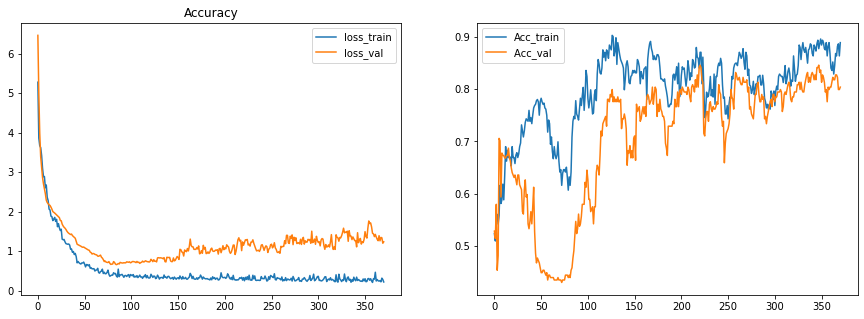

In [45]:
fig,axes = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
axes[0].set_title('Loss')
axes[0].plot(besst_history.history['loss'], label = "loss_train")
axes[0].plot(besst_history.history['val_loss'], label = "loss_val ")
axes[0].legend()

axes[0].set_title('Accuracy')
axes[1].plot(besst_history.history['accuracy'], label = "Acc_train")
axes[1].plot(besst_history.history['val_accuracy'], label = "Acc_val ")
axes[1].legend()
plt.show()

In [190]:

models = []
models.append(('SVM rbf',   model_1))
models.append(('SVM lin',   model_2))
models.append(('LogReg',    model_3))
models.append(('GradBoost', model_4))
models.append(('AdaBoost',  model_5))
models.append(('Bagging',   model_6))
models.append(('RForest',   model_7))
models.append(('Dense',   model_cat))

if 'grid_1.best_estimator_' in locals():

    models = []
    models.append(('SVM rbf', grid_1.best_estimator_))
    models.append(('SVM linear', grid_2.best_estimator_))
    models.append(('LogReg', grid_3.best_estimator_))
    models.append(('GradBoost ', grid_4.best_estimator_))
    models.append(('AdaBoost', grid_5.best_estimator_))
    models.append(('Bagging', grid_6.best_estimator_))
    models.append(('RForest', grid_7.best_estimator_))
    models.append(('Dense',   model_cat))


## Testowanie i predykcje:

Teraz zeksplorujmy jak sobie poradziły te modele. Załadujmy i przepracujmy więc dane testowe, po czym sprawdźmy na metrykach Accuraccy, Precision, Recall i F1 który klasyfikator będzie najlepszy

nastepnie zwizualizujemy krzywe ROC oraz Condusin matrix dla kazdego klasyfikatora, by lepiej ogarnąć jak wewnętrznie sobie radzą.

Zbiór testowy to **dane pochodzące od jednej osoby badanej** - ma to symulować prawdziwe warunki badania, gdzie będziemy spotykali się tylko z danymi jednej osoby. 

In [171]:

path = r'.\Data\Test\Cat\test.mat'
test_d = loadmat(path)
list_of_variables = [test_d[i] for i in list(test_d.keys())[3:-2]]

for i in range(len(list_of_variables)-1):
    data_df = np.hstack((list_of_variables[i],list_of_variables[i+1].reshape(test_d['Elc_power_core'].shape)))
    list_of_variables[i+1] = data_df
    
data_df = list_of_variables[-1]
df_test_cat_data = pd.DataFrame(data_df,columns=list(test_d.keys())[3:-2])
df_test_cat_data

X_test = df_test_cat_data.drop('test_Y',axis=1)
y_test = df_test_cat_data['test_Y']


In [179]:
from sklearn import  metrics

lst_precision_score = []
lst_recall_score = []
lst_f1_score = []
lst_accuracy_score = []

for name, model in models:
    print()
    print(name)
    if name != 'Dense' and name !=  'Dense_2':
        predictions = model.predict(X_test)
    else:
        predictions = np.argmax(model.predict(sc.transform(X_test)),axis=1)
        #predictions = model.predict(X_val)

    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, predictions) ))    
    print("precision_score: {}".format(metrics.precision_score(y_test, predictions) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, predictions) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, predictions) ))
    lst_accuracy_score.append(metrics.accuracy_score(y_test, predictions))
    lst_precision_score.append(metrics.precision_score(y_test, predictions))
    lst_recall_score.append(metrics.recall_score(y_test, predictions))
    lst_f1_score.append( metrics.f1_score(y_test, predictions))



SVM rbf
accuracy_score: 0.9215686274509803
precision_score: 0.9714285714285714
recall_score: 0.918918918918919
f1_score: 0.9444444444444445

SVM lin
accuracy_score: 0.9215686274509803
precision_score: 0.9459459459459459
recall_score: 0.9459459459459459
f1_score: 0.9459459459459459

LogReg
accuracy_score: 0.8823529411764706
precision_score: 0.918918918918919
recall_score: 0.918918918918919
f1_score: 0.918918918918919

GradBoost
accuracy_score: 0.7058823529411765
precision_score: 1.0
recall_score: 0.5945945945945946
f1_score: 0.7457627118644068

AdaBoost
accuracy_score: 0.7450980392156863
precision_score: 1.0
recall_score: 0.6486486486486487
f1_score: 0.7868852459016393

Bagging
accuracy_score: 0.7450980392156863
precision_score: 1.0
recall_score: 0.6486486486486487
f1_score: 0.7868852459016393

RForest
accuracy_score: 0.7450980392156863
precision_score: 1.0
recall_score: 0.6486486486486487
f1_score: 0.7868852459016393

Dense
accuracy_score: 0.8431372549019608
precision_score: 0.8536585

In [65]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM rbf','SVM linear','LogReg','GraBoost','AdaBoost','Bagging','RForest','Dense'])
df

Method  precision_score  recall_score  f1_score  accuracy_score
0     SVM rbf         0.971429      0.918919  0.944444        0.921569
1  SVM linear         0.945946      0.945946  0.945946        0.921569
2      LogReg         0.918919      0.918919  0.918919        0.882353
3    GraBoost         1.000000      0.594595  0.745763        0.705882
4    AdaBoost         1.000000      0.648649  0.786885        0.745098
5     Bagging         1.000000      0.648649  0.786885        0.745098
6     RForest         1.000000      0.648649  0.786885        0.745098
7       Dense         0.853659      0.945946  0.897436        0.843137

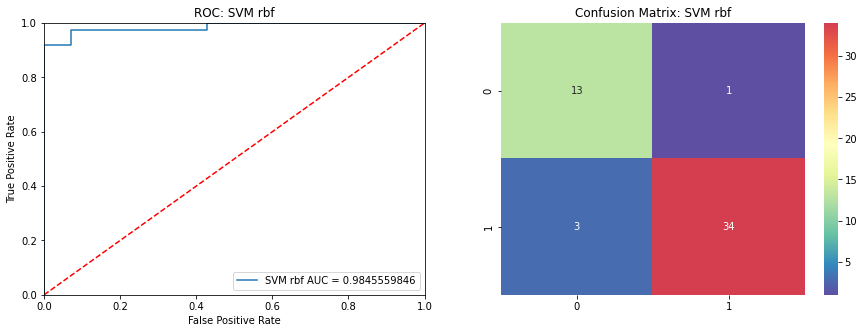

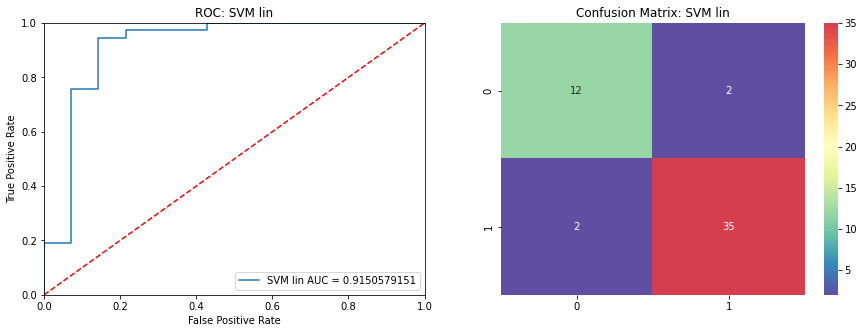

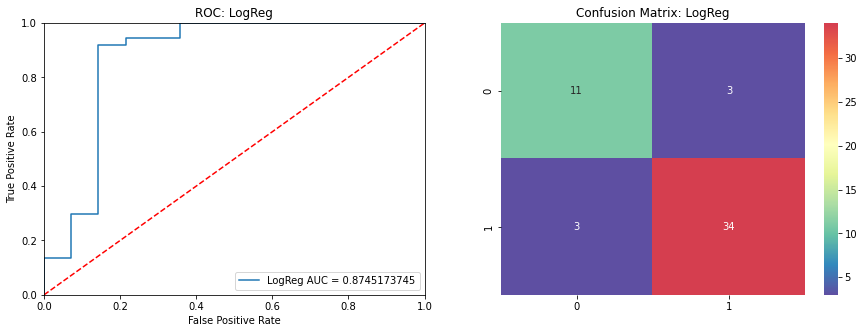

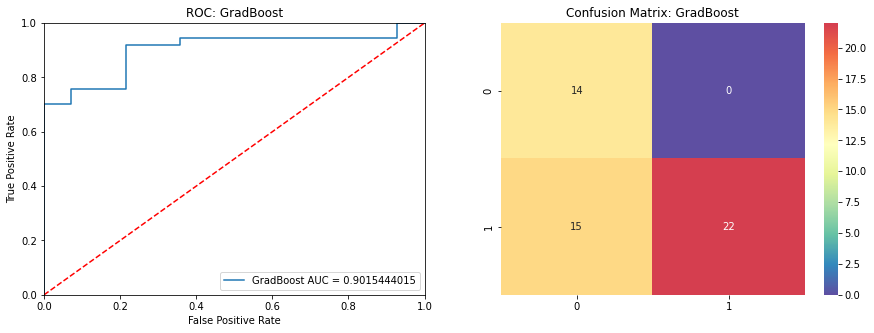

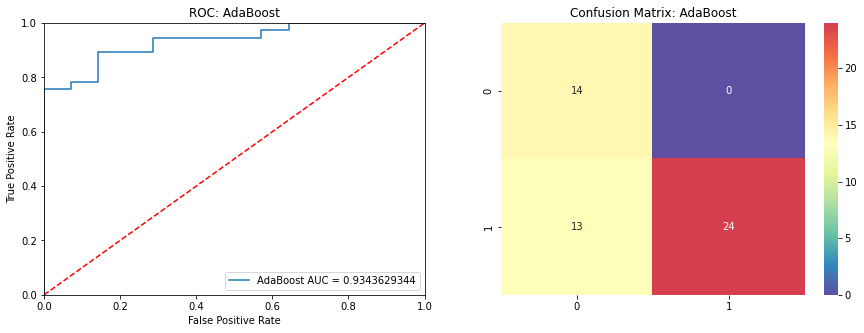

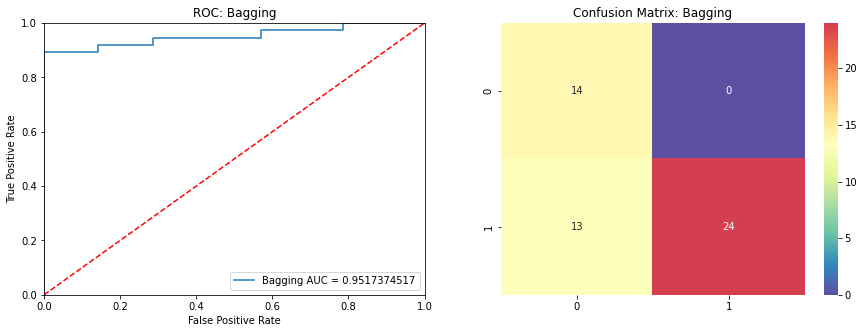

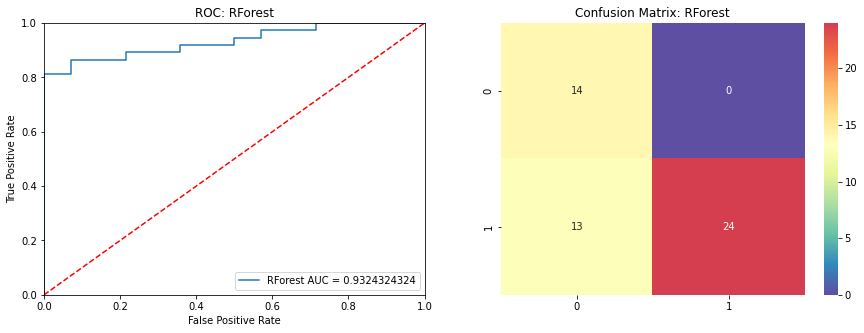

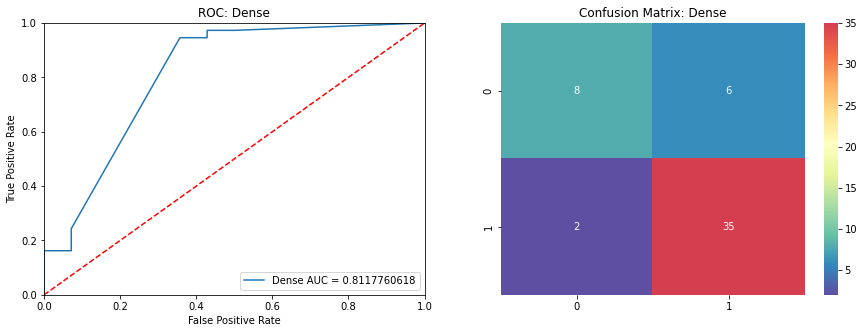

In [67]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt

rainbow = cm.get_cmap('Spectral', 512).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.0, 0.9, 512)))
newcmp

for name, model in models:
# calculate the fpr and tpr for all thresholds of the classification
    if name != 'Dense':
        probs = model.predict_proba(X_test)
        predictions = model.predict(X_test)

    else:
        probs = model.predict(X_test)
        predictions = np.argmax(model.predict(sc.transform(X_test)),axis=1)

    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    fig,axes = plt.subplots(1,2)
    fig.set_figwidth(15)
    fig.set_figheight(5)
    axes[0].set_title('ROC: {}'.format(name))
    axes[0].plot(fpr, tpr, label = '%s AUC = %0.10f' % (name, roc_auc))
    axes[0].legend(loc = 'lower right')
    axes[0].plot([-0, 1], [0, 1],'r--')
    axes[0].set_xlim([-0, 1])
    axes[0].set_ylim([-0, 1])
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')
    
    axes[1].set_title('Confusion Matrix: {}'.format(name))
    sns.heatmap(confusion_matrix(y_test,predictions),ax=axes[1],annot=True,cmap=newcmp)
    plt.show()
    

### Zachowanie modelu Dense

nasz model Dense, byl dośc trudny do wyuczenia, także lepiej go zachować dla przyszłych pokoleń: 

In [68]:

model_cat.save(r'.\Models\cat')

INFO:tensorflow:Assets written to: .\Models\cat\assets


## Inferencja Mózgowych komponentów z obrazków 

Te dane pochodzą z tego samego zbioru - można się więc spodziewać, że w podobny sposób będzie ich dotyczyła 

### Ładowanie danych Obrazkowych

W zbiorze danych, posiadamy jeszcze Mapy topograficzne pokazujące, rozkład zmiany amplitud posczególnych elektrod na skalpie dla poszczególnych komponentów. Pochodzą one z dokładnie tego samego zbioru i są identycznie poszeregowane. 

Obrazki są podzielone na dwa foldery - jeden zawiera komponenty mózgowe (Brain_IC) a drugi artefakty (Not_Brain_IC). Komponenty i artefakty zostały manualnie rozpoznane i zalabelowane przez ekspertów w tej dziedzinie. Należy jednak nadmienić, że zadanie to jest ekstremalnie trudne, i nawet eksperci mają skuteczność jedynie do 90%.

Prócz tego, wybrany zbiór danych służy do badań Brain Connectivity,dotyczące komunikacji regionów mózgu, gdzie niektóre dalsze komponenty, mimo że w jasny sposób zawierają zarówno artefakt jak i sygnał dochodzący z mózgu są uznawane za porządane w analizie komunikacji.

Do innych badań, podobny klasyfikator musiałby być wyuczony ponownie.

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from matplotlib import cm

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

data_dir_train = r'.\Data\aimages_train_best'

#Rozmiary obrazka są tak ustawione, żeby najlepiej uczyły się sieci. 
img_height = 299
img_width = 299
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1423 files belonging to 2 classes.
Using 1139 files for training.
Found 1423 files belonging to 2 classes.
Using 284 files for validation.


Z nazw Folderu naszych danych, powinny zostać odczytane nazwy klas, sprawdźmy czy działa.

Mamy Brain_IC - które odpowiada komponentowi mózgowemu, oraz Not_brainIC odpowiadający artefaktowi.


In [2]:
class_names = train_ds.class_names
class_names

['BrainIC', 'Not_BrainIC']

### Wizualizacja i uwagi o topografiach IC

Zobaczmy jak wyglądają z dwóch klas nasze komponenty, Wzięte są one z różnych datasetów, dlatego czasem będą obecne na nich elektrody a czasem nie. To co jednak mają wspólne to kulsitą reprezentację aktywności mózgowej.

Z powodu też względnej stacjonarności, jakakolwiek **augmentacja obrazu będzie tu niewskazana** - nie mogę zmienić położenia obiektów bo one z natury są względnie stacjonarne, ani kształtu, czy koloru.

Możemy też zauważyć jak nardzo różnorodne są komponenty. W praktyce, zajmuje to bardzo długo, żeby wyuczyć człowieka rozpoznawać komponent móżgowy od artefaktualnego. 

Zanim więc przejdziemy do właściwej klasyfikacji, należy powiedzieć nieco o samych komponentach IC.

- Rozkład ICA będzie dawal najbardziej jasne i prosto rozłożone komponenty na początku analizy, a mniej jasne pod koniec. Dla nas nie ma to wielkiego znaczenia bo komponenty są pomieszane. To co jest ważne, że w dalszych komponentach **rozpoznanie artefaktu od komponentu mózgowego jest ekstremlanie trudne**. Szacuje się, że nawet doświadczeni eksperci nie są w stanie mieć poprawności rozpoznania większej niż 90% 
- Pierwsze 2 lub 3 komponenty pochodzą zazwyczaj z ruchu oczu i tym samym powinny zostać odrzucone
- Szukajac komponentów powinniśmy zwracać uwagę na dużą rozlaną plamę cieplną, która stopniowo maleje. Ewentualnymi komponentami będzie wyraźny efekt ciepłej i zimnej strony. Należy jednak mieć na uwadzę, że często takie komponenty oznaczają ruchy oczu
- komponenty w których aktywność jest skoncentrowana w jednym punkcie to najczęściej artefakty wynikajace ze złego połączenia
- Szacuje się, że nawet eksperci mający lata doświadczenia w rozpoznawaniu komponentów z rozkładu ICA, są wstanie osiągnąć skutecznośc 90%




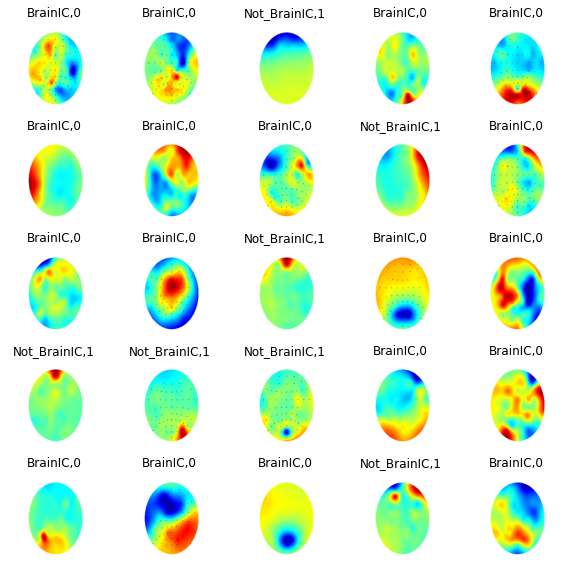

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_data =list(train_ds.as_numpy_iterator())
raw_data_val =list(val_ds.as_numpy_iterator())

raw_data = [raw_data[i][-1] for i in range(len(raw_data))]
raw_data_val = [raw_data_val[i][-1] for i in range(len(raw_data_val))]
for i in range(len(raw_data)-1):
    hsta = np.hstack((raw_data[i],raw_data[i+1]))
    raw_data[i+1] = hsta
    

for j in range(len(raw_data_val)-1):
    hsta_val = np.hstack((raw_data_val[j],raw_data_val[j+1]))
    raw_data_val[j+1] = hsta_val   
    
df_temp = pd.DataFrame(hsta,columns=['lab'])
df_temp = df_temp['lab'].apply(lambda x: class_names[0] if x==0 else class_names[1])

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('{},{}'.format(class_names[labels[i]],labels[i]))
        plt.axis("off")

Weźmy teraz nazwy wszystkich klas i zobaczmy na ile są one zbalansowane

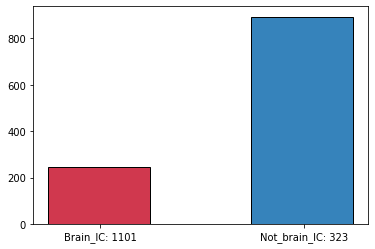

In [157]:


fig, ax = plt.subplots()
data = np.random.rand(1000)

N, bins, patches = ax.hist(df_temp, edgecolor='black', linewidth=1,bins=3)
rainbow = cm.get_cmap('Spectral', 12).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.1, 0.9, 12)))
newcmp
for i in range(0,1):
    patches[i].set_facecolor(newcmp.colors[-1])
for i in range(1,3):    
    patches[i].set_facecolor(newcmp.colors[0])

ax.set_xticks((0.17,0.84))
ax.set_xticklabels(['Brain_IC: {}'.format(len(w_class1)),'Not_brain_IC: {}'.format(len(w_class0))])

plt.show()

Możemy zauważyć silny efekt **niezbalansowania klas** jak więc sobie z tym poradzić?

Mamy kilka opcji:
+ **1)** Oversamplin do klasy Not_BrainIC: Tracimy dużo danych, nasz model może nie uczyć się w ładny sposób. Problemem jest też to, że klasy BrainIC zazwyczaj jest tak dużo, bo faktycznie mamy bardzo różnorodne komponenty mózgowe a jedynie kilka typów artefaktow.

+ **2)** Ustawienie wag klas podczas uczenia modelu
        
Spróbujemy więc ważyć nasz model co do swoich przewidywań - jest to znacznie prostsze a może uda nam się uzyskać słuszne wyniki.


In [5]:
from keras.regularizers import l1,l2
from keras.callbacks import History

from keras.layers import Dense,BatchNormalization,Flatten

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Activation

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import History
num_classes = 2
best_model = 1;
early_stopping2 = EarlyStopping(monitor='val_accuracy', patience=30, mode='max', verbose=1,restore_best_weights=True)
best_acc = 0.5
for  _ in range(10):
    history_cnn = History()
    model = tf.keras.Sequential([
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(10, 3, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, 5, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, 5, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, 5, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same'),
      tf.keras.layers.MaxPooling2D(),  
      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(100, activation='relu',activity_regularizer=l2(0.01)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu"),
      tf.keras.layers.Dense(50, activation='relu',activity_regularizer=l2(0.01)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu",activity_regularizer=l2(0.01)),
      tf.keras.layers.Dense(10, activation='relu',activity_regularizer=l2(0.01)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu",activity_regularizer=l2(0.01)),
      tf.keras.layers.Dense(num_classes)
    ])

    class_weight = {0: 1.,1: 4}
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

    model.fit(
      train_ds,
      validation_data=val_ds,
      class_weight=class_weight,
      epochs=100,batch_size=128
        ,callbacks=[history_cnn,early_stopping2]
    )
    wynik = model.evaluate(val_ds)

    if wynik[1] > best_acc:
        besst_history = history_cnn
        best_model = model
        best_acc = wynik[1]
        
model = best_model

Epoch 1/100
36/36 [==============================] - 12s 118ms/step - loss: 11.2211 - accuracy: 0.7349 - val_loss: 1.9522 - val_accuracy: 0.7324
Epoch 2/100
36/36 [==============================] - 3s 80ms/step - loss: 9.6062 - accuracy: 0.6567 - val_loss: 3.0061 - val_accuracy: 0.7324
Epoch 3/100
36/36 [==============================] - 3s 79ms/step - loss: 8.9473 - accuracy: 0.7129 - val_loss: 2.9588 - val_accuracy: 0.7324
Epoch 4/100
36/36 [==============================] - 3s 80ms/step - loss: 6.6929 - accuracy: 0.7068 - val_loss: 1.0435 - val_accuracy: 0.2746
Epoch 5/100
36/36 [==============================] - 3s 80ms/step - loss: 6.2998 - accuracy: 0.6874 - val_loss: 13.0133 - val_accuracy: 0.7324
Epoch 6/100
36/36 [==============================] - 3s 80ms/step - loss: 6.3153 - accuracy: 0.6163 - val_loss: 6.7397 - val_accuracy: 0.7324
Epoch 7/100
36/36 [==============================] - 3s 80ms/step - loss: 3.8704 - accuracy: 0.6585 - val_loss: 2.4795 - val_accuracy: 0.4718
Ep

36/36 [==============================] - 3s 80ms/step - loss: 3.7596 - accuracy: 0.5996 - val_loss: 17.5852 - val_accuracy: 0.7289
Epoch 26/100
36/36 [==============================] - 3s 80ms/step - loss: 3.8763 - accuracy: 0.5285 - val_loss: 13.2014 - val_accuracy: 0.7359
Epoch 27/100
36/36 [==============================] - 3s 80ms/step - loss: 3.3264 - accuracy: 0.5277 - val_loss: 11.8095 - val_accuracy: 0.7077
Epoch 28/100
36/36 [==============================] - 3s 80ms/step - loss: 3.0388 - accuracy: 0.5575 - val_loss: 23.0171 - val_accuracy: 0.6972
Epoch 29/100
36/36 [==============================] - 3s 82ms/step - loss: 3.2845 - accuracy: 0.5865 - val_loss: 9.3738 - val_accuracy: 0.4683
Epoch 30/100
36/36 [==============================] - 3s 81ms/step - loss: 3.0389 - accuracy: 0.5716 - val_loss: 4.8104 - val_accuracy: 0.5493
Epoch 31/100
36/36 [==============================] - 3s 80ms/step - loss: 2.8884 - accuracy: 0.5601 - val_loss: 0.9707 - val_accuracy: 0.5141
Epoch 32

36/36 [==============================] - 3s 82ms/step - loss: 3.3444 - accuracy: 0.3889 - val_loss: 13.9567 - val_accuracy: 0.6690
Epoch 31/100
36/36 [==============================] - 3s 84ms/step - loss: 3.3932 - accuracy: 0.3793 - val_loss: 2.2589 - val_accuracy: 0.2782
Epoch 32/100
36/36 [==============================] - 3s 82ms/step - loss: 3.3859 - accuracy: 0.3494 - val_loss: 14.4888 - val_accuracy: 0.4437
Epoch 33/100
36/36 [==============================] - 3s 84ms/step - loss: 2.8868 - accuracy: 0.3310 - val_loss: 3.5130 - val_accuracy: 0.3486
Epoch 34/100
36/36 [==============================] - 3s 84ms/step - loss: 2.6114 - accuracy: 0.3117 - val_loss: 2.1012 - val_accuracy: 0.3380
Epoch 35/100
36/36 [==============================] - 3s 85ms/step - loss: 2.3577 - accuracy: 0.3178 - val_loss: 1.3121 - val_accuracy: 0.4789
Epoch 36/100
36/36 [==============================] - 3s 83ms/step - loss: 2.5067 - accuracy: 0.3257 - val_loss: 1.1290 - val_accuracy: 0.4085
Epoch 37/1

### Metryki i Wizualizacja

#### Accuracy, F1, Loss

In [180]:
data_dir_test = r'.\Data\Test\Images'

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 51 files belonging to 2 classes.


In [181]:
img_model = keras.models.load_model(r'.\Models\img_model_wightd')
model = img_model
wynik = model.evaluate(test_ds)
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

true = [el for img, el2 in test_ds.as_numpy_iterator() for el in el2]
preds = np.argmax( model.predict(test_ds),axis=1)

print(np.vstack((true,preds)))
print('Accuracy: {}'.format(wynik[1]) )
print('loss: {}'.format(wynik[0]) )
print('f1_score: {}'.format(f1_score(true,preds)))
print('accuracy_score: {}'.format(accuracy_score(true,preds)))
print('precsion_score: {}'.format(precision_score(true,preds)))
print('recall_score: {}'.format(recall_score(true,preds)))
lst_accuracy_score.append(metrics.accuracy_score(true,preds))
lst_precision_score.append(metrics.precision_score(true,preds))
lst_recall_score.append(metrics.recall_score(true,preds))
lst_f1_score.append( metrics.f1_score(true,preds))
models.append(('Image',   model))

2/2 [==============================] - 1s 123ms/step - loss: 2.8840 - accuracy: 0.8431
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 1 1 1 0 0 1 1 1 1 0]]
Accuracy: 0.843137264251709
loss: 2.8840086460113525
f1_score: 0.6666666666666666
accuracy_score: 0.8431372549019608
precsion_score: 0.8
recall_score: 0.5714285714285714


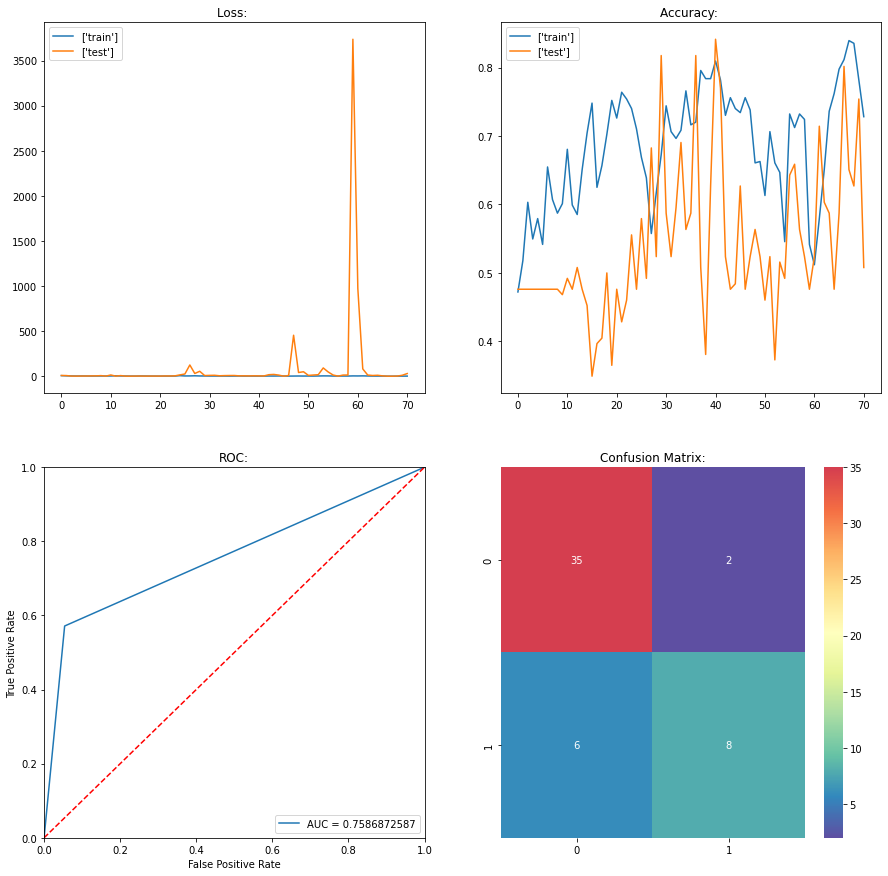

In [21]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn import metrics
import seaborn as sns
from matplotlib import cm

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
rainbow = cm.get_cmap('Spectral', 512).reversed()
newcmp = ListedColormap(rainbow(np.linspace(0.0, 0.9, 512)))
fig,axes = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(15)

fpr, tpr, threshold = roc_curve(true,preds)
roc_auc = metrics.auc(fpr, tpr)

axes[1][0].set_title('ROC:')
axes[1][0].plot(fpr, tpr, label = 'AUC = %0.10f' % ( roc_auc))
axes[1][0].legend(loc = 'lower right')
axes[1][0].plot([-0, 1], [0, 1],'r--')
axes[1][0].set_xlim([-0, 1])
axes[1][0].set_ylim([-0, 1])
axes[1][0].set_ylabel('True Positive Rate')
axes[1][0].set_xlabel('False Positive Rate')

axes[1][1].set_title('Confusion Matrix:')
sns.heatmap(confusion_matrix(true,preds),ax=axes[1][1],annot=True,cmap=newcmp)

axes[0][1].set_title('Accuracy: ')
axes[0][1].plot(besst_history.history["accuracy"],label=['train'])
axes[0][1].plot(besst_history.history["val_accuracy"],label=['test'])
axes[0][1].legend()

axes[0][0].set_title('Loss: ')
axes[0][0].plot(besst_history.history["loss"],label=['train'])
axes[0][0].plot(besst_history.history["val_loss"],label=['test'])
axes[0][0].legend()

plt.show()


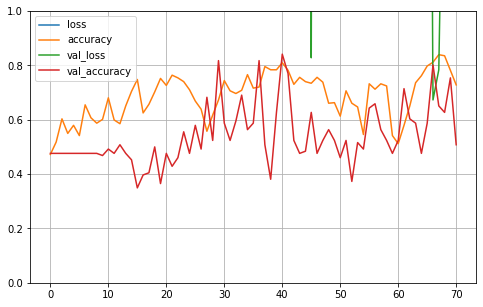

In [22]:
pd.DataFrame(besst_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Próbna klasyfikacja

Klasyfikator Nie poradził sobie jakoś nadmiernie dobrze: Accuracy niby 84% ale Recall jedynie 50%. Sprawdźmy jednak dane, czy faktycznie będzie to taki problem, i czy pomyłki klasyfikatora mogą być uzasadnione dużą spornością danych

32
19


C:\Users\barak\AppData\Local\Temp\ipykernel_22372\1352893733.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(6, 6, i + 1)


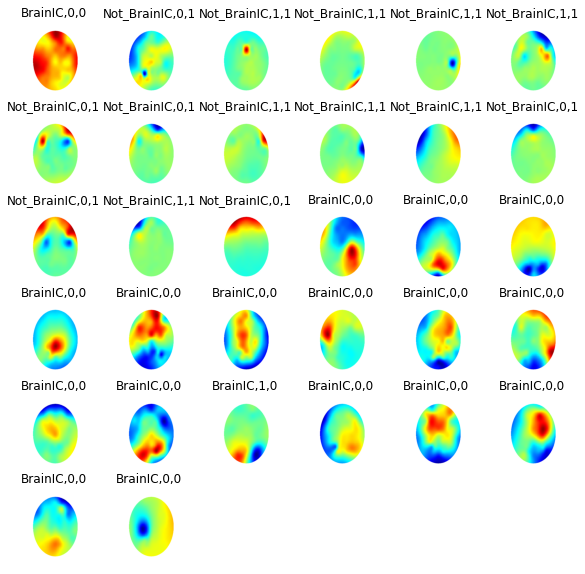

In [213]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for data_pack in test_ds:
    images = data_pack[0]
    labels = data_pack[1]
    preds = np.argmax(img_model.predict(images),axis=1)
    print(len(images))
    for i in range(len(images)):
        ax = plt.subplot(6, 6, i + 1)
        ax.set_width = 20
        ax.set_height = 20
        plt.imshow(np.array(images[-i]).astype("uint8"))
        plt.title('{},{},{}'.format(class_names[labels[-i]],preds[-i],labels[-i]))
        plt.axis("off")



In [201]:
len(test_ds)

2

Widać pomyłki modelu: wadliwe komponenty to  2,7, 8 ,12,13,15. Naromiast tylko drugi  oraz 15 wyraźnie jest komponentem mózgowym. Reszta, mogła zostać zaklasyfkowana tak przez badacza z powodu ich pomieszania z komponentami mózgowymi - co dla badania obecnego było wskazane, natomiat ogólnie jest problematyczne

Oznacza to, że błędy popełniane przez model nie są jakies rażące i popełnia on błędy tam, gdzie może to byc faktycznie problematyczne. 


### Zachowanie modelu

Model do obrazków był tym trudniejszy do wyuczenia. Lepiej go zachowajmy dla przyszłych pokoleń.  

In [29]:
model_img = model
model_img.save(r'.\Models\img_model_wightd')

INFO:tensorflow:Assets written to: .\Models\img_model_wightd\assets


## Predykcje łączone

Czy biorąc oba modele na zbiorze testowym, uda się osiągnąć nieco lepsze predykcje?

zeby jednak oba modele załadowac poprawnie trzeba trochę pokombinować z danymi. ładowaliśmy nasze dane testowe bez przeprowadzania shuffle - w takim razie jest to po prostu konkatenacja klasy 0 --> BrainIc wraz z klasą 1 --> Not_BrainIc. 

Musimy analogicznie przekształcić dane kategoryczne - Pamiętając, żeby zachować kolejnosć - sprowadza się to na stworzeniu tabel - BrainIc oraz Not_BrainIc- uporządkowaniu ich, po czym dodaniu do siebie!

In [70]:
    
from tensorflow import keras
img_model = keras.models.load_model(r'.\Models\img_model_wightd')
img_model.evaluate(test_ds)

2/2 [==============================] - 1s 109ms/step - loss: 2.8840 - accuracy: 0.8431


[2.8840086460113525, 0.843137264251709]

In [72]:
cat_model= keras.models.load_model(r'.\Models\cat')

In [103]:
Testing_data = X_test
Testing_data['Y'] = y_test

In [94]:
table_Not_brain = Testing_data[Testing_data['Y']==0]
table_Brain = Testing_data[Testing_data['Y']==1]
vertical_stack = pd.concat([table_Brain, table_Not_brain], axis=0)
X_test_mix = vertical_stack.drop('Y',axis=1)
X_test_mix

Elc_power_core  Elc_spectrum_corr  Kurtosis  Spect_flat  Spect_one_over_f  \
2         1.436083           0.773469 -0.208194   -0.353666          0.349252   
3        -0.100024          -0.286024 -0.208178    0.774359         -2.265202   
4        -0.183061           0.368642 -0.191175    1.602942          0.402597   
5        -0.390052          -0.468381 -0.159276    2.434326         -3.401059   
6        -0.372215           0.407515 -0.206643    1.649494         -0.262706   
7        -0.267822           0.378116 -0.212784   -0.805825          0.125648   
8         0.497756          -0.352031 -0.204984    1.147859         -2.789764   
9        -0.376351           0.603870 -0.212344    0.049548          0.102988   
10        0.566264          -2.038733 -0.188525    1.207898         -3.340011   
11       -0.300986           0.299872 -0.211757   -0.649044          0.615762   
14       -0.496852           0.255744 -0.187834    0.380588         -0.437678   
15       -0.434347           0.483959 -0.212826   -0.339790          0.374727   
16        0.149205          -0.047220 -0.209402    0.043003         -0.996575   
18       -0.066576           0.216127 -0.199826    0.673294         -0.795634   
19        0.108627           0.374731 -0.211413    0.176570          0.263856   
20        0.394568           0.699646 -0.209393    0.053273          0.418170   
21       -0.185102           0.211910 -0.203147   -0.526294          0.055873   
22       -0.095635           0.621034 -0.212347    0.341832          0.218692   
23       -0.578465           0.016239 -0.110695   -0.936788          0.229137   
24       -0.491815           0.699644 -0.213959   -0.063258          0.281025   
26       -0.524819           0.674730 -0.212595    0.007576          0.431777   
28       -0.186722          -1.257648 -0.209138   -1.175263          0.349717   
29       -0.229894           0.237861 -0.206289    0.885570         -0.968862   
31       -0.325574           0.580609 -0.212035    0.019535          0.660676   
33       -0.063624           0.065170 -0.203987   -0.644642          0.194486   
34       -0.375102           0.103168 -0.211767   -0.715646          0.520007   
35       -0.353868           0.498257 -0.213142   -0.148746          0.645928   
36        0.045628           0.594385 -0.213356   -0.382727          0.578589   
37       -0.545755           0.586770 -0.213728   -0.281959          0.618425   
39       -0.296847           0.231058 -0.212608   -0.917274          0.723772   
40       -0.287671           0.640556 -0.206633    0.274189          0.809887   
41       -0.484001           0.319101 -0.131696   -0.650055         -0.018065   
42       -0.526581           0.485460 -0.213704   -0.429552          0.435933   
44       -0.474455           0.270898 -0.214184   -0.690134          0.356884   
46       -0.333513           0.619579 -0.213367   -0.391412          0.585206   
47       -0.418345           0.620409 -0.201635    0.091845          0.452759   
49       -0.208578           0.703822  0.131126   -0.453301          0.669481   
0         4.910486           0.961457 -0.039870    3.330681          0.501824   
1         4.222781           0.868745 -0.187060    2.159324          0.841020   
12       -0.132190          -2.767742 -0.213841   -1.076312          0.301406   
13        0.110429          -1.626206 -0.118667   -1.018585         -1.428962   
17       -0.344096          -3.906490 -0.213295   -1.108203          0.471019   
25       -0.442058           0.713960 -0.199273    0.090513          0.589017   
27       -0.201281          -1.472598 -0.191675   -1.186244          0.553337   
30       -0.112363          -0.923784 -0.212818   -1.037771          0.434386   
32        0.172643          -1.327714 -0.210614   -1.099475          0.478582   
38        0.308218          -1.555860 -0.198541   -1.005665         -0.031648   
43       -0.474038           0.670556  0.252956    0.880865          0.360380   
45       -0.408605          -0.2486

 Po takim przekształceniu, musimy pamiętać **że dla danych korelacyjnych klasa 0 to klasa Not_brain a dla obrazkowych, 0 to Brain!** oznacza to, że możemy skorzystać z tego samego wektora, TYLKO musimy odwrócić nasze predykcje w jednym modelu:

In [122]:
categorical_preds = model_1.predict_proba(X_test_mix)
categorical_preds = np.vstack((categorical_preds[:,1], categorical_preds[:,0])).T

In [185]:
preds = img_model.predict(test_ds)

In [186]:
np.argmax(preds,axis=1)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0], dtype=int64)

In [150]:
joint_predictions =  np.argmax((preds + categorical_preds)/2,axis=1)

In [182]:
true = np.array(true)

print("accuracy_score: {}".format( metrics.accuracy_score(true, joint_predictions) ))    
print("precision_score: {}".format(metrics.precision_score(true, joint_predictions) ))
print("recall_score: {}".format( metrics.recall_score(true, joint_predictions) ))
print("f1_score: {}".format( metrics.f1_score(true, joint_predictions) ))
lst_accuracy_score.append(metrics.accuracy_score(true,joint_predictions))
lst_precision_score.append(metrics.precision_score(true,joint_predictions))
lst_recall_score.append(metrics.recall_score(true,joint_predictions))
lst_f1_score.append( metrics.f1_score(true,joint_predictions))


accuracy_score: 0.9607843137254902
precision_score: 0.9285714285714286
recall_score: 0.9285714285714286
f1_score: 0.9285714285714286


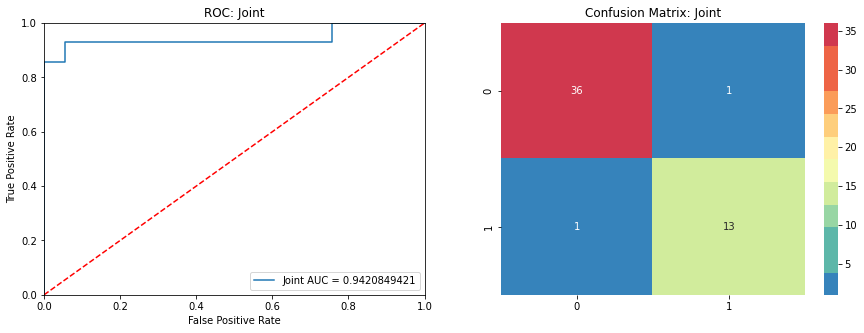

In [188]:
fpr, tpr, threshold = roc_curve(true, ((preds + categorical_preds)/2)[:,1])
roc_auc = metrics.auc(fpr, tpr)
fig,axes = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
axes[0].set_title('ROC: {}'.format('Joint'))
axes[0].plot(fpr, tpr, label = '%s AUC = %0.10f' % ('Joint', roc_auc))
axes[0].legend(loc = 'lower right')
axes[0].plot([-0, 1], [0, 1],'r--')
axes[0].set_xlim([-0, 1])
axes[0].set_ylim([-0, 1])
axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')

axes[1].set_title('Confusion Matrix: {}'.format('Joint'))
sns.heatmap(confusion_matrix(true,joint_predictions),ax=axes[1],annot=True,cmap=newcmp)
plt.show()


Można łatwo zauważyć, że model połączony - najlepszy klasyfikator: SVC rbf, wraz z siecią neuronową dają **najlepsze wyniki** ponieważ razem wspieraja swoje predykcje przez uśrednianie. 

Pokazuje to że możliwe jest stworzenie mieszanego, usrednionego klasyfikatora który by przewidywał takie rzeczy!

In [183]:
import pandas as pd
d = {'precision_score': lst_precision_score, 
     'recall_score': lst_recall_score, 
     'f1_score': lst_f1_score,
     'accuracy_score' : lst_accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM rbf','SVM linear','LogReg','GraBoost','AdaBoost','Bagging','RForest','Dense','Image','Joint'])
df

Method  precision_score  recall_score  f1_score  accuracy_score
0     SVM rbf         0.971429      0.918919  0.944444        0.921569
1  SVM linear         0.945946      0.945946  0.945946        0.921569
2      LogReg         0.918919      0.918919  0.918919        0.882353
3    GraBoost         1.000000      0.594595  0.745763        0.705882
4    AdaBoost         1.000000      0.648649  0.786885        0.745098
5     Bagging         1.000000      0.648649  0.786885        0.745098
6     RForest         1.000000      0.648649  0.786885        0.745098
7       Dense         0.853659      0.945946  0.897436        0.843137
8       Image         0.800000      0.571429  0.666667        0.843137
9       Joint         0.928571      0.928571  0.928571        0.960784